In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import os
from scipy.optimize import curve_fit
import B00_codes.dataReader as dr
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
import matplotlib.colors as mcolors

NO_MS_EQUALS_1 = 0
Q_FINAL = 1
THREE_PI_HALF_FINAL = 2
REF_MINUS_SIG  =3
f0 = 2.88e9

pi = np.pi

def chi_squared(y, y_fit, sigma):
    residuals = y - y_fit
    return np.sum((residuals / sigma)**2)

def reduced_chi_squared(y, y_fit, sigma, popt, pcov):
    n = len(y)  # Number of data points
    p = len(popt)  # Number of fitting parameters
    dof = n - p  # Degrees of freedom
    chisq = chi_squared(y, y_fit, sigma)  # Chi-squared value
    reduced_chisq = chisq / dof
    return reduced_chisq

def running_average(arr):
    running_sum = 0
    running_avg = []

    for i, num in enumerate(arr):
        running_sum += num
        avg = running_sum / (i + 1)  # Calculate the running average
        running_avg.append(avg)

    return running_avg

def smooth(x, n=3):
    K = int((n-1)/2)
    smoothed_x = np.zeros(len(x))
    for i in range(K):
        smoothed_x[i] = x[i]
        smoothed_x[-i-1] = x[-i-1]
    for i in range(0, len(x)-(n-1)):
        for j in range(n):
            smoothed_x[i+K] += x[i+j]/n
    return smoothed_x

def smoothConvolution(x, n=5):
    K = int((n-1)/2)
    mask = np.ones(n)/n
    z = np.convolve(x,mask,'same')
    z[-K:] = x[-K:]
    return z

def average(y, n):
    # Initialize an empty list to store the averages
    averages = []

    # Iterate through the array in steps of 3
    for i in range(0, len(y), n):
        group = y[i:i + n]  # Get a group of three points
        average = np.mean(group)  # Calculate the average of the group
        averages.append(average)  # Add the average to the list

    # Convert the list of averages back to a NumPy array
    return np.array(averages)

def cov(a,b,axis=1):
    if len(np.shape(a))==2:
        N = np.shape(a)[1]
    else:
        N = np.shape(a)[0]
    prod = a*b
    prod = np.nan_to_num(prod)
    prodavg = np.average(prod,axis=axis)
    aavg = np.average(a,axis=axis)
    bavg = np.average(b,axis=axis)
    sigma_a = np.std(a, axis=axis)
    sigma_b = np.std(b, axis=axis)
    
    r = (prodavg - aavg*bavg)/(sigma_a * sigma_b)
    sigma_r = np.sqrt((1-r**2)/(N-2))
    return r, sigma_r, aavg,sigma_a

def thresholded(sig,thres):
    (row, col) = np.shape(sig)

    sigThd = np.zeros((row, col))
    for i in range(row):
        for j in range(col):
            if sig[i,j] > thres: sigThd[i,j] = 1
    return sigThd

def contrast_new(sigs,refs,sigavg,refavg,ifNorm=0,max_contrast=1):
    (row, col) = np.shape(sigs)
    contrast = np.zeros((row,col))
    diff = sigs-refs
    for i in range(row):
        contrast[i] = diff[i]/(sigavg[i]+refavg[i])
    
    if ifNorm==1: # full contrast defined by data, usually for cosine magnetometry
        y = (sigavg-refavg)/(sigavg+refavg)
        contrast = linear_map(contrast,-max(y),max(y),0,1)
    elif ifNorm==2: # full contrast defined by prev calib
        y = (sigavg-refavg)/(sigavg+refavg)
        contrast = linear_map(contrast,-max_contrast,max_contrast,0,1)

    return contrast

def linear_map(arr, a, b, c, d): # map a to c, b to d
    return (arr - a) * (d - c) / (b - a) + c

def find_peaks(data, threshold=0):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1] and data[i] > threshold:
            peaks.append(i)
    return peaks

def subtractMeanFewReps(array,n):
    reshaped_array = array.reshape(-1, n)
    mean_per_group = np.mean(reshaped_array, axis=1)
    mean_repeated  = np.repeat(mean_per_group, n)
    result_array   = array - mean_repeated
    return result_array

def fourier(y, delta_t, f_factor=1):
    yfourier = np.fft.fft(y-np.average(y)); yfourier = np.abs(yfourier)
    f = np.fft.fftfreq(len(y), delta_t)/f_factor  # insert spacing

    sorted_indices = np.argsort(f)       # Get the indices that would sort f
    f = f[sorted_indices]                # Sort f in ascending order
    yfourier = yfourier[sorted_indices]  # Reorder yfourier based on the sorted_indices

    return f,yfourier

def circular_shift(arr, shift_amount):
    n = len(arr)
    # Use modulo to handle circular shifting
    shifted_arr = np.concatenate((arr[-shift_amount % n:], arr[:-shift_amount % n]))
    return shifted_arr

def gaussian_2d(xy, amplitude, x0, y0, sigma_x, sigma_y, offset):
    x, y = xy
    f = offset + amplitude * np.exp(
        -((x - x0) ** 2 / (2 * sigma_x ** 2) + (y - y0) ** 2 / (2 * sigma_y ** 2)))
    return f.ravel()

# PLE spectroscopy

In [225]:
# ODMR
days = np.linspace(1,30,30); mos = np.linspace(9,10,2); whichNV=1
if whichNV==1:
    roundedWvl = 470.455
elif whichNV==2:
    roundedWvl = 470.468
dataArr = []; sigArr = []; refArr = []; idxs = []; wvlArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-09-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'ScanRRFreq' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if (day==9 and idx == 33):
                datafile = mainFolder + dataFolder +'/ScanRRFreqObject_sig_set.dat'
                x_s, sig, ref, wvl = dr.readDataNoPlotWM(datafile)
                sig = np.array(sig); ref = np.array(ref)
                contrast = ref/sig
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref)
                idxs.append(idx); wvlArr.append(wvl)

dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr)
idxs = np.array(idxs); wvlArr = (np.array(wvlArr)-roundedWvl)*1e3

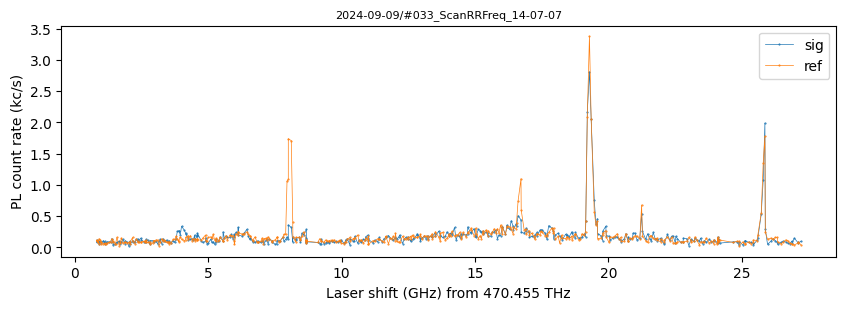

In [226]:
wvl = np.average(wvlArr,axis=0); sig = np.average(sigArr,axis=0); ref = np.average(refArr,axis=0)
cutidx=0
wvl = wvl[cutidx:]; sig = sig[cutidx:]; ref = ref[cutidx:]

fig,ax = plt.subplots(figsize=(10,3))
ax.plot(wvl,sig, 'o-', markersize=0.5, label='sig', linewidth=0.5)
ax.plot(wvl,ref, 'o-', markersize=0.5, label='ref', linewidth=0.5)
ax.legend()
# ax.set_xlim((6,8))
# ax.vlines(x=7, ymin = min(sig), ymax=max(ref), linestyle='--', color='k', linewidth=1)

# xfit, yfit, popt, perr = dr.fitLor(wvl,ref,guess=(0.8,28.4,0.3, 0), upperBounds=(np.inf, np.inf, np.inf, np.inf))
# ax.plot(xfit,yfit,color='C1',linewidth=1)
# print('Peak = %.3f GHz; Width = %.0f MHz' % (popt[1], popt[2]*1e3))

ax.set_xlabel('Laser shift (GHz) from %.3f THz' % (roundedWvl))
ax.set_ylabel('PL count rate (kc/s)')
ax.set_title(datafile[31:66],fontsize=8);


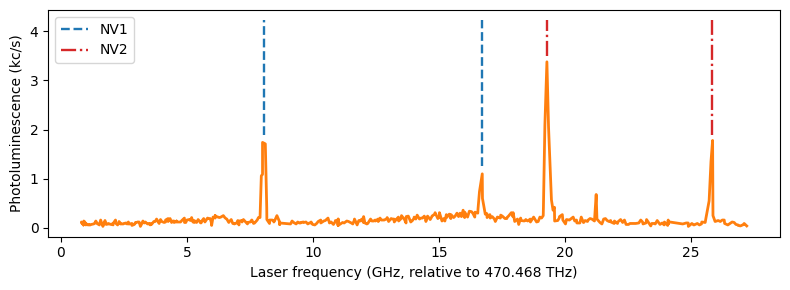

In [265]:
# for deliverable
ysig1 = sig; yref1 = ref; x1Plot = wvl; ms=0; lw = 2; scale = 0.

fig, ax = plt.subplots(1,1, figsize=(8,3)) #

# ax.plot(x1Plot, ysig1, 'o-', markersize=ms, linewidth = lw, label='$\pi$-pulse on NV1')
ax.plot(x1Plot, yref1, 'o-', markersize=ms, linewidth = lw, color='C1')
# ax.plot(x+0.3, ysig+25, 'o-', markersize=ms, linewidth = lw, label='$\pi$-pulse on NV2')
# ax.plot(x+0.3, yref+25, 'o-', markersize=ms, linewidth = lw, label='no $\pi$-pulse')
ax.set_ylabel('Photoluminescence (kc/s)')
ax.set_xlabel('Laser frequency (GHz, relative to 470.468 THz)')

# ax.set_xlim((6,9))
ax.vlines(x=8.05,ymin=1.9,ymax=max(yref1)*1.25, color='C0',linestyle='--',linewidth=lw*0.85,label='NV1')
ax.vlines(x=16.7,ymin=1.25,ymax=max(yref1)*1.25, color='C0',linestyle='--',linewidth=lw*0.85)
ax.vlines(x=19.3,ymin=3.5,ymax=max(yref1)*1.25, color='C3',linestyle='-.',linewidth=lw*0.85,label='NV2')
ax.vlines(x=25.85,ymin=1.9,ymax=max(yref1)*1.25, color='C3',linestyle='-.',linewidth=lw*0.85)

ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [514]:
# fig,ax = plt.subplots(figsize=(10,3))
# for i in range(2):
#     wvl = wvlArr[i]; sig = sigArr[i]; ref = refArr[i]
#     cutidx=1
#     wvl = wvl[cutidx:]; sig = sig[cutidx:]; ref = ref[cutidx:]

#     ax.plot(wvl,sig, 'o-', markersize=2, label='sig', linewidth=0.5, color='C0')
#     ax.plot(wvl,ref, 'o-', markersize=2, label='ref', linewidth=0.5, color='C1')
    
#     ax.set_xlabel('Laser shift (GHz) from %.3f THz' % (roundedWvl))
#     ax.set_ylabel('PL count rate (kc/s)')
#     ax.set_title(datafile[31:66],fontsize=8);
# # ax.set_xlim((-10,40))


C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_15076\3695467539.py:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot = axs[0].pcolormesh(wvlArr,Y, dataArr, cmap=cmap, norm=norm)
C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_15076\3695467539.py:22: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plot1 = axs[1].pcolormesh(wvlArr,Y, sigArr, cmap='inferno')
C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_15076\3695467539.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing.

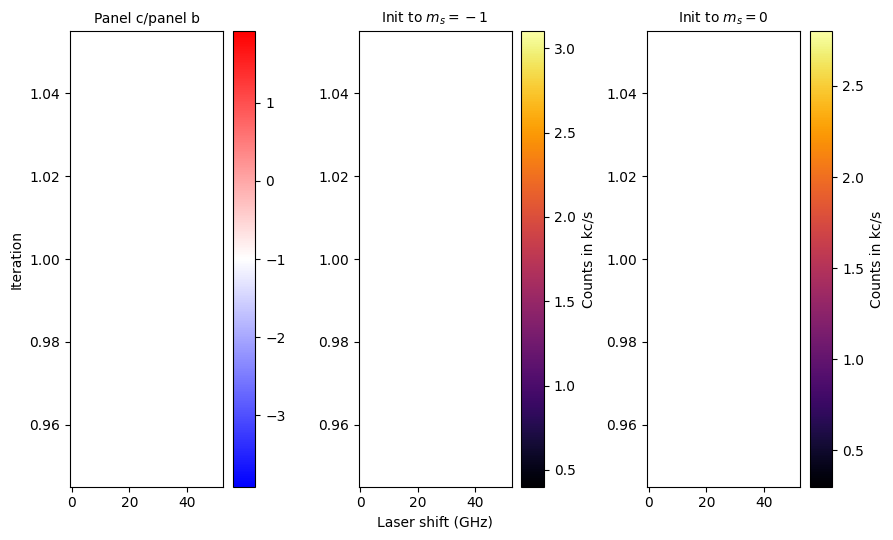

In [795]:
sorted_indices = np.argsort(idxs)

# Sort array1 in ascending order
dataArr = dataArr[sorted_indices]; wvlArr = wvlArr[sorted_indices]
sigArr = sigArr[sorted_indices]
refArr = refArr[sorted_indices]

# Create a colormap with the custom midpoint
cmap = plt.get_cmap('bwr')  # You can choose any colormap
norm = mcolors.CenteredNorm(vcenter=-1)

fig, axs = plt.subplots(1,3,figsize=(9,5.5))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = axs[0].pcolormesh(wvlArr,Y, dataArr, cmap=cmap, norm=norm)
fig.colorbar(plot, orientation='vertical', ax=axs[0])
# axs[0].set_xlabel('Laser shift (MHz)')
axs[0].set_ylabel('Iteration')
axs[0].set_title('Panel c/panel b',fontsize=10)

plot1 = axs[1].pcolormesh(wvlArr,Y, sigArr, cmap='inferno')
axs[1].set_xlabel('Laser shift (GHz)')
axs[1].set_title('Init to $m_s = -1$',fontsize=10)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])
cb1.set_label("Counts in kc/s",fontsize=10)

plot2 = axs[2].pcolormesh(wvlArr,Y, refArr, cmap='inferno')
# axs[2].set_xlabel('Laser shift (MHz)')
axs[2].set_title('Init to $m_s = 0$',fontsize=10)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[2])
cb2.set_label("Counts in kc/s",fontsize=10)

# for i in range(3):
#     axs[i].set_xlim((55,60))
#     # axs[i].set_ylim((0,175))

plt.tight_layout()
plt.show()

# CW ODMR

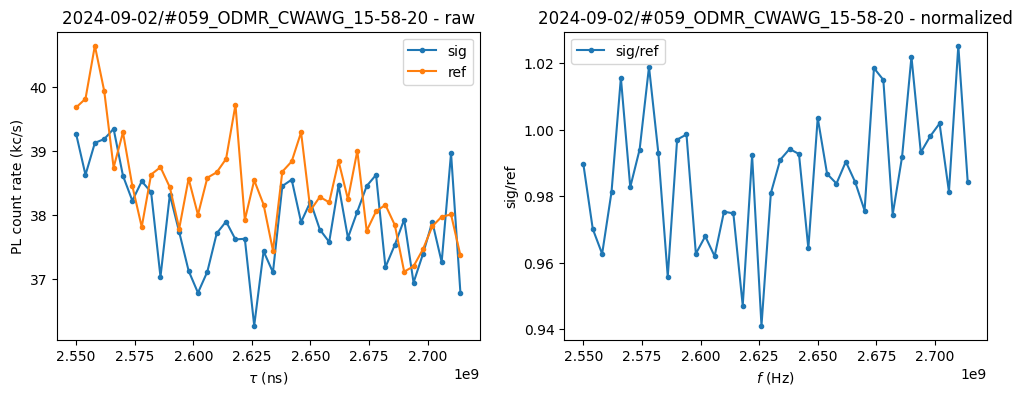

In [1301]:
# ODMR
days = np.linspace(1,2,2)
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-09-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'ODMR_CWAWG' in dataFolder:
            idx = int(dataFolder[1:4])
            if day==2 and idx >= 59:
                datafile = mainFolder + dataFolder +'/ODMRAWGObject_sig_set.dat'
                sig, ref, popt, perr, x_s = dr.readData(datafile, type='ODMR')

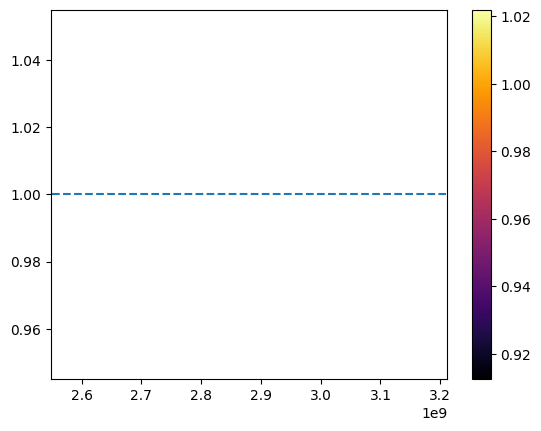

In [271]:
# ODMR
days = np.linspace(1,30,30)
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-08-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'ODMR_CW' in dataFolder:
            idx = int(dataFolder[1:4])
            # if day==28 and idx >= 246 and idx <= 326:
            if day==29 and idx == 8:
                datafile = mainFolder + dataFolder +'/ODMRAWGObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                xPlot = x_s
                contrast = sig/ref
                dataArr.append(contrast)

dataArr = np.array(dataArr)

fig, ax = plt.subplots()#figsize=(10,10))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(xPlot, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')
# plot.set_clim(0.96,1)

ax.vlines(x=f0, ymin=min(y), ymax=max(y), linewidth=1.5, linestyle='--')
for i in range(N_datasets):
    if np.mod(i,9) == 0:
        ax.hlines(y=i+1, xmin=min(xPlot), xmax=max(xPlot), linewidth=1.5, linestyle='--')
    if np.mod(i,9) == 5:
        ax.hlines(y=i+1, xmin=min(xPlot), xmax=max(xPlot), linewidth=1.5, linestyle='--', color='red')

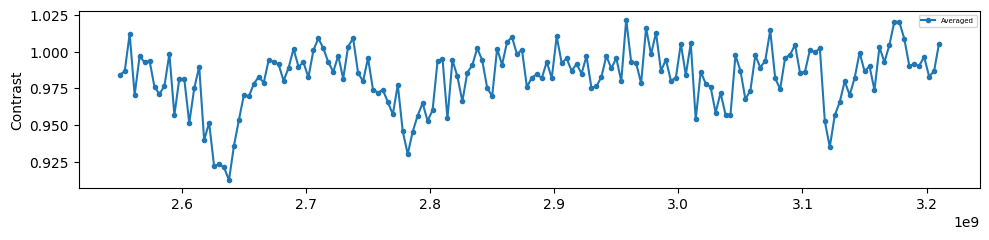

In [272]:
y = y6 = np.average(dataArr, axis=0)
x = x6 = xPlot

fig, ax = plt.subplots(figsize=(10,2.5))
ax.plot(x,y, label="Averaged", linestyle='-', marker='o', markersize=3,)
ax.set_ylabel('Contrast')
# ax.vlines(x=2.952e9, ymin=min(y), ymax=max(y), linestyle='--', color='red')
ax.legend(fontsize=5)
# ax.set_xlim((2.6e9,2.7e9))

plt.tight_layout()

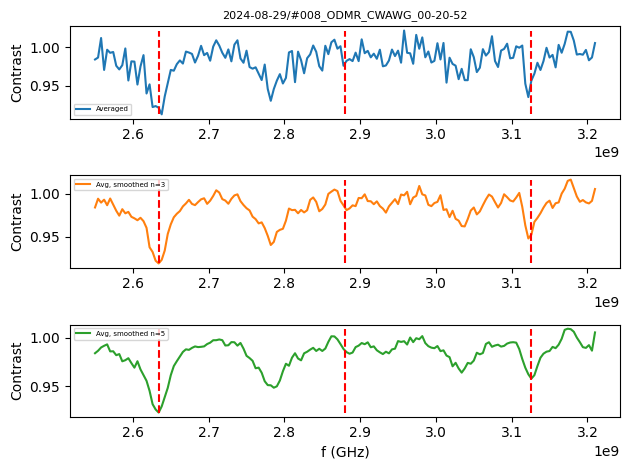

In [276]:
y = y6 = np.average(dataArr, axis=0)
x = x6 = xPlot

fig, axs = plt.subplots(3,1)
axs[0].plot(x,y, label="Averaged")
axs[0].set_ylabel('Contrast')
axs[0].vlines(x=f0, ymin=min(y), ymax=max(y), linestyle='--', color='red')
peak = 2.634e9
axs[0].vlines(x=peak, ymin=min(y), ymax=max(y), linestyle='--', color='red')
axs[0].vlines(x=peak + 2*(f0-peak), ymin=min(y), ymax=max(y), linestyle='--', color='red')
axs[0].legend(fontsize=5)

ys3 = smooth(y,n=3)
axs[1].plot(x, ys3, label="Avg, smoothed n=3", color='C1')
axs[1].set_ylabel('Contrast')
axs[1].vlines(x=f0, ymin=min(ys3), ymax=max(ys3), linestyle='--', color='red')
axs[1].vlines(x=peak, ymin=min(ys3), ymax=max(ys3), linestyle='--', color='red')
axs[1].vlines(x=peak + 2*(f0-peak), ymin=min(ys3), ymax=max(ys3), linestyle='--', color='red')
axs[1].legend(fontsize=5)

ys5 = smooth(y,n=5)
axs[2].plot(x,ys5, label="Avg, smoothed n=5", color='C2')
axs[2].set_ylabel('Contrast')
axs[2].vlines(x=f0, ymin=min(ys5), ymax=max(ys5), linestyle='--', color='red')
axs[2].vlines(x=peak, ymin=min(ys5), ymax=max(ys5), linestyle='--', color='red')
axs[2].vlines(x=peak + 2*(f0-peak), ymin=min(ys5), ymax=max(ys5), linestyle='--', color='red')
axs[2].set_xlabel('f (GHz)')
axs[2].legend(fontsize=5)

axs[0].set_title(datafile[31:66],fontsize=8)
plt.tight_layout()

In [135]:
# fig, axs = plt.subplots(3,1)
# axs[0].plot(x1,smooth(y1,n=5), label="Averaged", linestyle='--')
# axs[0].set_ylabel('Contrast')

# axs[0].plot(x2,smooth(y2,n=5), label="Avg, smoothed n=3", color='C0', linestyle='--')
# axs[0].set_ylabel('Contrast')
# # axs[0].legend(fontsize=5)
# axs[0].set_xlim((2.3e9,3.3e9))

# axs[1].plot(x3,smooth(y3,n=5), label="Avg, smoothed n=5", color='C1', linestyle='--')
# axs[1].set_ylabel('Contrast')
# # axs[1].set_xlabel('f (GHz)')
# axs[1].set_xlim((2.3e9,3.3e9))
# # axs[1].legend(fontsize=5)

# axs[2].plot(x4,smooth(y4,n=5), label="Avg, smoothed n=5", color='C2', linestyle='--')
# axs[2].set_ylabel('Contrast')
# axs[2].set_xlabel('f (GHz)')
# axs[2].set_xlim((2.3e9,3.3e9))
# # axs[1].legend(fontsize=5)
# plt.tight_layout()

# Rabi

[6.22312659e-02 3.12356165e+01 1.90699897e-01 9.19379652e-01
 7.55968542e+07]


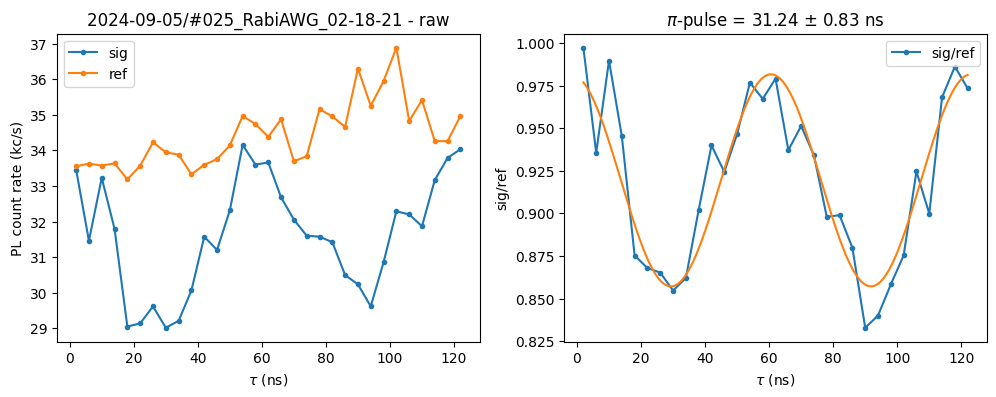

In [1040]:
# Rabi
month = 9; days=np.linspace(1,5,5)
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-0'+str(month)+'-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'RabiAWG' in dataFolder:
            idx = int(dataFolder[1:4])
            if day == 5 and idx >= 96:
                datafile = mainFolder + dataFolder +'/RabiAWGObject_sig_set.dat'

                guess=(0.2, 34, 0, 0.9, 600)
                sig, ref, popt, perr, x_s = dr.readData(datafile, type='RabiDecay', ifFit=1, guess=guess)

In [558]:
# Rabi
days = np.linspace(1,4,4)
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-09-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'RabiAWG' in dataFolder:
            idx = int(dataFolder[1:4])
            if (day == 4 and idx >= 4 and idx <= 7):
                datafile = mainFolder + dataFolder +'/RabiAWGObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                
                xPlot = x_s
                contrast = sig/ref
                dataArr.append(contrast)

dataArr = np.array(dataArr)
# # Reshape the array to have two rows for each sum
# reshaped_array = dataArr.reshape(-1, 2, dataArr.shape[1])
# # Sum the consecutive 2 rows
# dataArr = np.sum(reshaped_array, axis=1)/2

# fig, ax = plt.subplots(figsize=(4,3))
# N_datasets = np.size(dataArr,0)
# y = np.linspace(1,N_datasets, N_datasets)
# X, Y = np.meshgrid(xPlot, y)
# plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
# fig.colorbar(plot, orientation='vertical')

Text(0.5, 1.0, '$\\pi$-pulse = 29.78 $\\pm$ 0.50 ns')

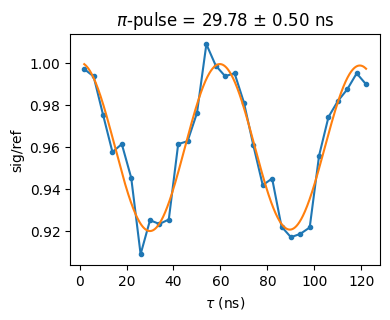

In [559]:
y = np.average(dataArr, axis=0)
x = xPlot

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(x,y, 'o-', markersize=3, label="sig/ref")
ax.set_ylabel('sig/ref')
ax.set_xlabel(r"$\tau$ (ns)")
# ax.set_xlim((0,100))

guess=(0.2, 34, 0, 0.9, 600)

xfit, yfit, popt, perr = dr.fitSinusoidDecay(x, y, guess=guess)
ax.plot(xfit, yfit, color='C1')
ax.set_title('$\pi$-pulse = %.2f $\pm$ %.2f ns' % (popt[1], perr[1]))

In [ ]:
fig,ax=plt.subplots(figsize=(4,3))
y1 = (-1)*np.array((350,372,386,405,419,335,312,291,255))
x1 = np.array((280,286,292,300,304, 267,257,247,232))
y2 = (-1)*np.array((439,465,483,514,))
x2 = np.array((307,307,304,302))

y1 = (-1)*np.array((-28,15,70,118,155,200))
x1 = np.array((-6,18,56,87,111,119))
y2 = (-1)*np.array((200,249,295,340,383))
x2 = np.array((119,114,118,107,101))
ax.scatter(x1,y1)
ax.scatter(x2,y2)
# if y <= -0.42, xBN <= 0.305
# else xBN <= -0.45*y1 + 0.116
xfit, yfit, popt, perr = dr.fitLinear(y1,x1) 
print(popt[0]); print(popt[1]/1e3)
# ax.scatter(-0.454*y1 + 116.3, y1)
ax.scatter(popt[0]*y1 + popt[1], y1)

xfit2, yfit2, popt2, perr2 = dr.fitLinear(y2,x2)
print(popt2[0]); print(popt2[1]/1e3)
ax.scatter(popt2[0]*y2 + popt2[1], y2)

# Pulsed ODMR

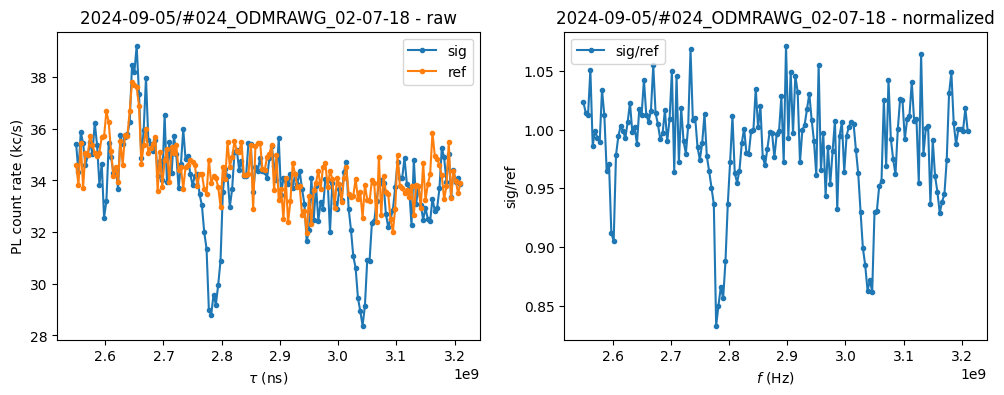

In [1036]:
# ODMR
type = 'ODMRAWG'
month = 9; days=np.linspace(1,5,5)
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-0'+str(month)+'-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if type in dataFolder:
            idx = int(dataFolder[1:4])
            if day == 5 and (idx >= 24):
                datafile = mainFolder + dataFolder +'/' + type + 'Object_sig_set.dat'
                guess=(-2e6, 2.84e9, 0.02e9, 1)
                sig, ref, popt, perr, x_s = dr.readData(datafile, type='ODMR', ifFit=0, guess=guess,typeNorm=0)

In [1470]:
# # Bext = 1530; conv = (2*0.028*1e6)
# # guess = (-1e5, 2830e6, 25e6, -1e5, 2853e6, 25e6, -1e5, 2910e6, 25e6, -1e5, 2933e6, 25e6, 1.1)
# # xfit, yfit, popt, perr = dr.fitLorFour(x_s, sig/ref, guess=guess, lowerBounds=None, upperBounds=None)
# # s1 = '$f_1$ = %.2f $\pm$ %.2f MHz, $f_2$ = %.2f $\pm$ %.2f MHz' % (popt[7]/1e6, perr[7]/1e6, popt[4]/1e6, perr[4]/1e6)
# # s2 = '$B_{ext}$ = %.0f $\mu$T, $B - B_{ext}$ = %.0f $\pm$ %.0f $\mu$T' % (Bext, np.abs(popt[4]-popt[7])/conv-Bext, np.sqrt(perr[7]**2 + perr[4]**2)/conv)

# # Bext = 1431; conv = (2*0.028*1e6)
# # guess = (-1e5, 2875e6, 15e6, 1.1)
# # xfit, yfit, popt, perr = dr.fitLor(x_s, sig/ref, guess=guess, lowerBounds=None, upperBounds=None)
# # s1 = '$f_1$ = %.2f $\pm$ %.2f MHz' % (popt[1]/1e6, perr[1]/1e6)
# # print(popt)

# Bext = 1369.3; conv = (2*0.028*1e6)
# guess = (-1e5, 2842e6, 15e6, -1e5, 2919e6, 15e6,  1.1)
# xfit, yfit, popt, perr = dr.fitLorTwo(x_s, sig/ref, guess=guess, lowerBounds=None, upperBounds=None)
# s1 = '$f_1$ = %.2f $\pm$ %.2f MHz, $f_2$ = %.2f $\pm$ %.2f MHz' % (popt[1]/1e6, perr[1]/1e6, popt[4]/1e6, perr[4]/1e6)
# s2 = '$B_{ext}$ = %.0f $\mu$T, $B - B_{ext}$ = %.0f $\pm$ %.0f $\mu$T' % (Bext, np.abs(popt[4]-popt[1])/conv-Bext, np.sqrt(perr[1]**2 + perr[4]**2)/conv)
# print(popt)

# fig, ax = plt.subplots(figsize=(6,2))
# ax.plot(x_s/1e6, sig/ref, 'o-',markersize=3, )
# ax.plot(xfit/1e6,yfit)
# ax.set_title(s1 + '\n' + s2, fontsize=10);
# ax.set_xlabel('Frequency (MHz)')
# # ax.set_title(s1, fontsize=10);
# # ax.set_xlim(2830e6,2850e6)

### Repeated pulsed ODMR

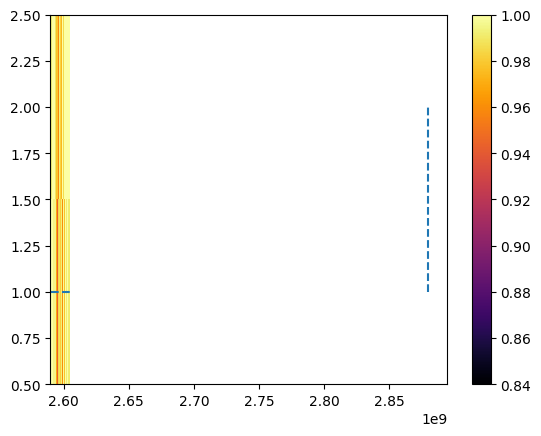

In [211]:
# ODMR
days = np.linspace(1,3,3)
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-09-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'ODMR' in dataFolder:
            idx = int(dataFolder[1:4])
            if (day==3 and idx >= 67 and idx <= 68):
            # if day==3 and idx == 62:
                datafile = mainFolder + dataFolder +'/ODMRAWGObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                xPlot = x_s
                contrast = sig/ref
                # contrast = smooth(contrast,n=3)
                dataArr.append(contrast)

dataArr = np.array(dataArr)

fig, ax = plt.subplots()#figsize=(10,10))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(xPlot, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')
plot.set_clim(0.84,1.0)

ax.vlines(x=f0, ymin=min(y), ymax=max(y), linewidth=1.5, linestyle='--')
for i in range(N_datasets):
    if np.mod(i,5) == 0:
        ax.hlines(y=i+1, xmin=min(xPlot), xmax=max(xPlot), linewidth=1.5, linestyle='--')
    # if np.mod(i,12) == 6:
    #     ax.hlines(y=i+1, xmin=min(xPlot), xmax=max(xPlot), linewidth=0.7, linestyle='--', color='red')

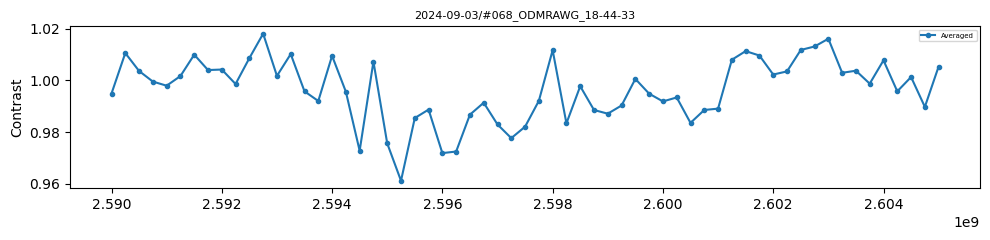

In [212]:
y = y6 = np.average(dataArr, axis=0)
x = x6 = xPlot

fig, ax = plt.subplots(figsize=(10,2.5))
ax.plot(x,y, label="Averaged", linestyle='-', marker='o', markersize=3,)
ax.set_ylabel('Contrast')
# ax.vlines(x=2.952e9, ymin=min(y), ymax=max(y), linestyle='--', color='red')
ax.legend(fontsize=5)
# ax.set_xlim((2.56e9,2.8e9))
ax.set_title(datafile[31:63],fontsize=8)

plt.tight_layout()

0.8443812233285928


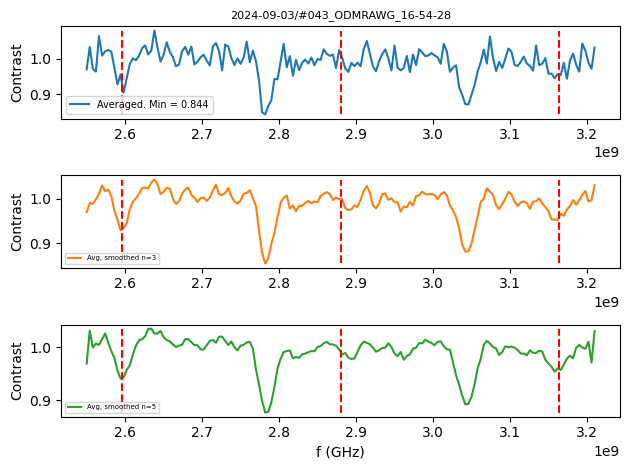

In [159]:
y = y6 = np.average(dataArr, axis=0)
x = x6 = xPlot

fig, axs = plt.subplots(3,1)
axs[0].plot(x,y, label="Averaged. Min = %.3f" % (min(y)))
axs[0].set_ylabel('Contrast')
axs[0].vlines(x=f0, ymin=min(y), ymax=max(y), linestyle='--', color='red')
peak = 2.596e9
axs[0].vlines(x=peak, ymin=min(y), ymax=max(y), linestyle='--', color='red')
axs[0].vlines(x=peak + 2*(f0-peak), ymin=min(y), ymax=max(y), linestyle='--', color='red')
axs[0].legend(fontsize=7)

ys3 = smooth(y,n=3)
axs[1].plot(x, ys3, label="Avg, smoothed n=3", color='C1')
axs[1].set_ylabel('Contrast')
axs[1].vlines(x=f0, ymin=min(ys3), ymax=max(ys3), linestyle='--', color='red')
axs[1].vlines(x=peak, ymin=min(ys3), ymax=max(ys3), linestyle='--', color='red')
axs[1].vlines(x=peak + 2*(f0-peak), ymin=min(ys3), ymax=max(ys3), linestyle='--', color='red')
axs[1].legend(fontsize=5)

ys5 = smooth(y,n=5)
axs[2].plot(x,ys5, label="Avg, smoothed n=5", color='C2')
axs[2].set_ylabel('Contrast')
axs[2].vlines(x=f0, ymin=min(ys5), ymax=max(ys5), linestyle='--', color='red')
axs[2].vlines(x=peak, ymin=min(ys5), ymax=max(ys5), linestyle='--', color='red')
axs[2].vlines(x=peak + 2*(f0-peak), ymin=min(ys5), ymax=max(ys5), linestyle='--', color='red')
axs[2].set_xlabel('f (GHz)')
axs[2].legend(fontsize=5)

axs[0].set_title(datafile[31:63],fontsize=8)
plt.tight_layout()
print(min(y))

### Resolving hyperfine peaks

2.2280483413414953
2.144010018048763


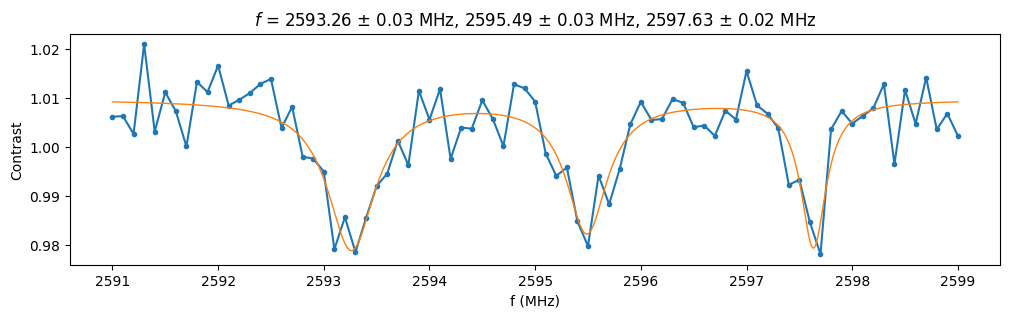

In [1524]:
y = np.average(dataArr, axis=0)
x = np.array(x_s)
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(x/1e6,y, 'o-', markersize=3,)
ax.set_xlabel('f (MHz)')
ax.set_ylabel('Contrast')
# ax.set_xlim((2750,2850))
# ax.vlines(x=2880, ymin=min(y), ymax=max(y), linestyle='--', color='r')

guess = (-4e3, 2593.5e6, 0.2e6, -1e3, 2595.5e6, 0.2e6, -1e3, 2597.5e6, 0.2e6, 1)
lowerBounds = (-6e3,1e9,0,   -20e3,1e9,0, -20e3,1e9,0, 0)
upperBounds = (0,4e9,1e6,     0,4e9,1e6,   0,4e9,1e6, 2)
xfit, yfit, popt, perr = dr.fitLorThree(x, y, guess=guess, lowerBounds=lowerBounds, upperBounds=upperBounds)
ax.plot(xfit/1e6, yfit, color='C1', linewidth=1)
ax.set_title("$f$ = %.2f $\pm$ %.2f MHz, %.2f $\pm$ %.2f MHz, %.2f $\pm$ %.2f MHz" % 
             (popt[1]/1e6, perr[1]/1e6, popt[4]/1e6, perr[4]/1e6, popt[7]/1e6, perr[7]/1e6))
print((popt[4]-popt[1])/1e6)
print((popt[7]-popt[4])/1e6)

# threshold = 0.96
# peaks = find_peaks(-y, threshold=-threshold)
# xpeaks = x[peaks]/1e6

# # ax.vlines(x=popt[1], ymin=min(y), ymax=max(y), linestyle='--', color='r')
# # ax.vlines(x=xpeaks[0], ymin=min(y), ymax=max(y), linestyle='--', color='r', linewidth=0.4)
# # ax.vlines(x=xpeaks[1], ymin=min(y), ymax=max(y), linestyle='--', color='g', linewidth=0.4)
# # ax.vlines(x=xpeaks[2], ymin=min(y), ymax=max(y), linestyle='--', color='b', linewidth=0.4)

In [ ]:
# fittedPeaks = np.array((np.round(popt[1]/1e6,3),np.round(popt[4]/1e6,3),np.round(popt[7]/1e6,3),np.round(popt[10]/1e6,3)))
# linewidths = np.array((np.round(popt[2]/1e3,2),np.round(popt[5]/1e3,2),np.round(popt[8]/1e3,2),np.round(popt[11]/1e3,2)))
fittedPeaks = np.array((np.round(popt[1]/1e6,3),np.round(popt[4]/1e6,3),np.round(popt[7]/1e6,3)))
linewidths = np.array((np.round(popt[2]/1e3,2),np.round(popt[5]/1e3,2),np.round(popt[8]/1e3,2)))
print(xpeaks)
print("Fitted peaks (MHz)", fittedPeaks)
print("Deviation from drive (MHz)", np.abs(2950-fittedPeaks))
print("Linewidths (kHz)", linewidths)

# Confocal ODMR

In [87]:
dataArr = []; ifSingleGreenRead=1
# month = 5; days = np.linspace(1,31,31)
month = 6; days = np.linspace(1,12,12)
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-0'+str(month)+'-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        type = 'ConfocalODMRAWGFast'
        if type in dataFolder:
            idx = int(dataFolder[1:4])
            # if (day==2 and idx >= 42 and idx <= 46): # (trivial)
            # if day==4 and idx==8: # (trivial) first Rabi-calib scan
            # if day==8 and idx>=9 and idx<=10: # (trivial) rough differential msmt edge 1
            # if day==9 and idx <=5: # (trivial) bare diamond reference

            # if day==3 or (day==4 and idx == 1): # 2D map
            # if (day==5 and idx == 17) or (day==6 and idx <= 2): # 1D scan
            # if (day==6 and idx >= 6 and idx <=11): # rescan near edge 2
            # if (day==7 and idx <= 23): # rescan near edge 1 after magnet alignment
            # if (day==7 and idx >= 24 and idx <= 31): # rescan near edge 2 after magnet alignment
            # if day==8 and idx >= 25 and idx <= 31: # good diff msmt edge 1
            # if day==9 and idx>=6 and idx <= 9: # diff msmt edge 3
            # if day==9 and idx>=10 and idx <= 14: # diff msmt edge 1 extending DS25-31 a bit more
            # if (day==11 and idx <= 27): # line scan FGT
            # if day==11 and idx <= 28: # line scan FGT copy
            # if day==12 and idx == 3: # line scan FGT
            # if day==12 and (idx == 3 or idx == 5): # line scan FGT copy
            # if (day==14 and idx<=2) or (day==14 and idx==3): # 2D
            # if (day==16 and idx == 32): # Failed 2D map for FGT field cooling
            # if (day==17 and idx == 35): # 1D FGT field cooling
            # if (day==17 and idx == 38): # 2D FGT field cooling fine
            # if (day==20 and idx == 4): # 2D FGT field cooling coarse
            # if (day==20 and idx == 20) or (day==21) or (day==22 and idx==1): # 2D UOTe field cooling coarse
            # if day==22 and idx >= 13 and idx <= 15: # 2D UOTe FC left
            # if (day==22 and idx == 21) or (day==23 and idx<=2): # 2D UOTe FC right
            # if (day==23 and idx >=4 and idx<=8): # 2D UOTe FC top
            # if (day==23 and idx == 10) or (day==24 and idx <= 2): # 2D UOTe FC fine
            # if (day==23 and idx >= 11 and idx <= 13): # 2D UOTe FC top
            # if (day==25 and idx>=14) or (day==26 and idx <= 2): #2D UOTe fine FC2
            # if (day==27 and idx==29): #2D FGT fine FC2
            # if (day==31 and idx==14): # 2D UOTe fine FC2 75K   
            # if (day==3 and idx==23): # FGT coarse in BN (DS21,23) or FGT (DS22) at 115 K 
            # if (day==5 and idx==12): # FGT FC1 coarse in BN (DS 11) or FGT (DS 12) at 130 K 
            # if (day==5 and idx==18): # FGT FC1 coarse in BN (DS 18) or FGT (DS 19) at 100 K 
            # if (day==7 and idx==6): # FGT FC1 coarse in BN (DS 5) or FGT (DS 6) at 50 K 
            # if (day==7 and idx==14): # FGT FC1 coarse in BN (DS 13) or FGT (DS 14) at 25 K 
            if (day==12 and idx==14):
                datafile = mainFolder + dataFolder + '/' + type + 'Object_y_set_'+type+'Object_x_set_'+type+'Object_sig_set - Copy.dat'
                x,y,freq,sig,ref = dr.readDataConfocalODMR(datafile, freqSplitFactor=1)
                sig = np.array(sig); ref = np.array(ref); contrast = sig/ref
                x = np.array(x); y = np.array(y)
                (ny,nx,nfreq) = np.shape(sig)
                # if ifSingleGreenRead==1:
                #     maxsig = np.max(sig-ref,axis=2)
                #     for j in range(ny):
                #         for i in range(nx):
                #             contrast[j,i] = sig[j,i] - maxsig[j,i]
                #             contrast[j,i] = contrast[j,i]/ref[j,i]
                dataArr.append(contrast)
dataArr = np.array(dataArr); print(np.shape(dataArr))
dataArr = np.average(dataArr, axis=0)


(1, 1, 19, 56)


In [16]:
freqmins = -1e11*np.ones((ny,nx)); freqerrs = np.zeros((ny,nx))
convfactor = 2*0.028*1e6; conv_voltage=10; ifDifferential=1; Bext=1700; errTolerance = np.inf#10#

lowerBounds = (-np.inf,-np.inf,4.99e6,-np.inf,-np.inf,4.99e6,-np.inf)
lowerBounds2 = (-np.inf,-np.inf,4.99e6,-np.inf,2.91e9,4.99e6,-np.inf)
upperBounds2 = (0,2.84e9,np.inf,0,np.inf,np.inf,np.inf)

def doException():
    xfit = freq[j,i]; yfit = dataArr[j,i]
    popt = np.array((-1, -1,-1,-1,  1,-1,-1))*1e9
    perr = np.array((1e9,1e9,1e9,1e9,1e9,1e9,1e9))*1e3
    print("Cannot fit " + label)
    return xfit, yfit, popt, perr

In [17]:
imarker = 200
for j in range(ny):
    for i in range(nx):
        label = 'x = %.3f, y = %.3f' % (x[j,i,0], y[j,i,0])
        # freqmin = freq[j,i,np.argmin(dataArr[j,i])]
        # freqmins[j,i] = freqmin
        if ifDifferential==0:
            guess = (-1e5, freq[j,i,np.argmin(dataArr[j,i])], 10e6, 1); lowerBounds=None; upperBounds=None
            xfit, yfit, popt, perr = dr.fitLor(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=upperBounds)
            freqmins[j,i] = popt[1]; freqerrs[j,i] = perr[1]
        else:
            # guess = (-1e5, 2843e6, 5e6, -1e5, 2925e6, 5e6, 1); lowerBounds=None; upperBounds=None
            # xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=upperBounds)
            # freqmins[j,i] = popt[4]-popt[1]; freqerrs[j,i] = np.sqrt(perr[4]**2 + perr[1]**2)
#             try:
#                 guess = (-1e5, 2780e6, 5e6, -1e5, 3000e6, 5e6, 1); lowerBounds=lowerBounds; upperBounds=None
#                 xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=upperBounds)
#                 if np.abs(freq[j,i][np.argmin(dataArr[j,i])]-f0) < 70e6:
#                     guess = (-1e5, 2830e6, 15e6, -1e5, 2930e6, 15e6, 1); lowerBounds=lowerBounds; upperBounds=None
#                     xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=upperBounds)
#             except Exception as e:
#                 xfit, yfit, popt, perr = doException()
# ########################################
            if np.abs(freq[j,i][np.argmin(dataArr[j,i])]-f0) < 30e6:
                try:
                    guess = (-1e5, 2870e6, 15e6, -1e5, 2890e6, 15e6, 1)
                    # if i==64: guess = (-1e5, 2810e6, 15e6, -1e5, 2950e6, 15e6, 1)
                    xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=None)
                except Exception as e:
                    try:
                        guess = (-1e5, 2780e6, 25e6, -1e5, 2980e6, 25e6, 1)
                        xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds2, upperBounds=upperBounds2)
                    except Exception as e:
                        xfit, yfit, popt, perr = doException()
            else:
                try:
                    guess = (-1e5, 2840e6, 5e6, -1e5, 2920e6, 5e6, 1)
                    xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=None)
                    if np.max((np.abs(popt[1]-f0),np.abs(popt[4]-f0))) > 60e6:
                        try:
                            guess = (-1e5, 2780e6, 25e6, -1e5, 2980e6, 25e6, 1)
                            xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds2, upperBounds=upperBounds2)
                        except Exception as e:
                            xfit, yfit, popt, perr = doException()
                except Exception as e:
                    xfit, yfit, popt, perr = doException()

            err = np.abs(np.sum(perr/popt))
            if err <= errTolerance:
                freqmins[j,i] = np.abs(popt[4]-popt[1]); freqerrs[j,i] = np.sqrt(perr[4]**2 + perr[1]**2)

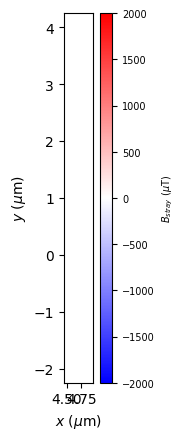

In [18]:
# 2D       
X = x[:,:,0]*conv_voltage; Y = y[:,:,0]*conv_voltage
fig, ax = plt.subplots()
if ifDifferential==0:
    #####   Single resonance, f- or f+   #########
    plot = ax.pcolormesh(X,Y, (freqmins- np.average(freqmins))/convfactor, cmap='bwr') #
else:
    # #####   Differential, independent scans of f- and f+   #########
    # fminus = freqmins[rowidx][::2]; fplus = freqmins[rowidx][1::2]
    # deltaf = fplus-fminus; meanDeltaf = np.average(deltaf)
    # fminuserrs = freqerrs[rowidx][::2]; fpluserrs = freqerrs[rowidx][1::2]#0*
    # plot = ax.errorbar(xplot , (deltaf - meanDeltaf)/convfactor, np.sqrt(fminuserrs**2+fpluserrs**2)/convfactor,
    #                 fmt='o', color='blue', markersize=3, capsize=5, capthick=0.5, ecolor='red', elinewidth=1);

    #####   Differential, single scan that has both f- and f+   #########
    meanDeltaf = Bext*convfactor #1431 #81948173.46995163#np.average(freqmins[rowidx])
    dataPlot = (freqmins - meanDeltaf)/convfactor
    plot = ax.pcolormesh(X,Y, dataPlot, cmap='bwr');
    
ax.set_aspect(1)
# plot = ax.pcolormesh(X,Y, np.min(dataArr,axis=2), cmap='inferno')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = fig.colorbar(plot, cax = cax)
cbar.ax.tick_params(labelsize=7)
cbar.set_label('$B_{stray}$ ($\mu$T)', fontsize=7)
plot.set_clim(-2000,2000)

ax.set_xlabel('$V_x$ (V)')
ax.set_ylabel('$V_y$ (V)')

ax.set_xlabel('$x$ ($\mu$m)')
ax.set_ylabel('$y$ ($\mu$m)')
# sp = 0.025*conv_voltage
# for j in range(ny):
#     for i in range(nx):
#         if dataPlot[j,i] < -10000:
#             ax.add_patch(plt.Rectangle((X[0][i]-sp/2, Y[j][0]-sp/2), sp, sp, color='black'))

plt.tight_layout;

In [19]:
# a = Bext+np.average(dataPlot[:,0:2]); b = Bext+np.average(dataPlot[:,-2:])
# print(a)
# print(b)
# print(a-b)

print(Bext+np.average(dataPlot))

1826.9608370490375


In [10]:
rowidx = 9; errTolerance = np.inf; Bext=1700
freqmins = -1e11*np.ones((ny,nx)); freqerrs = np.zeros((ny,nx))
convfactor = 2*0.028*1e6; ifDifferential=1

mid = 2781645196.9597583 # Long 1D scan 240505 DS17 to 240506 DS2
# mid = 2840721239.1147146 #240507 17-23
# mid = 2842.93e6 

lowerBounds = (-np.inf,-np.inf,4.99e6,-np.inf,-np.inf,4.99e6,-np.inf)
lowerBounds2 = (-np.inf,-np.inf,4.99e6,-np.inf,2.91e9,4.99e6,-np.inf)
upperBounds2 = (0,2.84e9,np.inf,0,np.inf,np.inf,np.inf)

def doException():
    xfit = freq[j,i]; yfit = dataArr[j,i]
    popt = np.array((-1,-1,-1,-1,1,-1,-1))*1e9
    perr = np.array((1e9,1e9,1e9,1e9,1e9,1e9,1e9))*1e12
    print("Cannot fit " + label)
    return xfit, yfit, popt, perr

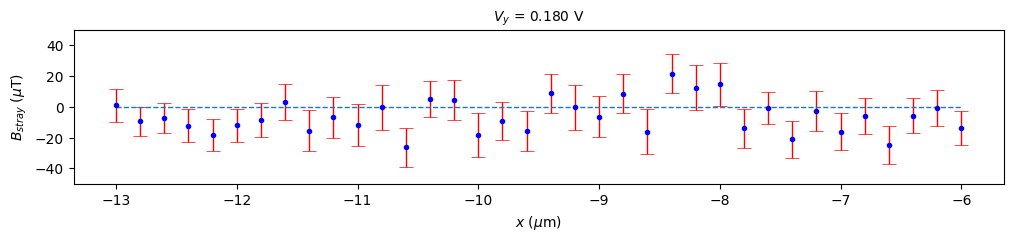

In [39]:
for j in range(ny):
    for i in range(nx):
        label = 'x = %.3f, y = %.3f' % (x[j,i,0], y[j,i,0])
        # freqmin = freq[j,i,np.argmin(dataArr[j,i])]
        # freqmins[j,i] = freqmin
        
        if ifDifferential==0:
            guess = (-1e5, freq[j,i,np.argmin(dataArr[j,i])], 10e6, 1)
            xfit, yfit, popt, perr = dr.fitLor(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=None, upperBounds=None)
            freqmins[j,i] = popt[1]; freqerrs[j,i] = perr[1]
        else:
            # guess = (-1e5, 2843e6, 5e6, -1e5, 2925e6, 5e6, 1)
            # xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=None, upperBounds=None)
            # freqmins[j,i] = popt[4]-popt[1]; freqerrs[j,i] = np.sqrt(perr[4]**2 + perr[1]**2)
# ###################################################
#             try:
#                 guess = (-1e5, 2840e6, 5e6, -1e5, 2920e6, 5e6, 1)
#                 xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=None)
#                 if np.abs(freq[j,i][np.argmin(dataArr[j,i])]-f0) < 30e6:
#                     guess = (-1e5, 2870e6, 15e6, -1e5, 2890e6, 15e6, 1)
#                     xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=None)
#             except Exception as e:
#                 xfit, yfit, popt, perr = doException()
# ######################################################
            # try:
            #     guess = (-1e5, 2840e6, 5e6, -1e5, 2920e6, 5e6, 1.15)
            #     xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=None)
            #     if np.max((np.abs(popt[1]-f0),np.abs(popt[4]-f0))) > 60e6:
            #         guess = (-1e5, 2780e6, 25e6, -1e5, 2980e6, 25e6, 1.15)
            #         xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds2, upperBounds=upperBounds2)
            #     if np.abs(freq[j,i][np.argmin(dataArr[j,i])]-f0) < 30e6:
            #         guess = (-1e5, 2870e6, 15e6, -1e5, 2890e6, 15e6, 1.15)
            #         xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=None)              
            # except Exception as e:
                # xfit, yfit, popt, perr = doException()
######################################################
            if np.abs(freq[j,i][np.argmin(dataArr[j,i])]-f0) < 30e6:
                try:
                    guess = (-1e5, 2870e6, 15e6, -1e5, 2890e6, 15e6, 1)
                    if i==64: guess = (-1e5, 2810e6, 15e6, -1e5, 2950e6, 15e6, 1)
                    xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=None)
                except Exception as e:
                    try:
                        guess = (-1e5, 2780e6, 25e6, -1e5, 2980e6, 25e6, 1)
                        xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds2, upperBounds=upperBounds2)
                    except Exception as e:
                        xfit, yfit, popt, perr = doException()
            else:
                try:
                    guess = (-1e5, 2840e6, 5e6, -1e5, 2920e6, 5e6, 1)
                    xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=None)
                    if np.max((np.abs(popt[1]-f0),np.abs(popt[4]-f0))) > 60e6:
                        try:
                            guess = (-1e5, 2780e6, 25e6, -1e5, 2980e6, 25e6, 1)
                            xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds2, upperBounds=upperBounds2)
                        except Exception as e:
                            xfit, yfit, popt, perr = doException()
                except Exception as e:
                    xfit, yfit, popt, perr = doException()

            err = np.abs(np.sum(perr/popt))
            if err <= errTolerance:
                freqmins[j,i] = np.abs(popt[4]-popt[1]); freqerrs[j,i] = np.sqrt(perr[4]**2 + perr[1]**2)
        
# 1D
fig, ax = plt.subplots(figsize=(12,2))

if ifDifferential==0:
    #####   Single resonance, f- or f+   #########
    plot = ax.errorbar(x[:,:,0][rowidx]*10, (freqmins[rowidx] - mid)/convfactor, freqerrs[rowidx]/convfactor,
                    fmt='o', color='blue', markersize=3, capsize=5, capthick=0.5, ecolor='red', elinewidth=1);
else:
    # #####   Differential, independent scans of f- and f+   #########
    # xplot = x[:,:,0][rowidx][::2]*10
    # fminus = freqmins[rowidx][::2]; fplus = freqmins[rowidx][1::2]
    # deltaf = fplus-fminus; meanDeltaf = np.average(deltaf)
    # fminuserrs = freqerrs[rowidx][::2]; fpluserrs = freqerrs[rowidx][1::2]#0*
    # plot = ax.errorbar(xplot , (deltaf - meanDeltaf)/convfactor, np.sqrt(fminuserrs**2+fpluserrs**2)/convfactor,
    #                 fmt='o', color='blue', markersize=3, capsize=5, capthick=0.5, ecolor='red', elinewidth=1);

    #####   Differential, single scan that has both f- and f+   #########
    xplot = x[:,:,0][rowidx]*10
    meanDeltaf = Bext*convfactor #1431 #81948173.46995163#np.average(freqmins[rowidx])
    yplot = (freqmins[rowidx] - meanDeltaf)/convfactor; yerr = (freqerrs[rowidx])/convfactor
    plot = ax.errorbar(xplot, yplot-0*1439, yerr,
                    fmt='o', color='blue', markersize=3, capsize=5, capthick=0.5, ecolor='red', elinewidth=1);
    # a = 58; b = None
    # plot = ax.errorbar(xplot[a:b], -yplot[a:b]-1*1439, yerr[a:b],
    #                     fmt='o', color='green', markersize=3, capsize=5, capthick=0.5, ecolor='red', elinewidth=1);
    # # plot = ax.errorbar(xplotOld , yplotOld, yerrOld,
    #                     fmt='o', color='blue', markersize=3, capsize=5, capthick=0.5, ecolor='red', elinewidth=1);
    
ax.set_xlabel('$V_x$ (V)'); ax.set_xlabel('$x$ ($\mu$m)')
ax.set_ylabel('$f_{NV}$ (MHz)'); ax.set_ylabel('$B_{stray}$ ($\mu$T)')
# ax.set_xlim((-13,0))
ax.set_ylim((-50,50))
ax.hlines(y=0,xmin=min(xplot),xmax=max(xplot),linewidth=1, linestyle='--')
ax.set_title('$V_y$ = %.3f V' % y[:,:,0][rowidx][0], fontsize=10)

plt.tight_layout;

# xplotOld = xplot; yplotOld = (freqmins[rowidx] - meanDeltaf)/convfactor; yerrOld = (freqerrs[rowidx])/convfactor

In [ ]:
fig, ax = plt.subplots(figsize=(4,7)); scaleForShift = 0.01
for j in range(ny):
    for i in range(nx):
        rawplot, = ax.plot(freq[j,i], dataArr[j,i] + scaleForShift*(j*nx+i), '-o',markersize=3, linewidth=0.8, label='x = %.3f, y = %.3f' % (x[j,i,0], y[j,i,0]))
        # guess = (-1e5, freq[j,i,np.argmin(dataArr[j,i])], 5e6, 1); lowerBounds=None; upperBounds=None
        # xfit, yfit, popt, perr = dr.fitLor(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=upperBounds)
        guess = (-1e5, 2843e6, 5e6, -1e5, 2925e6, 5e6, 1); lowerBounds=None; upperBounds=None
        # xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=upperBounds)
        # ax.plot(xfit, yfit + scaleForShift*(j*nx+i), color=rawplot.get_color(),linewidth=2)

ax.legend(fontsize=6,loc='upper left', bbox_to_anchor=(1, 1));

In [88]:
j = 0; i = 3; errTolerance = np.inf; Bext = 1381.4; conv = (2*0.028*1e6)
idxArray = np.linspace(0,i,i+1)

lowerBounds = (-np.inf,-np.inf,4.99e6,-np.inf,-np.inf,4.99e6,-np.inf)
lowerBounds2 = (-np.inf,-np.inf,4.99e6,-np.inf,2.91e9,4.99e6,-np.inf)
upperBounds2 = (0,2.84e9,np.inf,0,np.inf,np.inf,np.inf)

def doException():
    # ax.plot(freq[j,i], dr.lorTwo(freq[j,i], *guess))
    xfit = freq[j,i]; yfit = dataArr[j,i]
    popt = np.array((-1,-1,-1,-1,1,-1,-1))*1e9
    perr = np.array((1e9,1e9,1e9,1e9,1e9,1e9,1e9))*1e12
    print("Cannot fit " + label)
    return xfit, yfit, popt, perr

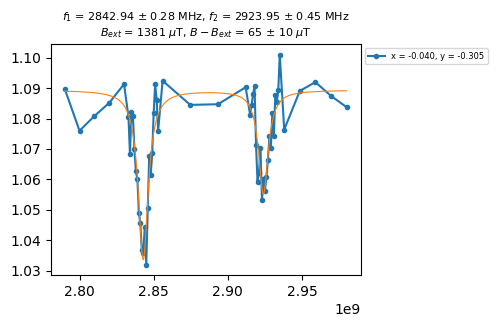

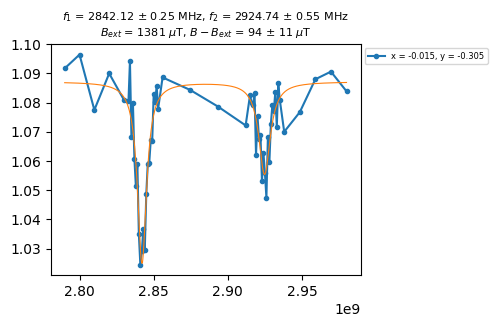

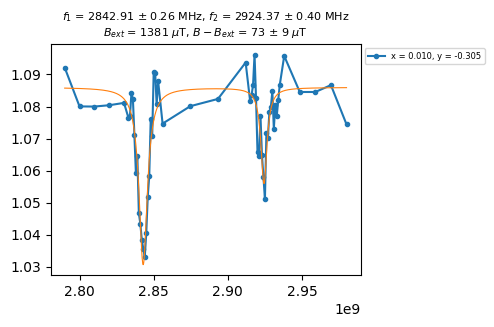

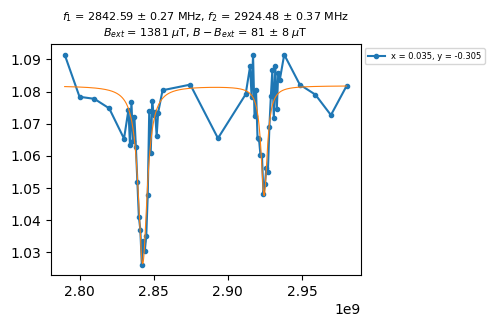

In [89]:
for i in idxArray:
    i = int(i)
    fig, ax = plt.subplots(figsize=(4,3))
    label = 'x = %.3f, y = %.3f' % (x[j,i,0], y[j,i,0])
    ax.plot(freq[j,i], dataArr[j,i], 'o-',markersize=3,  label=label)
    ax.legend(fontsize=6,loc='upper left', bbox_to_anchor=(1, 1))

    # guess = (-1e5, freq[j,i,np.argmin(dataArr[j,i])], 5e6, 1)
    # xfit, yfit, popt, perr = dr.fitLor(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=None, upperBounds=None)
    # ax.plot(xfit, yfit, linewidth=0.8)
    # ax.set_title('$f$ = %.2f $\pm$ %.2f MHz' % (popt[1]/1e6, perr[1]/1e6), fontsize=10);
#     try:
#         guess = (-1e5, 2840e6, 5e6, -1e5, 2920e6, 5e6, 1)
#         xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=None)
#         if np.abs(freq[j,i][np.argmin(dataArr[j,i])]-f0) < 30e6:
#             guess = (-1e5, 2870e6, 15e6, -1e5, 2890e6, 15e6, 1)
#             xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=None)
#     except Exception as e:
#         xfit, yfit, popt, perr = doException()
# # #################################################
#     try:
#         guess = (-1e5, 2840e6, 5e6, -1e5, 2920e6, 5e6, 1.15)
#         xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=None)
#         if np.max((np.abs(popt[1]-f0),np.abs(popt[4]-f0))) > 60e6:
#             guess = (-1e5, 2780e6, 25e6, -1e5, 2980e6, 25e6, 1.15)
#             xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds2, upperBounds=upperBounds2)
#         if np.abs(freq[j,i][np.argmin(dataArr[j,i])]-f0) < 30e6:
#             guess = (-1e5, 2870e6, 15e6, -1e5, 2890e6, 15e6, 1.15)
#             xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=None) 
#     except Exception as e:
#         xfit, yfit, popt, perr = doException()
# ##################################################

    if np.abs(freq[j,i][np.argmin(dataArr[j,i])]-f0) < 30e6:
        try:
            guess = (-1e5, 2870e6, 15e6, -1e5, 2890e6, 15e6, 1)
            # if i==51: guess = (-1e5, 2810e6, 15e6, -1e5, 2950e6, 15e6, 1)
            xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=None)
        except Exception as e:
            try:
                guess = (-1e5, 2780e6, 25e6, -1e5, 2980e6, 25e6, 1)
                xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds2, upperBounds=upperBounds2)
            except Exception as e:
                xfit, yfit, popt, perr = doException()
    else:
        try:
            guess = (-1e5, 2840e6, 5e6, -1e5, 2920e6, 5e6, 1)
            xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds, upperBounds=None)
            if np.max((np.abs(popt[1]-f0),np.abs(popt[4]-f0))) > 60e6:
                try:
                    guess = (-1e5, 2800e6, 25e6, -1e5, 2960e6, 25e6, 1)
                    xfit, yfit, popt, perr = dr.fitLorTwo(freq[j,i], dataArr[j,i], guess=guess, lowerBounds=lowerBounds2, upperBounds=upperBounds2)
                except Exception as e:
                    xfit, yfit, popt, perr = doException()
        except Exception as e:
            xfit, yfit, popt, perr = doException()
    
    err = np.abs(np.sum(perr/popt))
    if err > errTolerance:
        print(label + '. Bad fit: err =  ' + str(err))
    else:
        ax.plot(xfit, yfit, linewidth=0.8)
        # ax.set_xlim(2.8e9,2.96e9)
    # print(popt)
    # ax.set_ylim((1.08,1.18))
    s1 = '$f_1$ = %.2f $\pm$ %.2f MHz, $f_2$ = %.2f $\pm$ %.2f MHz' % (popt[1]/1e6, perr[1]/1e6, popt[4]/1e6, perr[4]/1e6)
    s2 = '$B_{ext}$ = %.0f $\mu$T, $B - B_{ext}$ = %.0f $\pm$ %.0f $\mu$T' % (Bext, np.abs(popt[4]-popt[1])/conv-Bext, np.sqrt(perr[1]**2 + perr[4]**2)/conv)
    ax.set_title( s1 + '\n' + s2, fontsize=8);

# T2E

[ 8.82905481e-02 -1.65648755e-02  5.16347559e+02]


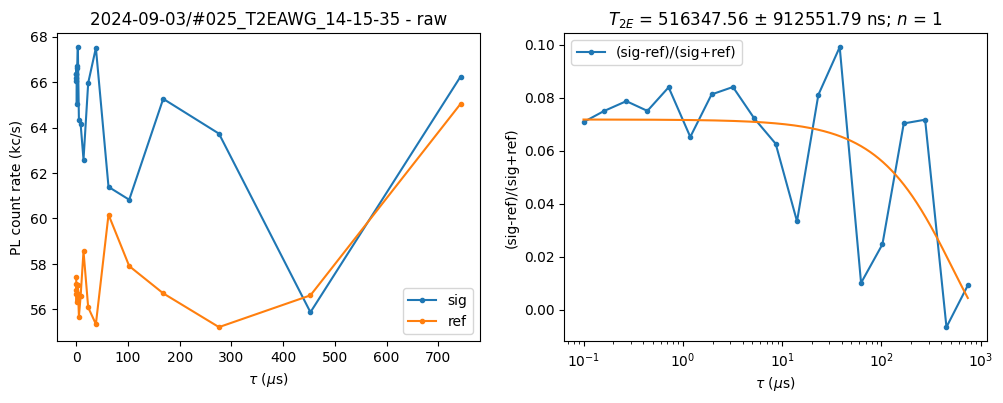

In [282]:
type = 'T2EAWG'
month = 9; days=np.linspace(1,3,3)
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-0'+str(month)+'-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if type in dataFolder:
            idx = int(dataFolder[1:4])
            if day==3 and idx == 25:
                datafile = mainFolder + dataFolder +'/T2EAWGObject_sig_set.dat'
                guess = (0.01, -0.002, 0.02)
                sig, ref, popt, perr, x_s = dr.readData(datafile, type='T2E', typeNorm=Q_FINAL, ifFit=1, 
                                                        guess=guess, ifLog=1)

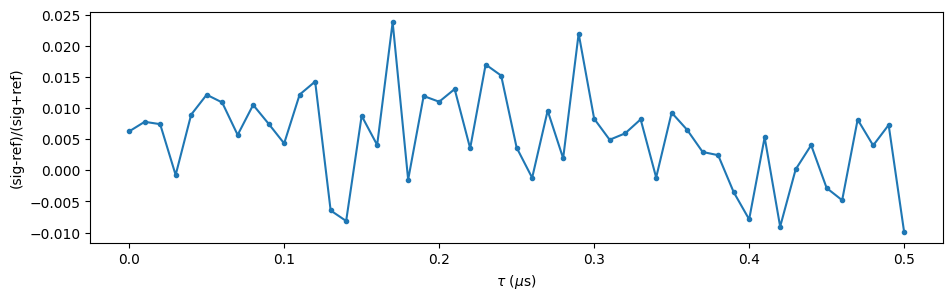

In [195]:
sorted_indices = np.argsort(x_s)
x_s = x_s[sorted_indices]
sig = sig[sorted_indices]
ref = ref[sorted_indices]

fig, ax = plt.subplots(figsize=(11,3))
x = x_s
y = (sig-ref)/(sig+ref)

# y = y[1001:1111]; x = x[1001:1111]
# y = smooth(y,45)
# y = average(y,3); x = average(x,3)

# y1 = smooth(y[0:1001],15); y2 = smooth(y[1001:1111],5); y3 = y[1111:]
# y = np.concatenate((y1,y2,y3))

y1 = average(y[0:1001],1); y2 = average(y[1001:1111],1); y3 = y[1111:]
x1 = average(x[0:1001],1); x2 = average(x[1001:1111],1); x3 = x[1111:]
y = np.concatenate((y1,y2,y3)); x = np.concatenate((x1,x2,x3))

ax.plot(x/1e3,y, 'o-', markersize=3,)
ax.set_xlabel(r"$\tau$ ($\mu$s)")
ax.set_ylabel('(sig-ref)/(sig+ref)')
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_ylim((3e-4,0.175))


guess = (0.11, 320, 1.5, 0)
# ax.plot(x/1e3, dr.strDecay(x/1e3, *guess),  'o-', markersize=3,color='C2')
# xfit, yfit, popt, perr = dr.fitStrDecay(x/1e3, y, guess=guess, 
#                                         lowerBounds=(0, 50, 0, -0.1), upperBounds=(1, 25000, 3, 0.1))
# ax.plot(xfit, yfit, color='C1')
# ax.set_title(r'$T_{2E}$ = %.2f $\pm$ %.2f $\mu$s; $n$ = %.2f $\pm$ %.2f' % (popt[1], perr[1], popt[2], perr[2]))

# ax.set_title(r'$T_{2E}$ = %.2f $\pm$ %.2f $\mu$s; $n$ = %.2f $\pm$ %.2f' % (popt[1], perr[1], popt[2], perr[2]))
# xfit = np.linspace(x[0], x[-1], 1001)
# yfit = dr.strDecay(xfit, *popt)
# ax.plot(xfit, yfit, color='C1')


In [ ]:
yfourier = np.fft.fft(y-np.average(y)); yfourier = np.abs(yfourier)
f = np.fft.fftfreq(len(y), 40e-9)/1e6

sorted_indices = np.argsort(f)       # Get the indices that would sort f
f = f[sorted_indices]                # Sort f in ascending order
yfourier = yfourier[sorted_indices]  # Reorder yfourier based on the sorted_indices

# Plot the signal and its Fourier Transform
fig, axs = plt.subplots(2,1, figsize=(12,6))
axs[0].plot(x/1e3,y, 'o-', markersize=3,)
axs[0].set_xlabel(r"$\tau$ ($\mu$s)")
axs[0].set_ylabel('(sig-ref)/(sig+ref)')

axs[1].plot(f, yfourier, linestyle='-', marker='o', markersize=3, color='C1')
axs[1].set_title('')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].set_ylabel('Fourier Transform')

threshold = 1.5
peaks = find_peaks(yfourier, threshold=threshold)
fpeaks = f[peaks]; fpeaks = fpeaks[int(len(fpeaks)/2):]
print(np.round(fpeaks*1e3,1))

axs[1].hlines(y=threshold, xmin=min(f), xmax=max(f), linestyle='--', linewidth = 1)
axs[1].set_xlim((-5,5))

plt.tight_layout()
plt.show()

### Repeated T2E

In [ ]:
# October T2E
days = np.linspace(26,26,1)
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-04-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'T2EAWG' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx >= 13 and idx <= 14:
                datafile = mainFolder + dataFolder +'/T2EAWGObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref); x_s = np.array(x_s)
                n = None
                x_s = x_s[0:n]; sig = sig[0:n]; ref = ref[0:n]
                sorted_indices = np.argsort(x_s)
                x_s = x_s[sorted_indices]
                sig = sig[sorted_indices]
                ref = ref[sorted_indices]
                contrast = (sig-ref)/(sig+ref)
                dataArr.append(contrast)

dataArr = np.array(dataArr)

fig, ax = plt.subplots()
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = ax.pcolormesh(X/1e3,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')
ax.set_xlabel('$\\tau$ ($\mu$s)')
ax.set_ylabel('Iters')

In [ ]:
y = np.average(dataArr, axis=0)
x = np.array(x_s)
fig, ax = plt.subplots()
ax.plot(x/1e3,y, 'o-', markersize=3)
# ax.set_xlim((0.9,1.1))
ax.set_xlabel('$\\tau$ ($\mu$s)')
ax.set_ylabel('(sig-ref)/(sig+ref)')

In [ ]:
yfourier = np.fft.fft(y-np.average(y)); yfourier = np.abs(yfourier)
f = np.fft.fftfreq(len(y), 20e-9)/1e6

sorted_indices = np.argsort(f)       # Get the indices that would sort f
f = f[sorted_indices]                # Sort f in ascending order
yfourier = yfourier[sorted_indices]  # Reorder yfourier based on the sorted_indices

# Plot the signal and its Fourier Transform
fig, axs = plt.subplots(2,1, figsize=(12,6))
axs[0].plot(x/1e3,y, 'o-', markersize=3,)
axs[0].set_xlabel(r"$\tau$ ($\mu$s)")
axs[0].set_ylabel('(sig-ref)/(sig+ref)')

axs[1].plot(f, yfourier, linestyle='-', marker='o', markersize=3, color='C1')
axs[1].set_title('')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].set_ylabel('Fourier Transform')
# axs[1].set_ylim((0,10))

def find_peaks(data, threshold=0):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1] and data[i] > threshold:
            peaks.append(i)
    return peaks

threshold = 0.4
peaks = find_peaks(yfourier, threshold=threshold)
fpeaks = f[peaks]; fpeaks = fpeaks[int(len(fpeaks)/2):]
print(np.round(fpeaks*1e3,1))

axs[1].hlines(y=threshold, xmin=min(f), xmax=max(f), linestyle='--', linewidth = 1)

plt.tight_layout()
plt.show()

# T2R

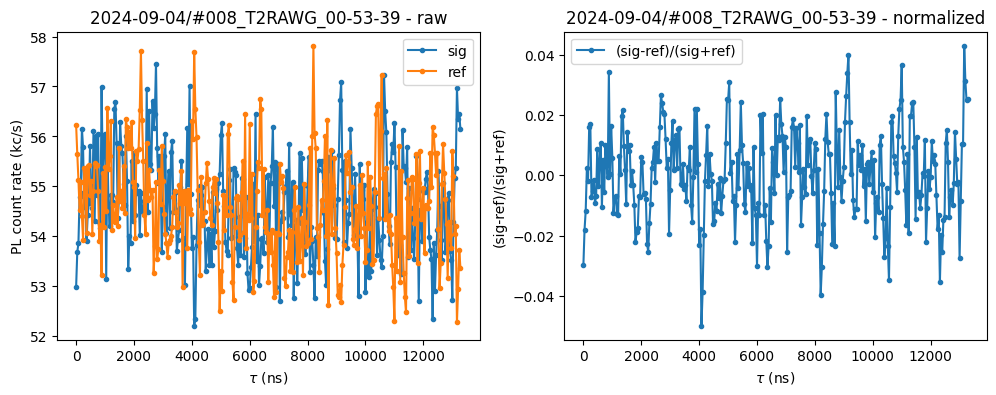

In [610]:
type = 'T2RAWG'
month = 9; days=np.linspace(1,4,4)
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-0'+str(month)+'-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if type in dataFolder:
            idx = int(dataFolder[1:4])
            if day==4 and idx == 8:
                datafile = mainFolder + dataFolder +'/T2RAWGObject_sig_set.dat'
                guess = (-0.01,17,0.1)
                sig, ref, popt, perr, x_s = dr.readData(datafile, type='T2R', typeNorm=Q_FINAL, ifFit=0, guess=guess)

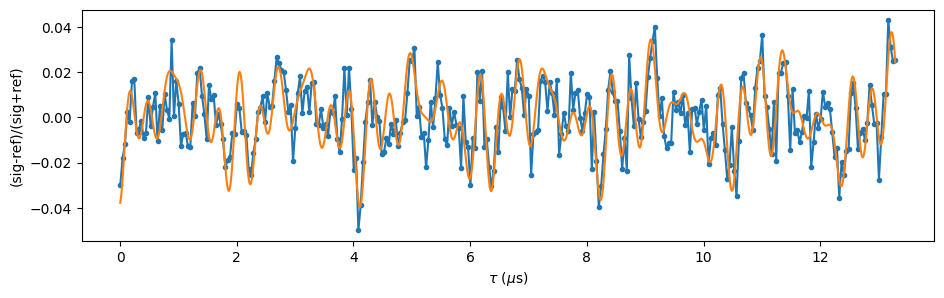

In [611]:
fig, ax = plt.subplots(figsize=(11,3))
x = x_s
y = (sig-ref)/(sig+ref)

ax.plot(x/1e3,y, 'o-', markersize=3,)
ax.set_xlabel(r"$\tau$ ($\mu$s)")
ax.set_ylabel('(sig-ref)/(sig+ref)')
# ax.set_yscale('log')
# ax.set_xscale('log')

guess = (0.05, 0.45, 0,    0.05, 1.73, 0,    0.05, 2.70, -pi,   0.05, 3.15, -pi, 0)
# ax.plot(x/1e3, dr.cosThree(x/1e3, *guess),  'o-', markersize=3,color='C2')
lowerBounds = (0.01,0,-pi,   0.01,0,-pi,   0.01,0,-pi,  0.01,0,-pi, -1)
upperBounds = (1,2, 7*pi,   1,4,6*pi,    1,4, 5*pi,  1,4, 5*pi, 1)
xfit, yfit, popt, perr = dr.fitCosFour(x/1e3, y, guess=guess, lowerBounds=lowerBounds)
ax.plot(xfit, yfit, color='C1')
# popt
# ax.set_title(r'$T_{2E}$ = %.2f $\pm$ %.2f $\mu$s; $n$ = %.2f $\pm$ %.2f' % (popt[1], perr[1], popt[2], perr[2]))
# ax.set_xlim((-0.1,10.1))

In [612]:
fittedPeaks = np.array((np.round(popt[1],4),np.round(popt[4],4),np.round(popt[7],4),np.round(popt[10],4)))
print("Fitted peaks (MHz)", fittedPeaks*1e3)

Fitted peaks (MHz) [ 486.6 1706.3 2679.1 3134.7]


[ 450.5 1726.7 2702.7 3153.2]


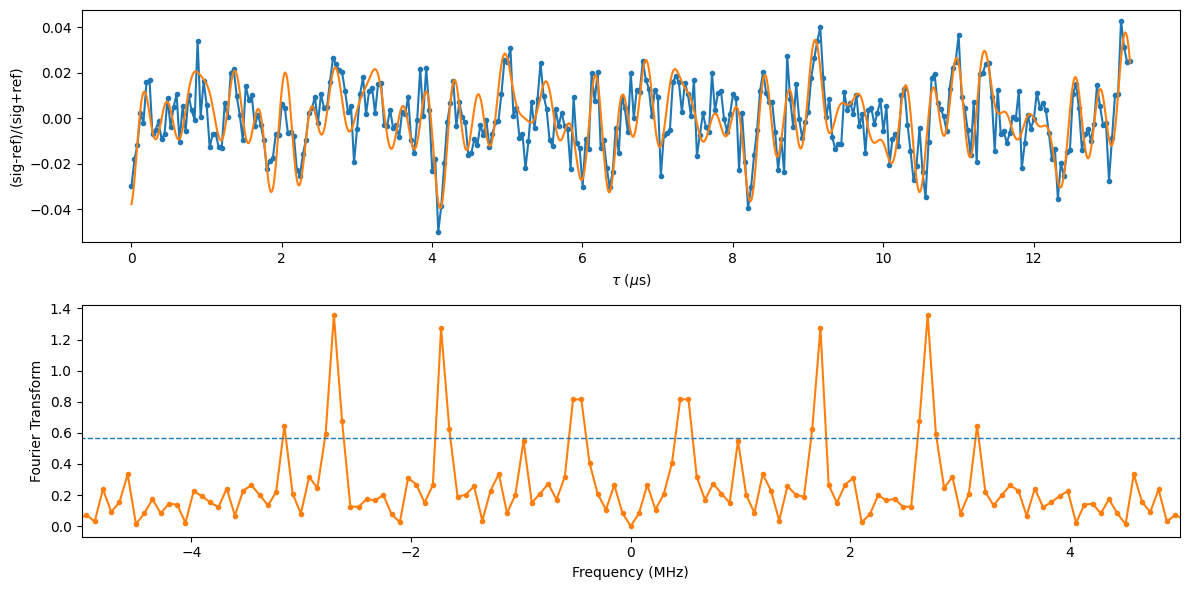

In [613]:
yfourier = np.fft.fft(y-np.average(y)); yfourier = np.abs(yfourier)
f = np.fft.fftfreq(len(y), 40e-9)/1e6

sorted_indices = np.argsort(f)       # Get the indices that would sort f
f = f[sorted_indices]                # Sort f in ascending order
yfourier = yfourier[sorted_indices]  # Reorder yfourier based on the sorted_indices

# Plot the signal and its Fourier Transform
fig, axs = plt.subplots(2,1, figsize=(12,6))
axs[0].plot(x/1e3,y, 'o-', markersize=3,)
axs[0].plot(xfit, yfit, color='C1')
axs[0].set_xlabel(r"$\tau$ ($\mu$s)")
axs[0].set_ylabel('(sig-ref)/(sig+ref)')

axs[1].plot(f, yfourier, linestyle='-', marker='o', markersize=3, color='C1')
axs[1].set_title('')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].set_ylabel('Fourier Transform')
axs[1].set_xlim((-5,5))

def find_peaks(data, threshold=0):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1] and data[i] > threshold:
            peaks.append(i)
    return peaks

threshold = 0.57
peaks = find_peaks(yfourier, threshold=threshold)
fpeaks = f[peaks]; fpeaks = fpeaks[int(len(fpeaks)/2):]
print(np.round(fpeaks*1e3,1))

axs[1].hlines(y=threshold, xmin=min(f), xmax=max(f), linestyle='--', linewidth = 1)

plt.tight_layout()
plt.show()

# T2R 4 point

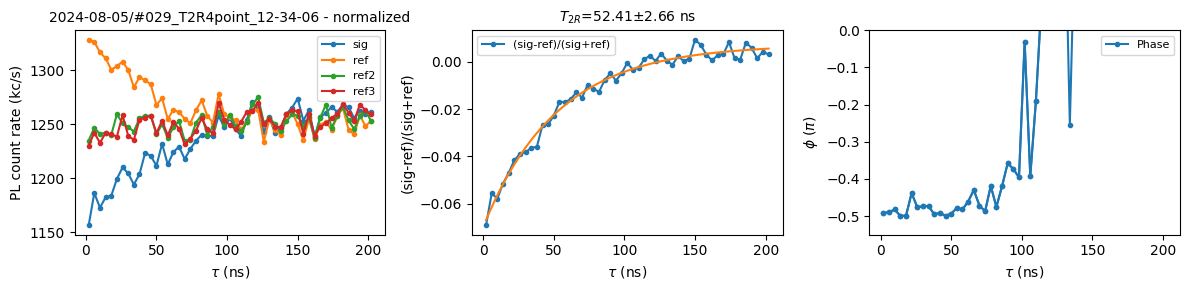

[-7.71108383e-02  7.28848902e-03  5.24110655e+01]


In [726]:
type = 'T2R4point'
month = 6; days=np.linspace(1,14,14)
# month = 7; days=np.linspace(1,3,3)
month = 8; days=np.linspace(1,5,5)
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-0'+str(month)+'-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if type in dataFolder:
            idx = int(dataFolder[1:4])
            if day==5 and idx == 29:
                datafile = mainFolder + dataFolder +'/' + type +'Object_sig_set.dat'
                guess = (-0.03, 0, 17); ifFit=1
                # guess = (-0.018, 200, 0, 0, 200); ifFit=2 #(t, A, Tpi, phi,C, T2)
                sig, ref, ref2,ref3,popt, perr, x_s = dr.readData4point(datafile, 
                                                       type='T2R', typeNorm=Q_FINAL, ifFit=ifFit, guess=guess)
                print(popt)

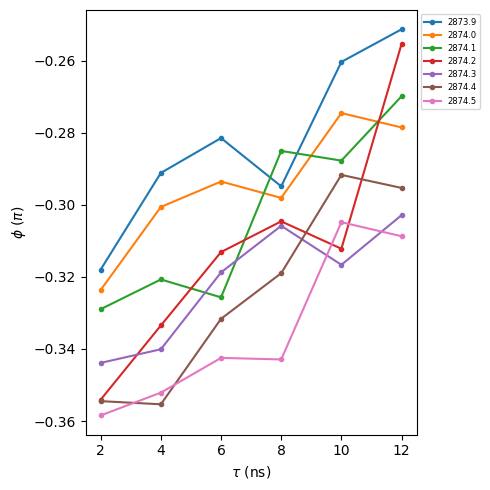

In [26]:
sigs = []; refs= []; xs = []; ref2s = []; ref3s = []
# freqs = np.linspace(2873.3e6, 2873.9e6, 7) #240702 DS 18-24
f = 2874.2e6; freqs = np.linspace(f-3e5, f+3e5, 7)
f = 2874.2e6; freqs = np.linspace(f-3e5, f+3e5, 7)
type = 'T2R4point'
month = 7; days=np.linspace(1,2,2)
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-0'+str(month)+'-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if type in dataFolder:
            idx = int(dataFolder[1:4])
            if day==2 and idx >= 34 and idx <= 40:
                datafile = mainFolder + dataFolder +'/T2R4pointObject_sig_set.dat'
                guess = (-0.03, 0, 17); ifFit=1
                guess = (-0.018, 200, 0, 0, 200); ifFit=0 #(t, A, Tpi, phi,C, T2)
                sig, ref, ref2, ref3, popt, perr, x_s = dr.readData4point(datafile, ifPlot=0,
                                                       type='T2R', typeNorm=Q_FINAL, ifFit=ifFit, guess=guess)
                sigs.append(sig); refs.append(ref); xs.append(x_s); ref2s.append(ref2); ref3s.append(ref3)

fig, ax = plt.subplots(figsize=(5,5))          
for i in range(len(sigs)):    
    phase = np.arctan((sigs[i]-refs[i])/(ref2s[i]-ref3s[i]))/np.pi
    for j, phi in enumerate(phase):
        if j >=15 and phi < 0:
            phase[j] = phi+1
    ax.plot(xs[i], phase,'o-', markersize=3,label=str(freqs[i]/1e6));
ax.set_ylabel('$\phi$ ($\pi$)')
ax.set_xlabel('$\\tau$ (ns)')

# ax.set_xlim((0,40))
# ax.set_ylim((-0.4,0))
ax.legend(loc='upper left', bbox_to_anchor=(1, 1),fontsize=6)
plt.subplots_adjust(right=0.75)
plt.tight_layout()


# T1

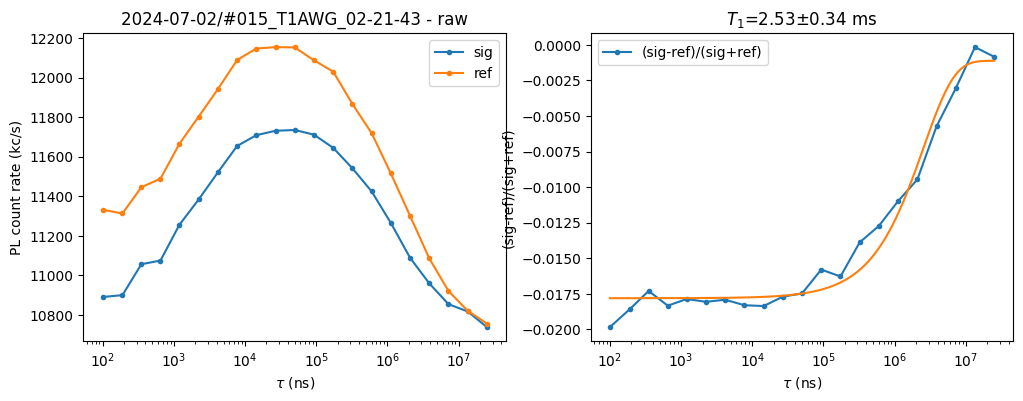

In [140]:
type = 'T1AWG'
month = 6; days=np.linspace(1,14,14)
month = 7; days=np.linspace(1,2,2)
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-0'+str(month)+'-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if type in dataFolder:
            idx = int(dataFolder[1:4])
            if day==2 and idx >= 15:
                datafile = mainFolder + dataFolder +'/' + type +'Object_sig_set.dat'
                guess = (-0.01,17,0.1)
                sig, ref, popt, perr, x_s = dr.readData(datafile, type='T1', typeNorm=Q_FINAL, ifFit=1, guess=guess)

# Sat curve

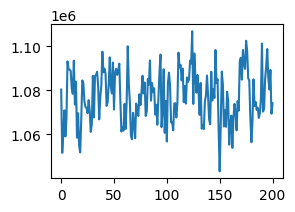

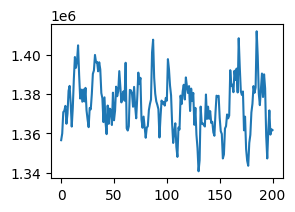

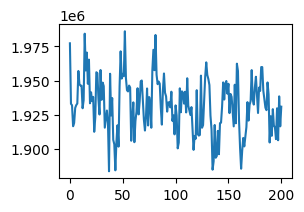

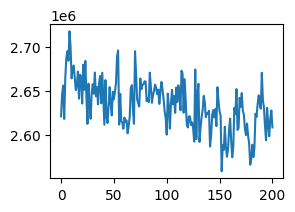

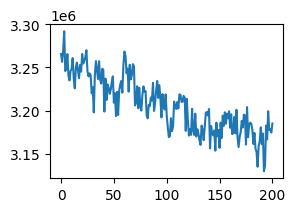

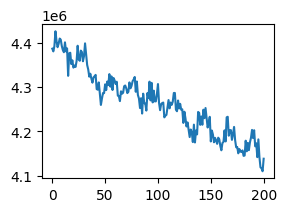

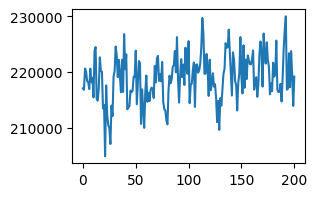

In [324]:
# Saturation rate
days = np.linspace(1,30,30)
dataArr = []; dataArrDark = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-05-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'counter' in dataFolder:
            idx = int(dataFolder[1:4])
            if (day==16 and idx >= 42 and idx <= 48):
                datafile = mainFolder + dataFolder +'/time_s_set.dat'
                x_s, sig = dr.readDataNoRef(datafile)
                sig = np.array(sig[0:])
                n = len(x_s)
                # print("n = " + str(n) + "; Avg count rate = " + str(np.round(np.average(sig))))
                fig,ax = plt.subplots(figsize=(3,2))
                ax.plot(x_s,sig)
                if idx <= 1060: dataArr.append(np.round(np.average(sig)))
                else: dataArrDark.append(np.round(np.average(sig)))

[-1.34756742e+05  2.88091291e+09  1.60281900e+07 -1.13348058e+05
  2.94178268e+09  1.10266240e+07  1.12214583e+00]


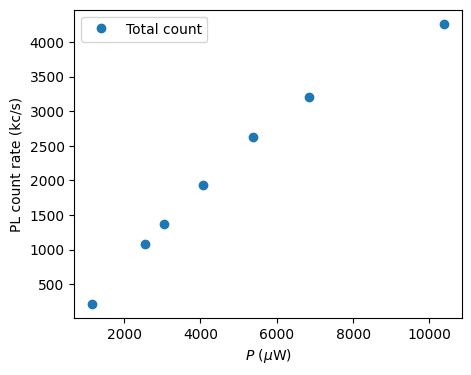

In [321]:
fig, ax = plt.subplots(figsize=(5,4))

# x = np.array((3000,4080,5250,6650,7800, 8750,10400))
# x = np.array((2340,1520,1270,805,243,0,2850, 3000,4080,5250,6650,7800, 8750,10400))
x = np.array((540,820,1190,1860,3160,4950,5600,7200,10650,0))
x = np.array((3070,2770,2200,1900,1250,800,670,500,310,190,70,0.02,1670,4130,5010,5730,6360,7070,10600))
x = np.array((3040,2470,2000,1610,1330,1140,740,400,160,0,3460,3960,4570,5430,5700,6600,6900,7670,8430,
              9080,970,10600))
x = np.array((3130,2720,2060,1340,82,330,720,10700,9820,9000,8370,7570,6750,6000,5400,4860,4040))
x = np.array((1520, 1150, 910, 720, 490, 310, 185, 55, 5250, 2020, 2520, 3000, 3630))*2
x = np.array((383, 1190, 750, 2400, 3150, 4960, 7090, 10450))
x = np.array((4930,3920,2910,2230,1600,730,140,5570,6910,10450))
x = np.array((2550,3050,4070,5390,6840,10390,1160))
y = np.array(dataArr)

# xd = np.array((2670,1070,480,0))
# yd = np.array(dataArrDark)

x = np.sort(x); y = np.sort(y/1000);# xd = np.sort(xd); yd = np.sort(yd/1000)
# popt, pcov = curve_fit(dr.linear, xd, yd)
# perr = np.sqrt(np.diag(pcov))
# xdfit = np.linspace(xd, xd[-1], 1001)
# ydfit = dr.linear(xdfit, *popt)

# yfit_few = dr.linear(x,*popt)
# y_subtr = y-yfit_few

# xfit, yfit, popt, perr = dr.fitSaturation(x, y_subtr, guess=None)

plot1 = ax.plot(x,y,'o',color='C0', label="Total count")
# plot2 = ax.plot(xd,yd, 'o', color='C1', label="Dark count")
# plot3 = ax.plot(xdfit, ydfit,color='C1')
# plot4 = ax.plot(x,y_subtr, 'o', color='C2', label="BG subtracted count")
# plot5 = ax.plot(xfit, yfit, color='C2')
ax.set_xlabel(r"$P$ ($\mu$W)")
ax.set_ylabel(r"PL count rate (kc/s)")
# ax.set_title("$I_{sat}$ = %.1f kc/s, $P_{sat}$ = %.3f mW" % (popt[0], popt[1]/1e3))
ax.legend()
# ax.set_yscale('log')
# ax.set_xscale('log')
print(popt)

### Shallow

In [ ]:
# Saturation rate
days = np.linspace(10,10,1)
dataArr = []; dataArrDark = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2023-10-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'counter' in dataFolder:
            idx = int(dataFolder[1:4])
            if idx >= 4 and idx <= 22:
                datafile = mainFolder + dataFolder +'/time_s_set.dat'
                x_s, sig = dr.readDataNoRef(datafile)
                sig = np.array(sig[0:-1])
                n = len(x_s)
                print("n = " + str(n) + "; Avg count rate = " + str(np.round(np.average(sig))))
                if idx <= 17: dataArr.append(np.round(np.average(sig)))
                else: dataArrDark.append(np.round(np.average(sig)))

In [ ]:
fig, ax = plt.subplots(figsize=(5,4))

x = np.array((6800,4700,3120,2200,1720,1295,1050,855,595,445,340,188,89,0))
y = np.array(dataArr)

xd = np.array((0,280,810,2190,3040))
yd = np.array(dataArrDark)

x = np.sort(x); y = np.sort(y/1000); xd = np.sort(xd); yd = np.sort(yd/1000)
popt, pcov = curve_fit(dr.linear, xd, yd)
perr = np.sqrt(np.diag(pcov))
xdfit = np.linspace(xd, xd[-1], 1001)
ydfit = dr.linear(xdfit, *popt)

yfit_few = dr.linear(x,*popt)
y_subtr = y-yfit_few

xfit, yfit, popt, perr = dr.fitSaturation(x, y_subtr, guess=None)

plot1 = ax.plot(x,y,'o',color='C0', label="Total count")
plot2 = ax.plot(xd,yd, 'o', color='C1', label="Dark count")
plot3 = ax.plot(xdfit, ydfit,color='C1')
plot4 = ax.plot(x,y_subtr, 'o', color='C2', label="BG subtracted count")
plot5 = ax.plot(xfit, yfit, color='C2')
ax.set_xlabel(r"$P$ ($\mu$W)")
ax.set_ylabel(r"PL count rate (kc/s)")
ax.set_title("$I_{sat}$ = %.1f kc/s, $P_{sat}$ = %.3f mW" % (popt[0], popt[1]/1e3))
ax.legend()
# ax.set_yscale('log')
# ax.set_xscale('log')
print(popt)

In [ ]:
x = np.linspace(1,100,100)
y = x**2
from scipy.optimize import curve_fit
def linear(x, a,b):
    return a*x+b
def fitLinear(xdata, ydata, guess=None):
    popt, pcov = curve_fit(linear, xdata, ydata, p0=guess)
    perr = np.sqrt(np.diag(pcov))
    xfit = np.linspace(xdata[0], xdata[-1], 1001)
    yfit = linear(xfit, *popt)
    return xfit, yfit, popt, perr

xfit, yfit, popt, perr = fitLinear(x,y)

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(x,y, 'o-',markersize=3,)
ax.plot(xfit,yfit)
ax.set_title('$a =$ %.2f $\pm$ %.2f' % (popt[0], perr[0]))

# Pulsed ODMR_RR

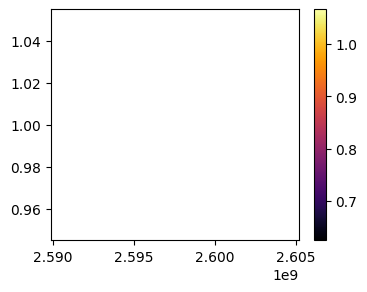

In [180]:
# ODMR
days = np.linspace(1,30,30)
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-09-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'ODMR_RR' in dataFolder:
            idx = int(dataFolder[1:4])
            if (day==14 and idx == 275):
                datafile = mainFolder + dataFolder +'/ODMR_RRObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                contrast = sig/ref
                dataArr.append(contrast)

dataArr = np.array(dataArr)

fig, ax = plt.subplots(figsize=(4,3))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(x_s, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')

plt.show()

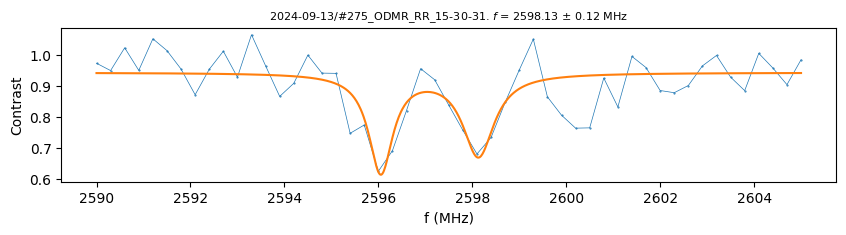

In [185]:
y = np.average(dataArr, axis=0)
x = np.array(x_s)
fig, ax = plt.subplots(figsize=(10,2))
ax.plot(x/1e6,y, 'o-', markersize=0.5,linewidth=0.5)
ax.set_xlabel('f (MHz)')
ax.set_ylabel('Contrast')
# ax.set_xlim((2700,2900))

guess = (-3e3, 2595e6, 0.2e6, -3e3, 2597e6, 0.2e6, -2e3, 2599e6, 0.2e6, 0)
lowerBounds = (-50e3,2505e6,0,   -60e3,2507e6,0,   -20e3,2509e6,0,  -10)
upperBounds = (0,2656e6,1e6,      -1e3,2658e6,1e6,     -1e3,2650e6,1e6,    10)
# ax.vlines(2785.2,0.2,1.2)
ax.set_title(datafile[31:63],fontsize=8)
xfit, yfit, popt, perr = dr.fitLorThree(x, y, guess=guess, lowerBounds=lowerBounds, upperBounds=upperBounds)
ax.plot(xfit/1e6, yfit, color='C1')
s = datafile[31:63] + ". $f$ = %.2f $\pm$ %.2f MHz" % (popt[4]/1e6, perr[4]/1e6)
ax.set_title(s, fontsize=8)

# threshold = 0.8
# peaks = find_peaks(-y, threshold=-threshold)
# xpeaks = x[peaks]/1e6

# ax.vlines(x=popt[1], ymin=min(y), ymax=max(y), linestyle='--', color='r')
# ax.vlines(x=xpeaks[0], ymin=min(y), ymax=max(y), linestyle='--', color='r', linewidth=0.4)
# ax.vlines(x=xpeaks[1], ymin=min(y), ymax=max(y), linestyle='--', color='g', linewidth=0.4)
# ax.vlines(x=xpeaks[2], ymin=min(y), ymax=max(y), linestyle='--', color='b', linewidth=0.4)

plt.show()

# Rabi RR

In [136]:
# Rabi
month = 9; days=np.linspace(1,9,9)
dataArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-0'+str(month)+'-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'RabiRR' in dataFolder:
            idx = int(dataFolder[1:4])
            if day == 9 and idx >= 76:
                datafile = mainFolder + dataFolder +'/RabiRRObject_sig_set.dat'

                guess=(0.6, 20, 0, 0.9, 600)
                sig, ref, popt, perr, x_s = dr.readData(datafile, type='RabiDecay', ifFit=1, guess=guess)

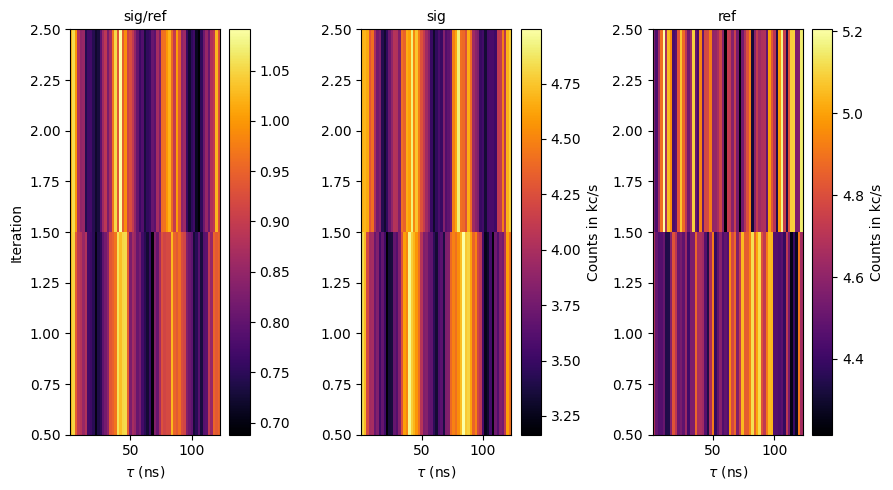

In [430]:
# Rabi
days = np.linspace(1,6,6)
dataArr = []; sigArr = []; refArr = []; idxs = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-09-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'RabiRR' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if (day==6 and idx >= 54 and idx <= 55) and np.mod(idx,1)==0:
                datafile = mainFolder + dataFolder +'/RabiRRObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)
                sig = np.array(sig); ref = np.array(ref)
                
                xPlot = x_s
                contrast = sig/ref
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)

if True:
    dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)

    sorted_indices = np.argsort(idxs)

    # Sort array1 in ascending order
    dataArr = dataArr[sorted_indices]
    sigArr = sigArr[sorted_indices]
    refArr = refArr[sorted_indices]

    fig, axs = plt.subplots(1,3,figsize=(9,5))
    N_datasets = np.size(dataArr,0)
    y = np.linspace(1,N_datasets, N_datasets)
    X, Y = np.meshgrid(x_s, y)
    plot = axs[0].pcolormesh(X,Y, dataArr, cmap='inferno')
    fig.colorbar(plot, orientation='vertical', ax=axs[0])
    axs[0].set_xlabel('$\\tau$ (ns)')
    axs[0].set_ylabel('Iteration')
    axs[0].set_title('sig/ref',fontsize=10)
    # plot.set_clim(0.1,1.2)

    plot1 = axs[1].pcolormesh(X,Y, sigArr, cmap='inferno')
    axs[1].set_xlabel('$\\tau$ (ns)')
    axs[1].set_title('sig',fontsize=10)
    cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])
    cb1.set_label("Counts in kc/s",fontsize=10)
    # plot1.set_clim(0,4)

    plot2 = axs[2].pcolormesh(X,Y, refArr, cmap='inferno')
    axs[2].set_xlabel('$\\tau$ (ns)')
    axs[2].set_title('ref',fontsize=10)
    cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[2])
    cb2.set_label("Counts in kc/s",fontsize=10)
    # plot2.set_clim(0,4)

    # for i in range(3):
    #     # axs[i].set_xlim((82,84))
    #     axs[i].set_ylim((600,610))

    # plt.show()
    plt.tight_layout()


Text(0.5, 1.0, '$\\pi$-pulse = 20.77 $\\pm$ 0.14 ns')

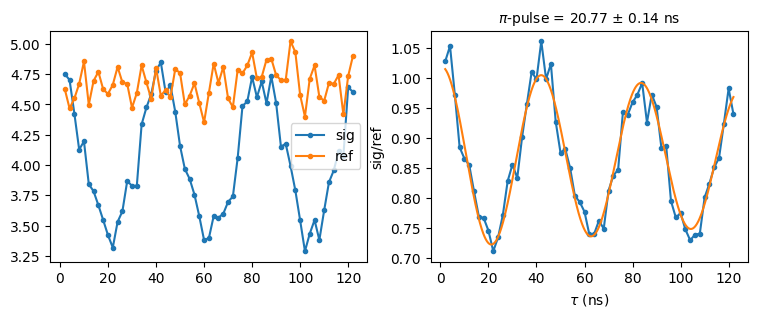

In [431]:
y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
x = xPlot

fig, axs = plt.subplots(1,2,figsize=(9,3))
axs[1].plot(x,y, 'o-', markersize=3, label="sig/ref")
axs[1].set_ylabel('sig/ref')
axs[1].set_xlabel(r"$\tau$ (ns)")
# axs[1].set_ylim((0.1,1.1))

axs[0].plot(x, ys, 'o-', markersize=3, label="sig")
axs[0].plot(x, yr, 'o-', markersize=3, label="ref")
axs[0].legend()
# axs[0].set_title(datafile[31:-25],fontsize=10)

guess = (0.66, 30, 0, 0.9, 600)


xfit, yfit, popt, perr = dr.fitSinusoidDecay(x, y, guess=guess)
axs[1].plot(xfit, yfit, color='C1')
axs[1].set_title('$\pi$-pulse = %.2f $\pm$ %.2f ns' % (popt[1], perr[1]),fontsize=10)

# Dual Rabi RR

In [237]:
# Rabi
days = np.linspace(1,31,31); mos = np.linspace(9,10,2); whichNVIsReadFirst=1; count=0
dataArr = []; sigArr = []; refArr = []; idxs = []; data2Arr=[]; sig2Arr=[]; ref2Arr=[]
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-11-' + str(int(day)).zfill(2) + '/'
    try:
        for dataFolder in os.listdir(mainFolder):
            if 'RabiRRDualNV' in dataFolder:
                if dataFolder[4] == '_': idx = int(dataFolder[1:4])
                else: idx = int(dataFolder[1:5])
                if day==6 and idx ==59:
                    datafile = mainFolder + dataFolder +'/RabiRRDualNVObject_sig2_set.dat'
                    if whichNVIsReadFirst==1:
                        x_s, sig2, ref2, sig, ref = dr.readDataNoPlotDual(datafile)
                    elif whichNVIsReadFirst==2:
                        x_s, sig, ref, sig2, ref2 = dr.readDataNoPlotDual(datafile)
                    sig = np.array(sig); ref = np.array(ref); sig2 = np.array(sig2); ref2 = np.array(ref2)
                    
                    xPlot = x_s
                    contrast = sig/ref; contrast2 = sig2/ref2
                    dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)
                    data2Arr.append(contrast2); sig2Arr.append(sig2); ref2Arr.append(ref2)

                    if count==0: firstdatafile = datafile
                    count+=1
    except:pass
print(np.shape(dataArr))

(1, 29)


In [238]:
dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)
data2Arr = np.array(data2Arr); sig2Arr = np.array(sig2Arr); ref2Arr = np.array(ref2Arr)

# Sort array1 in ascending order
sorted_indices = np.argsort(idxs)
dataArr = dataArr[sorted_indices]; sigArr = sigArr[sorted_indices]; refArr = refArr[sorted_indices]
data2Arr = data2Arr[sorted_indices]; sig2Arr = sig2Arr[sorted_indices]; ref2Arr = ref2Arr[sorted_indices]

if False:
    fig, axs = plt.subplots(2,3,figsize=(8,8))
    N_datasets = np.size(dataArr,0)
    y = np.linspace(1,N_datasets, N_datasets)
    X, Y = np.meshgrid(x_s, y)

    plot = axs[0,0].pcolormesh(X,Y, dataArr, cmap='inferno')
    fig.colorbar(plot, orientation='vertical', ax=axs[0,0])
    axs[0,0].set_xlabel('$\\tau$ (ns)')
    axs[0,0].set_ylabel('Iteration')
    axs[0,0].set_title('sig/ref',fontsize=10)
    plot.set_clim(0.1,1.2)

    plot1 = axs[0,1].pcolormesh(X,Y, sigArr, cmap='inferno')
    axs[0,1].set_xlabel('$\\tau$ (ns)')
    axs[0,1].set_title('sig',fontsize=10)
    cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[0,1])
    # plot1.set_clim(0,4)

    plot2 = axs[0,2].pcolormesh(X,Y, refArr, cmap='inferno')
    axs[0,2].set_xlabel('$\\tau$ (ns)')
    axs[0,2].set_title('ref',fontsize=10)
    cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[0,2])
    cb2.set_label("Counts in kc/s",fontsize=10)
    # plot2.set_clim(0,4)

    plot = axs[1,0].pcolormesh(X,Y, data2Arr, cmap='inferno')
    fig.colorbar(plot, orientation='vertical', ax=axs[1,0])
    axs[1,0].set_xlabel('$\\tau$ (ns)')
    axs[1,0].set_ylabel('Iteration')
    axs[1,0].set_title('sig2/ref2',fontsize=10)
    # plot.set_clim(0.1,1.2)

    plot1 = axs[1,1].pcolormesh(X,Y, sig2Arr, cmap='inferno')
    axs[1,1].set_xlabel('$\\tau$ (ns)')
    axs[1,1].set_title('sig2',fontsize=10)
    cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1,1])
    # plot1.set_clim(0,4)

    plot2 = axs[1,2].pcolormesh(X,Y, ref2Arr, cmap='inferno')
    axs[1,2].set_xlabel('$\\tau$ (ns)')
    axs[1,2].set_title('ref2',fontsize=10)
    cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[1,2])
    cb2.set_label("Counts in kc/s",fontsize=10)
    # plot2.set_clim(0,4)

    plt.tight_layout()
    plt.show()


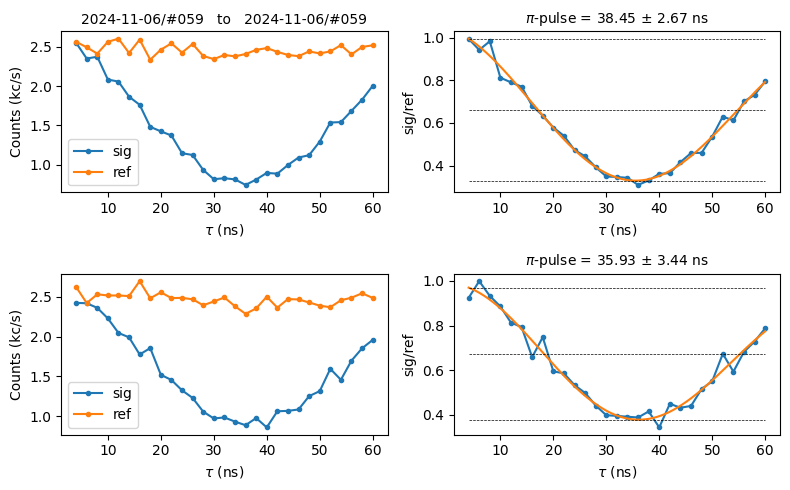

In [239]:
fontsize=10; idx = -1   # last used when last idx = 1081   #296
for idxs in np.linspace(-1,-3,1):
    idx = int(idxs)
    x = np.array(xPlot)
    
    y = dataArr[idx]; ys = sigArr[idx]; yr = refArr[idx]
    y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    
    y2 = data2Arr[idx]; ys2 = sig2Arr[idx]; yr2 = ref2Arr[idx]
    y2 = np.average(data2Arr, axis=0); ys2 = np.average(sig2Arr, axis=0); yr2 = np.average(ref2Arr, axis=0)

    fig, axs = plt.subplots(2,2,figsize=(8,5))
    axs[0,1].plot(x,y, 'o-', markersize=3, label="sig/ref")
    axs[0,1].set_ylabel('sig/ref')
    axs[0,1].set_xlabel(r"$\tau$ (ns)")
    # axs[0,1].set_ylim((0.15,1.2))

    axs[0,0].plot(x, ys, 'o-', markersize=3, label="sig")
    axs[0,0].plot(x, yr, 'o-', markersize=3, label="ref")
    axs[0,0].legend()
    axs[0,0].set_xlabel(r"$\tau$ (ns)")
    axs[0,0].set_ylabel('Counts (kc/s)')
    s = firstdatafile[31:46] + '   to   ' + datafile[31:46]
    axs[0,0].set_title(s,fontsize=10)

    guess = (0.66, 33, 0, 0.9, 600)
    xfit, yfit, popt, perr = dr.fitSinusoidDecay(x, y, guess=guess)
    axs[0,1].plot(xfit, yfit, color='C1')
    axs[0,1].set_title('$\pi$-pulse = %.2f $\pm$ %.2f ns' % (popt[1], perr[1]),fontsize=fontsize)
    axs[0,1].hlines(y=max(yfit),xmin=min(xfit),xmax=max(xfit), linestyle='--',linewidth=0.5, color='k')
    axs[0,1].hlines(y=min(yfit),xmin=min(xfit),xmax=max(xfit), linestyle='--',linewidth=0.5, color='k')
    axs[0,1].hlines(y=(max(yfit)+min(yfit))/2,xmin=min(xfit),xmax=max(xfit), linestyle='--',linewidth=0.5, color='k')
    # axs[0,1].set_ylim((0.15,1.07))
    # print(popt)

    ################################################################################
    axs[1,1].plot(x,y2, 'o-', markersize=3, label="sig/ref")
    axs[1,1].set_ylabel('sig/ref')
    axs[1,1].set_xlabel(r"$\tau$ (ns)")
    # axs[1,1].set_ylim((0.15,1.2))

    axs[1,0].plot(x, ys2, 'o-', markersize=3, label="sig")
    axs[1,0].plot(x, yr2, 'o-', markersize=3, label="ref")
    axs[1,0].legend()
    axs[1,0].set_xlabel(r"$\tau$ (ns)")
    axs[1,0].set_ylabel('Counts (kc/s)')

    guess = (0.66, 40, 0, 0.9, 800)
    xfit, yfit, popt, perr = dr.fitSinusoidDecay(x, y2, guess=guess)
    axs[1,1].plot(xfit, yfit, color='C1')
    # axs[1,1].set_ylim((0.15,1.07))
    axs[1,1].set_title('$\pi$-pulse = %.2f $\pm$ %.2f ns' % (popt[1], perr[1]),fontsize=fontsize)
    axs[1,1].hlines(y=max(yfit),xmin=min(xfit),xmax=max(xfit), linestyle='--',linewidth=0.5, color='k')
    axs[1,1].hlines(y=min(yfit),xmin=min(xfit),xmax=max(xfit), linestyle='--',linewidth=0.5, color='k')
    axs[1,1].hlines(y=(max(yfit)+min(yfit))/2,xmin=min(xfit),xmax=max(xfit), linestyle='--',linewidth=0.5, color='k')
    # print(popt)

plt.tight_layout()
plt.show()

In [3609]:
# f = np.linspace(2e4,5.02e6,251)
# t = 1/(2*f)*1e9
# t = (2*np.rint(t/2))
# t = t[t>240]

# t1 = np.linspace(80,240,81)
# t = np.concatenate((t1,t[::-1]))

# fig,ax=plt.subplots(figsize=(9,2))
# ax.plot(1/(2*t)*1e9/1e6,np.random.rand(len(t)), 'o-', markersize=3,linewidth=1)
# ax.set_title('Planning the datapoints for XY8',fontsize=8)


# T2R RR

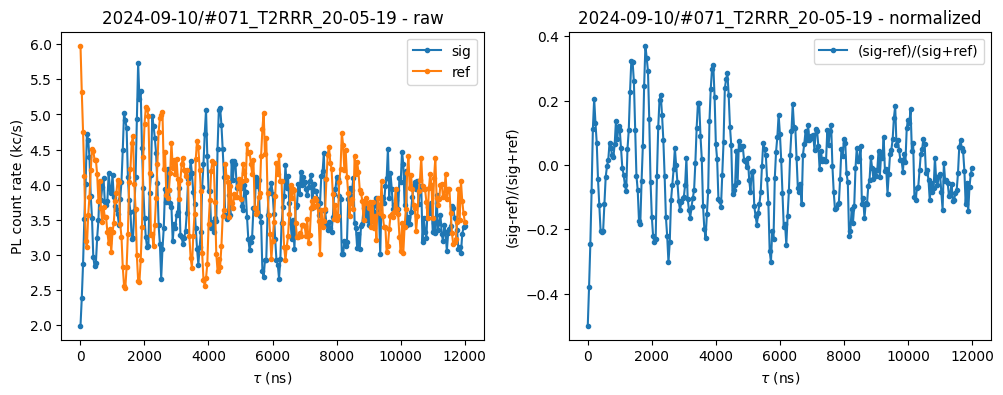

In [1480]:
type = 'T2RRR'
month = 9; days=np.linspace(1,10,10)
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-0'+str(month)+'-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if type in dataFolder:
            idx = int(dataFolder[1:4])
            if day==10 and idx == 71:
                datafile = mainFolder + dataFolder +'/T2RRRObject_sig_set.dat'
                guess = (-0.01,17,0.1)
                sig, ref, popt, perr, x_s = dr.readData(datafile, type='T2R', typeNorm=Q_FINAL, ifFit=0, guess=guess)

Fitted peaks (MHz) [ 357.9 1947.9 2435.6]


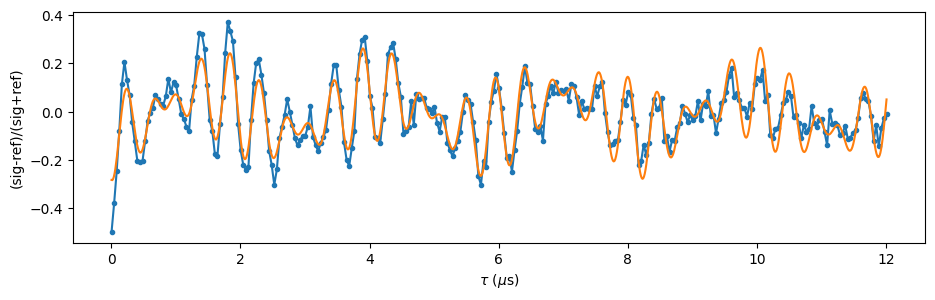

In [1483]:
fig, ax = plt.subplots(figsize=(11,3))
x = x_s
y = (sig-ref)/(sig+ref)

ax.plot(x/1e3,y, 'o-', markersize=3,)
ax.set_xlabel(r"$\tau$ ($\mu$s)")
ax.set_ylabel('(sig-ref)/(sig+ref)')

# guess = (0.05, 0.22, 0,    0.05, 2.01, 0,    0.05, 2.39, -pi,   0.05, 3.15, -pi, 0)
# lowerBounds = (0.01,0,-pi,   0.01,0,-pi,   0.01,0,-pi,  0.01,0,-pi, -1)
# upperBounds = (1,2, 7*pi,   1,4,6*pi,    1,4, 5*pi,  1,4, 5*pi, 1)
# xfit, yfit, popt, perr = dr.fitCosFour(x/1e3, y, guess=guess, lowerBounds=lowerBounds)
# fittedPeaks = np.array((np.round(popt[1],4),np.round(popt[4],4),np.round(popt[7],4),np.round(popt[10],4)))
# print("Fitted peaks (MHz)", fittedPeaks*1e3)

guess = (0.2, 0.34, 0,    0.2, 1.953, 0,    0.2, 2.41, -pi,    0)
lowerBounds = (0.01,0,-pi,   0.01,0,-pi,   0.01,0,-pi,   -1)
upperBounds = (1,2, 7*pi,   1,4,6*pi,    1,4, 5*pi,   1)
xfit, yfit, popt, perr = dr.fitCosThree(x/1e3, y, guess=guess, lowerBounds=lowerBounds)
fittedPeaks = np.array((np.round(popt[1],4),np.round(popt[4],4),np.round(popt[7],4)))
print("Fitted peaks (MHz)", fittedPeaks*1e3)

ax.plot(xfit, yfit, color='C1')

# ax.set_title(r'$T_{2E}$ = %.2f $\pm$ %.2f $\mu$s; $n$ = %.2f $\pm$ %.2f' % (popt[1], perr[1], popt[2], perr[2]))
# ax.set_xlim((-0.1,10.1))

[ 332.2 1910.3 2408.6]


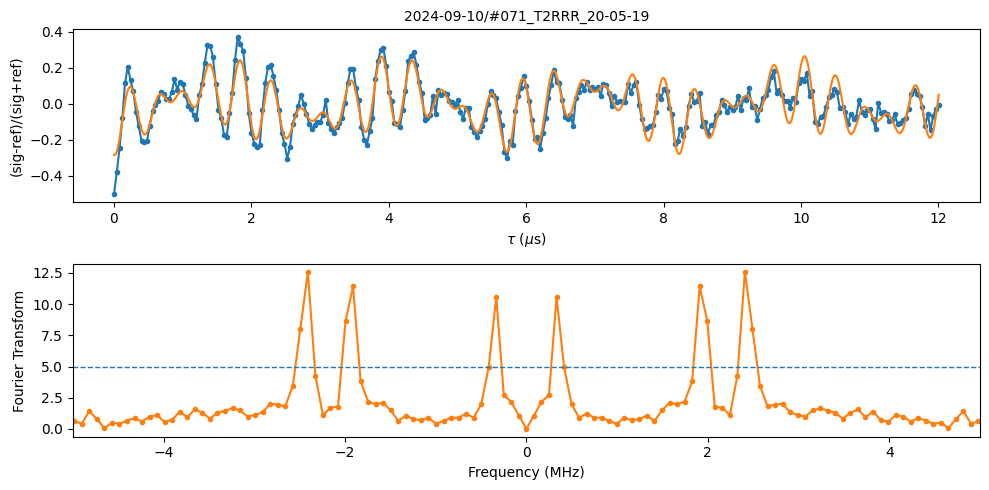

In [1482]:
yfourier = np.fft.fft(y-np.average(y)); yfourier = np.abs(yfourier)
f = np.fft.fftfreq(len(y), 40e-9)/1e6

sorted_indices = np.argsort(f)       # Get the indices that would sort f
f = f[sorted_indices]                # Sort f in ascending order
yfourier = yfourier[sorted_indices]  # Reorder yfourier based on the sorted_indices

# Plot the signal and its Fourier Transform
fig, axs = plt.subplots(2,1, figsize=(10,5))
axs[0].plot(x/1e3,y, 'o-', markersize=3,)
axs[0].plot(xfit, yfit, color='C1')
axs[0].set_xlabel(r"$\tau$ ($\mu$s)")
axs[0].set_ylabel('(sig-ref)/(sig+ref)')
axs[0].set_title(datafile[31:61],fontsize=10)

axs[1].plot(f, yfourier, linestyle='-', marker='o', markersize=3, color='C1')
axs[1].set_title('')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].set_ylabel('Fourier Transform')
axs[1].set_xlim((-5,5))

def find_peaks(data, threshold=0):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1] and data[i] > threshold:
            peaks.append(i)
    return peaks

threshold = 5
peaks = find_peaks(yfourier, threshold=threshold)
fpeaks = f[peaks]; fpeaks = fpeaks[int(len(fpeaks)/2):]
print(np.round(fpeaks*1e3,1))

axs[1].hlines(y=threshold, xmin=min(f), xmax=max(f), linestyle='--', linewidth = 1)

plt.tight_layout()
plt.show()

# T2R RR Dual NV

In [8]:
# T2R
days = np.linspace(1,12,12); count=0
dataArr = []; sigArr = []; refArr = []; idxs = []; data2Arr=[]; sig2Arr=[]; ref2Arr=[]
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-09-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'T2RRRDualNV_NewTrack' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if (day==12 and idx == 127):
                datafile = mainFolder + dataFolder +'/T2RRRDualNV_NewTrackObject_sig_set.dat'
                x_s, sig, ref, sig2, ref2 = dr.readDataNoPlotDual(datafile)
                xPlot = np.array(x_s); sig = np.array(sig); ref = np.array(ref); sig2 = np.array(sig2); ref2 = np.array(ref2)
            
                # Sort data taken in random order
                sorted_indices = np.argsort(xPlot)
                xPlot = xPlot[sorted_indices]
                sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]
                
                contrast = (sig-ref)/(sig+ref); contrast2 = (sig2-ref2)/(sig2+ref2)
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)
                data2Arr.append(contrast2); sig2Arr.append(sig2); ref2Arr.append(ref2)

                if count==0: firstdatafile = datafile
                count+=1

print(np.shape(dataArr))
dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)
data2Arr = np.array(data2Arr); sig2Arr = np.array(sig2Arr); ref2Arr = np.array(ref2Arr)

(1, 376)


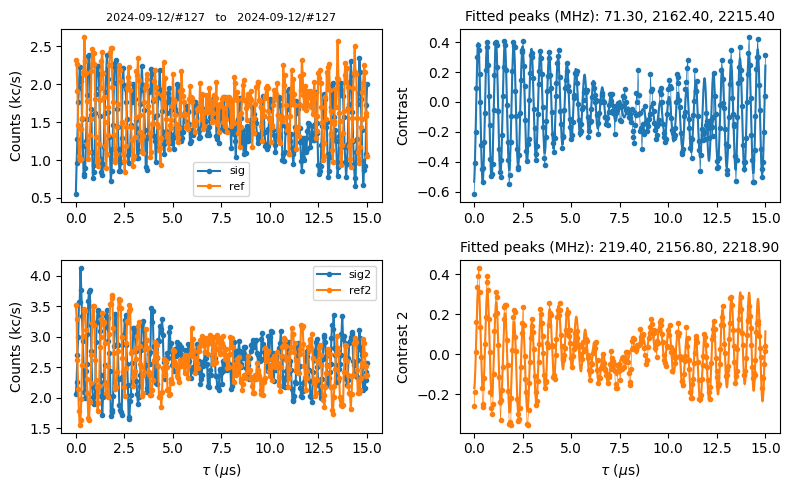

In [16]:
ifXAxisFreq = 0; correctionToTau = 0; markerAt = 3.3; ifNormedTo01=0

for idxs in np.linspace(1,1,1):
    idx = int(idxs)
    t = xPlot+correctionToTau
    x = (xPlot+correctionToTau)/1e3
    if ifXAxisFreq: x = 1/(2*x)
    else: x = x
    
    # y = dataArr[idx]; ys = sigArr[idx]; yr = refArr[idx]
    y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    
    # y2 = data2Arr[idx]; ys2 = sig2Arr[idx]; yr2 = ref2Arr[idx]
    y2 = np.average(data2Arr, axis=0); ys2 = np.average(sig2Arr, axis=0); yr2 = np.average(ref2Arr, axis=0)
        
    if True:
        fig, axs = plt.subplots(2,2,figsize=(8,5))
        axs[0,1].plot(x,y, 'o-', linewidth=0.5,markersize=3, label="contrast")
        axs[0,1].set_ylabel('Contrast')
        
        axs[0,0].plot(x, ys, 'o-', markersize=3, label="sig")
        axs[0,0].plot(x, yr, 'o-', markersize=3, label="ref")
        axs[0,0].legend(fontsize=8)
        axs[0,0].set_ylabel('Counts (kc/s)')
        s = firstdatafile[31:46] + '   to   ' + datafile[31:46]
        axs[0,0].set_title(s,fontsize=8)

        guess = (0.2, 0.06, 0,    0.2, 2.127, 0,    0.2, 2.26, -pi,    0)
        lowerBounds = (0.01,0,-pi,   0.01,0,-pi,   0.01,0,-pi,   -1)
        upperBounds = (1,2, 7*pi,   1,4,6*pi,    1,4, 5*pi,   1)
        xfit, yfit, popt, perr = dr.fitCosThree(x, y, guess=guess, lowerBounds=lowerBounds)
        fittedPeaks = np.array((np.round(popt[1],4),np.round(popt[4],4),np.round(popt[7],4)))
        fittedPeaks = fittedPeaks*1e3

        axs[0,1].plot(xfit, yfit, color='C0')
        axs[0,1].set_title('Fitted peaks (MHz): %.2f, %.2f, %.2f' %
                        (fittedPeaks[0], fittedPeaks[1], fittedPeaks[2]),fontsize=10)

        ################################################################################
        axs[1,1].plot(x,y2, 'o-', linewidth=0.5,markersize=3, color='C1',label="contrast 2")
        axs[1,1].set_ylabel('Contrast 2')
        axs[1,1].set_xlabel(r"$\tau$ ($\mu$s)")
        if ifXAxisFreq: axs[1,1].set_xlabel("f (MHz)")

        axs[1,0].plot(x, ys2, 'o-', markersize=3, label="sig2")
        axs[1,0].plot(x, yr2, 'o-', markersize=3, label="ref2")
        axs[1,0].legend(fontsize=8)
        axs[1,0].set_xlabel(r"$\tau$ ($\mu$s)")
        if ifXAxisFreq: axs[1,0].set_xlabel("f (MHz)")
        axs[1,0].set_ylabel('Counts (kc/s)')

        guess = (0.2, 0.2, 0,    0.2, 2.127, 0,    0.2, 2.260, -pi,    0)
        lowerBounds = (0.01,0,-pi,   0.01,0,-pi,   0.01,0,-pi,   -1)
        upperBounds = (1,2, 7*pi,   1,4,6*pi,    1,4, 5*pi,   1)
        xfit, yfit, popt, perr = dr.fitCosThree(x, y2, guess=guess, lowerBounds=lowerBounds)
        fittedPeaks = np.array((np.round(popt[1],4),np.round(popt[4],4),np.round(popt[7],4)))
        fittedPeaks = fittedPeaks*1e3

        axs[1,1].plot(xfit, yfit, color='C1')
        axs[1,1].set_title('Fitted peaks (MHz): %.2f, %.2f, %.2f' %
                        (fittedPeaks[0], fittedPeaks[1], fittedPeaks[2]),fontsize=10)

        plt.tight_layout()
    
    

[  66.5 1928.2 2127.7 2260.6 2460.1]
[ 199.5 2127.7 2260.6]


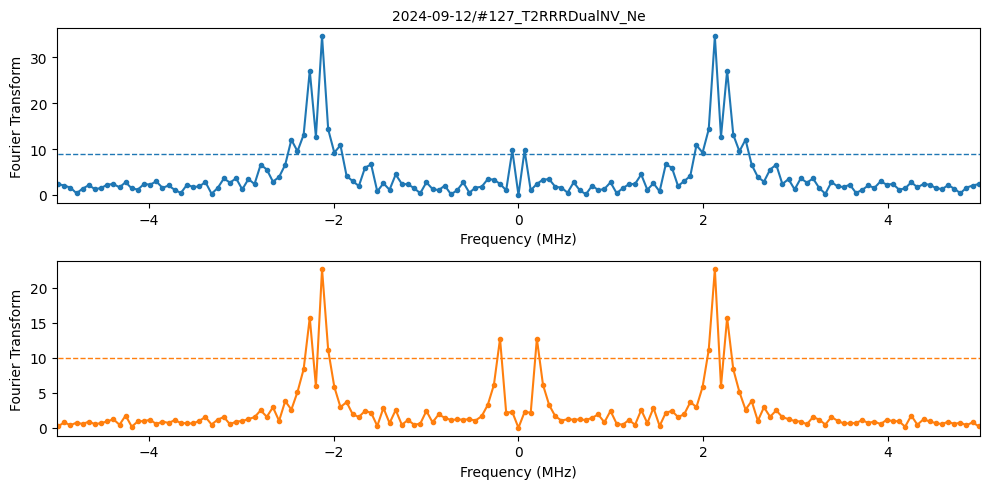

In [12]:
yfourier = np.fft.fft(y-np.average(y)); yfourier = np.abs(yfourier)
yfourier2 = np.fft.fft(y2-np.average(y2)); yfourier2 = np.abs(yfourier2)
f = np.fft.fftfreq(len(y), 40e-9)/1e6

sorted_indices = np.argsort(f)       # Get the indices that would sort f
f = f[sorted_indices]                # Sort f in ascending order
yfourier = yfourier[sorted_indices]  # Reorder yfourier based on the sorted_indices
yfourier2 = yfourier2[sorted_indices]  # Reorder yfourier based on the sorted_indices

# Plot the signal and its Fourier Transform
fig, axs = plt.subplots(2,1, figsize=(10,5))
axs[0].plot(f, yfourier, linestyle='-', marker='o', markersize=3, color='C0')
axs[0].set_title('')
axs[0].set_xlabel('Frequency (MHz)')
axs[0].set_ylabel('Fourier Transform')
axs[0].set_xlim((-5,5))
axs[0].set_title(datafile[31:61],fontsize=10)

axs[1].plot(f, yfourier2, linestyle='-', marker='o', markersize=3, color='C1')
axs[1].set_title('')
axs[1].set_xlabel('Frequency (MHz)')
axs[1].set_ylabel('Fourier Transform')
axs[1].set_xlim((-5,5))

def find_peaks(data, threshold=0):
    peaks = []
    for i in range(1, len(data) - 1):
        if data[i] > data[i - 1] and data[i] > data[i + 1] and data[i] > threshold:
            peaks.append(i)
    return peaks

threshold = 9
peaks = find_peaks(yfourier, threshold=threshold)
fpeaks = f[peaks]; fpeaks = fpeaks[int(len(fpeaks)/2):]
print(np.round(fpeaks*1e3,1))

threshold2 = 10
peaks2 = find_peaks(yfourier2, threshold=threshold2)
fpeaks2 = f[peaks2]; fpeaks2 = fpeaks2[int(len(fpeaks2)/2):]
print(np.round(fpeaks2*1e3,1))

axs[0].hlines(y=threshold, xmin=min(f), xmax=max(f), linestyle='--', linewidth = 1)
axs[1].hlines(y=threshold2, xmin=min(f), xmax=max(f), linestyle='--', linewidth = 1, color='C1')

plt.tight_layout()
plt.show()

# T2E RR

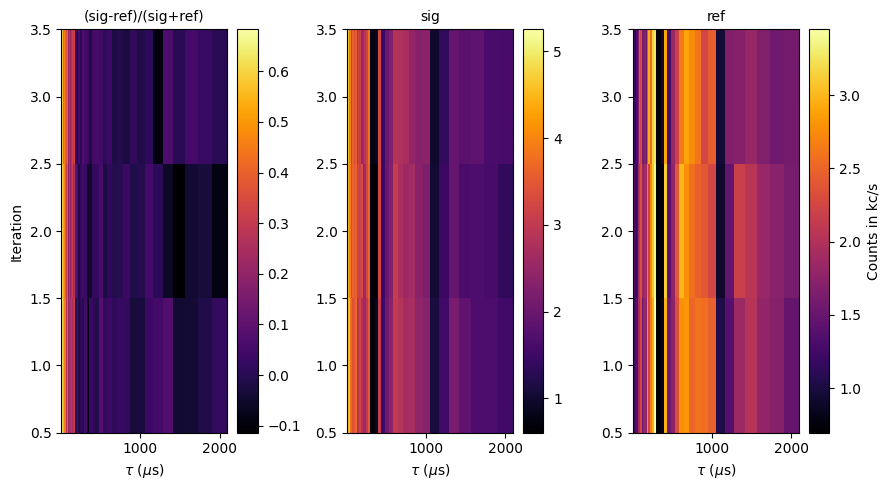

In [ ]:
# September T2E
days = np.linspace(1,6,6)
dataArr = []; sigArr = []; refArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-09-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'T2ERR' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if (day==5 and idx >= 94) or (day==6 and idx <= 2):
                datafile = mainFolder + dataFolder +'/T2ERRObject_sig_set.dat'
                x_s, sig, ref = dr.readDataNoPlot(datafile)

                sig = np.array(sig); ref = np.array(ref)
                contrast = (sig-ref)/(sig+ref)
                xPlot = x_s; xPlot = np.array(xPlot)

                sorted_indices = np.argsort(xPlot)
                xPlot = xPlot[sorted_indices]
                contrast = contrast[sorted_indices]
                sig = sig[sorted_indices]
                ref = ref[sorted_indices]

                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref)

if True:
    dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr)

    # # Replace 'nan' values with the value of the item preceding it
    # nan_indices = np.isnan(dataArr)
    # dataArr[nan_indices] = np.roll(dataArr, 1, axis=1)[nan_indices]

    fig, axs = plt.subplots(1,3,figsize=(9,5))
    N_datasets = np.size(dataArr,0)
    y = np.linspace(1,N_datasets, N_datasets)
    X, Y = np.meshgrid(xPlot/1e3, y)
    plot = axs[0].pcolormesh(X,Y, dataArr, cmap='inferno')
    fig.colorbar(plot, orientation='vertical', ax=axs[0])
    axs[0].set_xlabel('$\\tau$ ($\mu$s)')
    axs[0].set_ylabel('Iteration')
    axs[0].set_title('(sig-ref)/(sig+ref)',fontsize=10)
    # plot.set_clim(0.1,1.2)

    plot1 = axs[1].pcolormesh(X,Y, sigArr, cmap='inferno')
    axs[1].set_xlabel('$\\tau$ ($\mu$s)')
    axs[1].set_title('sig',fontsize=10)
    cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1])

    plot2 = axs[2].pcolormesh(X,Y, refArr, cmap='inferno')
    axs[2].set_xlabel('$\\tau$ ($\mu$s)')
    axs[2].set_title('ref',fontsize=10)
    cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[2])
    cb2.set_label("Counts in kc/s",fontsize=10)

    plt.tight_layout()

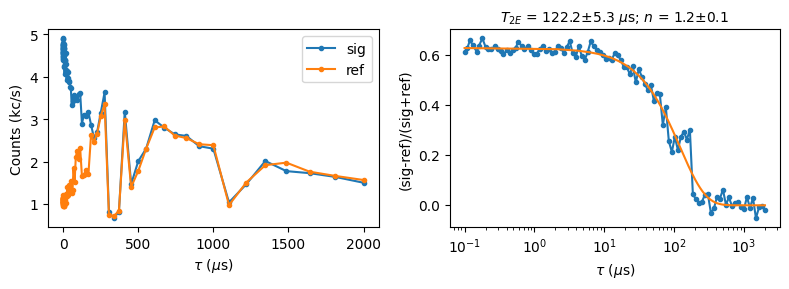

In [ ]:
# idx = 0
# y = dataArr[idx]; ys = sigArr[idx]; yr = refArr[idx]
if True:

    start=0; end=3
    y = np.average(dataArr[start:end], axis=0)
    ys = np.average(sigArr[start:end], axis=0)
    yr = np.average(refArr[start:end], axis=0)
    x = xPlot

    fig, axs = plt.subplots(1,2,figsize=(8,3))
    axs[1].plot(x/1e3,y, 'o-', markersize=3, label='(sig-ref)/(sig+ref)')
    axs[1].set_ylabel('(sig-ref)/(sig+ref)')
    axs[1].set_xlabel('$\\tau$ ($\mu$s)')
    axs[1].set_xscale('log')
    # axs[1].set_xlim((-5,110))

    axs[0].plot(x/1e3, ys, 'o-', markersize=3, label="sig")
    axs[0].plot(x/1e3, yr, 'o-', markersize=3, label="ref")
    axs[0].legend()
    axs[0].set_ylabel('Counts (kc/s)')
    axs[0].set_xlabel('$\\tau$ ($\mu$s)')

    guess = (0.2, 500, 2, 0)
    xfit, yfit, popt, perr = dr.fitStrDecay(x/1e3, y, guess=guess)
    axs[1].plot(xfit, yfit, color='C1')
    axs[1].set_title('$T_{2E}$ = %.1f$\pm$%.1f $\mu$s; $n$ = %.1f$\pm$%.1f' %
                    (popt[1],perr[1],popt[2],perr[2]),fontsize=10)

    plt.tight_layout()

# T2E RR Dual NV

In [396]:
# T2E
days = np.linspace(1,1,1); count=0
dataArr = []; sigArr = []; refArr = []; idxs = []; data2Arr=[]; sig2Arr=[]; ref2Arr=[]
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'T2ERRDualNV_NewTrack' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if (day==1 and idx ==46):
                datafile = mainFolder + dataFolder +'/T2ERRDualNV_NewTrackObject_sig_set.dat'
                x_s, sig, ref, sig2, ref2 = dr.readDataNoPlotDual(datafile)
                xPlot = np.array(x_s); sig = np.array(sig); ref = np.array(ref); sig2 = np.array(sig2); ref2 = np.array(ref2)
            
                # Sort data taken in random order
                sorted_indices = np.argsort(xPlot)
                xPlot = xPlot[sorted_indices]
                sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]
                
                contrast = (sig-ref)/(sig+ref); contrast2 = (sig2-ref2)/(sig2+ref2)
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)
                data2Arr.append(contrast2); sig2Arr.append(sig2); ref2Arr.append(ref2)

                if count==0: firstdatafile = datafile
                count+=1

In [397]:
print(np.shape(dataArr))
dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)
data2Arr = np.array(data2Arr); sig2Arr = np.array(sig2Arr); ref2Arr = np.array(ref2Arr)

if False:
    # Replace 'nan' values with the value of the item preceding it
    nan_indices = np.isnan(dataArr)
    dataArr[nan_indices] = np.roll(dataArr, 1, axis=1)[nan_indices]
    nan_indices = np.isnan(data2Arr)
    data2Arr[nan_indices] = np.roll(data2Arr, 1, axis=1)[nan_indices]


    fig, axs = plt.subplots(2,3,figsize=(8,8))
    N_datasets = np.size(dataArr,0)
    y = np.linspace(1,N_datasets, N_datasets)
    X, Y = np.meshgrid(xPlot/1e3, y)

    plot = axs[0,0].pcolormesh(X,Y, dataArr, cmap='inferno')
    fig.colorbar(plot, orientation='vertical', ax=axs[0,0])
    axs[0,0].set_ylabel('Iteration')
    axs[0,0].set_title('Contrast',fontsize=10)
    # plot.set_clim(0.1,1.2)

    plot1 = axs[0,1].pcolormesh(X,Y, sigArr, cmap='inferno')
    axs[0,1].set_title('sig',fontsize=10)
    cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[0,1])
    # plot1.set_clim(0,4)

    plot2 = axs[0,2].pcolormesh(X,Y, refArr, cmap='inferno')
    axs[0,2].set_title('ref',fontsize=10)
    cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[0,2])
    cb2.set_label("Counts in kc/s",fontsize=10)
    # plot2.set_clim(0,4)

    plot = axs[1,0].pcolormesh(X,Y, data2Arr, cmap='inferno')
    fig.colorbar(plot, orientation='vertical', ax=axs[1,0])
    axs[1,0].set_xlabel('$\\tau$ ($\mu$s)')
    axs[1,0].set_ylabel('Iteration')
    axs[1,0].set_title('Contrast 2',fontsize=10)
    # plot.set_clim(0.1,1.2)

    plot1 = axs[1,1].pcolormesh(X,Y, sig2Arr, cmap='inferno')
    axs[1,1].set_xlabel('$\\tau$ ($\mu$s)')
    axs[1,1].set_title('sig2',fontsize=10)
    cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1,1])
    # plot1.set_clim(0,4)

    plot2 = axs[1,2].pcolormesh(X,Y, ref2Arr, cmap='inferno')
    axs[1,2].set_xlabel('$\\tau$ ($\mu$s)')
    axs[1,2].set_title('ref2',fontsize=10)
    cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[1,2])
    cb2.set_label("Counts in kc/s",fontsize=10)
    # plot2.set_clim(0,4)

    for i in range(2):
        for j in range(3):
            axs[i,j].set_xscale('log')

    plt.tight_layout()

(1, 41)


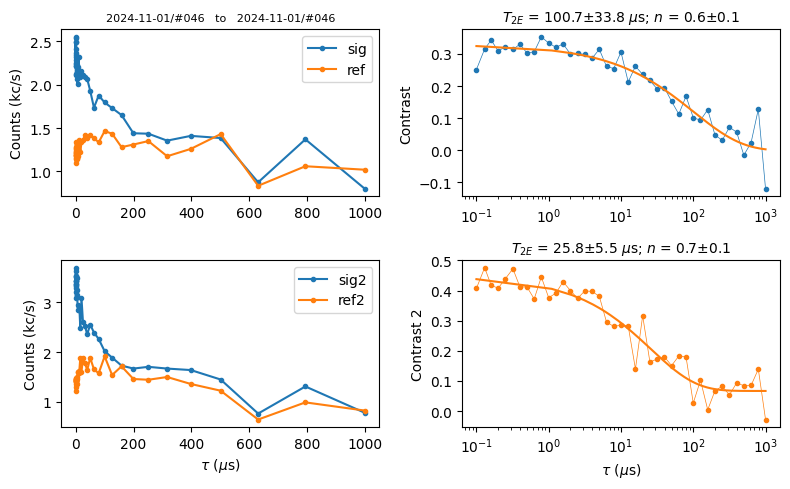

In [398]:
ifXAxisFreq = 0; correctionToTau = 0; markerAt = 3.3; ifNormedTo01=0

for idxs in np.linspace(1,1,1):
    idx = int(idxs)
    t = xPlot+correctionToTau
    x = (xPlot+correctionToTau)/1e3
    if ifXAxisFreq: x = 1/(2*x)
    else: x = x
    
    # y = dataArr[idx]; ys = sigArr[idx]; yr = refArr[idx]
    y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    
    # y2 = data2Arr[idx]; ys2 = sig2Arr[idx]; yr2 = ref2Arr[idx]
    y2 = np.average(data2Arr, axis=0); ys2 = np.average(sig2Arr, axis=0); yr2 = np.average(ref2Arr, axis=0)

    if ifNormedTo01:
        y=-y;y2=-y2
        y = linear_map(y,-(y.max()),y.max(),0,1)
        y2 = linear_map(y2,-(y2.max()),y2.max(),0,1)
        
    if True:
        fig, axs = plt.subplots(2,2,figsize=(8,5))
        axs[0,1].plot(x,y, 'o-', linewidth=0.5,markersize=3, label="contrast")
        axs[0,1].set_ylabel('Contrast')
        axs[0,1].set_xscale('log')
        
        axs[0,0].plot(x, ys, 'o-', markersize=3, label="sig")
        axs[0,0].plot(x, yr, 'o-', markersize=3, label="ref")
        axs[0,0].legend()
        axs[0,0].set_ylabel('Counts (kc/s)')
        s = firstdatafile[31:46] + '   to   ' + datafile[31:46]
        axs[0,0].set_title(s,fontsize=8)

        guess = (0.2, 200, 2, 0)
        xfit, yfit, popt, perr = dr.fitStrDecay(x, y, guess=guess)
        axs[0,1].plot(xfit, yfit, color='C1')
        axs[0,1].set_title('$T_{2E}$ = %.1f$\pm$%.1f $\mu$s; $n$ = %.1f$\pm$%.1f' %
                        (popt[1],perr[1],popt[2],perr[2]),fontsize=10)

        ################################################################################
        axs[1,1].plot(x,y2, 'o-', linewidth=0.5,markersize=3, color='C1',label="contrast 2")
        axs[1,1].set_ylabel('Contrast 2')
        axs[1,1].set_xlabel(r"$\tau$ ($\mu$s)")
        axs[1,1].set_xscale('log')
        if ifXAxisFreq: axs[1,1].set_xlabel("f (MHz)")

        axs[1,0].plot(x, ys2, 'o-', markersize=3, label="sig2")
        axs[1,0].plot(x, yr2, 'o-', markersize=3, label="ref2")
        axs[1,0].legend()
        axs[1,0].set_xlabel(r"$\tau$ ($\mu$s)")
        if ifXAxisFreq: axs[1,0].set_xlabel("f (MHz)")
        axs[1,0].set_ylabel('Counts (kc/s)')

        guess = (0.2, 200, 2, 0)
        xfit, yfit, popt, perr = dr.fitStrDecay(x, y2, guess=guess)
        axs[1,1].plot(xfit, yfit, color='C1')
        axs[1,1].set_title('$T_{2E}$ = %.1f$\pm$%.1f $\mu$s; $n$ = %.1f$\pm$%.1f' %
                        (popt[1],perr[1],popt[2],perr[2]),fontsize=10)

        plt.tight_layout()
    
    

# XY8 RR Dual NV

### Single-dataset analysis

In [2413]:
# XY8
days = np.linspace(1,31,31); mos = np.linspace(9,10,2); count=0
dataArr = []; sigArr = []; refArr = []; idxs = []; data2Arr=[]; sig2Arr=[]; ref2Arr=[]
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-11-' + str(int(day)).zfill(2) + '/'
    try:
        for dataFolder in os.listdir(mainFolder):
            if 'XY8RRDualNV_NewTrack' in dataFolder:
                if dataFolder[4] == '_': idx = int(dataFolder[1:4])
                else: idx = int(dataFolder[1:5])
                # if (day==9 and idx >= 48) or (day==10 and idx <= 7): #N=5 no noise
                # if (day==10 and idx>=14 and idx<=44):
                # if (day==10 and idx >= 45 and idx<=49): #N=5 3.3 MHz 0.2 V
                # if (day==10 and idx >= 81) or (day==11 and idx <= 5): #N=8 no noise
                # if (day==11 and idx >= 7 and idx <= 30): #N=8 3.3 MHz 0.2 V
                # if (day==11 and idx >= 35 and idx <= 43): #N=5 3.3 MHz 0.2 V
                # if (day==11 and idx >= 45 and idx <= 57): #N=5 no noise
                # if (day==11 and idx >= 61 and idx <= 75): #N=5 no noise probing 1-2.5 MHz
                # if (day==11 and idx >= 77 and idx <= 89): #N=5 1.8 MHz 0.2 V
                # if (day==12 and idx >= 2 and idx <= 6): #N=5 1.8 MHz 0.1 V
                # if (day==12 and idx >= 8 and idx <= 12): #N=5 1.8 MHz 30 kHz 0.08 V
                # if (day==12 and idx >= 19 and idx <= 61): #N=5 1.8 MHz 200 kHz 0.1 V
                # if (day==12 and idx >= 63 and idx <= 68): #N=5 new no noise background
                # if (day==12 and idx >= 70 and idx <= 71): #N=5 1.8 MHz 3 kHz 0.1 V
                # if (day==12 and idx >= 78 and idx <= 89) or (day==192 and idx==115): #N=5 1.85 MHz 200 kHz 0.1 V
                # if (day==12 and idx >= 139 and idx <= 148): #N=5 no noise after disaster
                # if (day==12 and idx >= 149): #N=5 1.85 MHz, 200 kHz, 0.1 V
                # if (day==13 and idx >= 26 and idx <= 66): #N=5 1.85 MHz, 200 kHz, 0.1 V
                # if (day==14 and idx >= 122 and idx <= 126): #N=5 no noise
                # if (day==14 and idx >= 128 and idx <= 164): #N=5 1.5 MHz 50 kHz 0.08 V
                # if (day==14 and idx >= 165 and idx <= 179): #N=5 1.5 MHz 50 kHz 0.12 V
                # if (day==14 and idx >= 180 and idx <= 214): #N=5 3.3 MHz, 50 kHz, 0.2 V
                # if (day==14 and idx >= 217 and idx <= 225): #N=5 3.3 MHz, 50 kHz, 0.4 V
                # if (day==14 and idx >= 227): #N=5 no noise
                # if (day==30 and idx >= 33 and idx <= 48): #N=5 1.75 MHz 50 kHz 0.25 V
                # if (day==30 and idx >= 49 and idx <= 55): #N=5 no noise
                # if (day==30 and idx >= 57 and idx <= 66): #N=5 1.75 MHz 50 kHz 0.25 V SINE DETECT
                # if (day==30 and idx >= 78 and idx <= 80): #N=5 1.75 MHz 50 kHz 0.25 V sweep phase last pi/2
                # if (day==30 and idx >= 84 and idx <= 86): #N=5 1.75 MHz 50 kHz 0.25 V SINE DETECT
                # if (day==2 and idx >= 22 and idx <= 29): #N=5 1.75 MHz 50 kHz 0.25 V 
                # if (day==7 and idx >= 33 and idx <= 37): #N=5 1.75 MHz 50 kHz 0.25 V
                # if (day==17 and idx >= 14 and idx <= 18): #N=5 1.5625 MHz 100 kHz 0.25 V noise_010
                if (day==5 and idx==28): #N=5 1.5625 MHz 100 kHz 0.25 V
                    datafile = mainFolder + dataFolder +'/XY8RRDualNV_NewTrackObject_sig_set.dat'
                    x_s, sig, ref, sig2, ref2 = dr.readDataNoPlotDual(datafile)
                    xPlot = np.array(x_s); sig = np.array(sig); ref = np.array(ref); sig2 = np.array(sig2); ref2 = np.array(ref2)
                    NXY8 = 5
                    # Sort data taken in random order
                    sorted_indices = np.argsort(xPlot)
                    xPlot = xPlot[sorted_indices]
                    sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                    ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]
                    
                    contrast = (sig-ref)/(sig+ref); contrast2 = (sig2-ref2)/(sig2+ref2)
                    dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)
                    data2Arr.append(contrast2); sig2Arr.append(sig2); ref2Arr.append(ref2)

                    if count==0: firstdatafile = datafile
                    count+=1
    except:pass
print(np.shape(dataArr))
dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)
data2Arr = np.array(data2Arr); sig2Arr = np.array(sig2Arr); ref2Arr = np.array(ref2Arr)

# dataArr = dataArr[:,1:-3]; sigArr = sigArr[:,1:-3]; refArr = refArr[:,1:-3]; xPlot = xPlot[1:-3]
# data2Arr = data2Arr[:,1:-3]; sig2Arr = sig2Arr[:,1:-3]; ref2Arr= ref2Arr[:,1:-3]

(1, 12)


In [2414]:
if False:
    # Replace 'nan' values with the value of the item preceding it
    nan_indices = np.isnan(dataArr)
    dataArr[nan_indices] = np.roll(dataArr, 1, axis=1)[nan_indices]
    nan_indices = np.isnan(data2Arr)
    data2Arr[nan_indices] = np.roll(data2Arr, 1, axis=1)[nan_indices]


    fig, axs = plt.subplots(2,3,figsize=(8,8))
    N_datasets = np.size(dataArr,0)
    y = np.linspace(1,N_datasets, N_datasets)
    X, Y = np.meshgrid(xPlot/1e3, y)

    plot = axs[0,0].pcolormesh(X,Y, dataArr, cmap='inferno')
    fig.colorbar(plot, orientation='vertical', ax=axs[0,0])
    axs[0,0].set_ylabel('Iteration')
    axs[0,0].set_title('Contrast',fontsize=10)
    # plot.set_clim(0.1,1.2)

    plot1 = axs[0,1].pcolormesh(X,Y, sigArr, cmap='inferno')
    axs[0,1].set_title('sig',fontsize=10)
    cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[0,1])
    # plot1.set_clim(0,4)

    plot2 = axs[0,2].pcolormesh(X,Y, refArr, cmap='inferno')
    axs[0,2].set_title('ref',fontsize=10)
    cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[0,2])
    cb2.set_label("Counts in kc/s",fontsize=10)
    # plot2.set_clim(0,4)

    plot = axs[1,0].pcolormesh(X,Y, data2Arr, cmap='inferno')
    fig.colorbar(plot, orientation='vertical', ax=axs[1,0])
    axs[1,0].set_xlabel('$\\tau$ ($\mu$s)')
    axs[1,0].set_ylabel('Iteration')
    axs[1,0].set_title('Contrast 2',fontsize=10)
    # plot.set_clim(0.1,1.2)

    plot1 = axs[1,1].pcolormesh(X,Y, sig2Arr, cmap='inferno')
    axs[1,1].set_xlabel('$\\tau$ ($\mu$s)')
    axs[1,1].set_title('sig2',fontsize=10)
    cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1,1])
    # plot1.set_clim(0,4)

    plot2 = axs[1,2].pcolormesh(X,Y, ref2Arr, cmap='inferno')
    axs[1,2].set_xlabel('$\\tau$ ($\mu$s)')
    axs[1,2].set_title('ref2',fontsize=10)
    cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[1,2])
    cb2.set_label("Counts in kc/s",fontsize=10)
    # plot2.set_clim(0,4)

    for i in range(2):
        for j in range(3):
            axs[i,j].set_xscale('log')

    plt.tight_layout()

In [2415]:
# # For T2 analysis
# ifXAxisFreq = 0; correctionToTau = 40; correctionToTau2 = correctionToTau; markerAt = 1/2/(292+40)*1e3; ifNormedTo01=1

# t = (xPlot+correctionToTau)/1e3; t2 = (xPlot+correctionToTau2)/1e3
# if ifXAxisFreq: 
#     x = 1/(2*t); x2 = 1/(2*t2)
# else: 
#     x = 8*t*NXY8; x2 = 8*t2*NXY8
#     xs = x; xs2 = x2
    
# y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
# y2 = np.average(data2Arr, axis=0); ys2 = np.average(sig2Arr, axis=0); yr2 = np.average(ref2Arr, axis=0)
# s=10
# x = x[s:]; x2 = x2[s:]; y = y[s:]; y2 = y2[s:]

# if ifNormedTo01==1:
#     y=-y;y2=-y2
#     y = linear_map(y,-(y.max()),y.max(),0,1)
#     y2 = linear_map(y2,-(y2.max()),y2.max(),0,1)
# elif ifNormedTo01==2:
#     y=-y;y2=-y2
#     y = linear_map(y,-1,1,0,1)
#     y2 = linear_map(y2,-1,1,0,1)
    
# if True:
    # fig, axs = plt.subplots(2,2,figsize=(8,5))
    # axs[0,1].plot(x,y, 'o-', linewidth=0.5,markersize=1, label="contrast")
    # axs[0,1].set_ylabel('Contrast')
    # axs[0,1].hlines(y=0.5, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')
    # axs[0,1].set_xscale('log')

    # guess = (0.5, 200, 2, 0)
    # xfit, yfit, popt, perr = dr.fitStrDecay(x, y, guess=guess)
    # axs[0,1].plot(xfit, yfit, color='C0')
    # axs[0,1].set_title('$T_{2,XY8-5}$ = %.1f$\pm$%.1f $\mu$s; $n$ = %.1f$\pm$%.1f' %
    #                 (popt[1],perr[1],popt[2],perr[2]),fontsize=10)

    # axs[0,0].plot(xs, ys, 'o-', markersize=3, label="sig")
    # axs[0,0].plot(xs, yr, 'o-', markersize=3, label="ref")
    # axs[0,0].legend()
    # axs[0,0].set_ylabel('Counts (kc/s)')
    # axs[0,0].set_xscale('log')

    # ################################################################################
    # axs[1,1].plot(x2,y2, 'o-', linewidth=0.5,markersize=1, color='C1',label="contrast 2")
    # axs[1,1].set_ylabel('Contrast 2')
    # axs[1,1].set_xlabel(r"$\tau$ ($\mu$s)")
    # axs[1,1].hlines(y=0.5, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')
    # if ifXAxisFreq: axs[1,1].set_xlabel("f (MHz)")
    # axs[1,1].set_xscale('log')

    # guess = (0.5, 200, 2, 0)
    # xfit, yfit, popt, perr = dr.fitStrDecay(x2, y2, guess=guess)
    # axs[1,1].plot(xfit, yfit, color='C1')
    # axs[1,1].set_title('$T_{2,XY8-5}$ = %.1f$\pm$%.1f $\mu$s; $n$ = %.1f$\pm$%.1f' %
    #                 (popt[1],perr[1],popt[2],perr[2]),fontsize=10)

    # axs[1,0].plot(xs2, ys2, 'o-', markersize=3, label="sig2")
    # axs[1,0].plot(xs2, yr2, 'o-', markersize=3, label="ref2")
    # axs[1,0].legend()
    # axs[1,0].set_xlabel(r"$\tau$ ($\mu$s)")
    # if ifXAxisFreq: axs[1,0].set_xlabel("f (MHz)")
    # axs[1,0].set_ylabel('Counts (kc/s)')
    # axs[1,0].set_xscale('log')

    # s = firstdatafile[31:67] + '   to   ' + datafile[31:67]
    # fig.suptitle(s,fontsize=8)

    # plt.tight_layout()

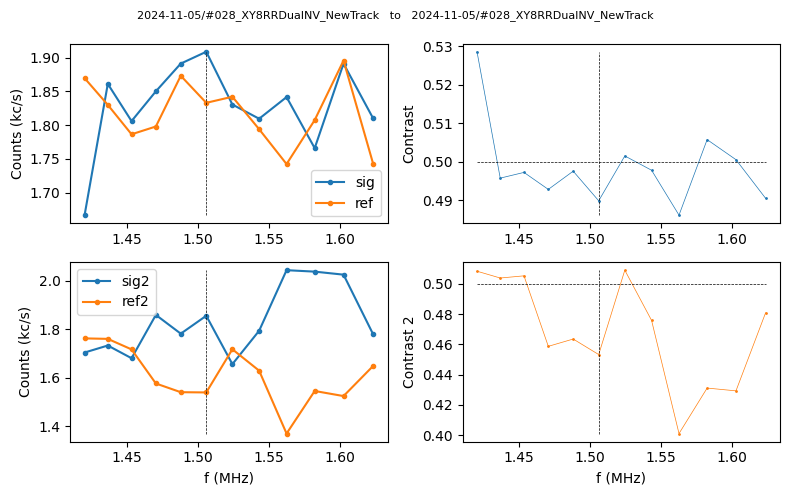

In [2416]:
# For spectroscopy analysis
ifXAxisFreq=1; correctionToTau = 40; correctionToTau2=correctionToTau; markerAt = 1/2/(292+40)*1e3
ifNormedTo01=2

t = (xPlot+correctionToTau)/1e3; t2 = (xPlot+correctionToTau2)/1e3
if ifXAxisFreq: 
    x = 1/(2*t); x2 = 1/(2*t2)
else: 
    x = 8*t*NXY8; x2 = 8*t2*NXY8

y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
y2 = np.average(data2Arr, axis=0); ys2 = np.average(sig2Arr, axis=0); yr2 = np.average(ref2Arr, axis=0)

if ifNormedTo01==1:
    y=-y;y2=-y2
    y = linear_map(y,-(y.max()),y.max(),0,1)
    y2 = linear_map(y2,-(y2.max()),y2.max(),0,1)
elif ifNormedTo01==2:
    y=-y;y2=-y2
    y = linear_map(y,-1,1,0,1)
    y2 = linear_map(y2,-1,1,0,1)
    
if True:
    fig, axs = plt.subplots(2,2,figsize=(8,5))
    axs[0,1].plot(x,y, 'o-', linewidth=0.5,markersize=1, label="contrast")
    axs[0,1].set_ylabel('Contrast')
    axs[0,1].vlines(x=markerAt,ymin=min(y),ymax=max(y), linestyle='--', linewidth=0.5, color='k')
    axs[0,1].hlines(y=0.5, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')
    # axs[0,1].set_xlim((-0.1,4))

    axs[0,0].plot(x, ys, 'o-', markersize=3, label="sig")
    axs[0,0].plot(x, yr, 'o-', markersize=3, label="ref")
    axs[0,0].legend()
    axs[0,0].set_ylabel('Counts (kc/s)')
    axs[0,0].vlines(x=markerAt,ymin=min(min(ys),min(yr)),ymax=max(max(ys),max(yr)), linestyle='--', linewidth=0.5, color='k')
    # axs[0,0].set_ylim((0.2,1.8))

    ################################################################################
    axs[1,1].plot(x2,y2, 'o-', linewidth=0.5,markersize=1, color='C1',label="contrast 2")
    axs[1,1].set_ylabel('Contrast 2')
    axs[1,1].set_xlabel(r"$\tau$ ($\mu$s)")
    axs[1,1].vlines(x=markerAt,ymin=min(y2),ymax=max(y2), linestyle='--', linewidth=0.5, color='k')
    axs[1,1].hlines(y=0.5, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')
    if ifXAxisFreq: axs[1,1].set_xlabel("f (MHz)")
    # axs[1,1].set_xlim((-0.1,2.6))

    axs[1,0].plot(x2, ys2, 'o-', markersize=3, label="sig2")
    axs[1,0].plot(x2, yr2, 'o-', markersize=3, label="ref2")
    axs[1,0].legend()
    axs[1,0].set_xlabel(r"$\tau$ ($\mu$s)")
    if ifXAxisFreq: axs[1,0].set_xlabel("f (MHz)")
    axs[1,0].set_ylabel('Counts (kc/s)')
    axs[1,0].vlines(x=markerAt,ymin=min(min(ys2),min(yr2)),ymax=max(max(ys2),max(yr2)), linestyle='--', linewidth=0.5, color='k')
    # axs[1,0].set_ylim((0.7,2.6))

    s = firstdatafile[31:67] + '   to   ' + datafile[31:67]
    fig.suptitle(s,fontsize=8)

    plt.tight_layout()

if False: 
    N = NXY8*8
    Sf = -np.log(y)/(N*t)*pi
    Sf2 = -np.log(y2)/(N*t2)*pi

    fig, axs = plt.subplots(2,1,figsize=(8,4))
    axs[0].plot(x,Sf, 'o-', linewidth=0.5,markersize=1, label="contrast")
    axs[0].set_ylabel('S(f) (MHz)')
    axs[0].vlines(x=markerAt,ymin=min(Sf),ymax=max(Sf), linestyle='--', linewidth=0.5, color='k')
    # axs[0].vlines(x=markerAt/3,ymin=min(Sf),ymax=max(Sf), linestyle='--', linewidth=0.5, color='k')
    # axs[0].vlines(x=markerAt/5,ymin=min(Sf),ymax=max(Sf), linestyle='--', linewidth=0.5, color='k')
    s = firstdatafile[31:67] + '   to   ' + datafile[31:67]
    axs[0].set_title(s,fontsize=8)
    # axs[0].set_xlim((-0.1,4))
    # axs[0].set_ylim((0.47,0.61))

    axs[1].plot(x2,Sf2, 'o-', linewidth=0.5,markersize=1, color='C1',label="contrast 2")
    axs[1].set_ylabel('S(f) (MHz)')
    axs[1].set_xlabel(r"$\tau$ ($\mu$s)")
    axs[1].vlines(x=markerAt,ymin=min(Sf2),ymax=max(Sf2), linestyle='--', linewidth=0.5, color='k')
    # axs[1].vlines(x=markerAt/3,ymin=min(Sf2),ymax=max(Sf2), linestyle='--', linewidth=0.5, color='k')
    # axs[1].vlines(x=markerAt/5,ymin=min(Sf2),ymax=max(Sf2), linestyle='--', linewidth=0.5, color='k')
    if ifXAxisFreq: axs[1].set_xlabel("f (MHz)")
    # axs[1].set_xlim((-0.1,5.1))

    plt.tight_layout()



In [ ]:
# # Save data
# combined = np.column_stack((x, Sf, x2, Sf2, y, y2))
# folder = 'C:/Users/lukin2dmaterials/data/forDeliv/'; file = 'XY8-5-Noise_011.txt'
# path = folder + file
# np.savetxt(path, combined, delimiter=' ')

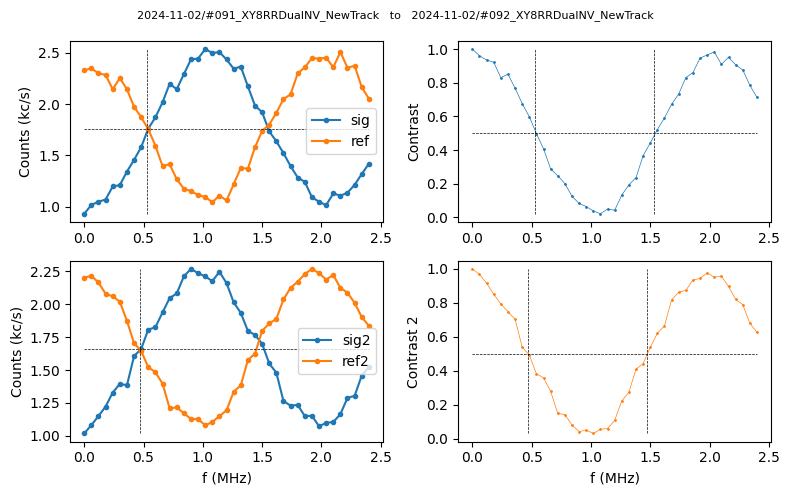

In [1142]:
# For phase analysis
correctionToTau = 40; correctionToTau2 = correctionToTau; markerAt = 0.53; markerAt2 = 0.47; ifNormedTo01=1
t = (240+correctionToTau)/1e3; t2 = (xPlot+correctionToTau2)/1e3
x = xPlot/pi; x2 = xPlot/pi

y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
y2 = np.average(data2Arr, axis=0); ys2 = np.average(sig2Arr, axis=0); yr2 = np.average(ref2Arr, axis=0)

if ifNormedTo01==1: # full contrast defined by data, usually for cosine magnetometry
    y=-y;y2=-y2
    y = linear_map(y,-(y.max()),y.max(),0,1)
    y2 = linear_map(y2,-(y2.max()),y2.max(),0,1)
elif ifNormedTo01==2: # full contrast defined by prev calib
    y=-y;y2=-y2
    y = linear_map(y,-1,1,0,1)
    y2 = linear_map(y2,-1,1,0,1)
    
if True:
    fig, axs = plt.subplots(2,2,figsize=(8,5))
    axs[0,1].plot(x,y, 'o-', linewidth=0.5,markersize=1, label="contrast")
    axs[0,1].set_ylabel('Contrast')
    axs[0,1].vlines(x=markerAt,ymin=min(y),ymax=max(y), linestyle='--', linewidth=0.5, color='k')
    axs[0,1].vlines(x=markerAt+1,ymin=min(y),ymax=max(y), linestyle='--', linewidth=0.5, color='k')
    axs[0,1].hlines(y=0.5, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')
    # axs[0,1].set_xlim((-0.1,4))

    axs[0,0].plot(x, ys, 'o-', markersize=3, label="sig")
    axs[0,0].plot(x, yr, 'o-', markersize=3, label="ref")
    axs[0,0].legend()
    axs[0,0].set_ylabel('Counts (kc/s)')
    axs[0,0].vlines(x=markerAt,ymin=min(ys),ymax=max(ys), linestyle='--', linewidth=0.5, color='k')
    axs[0,0].hlines(y=(max(ys)+min(ys)+max(yr)+min(yr))/4, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')
    # axs[0,0].set_ylim((0.2,1.8))

    ################################################################################
    axs[1,1].plot(x2,y2, 'o-', linewidth=0.5,markersize=1, color='C1',label="contrast 2")
    axs[1,1].set_ylabel('Contrast 2')
    axs[1,1].set_xlabel(r"$\tau$ ($\mu$s)")
    axs[1,1].vlines(x=markerAt2,ymin=min(y2),ymax=max(y2), linestyle='--', linewidth=0.5, color='k')
    axs[1,1].vlines(x=markerAt2+1,ymin=min(y2),ymax=max(y2), linestyle='--', linewidth=0.5, color='k')
    axs[1,1].hlines(y=0.5, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')
    if ifXAxisFreq: axs[1,1].set_xlabel("f (MHz)")
    # axs[1,1].set_xlim((-0.1,2.6))

    axs[1,0].plot(x2, ys2, 'o-', markersize=3, label="sig2")
    axs[1,0].plot(x2, yr2, 'o-', markersize=3, label="ref2")
    axs[1,0].legend()
    axs[1,0].vlines(x=markerAt2,ymin=min(ys2),ymax=max(ys2), linestyle='--', linewidth=0.5, color='k')
    axs[1,0].hlines(y=(max(ys2)+min(ys2)+max(yr2)+min(yr2))/4, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')
    axs[1,0].set_xlabel(r"$\tau$ ($\mu$s)")
    if ifXAxisFreq: axs[1,0].set_xlabel("f (MHz)")
    axs[1,0].set_ylabel('Counts (kc/s)')
    # axs[1,0].set_ylim((0.7,2.6))

    s = firstdatafile[31:67] + '   to   ' + datafile[31:67]
    fig.suptitle(s,fontsize=8)

    plt.tight_layout()

### Cross-dataset analysis

In [ ]:
# # Save data
# combined = np.column_stack((x, Sf, x2, Sf2, y, y2))
# folder = 'C:/Users/lukin2dmaterials/data/forDeliv/'; file = 'XY8-5-Noise_0010.txt'
# path = folder + file
# np.savetxt(path, combined, delimiter=' ')

C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_17948\3536440491.py:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axs[0].plot(x,Sf, 'o-', linewidth=0.5,markersize=1, label="no noise",linestyle='-', color='C0')
C:\Users\lukin2dmaterials\AppData\Local\Temp\ipykernel_17948\3536440491.py:21: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  axs[1].plot(x2,Sf2, 'o-', linewidth=0.5,markersize=1, color='C1',label="no noise",linestyle='-')


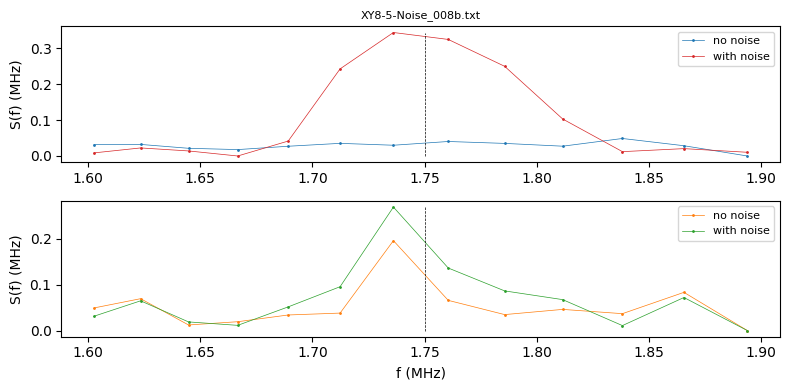

In [426]:
folder = 'C:/Users/lukin2dmaterials/data/forDeliv/'; file = 'XY8-5-noNoise_008.txt'
path = folder + file
loaded = np.loadtxt(path); markerAt = 1.75
x = loaded[:,0]; Sf = loaded[:,1]; x2 = loaded[:,2]; Sf2 = loaded[:,3]

folder = 'C:/Users/lukin2dmaterials/data/forDeliv/'; file = 'XY8-5-Noise_008b.txt'
path = folder + file
loaded = np.loadtxt(path)
xN = loaded[:,0]; SfN = loaded[:,1]; x2N = loaded[:,2]; Sf2N = loaded[:,3]

if True:
    fig, axs = plt.subplots(2,1,figsize=(8,4))
    axs[0].plot(x,Sf, 'o-', linewidth=0.5,markersize=1, label="no noise",linestyle='-', color='C0')
    axs[0].plot(xN,SfN, 'o-', linewidth=0.5,markersize=1, label="with noise", color='C3')
    axs[0].set_ylabel('S(f) (MHz)')
    axs[0].vlines(x=markerAt,ymin=min(Sf),ymax=max(SfN), linestyle='--', linewidth=0.5, color='k')
    s = file
    axs[0].set_title(s,fontsize=8)
    axs[0].legend(fontsize=8)

    axs[1].plot(x2,Sf2, 'o-', linewidth=0.5,markersize=1, color='C1',label="no noise",linestyle='-')
    axs[1].plot(x2N,Sf2N, 'o-', linewidth=0.5,markersize=1, color='C2',label="with noise")
    axs[1].set_ylabel('S(f) (MHz)')
    axs[1].set_xlabel(r"$\tau$ ($\mu$s)")
    axs[1].vlines(x=markerAt,ymin=min(Sf2),ymax=max(Sf2N), linestyle='--', linewidth=0.5, color='k')
    axs[1].set_xlabel("f (MHz)")
    axs[1].legend(fontsize=8)
    plt.tight_layout()

In [ ]:
f = np.linspace(4e6,5.4e6,201)
start = 60; end = 220
t = 1/(2*f)*1e9;    t = (2*np.rint(t/2)); tausArray = t
t = t[t>end]
t1 = np.linspace(start,end,81);    tausArray = np.concatenate((t1,t[::-1]))
print(tausArray)
print(np.shape(tausArray))
1/(2*200)*1000

### Sweep RF amplitude

In [194]:
# XY8 sweep power
days = np.linspace(1,31,31); mos = np.linspace(9,10,2); count=0
dataArr = []; sigArr = []; refArr = []; idxs = []; data2Arr=[]; sig2Arr=[]; ref2Arr=[]
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-11-' + str(int(day)).zfill(2) + '/'
    try:
        for dataFolder in os.listdir(mainFolder):
            if 'XY8RRDualNV_NewTrack' in dataFolder:
                if dataFolder[4] == '_': idx = int(dataFolder[1:4])
                else: idx = int(dataFolder[1:5])
                if (day==5 and idx >= 29 and idx <= 59): #N=5 1.5625 MHz 100 kHz 0.25 V
                    datafile = mainFolder + dataFolder +'/XY8RRDualNV_NewTrackObject_sig_set.dat'
                    x_s, sig, ref, sig2, ref2 = dr.readDataNoPlotDualSingleDatapoint(datafile)
                    xPlot = np.array(x_s); sig = np.array(sig); ref = np.array(ref); sig2 = np.array(sig2); ref2 = np.array(ref2)
                    NXY8 = 10
                    
                    contrast = (sig-ref)/(sig+ref); contrast2 = (sig2-ref2)/(sig2+ref2)
                    dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)
                    data2Arr.append(contrast2); sig2Arr.append(sig2); ref2Arr.append(ref2)

                    if count==0: firstdatafile = datafile
                    count+=1
    except:pass
                
print(np.shape(dataArr))
dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)
data2Arr = np.array(data2Arr); sig2Arr = np.array(sig2Arr); ref2Arr = np.array(ref2Arr)

(31,)


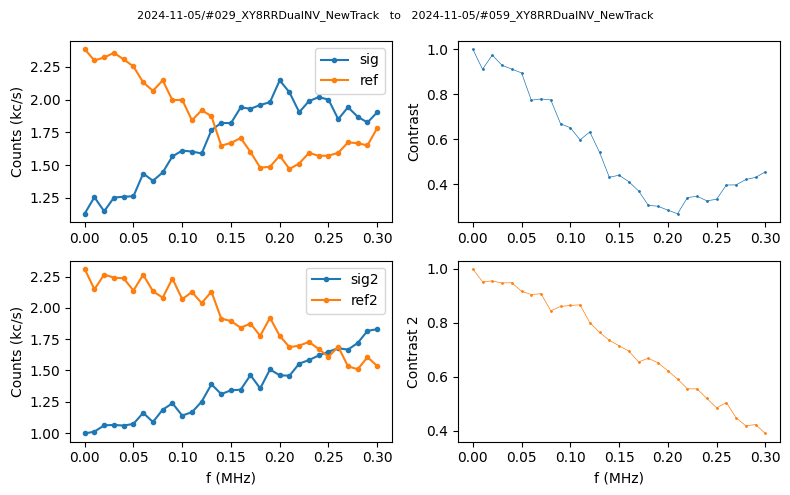

In [2421]:
ifXAxisFreq = 1; correctionToTau = 40; correctionToTau2 = correctionToTau; markerAt = 1.506024; ifNormedTo01=1

t = (xPlot+correctionToTau)/1e3; t2 = (xPlot+correctionToTau2)/1e3
if ifXAxisFreq: 
    x = 1/(2*t); x2 = 1/(2*t2)
else: 
    x = 8*t*NXY8; x2 = 8*t2*NXY8

x = x2=np.linspace(0,0.3,31)
# x=x2=x[0:8]

y = dataArr; ys = sigArr; yr = refArr
y2 = data2Arr; ys2 = sig2Arr; yr2 = ref2Arr

if ifNormedTo01==1:
    y=-y;y2=-y2
    y = linear_map(y,-(y.max()),y.max(),0,1)
    y2 = linear_map(y2,-(y2.max()),y2.max(),0,1)
elif ifNormedTo01==2:
    y=-y;y2=-y2
    y = linear_map(y,-1,1,0,1)
    y2 = linear_map(y2,-1,1,0,1)
    
if True:
    fig, axs = plt.subplots(2,2,figsize=(8,5))
    axs[0,1].plot(x,y, 'o-', linewidth=0.5,markersize=1, label="contrast")
    axs[0,1].set_ylabel('Contrast')
    # axs[0,1].vlines(x=markerAt,ymin=min(y),ymax=max(y), linestyle='--', linewidth=0.5, color='k')
    # axs[0,1].hlines(y=0.5, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')
    # axs[0,1].set_xlim((-0.1,4))

    axs[0,0].plot(x, ys, 'o-', markersize=3, label="sig")
    axs[0,0].plot(x, yr, 'o-', markersize=3, label="ref")
    axs[0,0].legend()
    axs[0,0].set_ylabel('Counts (kc/s)')
    # axs[0,0].set_ylim((0.2,1.8))

    ################################################################################
    axs[1,1].plot(x2,y2, 'o-', linewidth=0.5,markersize=1, color='C1',label="contrast 2")
    axs[1,1].set_ylabel('Contrast 2')
    axs[1,1].set_xlabel(r"$\tau$ ($\mu$s)")
    # axs[1,1].vlines(x=markerAt,ymin=min(y2),ymax=max(y2), linestyle='--', linewidth=0.5, color='k')
    # axs[1,1].hlines(y=0.5, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')
    if ifXAxisFreq: axs[1,1].set_xlabel("f (MHz)")
    # axs[1,1].set_xlim((-0.1,2.6))

    axs[1,0].plot(x2, ys2, 'o-', markersize=3, label="sig2")
    axs[1,0].plot(x2, yr2, 'o-', markersize=3, label="ref2")
    axs[1,0].legend()
    axs[1,0].set_xlabel(r"$\tau$ ($\mu$s)")
    if ifXAxisFreq: axs[1,0].set_xlabel("f (MHz)")
    axs[1,0].set_ylabel('Counts (kc/s)')
    # axs[1,0].set_ylim((0.7,2.6))

    s = firstdatafile[31:67] + '   to   ' + datafile[31:67]
    fig.suptitle(s,fontsize=8)

    plt.tight_layout()

### Sweep N

In [285]:
# XY8 sweep N
days = np.linspace(1,31,31); mos = np.linspace(9,10,2); count=0
dataArr = []; sigArr = []; refArr = []; idxs = []; data2Arr=[]; sig2Arr=[]; ref2Arr=[]
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-11-' + str(int(day)).zfill(2) + '/'
    try:
        for dataFolder in os.listdir(mainFolder):
            if 'XY8RRDualNV_NewTrack' in dataFolder:
                if dataFolder[4] == '_': idx = int(dataFolder[1:4])
                else: idx = int(dataFolder[1:5])
                if (day==7 and idx>=5): 
                    datafile = mainFolder + dataFolder +'/XY8RRDualNV_NewTrackObject_sig_set.dat'
                    x_s, sig, ref, sig2, ref2 = dr.readDataNoPlotDual(datafile)
                    xPlot = np.array(x_s); sig = np.array(sig); ref = np.array(ref); sig2 = np.array(sig2); ref2 = np.array(ref2)
                    
                    # Sort data taken in random order
                    sorted_indices = np.argsort(xPlot)
                    xPlot = xPlot[sorted_indices]
                    sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                    ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]
                    
                    contrast = (sig-ref)/(sig+ref); contrast2 = (sig2-ref2)/(sig2+ref2)
                    dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)
                    data2Arr.append(contrast2); sig2Arr.append(sig2); ref2Arr.append(ref2)

                    if count==0: firstdatafile = datafile
                    count+=1
    except:pass
print(np.shape(dataArr))
dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)
data2Arr = np.array(data2Arr); sig2Arr = np.array(sig2Arr); ref2Arr = np.array(ref2Arr)

(1, 20)


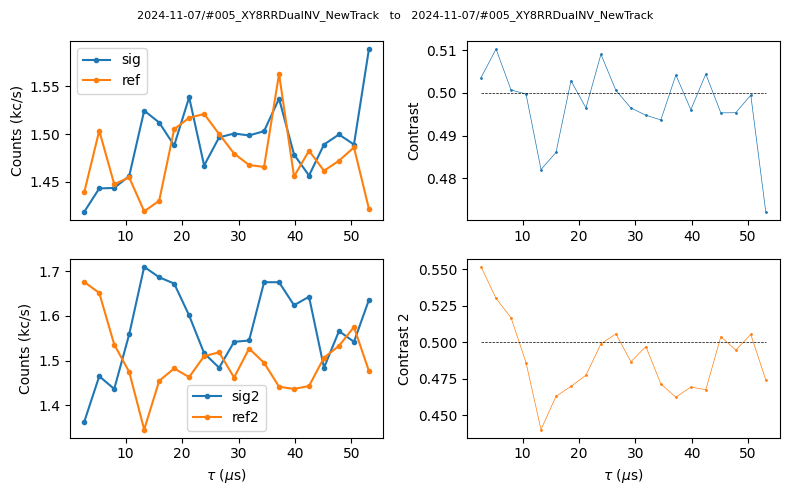

In [286]:
correctionToTau=36; markerAt=1.506024; ifNormedTo01=2; correctionToTau2=correctionToTau
tau = int(1/(2*markerAt*1e6)*1e9-36)
t = (tau+correctionToTau)/1e3; t2 = (tau+correctionToTau2)/1e3

x = 8*t*xPlot; x2 = 8*t2*xPlot

y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
y2 = np.average(data2Arr, axis=0); ys2 = np.average(sig2Arr, axis=0); yr2 = np.average(ref2Arr, axis=0)

if ifNormedTo01==1:
    y=-y;y2=-y2
    y = linear_map(y,-(y.max()),y.max(),0,1)
    y2 = linear_map(y2,-(y2.max()),y2.max(),0,1)
elif ifNormedTo01==2:
    y=-y;y2=-y2
    y = linear_map(y,-1,1,0,1)
    y2 = linear_map(y2,-1,1,0,1)
    
if True:
    fig, axs = plt.subplots(2,2,figsize=(8,5))
    axs[0,0].plot(x, ys, 'o-', markersize=3, label="sig")
    axs[0,0].plot(x, yr, 'o-', markersize=3, label="ref")
    axs[0,0].legend()
    axs[0,0].set_ylabel('Counts (kc/s)')

    axs[0,1].plot(x,y, 'o-', linewidth=0.5,markersize=1, label="contrast")
    axs[0,1].set_ylabel('Contrast')
    axs[0,1].hlines(y=0.5, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')

    ################################################################################   
    axs[1,0].plot(x2, ys2, 'o-', markersize=3, label="sig2")
    axs[1,0].plot(x2, yr2, 'o-', markersize=3, label="ref2")
    axs[1,0].legend()
    axs[1,0].set_xlabel(r"$\tau$ ($\mu$s)")
    axs[1,0].set_ylabel('Counts (kc/s)')

    axs[1,1].plot(x2,y2, 'o-', linewidth=0.5,markersize=1, color='C1',label="contrast 2")
    axs[1,1].set_ylabel('Contrast 2')
    axs[1,1].set_xlabel(r"$\tau$ ($\mu$s)")
    axs[1,1].hlines(y=0.5, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')

    s = firstdatafile[31:67] + '   to   ' + datafile[31:67]
    fig.suptitle(s,fontsize=8)

    plt.tight_layout()

# Auto-correlation XY8 RR Dual NV

In [109]:
# XY8
days = np.linspace(1,25,25); mos = np.linspace(9,10,2); count=0
dataArr = []; sigArr = []; refArr = []; idxs = []; data2Arr=[]; sig2Arr=[]; ref2Arr=[]
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-10-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'AutoCorrXY8RRDualNV' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            # if (day==25 and ((idx>=7 and idx<=11) or idx==38)): #N=3
            if (day==25 and idx>=39): #N=5
                datafile = mainFolder + dataFolder +'/AutoCorrXY8RRDualNVObject_sig_set.dat'
                x_s, sig, ref, sig2, ref2 = dr.readDataNoPlotDual(datafile)
                xPlot = np.array(x_s); sig = np.array(sig); ref = np.array(ref); sig2 = np.array(sig2); ref2 = np.array(ref2)
                NXY8 = 2
                # Sort data taken in random order
                sorted_indices = np.argsort(xPlot)
                xPlot = xPlot[sorted_indices]
                sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]
                
                contrast = (sig-ref)/(sig+ref); contrast2 = (sig2-ref2)/(sig2+ref2)
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)
                data2Arr.append(contrast2); sig2Arr.append(sig2); ref2Arr.append(ref2)

                if count==0: firstdatafile = datafile
                count+=1
                
print(np.shape(dataArr))
dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)
data2Arr = np.array(data2Arr); sig2Arr = np.array(sig2Arr); ref2Arr = np.array(ref2Arr)

(1, 65)


In [110]:
if False:
    # Replace 'nan' values with the value of the item preceding it
    nan_indices = np.isnan(dataArr)
    dataArr[nan_indices] = np.roll(dataArr, 1, axis=1)[nan_indices]
    nan_indices = np.isnan(data2Arr)
    data2Arr[nan_indices] = np.roll(data2Arr, 1, axis=1)[nan_indices]


    fig, axs = plt.subplots(2,3,figsize=(8,8))
    N_datasets = np.size(dataArr,0)
    y = np.linspace(1,N_datasets, N_datasets)
    X, Y = np.meshgrid(xPlot/1e3, y)

    plot = axs[0,0].pcolormesh(X,Y, dataArr, cmap='inferno')
    fig.colorbar(plot, orientation='vertical', ax=axs[0,0])
    axs[0,0].set_ylabel('Iteration')
    axs[0,0].set_title('Contrast',fontsize=10)
    # plot.set_clim(0.1,1.2)

    plot1 = axs[0,1].pcolormesh(X,Y, sigArr, cmap='inferno')
    axs[0,1].set_title('sig',fontsize=10)
    cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[0,1])
    # plot1.set_clim(0,4)

    plot2 = axs[0,2].pcolormesh(X,Y, refArr, cmap='inferno')
    axs[0,2].set_title('ref',fontsize=10)
    cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[0,2])
    cb2.set_label("Counts in kc/s",fontsize=10)
    # plot2.set_clim(0,4)

    plot = axs[1,0].pcolormesh(X,Y, data2Arr, cmap='inferno')
    fig.colorbar(plot, orientation='vertical', ax=axs[1,0])
    axs[1,0].set_xlabel('$\\tau$ ($\mu$s)')
    axs[1,0].set_ylabel('Iteration')
    axs[1,0].set_title('Contrast 2',fontsize=10)
    # plot.set_clim(0.1,1.2)

    plot1 = axs[1,1].pcolormesh(X,Y, sig2Arr, cmap='inferno')
    axs[1,1].set_xlabel('$\\tau$ ($\mu$s)')
    axs[1,1].set_title('sig2',fontsize=10)
    cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1,1])
    # plot1.set_clim(0,4)

    plot2 = axs[1,2].pcolormesh(X,Y, ref2Arr, cmap='inferno')
    axs[1,2].set_xlabel('$\\tau$ ($\mu$s)')
    axs[1,2].set_title('ref2',fontsize=10)
    cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[1,2])
    cb2.set_label("Counts in kc/s",fontsize=10)
    # plot2.set_clim(0,4)

    for i in range(2):
        for j in range(3):
            axs[i,j].set_xscale('log')

    plt.tight_layout()

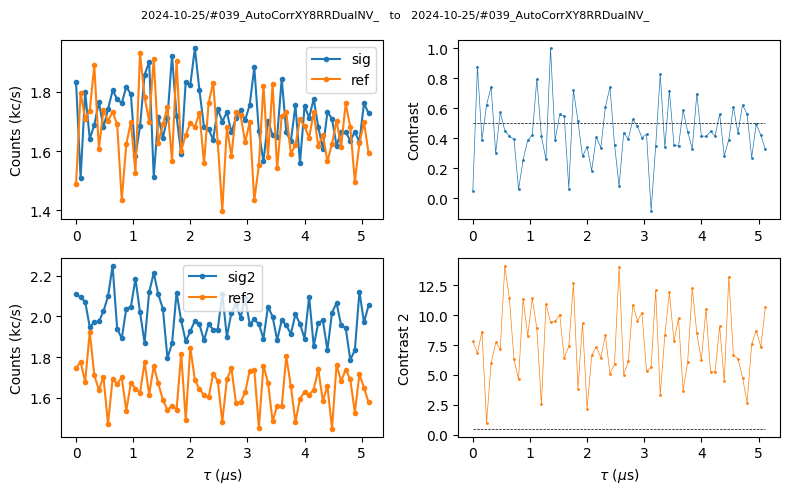

In [111]:
ifXAxisFreq = 0; markerAt = 1.5625; ifNormedTo01=1
t = (xPlot)/1e3; t2 = (xPlot)/1e3
if ifXAxisFreq: 
    x = 1/(2*t); x2 = 1/(2*t2)
else: 
    x = t; x2 = t2

y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
y2 = np.average(data2Arr, axis=0); ys2 = np.average(sig2Arr, axis=0); yr2 = np.average(ref2Arr, axis=0)

if ifNormedTo01==1:
    y=-y;y2=-y2
    y = linear_map(y,-(y.max()),y.max(),0,1)
    y2 = linear_map(y2,-(y2.max()),y2.max(),0,1)
elif ifNormedTo01==2:
    y=-y;y2=-y2
    y = linear_map(y,-1,1,0,1)
    y2 = linear_map(y2,-1,1,0,1)
    
if True:
    fig, axs = plt.subplots(2,2,figsize=(8,5))
    axs[0,1].plot(x,y, 'o-', linewidth=0.5,markersize=1, label="contrast")
    axs[0,1].set_ylabel('Contrast')
    # axs[0,1].vlines(x=markerAt,ymin=min(y),ymax=max(y), linestyle='--', linewidth=0.5, color='k')
    axs[0,1].hlines(y=0.5, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')
    # axs[0,1].set_xlim((-0.1,4))

    axs[0,0].plot(x, ys, 'o-', markersize=3, label="sig")
    axs[0,0].plot(x, yr, 'o-', markersize=3, label="ref")
    axs[0,0].legend()
    axs[0,0].set_ylabel('Counts (kc/s)')
    # axs[0,0].set_ylim((0.2,1.8))

    ################################################################################
    axs[1,1].plot(x2,y2, 'o-', linewidth=0.5,markersize=1, color='C1',label="contrast 2")
    axs[1,1].set_ylabel('Contrast 2')
    axs[1,1].set_xlabel(r"$\tau$ ($\mu$s)")
    # axs[1,1].vlines(x=markerAt,ymin=min(y2),ymax=max(y2), linestyle='--', linewidth=0.5, color='k')
    axs[1,1].hlines(y=0.5, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')
    if ifXAxisFreq: axs[1,1].set_xlabel("f (MHz)")
    # axs[1,1].set_xlim((-0.1,2.6))

    axs[1,0].plot(x2, ys2, 'o-', markersize=3, label="sig2")
    axs[1,0].plot(x2, yr2, 'o-', markersize=3, label="ref2")
    axs[1,0].legend()
    axs[1,0].set_xlabel(r"$\tau$ ($\mu$s)")
    if ifXAxisFreq: axs[1,0].set_xlabel("f (MHz)")
    axs[1,0].set_ylabel('Counts (kc/s)')
    # axs[1,0].set_ylim((0.7,2.6))

    s = firstdatafile[31:67] + '   to   ' + datafile[31:67]
    fig.suptitle(s,fontsize=8)

    plt.tight_layout()

if False: 
    N = NXY8*8
    Sf = -np.log(y)/(N*t)*pi
    Sf2 = -np.log(y2)/(N*t2)*pi

    fig, axs = plt.subplots(2,1,figsize=(8,4))
    axs[0].plot(x,Sf, 'o-', linewidth=0.5,markersize=1, label="contrast")
    axs[0].set_ylabel('S(f) (MHz)')
    axs[0].vlines(x=markerAt,ymin=min(Sf),ymax=max(Sf), linestyle='--', linewidth=0.5, color='k')
    # axs[0].vlines(x=markerAt/3,ymin=min(Sf),ymax=max(Sf), linestyle='--', linewidth=0.5, color='k')
    # axs[0].vlines(x=markerAt/5,ymin=min(Sf),ymax=max(Sf), linestyle='--', linewidth=0.5, color='k')
    s = firstdatafile[31:67] + '   to   ' + datafile[31:67]
    axs[0].set_title(s,fontsize=8)
    # axs[0].set_xlim((-0.1,4))
    # axs[0].set_ylim((0.47,0.61))

    axs[1].plot(x2,Sf2, 'o-', linewidth=0.5,markersize=1, color='C1',label="contrast 2")
    axs[1].set_ylabel('S(f) (MHz)')
    axs[1].set_xlabel(r"$\tau$ ($\mu$s)")
    axs[1].vlines(x=markerAt,ymin=min(Sf2),ymax=max(Sf2), linestyle='--', linewidth=0.5, color='k')
    # axs[1].vlines(x=markerAt/3,ymin=min(Sf2),ymax=max(Sf2), linestyle='--', linewidth=0.5, color='k')
    # axs[1].vlines(x=markerAt/5,ymin=min(Sf2),ymax=max(Sf2), linestyle='--', linewidth=0.5, color='k')
    if ifXAxisFreq: axs[1].set_xlabel("f (MHz)")
    # axs[1].set_xlim((-0.1,5.1))

    plt.tight_layout()



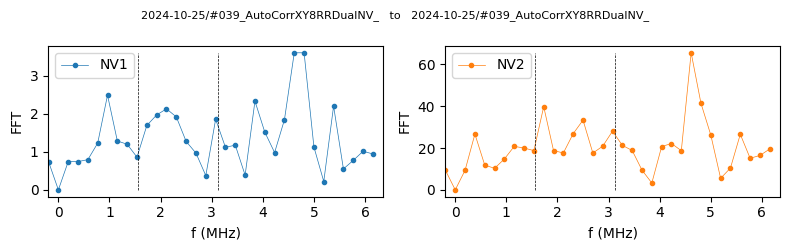

In [112]:
Nzero = 0; y_zero = np.concatenate((y,np.zeros(len(y)*Nzero))); delta_t=80e-9
f,yfourier = fourier(y_zero,delta_t=delta_t)
y_zero2 = np.concatenate((y2,np.zeros(len(y2)*Nzero)))
f,yfourier2 = fourier(y_zero2,delta_t=delta_t)

fig, axs = plt.subplots(1,2,figsize=(8,2.5))
axs[0].plot(f/1e6,yfourier,'o-', linewidth=0.5, markersize=3,label='NV1' )
axs[0].vlines(x=markerAt,ymin=min(yfourier),ymax=max(yfourier), linestyle='--', linewidth=0.5, color='k')
axs[0].vlines(x=2*markerAt,ymin=min(yfourier),ymax=max(yfourier), linestyle='--', linewidth=0.5, color='k')
axs[0].set_xlim((-0.2,np.max(f/1e6)+0.2))
axs[0].set_xlabel('f (MHz)')
axs[0].set_ylabel('FFT')
axs[0].legend()

axs[1].plot(f/1e6,yfourier2,'o-', linewidth=0.5, markersize=3,label='NV2',color='C1')
axs[1].vlines(x=markerAt,ymin=min(yfourier2),ymax=max(yfourier2), linestyle='--', linewidth=0.5, color='k')
axs[1].vlines(x=2*markerAt,ymin=min(yfourier2),ymax=max(yfourier2), linestyle='--', linewidth=0.5, color='k')
axs[1].set_xlim((-0.2,np.max(f/1e6)+0.2))
axs[1].set_xlabel('f (MHz)')
axs[1].set_ylabel('FFT')
axs[1].legend()

s = firstdatafile[31:67] + '   to   ' + datafile[31:67]
fig.suptitle(s,fontsize=8)

plt.tight_layout()

# Confocal RR

In [211]:
# Repeat measuring cfcRR
days = np.linspace(1,12,12); count=0
sigs = None; sigs2 = None
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-09-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'ConfocalRR' in dataFolder:
            idx = int(dataFolder[1:4])
            if day==9 and idx == 45:
                finalDataFolder = mainFolder + dataFolder
                datafile = finalDataFolder +'/ConfocalRRObject_y_set_ConfocalRRObject_sig2_set.dat'

                x,y,sig2,sig = dr.readDataConfocalRR(datafile)

                if sigs is None: sigs = sig
                else: sigs = np.concatenate((sigs, sig),axis=1)
                if sigs2 is None: sigs2 = sig2
                else: sigs2 = np.concatenate((sigs2, sig2),axis=1)

                if count==0: firstdatafile = datafile
                count+=1

print(np.shape(sigs))
# sig = (sig+sig2)/2 # when mapping 1 NV only and turn off 2nd readout


(61, 61)


### Single laser

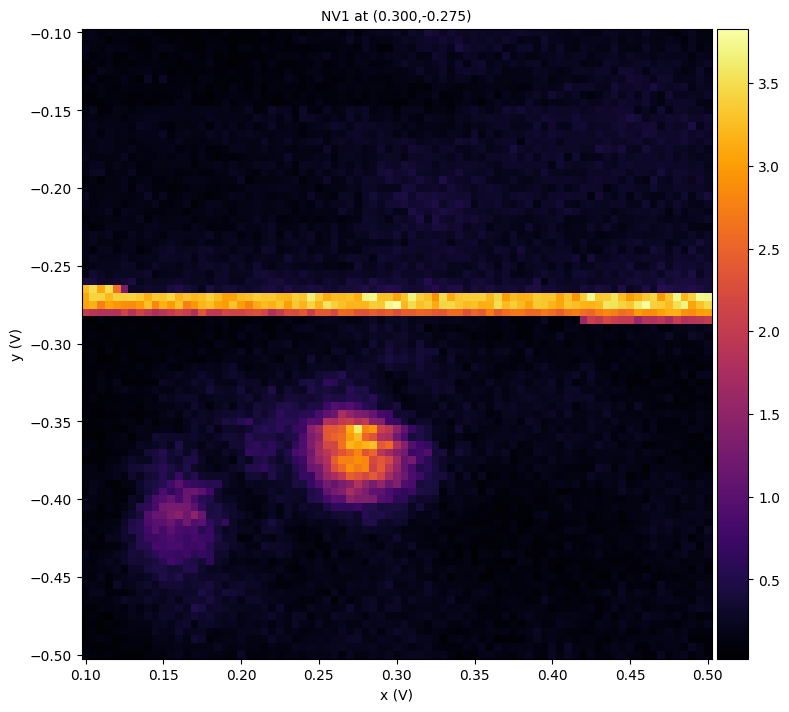

In [942]:
fig,ax = plt.subplots(figsize=(8,10))
fontsize=10
plot0 = ax.pcolormesh(x,y,sig, cmap='inferno')
ax.set_xlabel('x (V)')
ax.set_ylabel('y (V)')
ax.set_aspect('equal')
# axs[0].set_xlim((0.1,0.4))

divider = make_axes_locatable(ax)
cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
cb0 = fig.colorbar(plot0, orientation='vertical', ax=ax,cax=cbar_ax)

idx = np.unravel_index(np.argmax(sig), sig.shape)
ax.set_title('NV1 at (%.3f,%.3f)' % (x[idx], y[idx]),fontsize=fontsize)

plt.tight_layout()

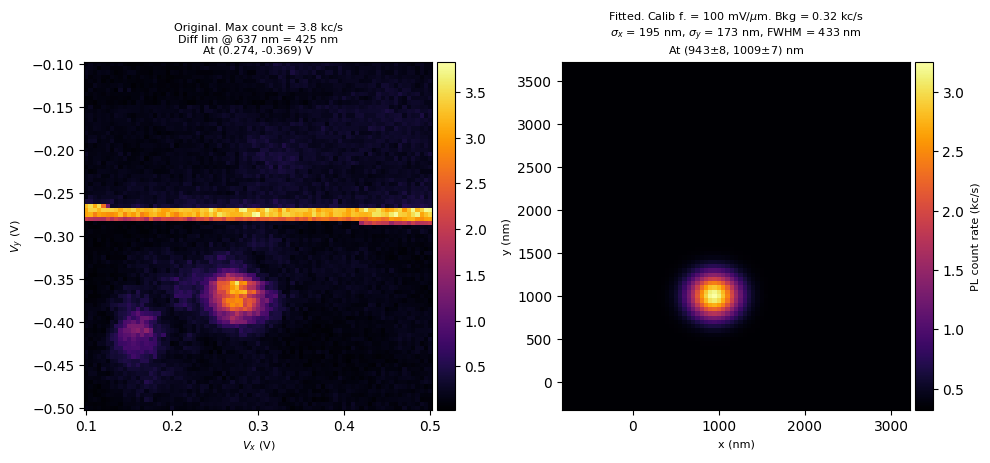

In [943]:
m,n = np.shape(sig); fontsize=8
calib = 100; wvl = 637; xs = []; ys = []
x00 = 0.18; y00 = -0.47

fig, ax = plt.subplots(1, 2,  figsize=(10,5))

if i==0: data = sig
else: data = sig2
z = data.ravel()

# Initial guesses for the parameters (amplitude, x0, y0, sigma_x, sigma_y, offset)
initial_guess = [25, 0.27, -0.37, 0.02, 0.02, 1]

# Fit the 2D Gaussian to the data
fit_params, pcov = curve_fit(gaussian_2d, (x, y), z, p0=initial_guess)
perr = np.sqrt(np.diag(pcov))

# Extract the fitted parameters
amplitude_fit, x0_fit, y0_fit, sigma_x_fit, sigma_y_fit, offset_fit = fit_params
xs.append(x0_fit); ys.append(y0_fit)

x0_fit_nm = (x0_fit-x00)*1e3/calib*1e3; y0_fit_nm = (y0_fit-y00)*1e3/calib*1e3
x0err = perr[1]*1e3/calib*1e3; y0err = perr[2]*1e3/calib*1e3

# Evaluate the fitted Gaussian function at all (x, y) points
fitted_data = gaussian_2d((x, y), *fit_params)
fitted_data = fitted_data.reshape(m,n)

# Plot the original data and the fitted Gaussian
plot0 = ax[0].pcolormesh(x,y, data, cmap='inferno')

s1 = 'Original. Max count = %.1f kc/s' % (np.max(data))
s2 = 'Diff lim @ %.0f nm = %.0f nm' % (wvl, wvl/2/0.75)
s3 = 'At (%.3f, %.3f) V' % (x0_fit,y0_fit)
ax[0].set_title(s1 + "\n" + s2 + "\n" +s3, fontsize=fontsize)

ax[0].set_xlabel('$V_x$ (V)',fontsize=fontsize)
ax[0].set_ylabel('$V_y$ (V)',fontsize=fontsize)
ax[0].set_aspect('equal')

############################################################################
xnm = (x-x00)*1e3/calib*1e3; ynm = (y-y00)*1e3/calib*1e3
plot1 = ax[1].pcolormesh(xnm, ynm, fitted_data, cmap='inferno')
sx =  np.abs(fit_params[3]*1e3/calib*1e3); sy = np.abs(fit_params[4]*1e3/calib*1e3)

s1 = "Fitted. Calib f. = %.0f mV/$\mu$m. Bkg = %.2f kc/s" % (calib, fit_params[5])
s2 = "$\sigma_x$ = %.0f nm, $\sigma_y$ = %.0f nm, FWHM = %.0f nm" % (sx, sy, (sx+sy)/2*2.355)
s3 = 'At (%.0f$\pm$%.0f, %.0f$\pm$%.0f) nm' % (x0_fit_nm, x0err, y0_fit_nm, y0err)
ax[1].set_title(s1 + "\n" + s2 + "\n" +s3, fontsize=fontsize)

ax[1].set_xlabel('x (nm)',fontsize=fontsize)
ax[1].set_ylabel('y (nm)',fontsize=fontsize)
ax[1].set_aspect('equal')

divider = make_axes_locatable(ax[0])
cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
cb0 = fig.colorbar(plot0, orientation='vertical', ax=ax[0],cax=cbar_ax)

divider = make_axes_locatable(ax[1])
cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=ax[1],cax=cbar_ax)
cb1.set_label('PL count rate (kc/s)',fontsize=fontsize)

plt.tight_layout()
plt.show()

# xs = np.array(xs); ys = np.array(ys)
# delta_x = np.abs(xs[0]-xs[1])*1e3/calib*1e3
# delta_y = np.abs(ys[0]-ys[1])*1e3/calib*1e3
# dist = np.sqrt(delta_x**2 + delta_y**2)
# print(delta_x, delta_y, dist)

### 2 lasers

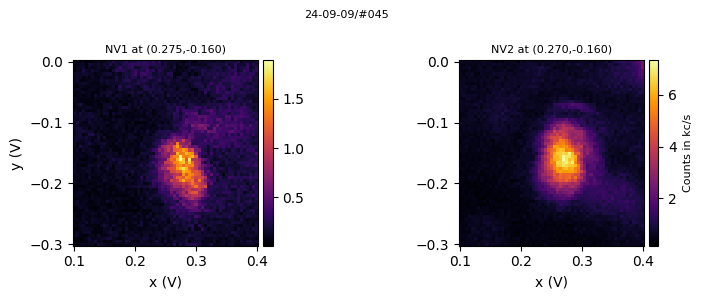

In [212]:
fig,axs = plt.subplots(1,2,figsize=(8,3))
fontsize=8
plot0 = axs[0].pcolormesh(x,y,sig, cmap='inferno')
axs[0].set_xlabel('x (V)')
axs[0].set_ylabel('y (V)')
axs[0].set_aspect('equal')
# axs[0].set_xlim((0.1,0.4))

divider = make_axes_locatable(axs[0])
cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
cb0 = fig.colorbar(plot0, orientation='vertical', ax=axs[0],cax=cbar_ax)

idx = np.unravel_index(np.argmax(sig), sig.shape)
axs[0].set_title('NV1 at (%.3f,%.3f)' % (x[idx], y[idx]),fontsize=fontsize)

########################################################

ifAddSig = 0
plot1 = axs[1].pcolormesh(x,y,sig2+ifAddSig*sig, cmap='inferno')
axs[1].set_xlabel('x (V)')
axs[1].set_aspect('equal')

divider = make_axes_locatable(axs[1])
cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1],cax=cbar_ax)
cb1.set_label("Counts in kc/s",fontsize=fontsize)

idx = np.unravel_index(np.argmax(sig2+ifAddSig*sig), sig2.shape)
axs[1].set_title('NV2 at (%.3f,%.3f)' % (x[idx], y[idx]),fontsize=fontsize)

s = firstdatafile[33:46]
fig.suptitle(s,fontsize=fontsize)

plt.tight_layout()

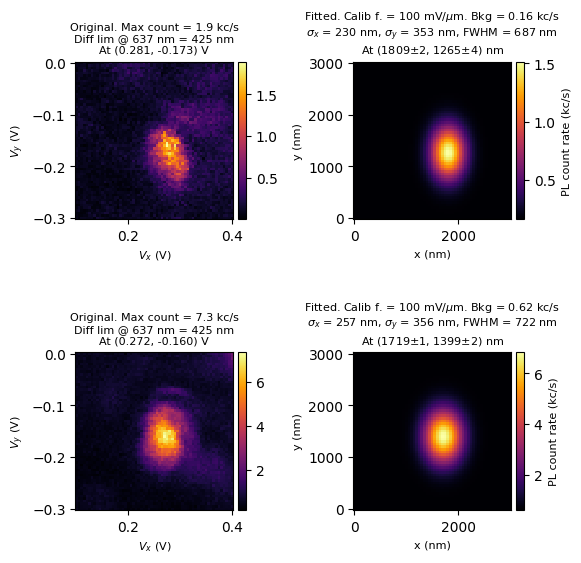

90.60406430961177 133.52466908533285 161.3627395769169 7.035194024258238


In [221]:
m,n = np.shape(sig); fontsize=8
calib = 100; wvl = 637; xs = []; ys = []; x0errs = []; y0errs = []
x00 = 0.1; y00 = -0.3

fig, ax = plt.subplots(2, 2,  figsize=(6,6))
for i in range(2):
    if i==0: data = sig
    else: data = sig2
    z = data.ravel()

    # Initial guesses for the parameters (amplitude, x0, y0, sigma_x, sigma_y, offset)
    initial_guess = [25, 0.28, -0.15, 0.02, 0.02, 1]

    # Fit the 2D Gaussian to the data
    fit_params, pcov = curve_fit(gaussian_2d, (x, y), z, p0=initial_guess)
    perr = np.sqrt(np.diag(pcov))

    # Extract the fitted parameters
    amplitude_fit, x0_fit, y0_fit, sigma_x_fit, sigma_y_fit, offset_fit = fit_params
    xs.append(x0_fit); ys.append(y0_fit)

    x0_fit_nm = (x0_fit-x00)*1e3/calib*1e3; y0_fit_nm = (y0_fit-y00)*1e3/calib*1e3
    x0err = perr[1]*1e3/calib*1e3; y0err = perr[2]*1e3/calib*1e3

    # Evaluate the fitted Gaussian function at all (x, y) points
    fitted_data = gaussian_2d((x, y), *fit_params)
    fitted_data = fitted_data.reshape(m,n)

    # Plot the original data and the fitted Gaussian
    plot0 = ax[i,0].pcolormesh(x,y, data, cmap='inferno')

    s1 = 'Original. Max count = %.1f kc/s' % (np.max(data))
    s2 = 'Diff lim @ %.0f nm = %.0f nm' % (wvl, wvl/2/0.75)
    s3 = 'At (%.3f, %.3f) V' % (x0_fit,y0_fit)
    ax[i,0].set_title(s1 + "\n" + s2 + "\n" +s3, fontsize=fontsize)

    ax[i,0].set_xlabel('$V_x$ (V)',fontsize=fontsize)
    ax[i,0].set_ylabel('$V_y$ (V)',fontsize=fontsize)
    ax[i,0].set_aspect('equal')
    
############################################################################
    xnm = (x-x00)*1e3/calib*1e3; ynm = (y-y00)*1e3/calib*1e3
    plot1 = ax[i,1].pcolormesh(xnm, ynm, fitted_data, cmap='inferno')
    sx =  np.abs(fit_params[3]*1e3/calib*1e3); sy = np.abs(fit_params[4]*1e3/calib*1e3)

    s1 = "Fitted. Calib f. = %.0f mV/$\mu$m. Bkg = %.2f kc/s" % (calib, fit_params[5])
    s2 = "$\sigma_x$ = %.0f nm, $\sigma_y$ = %.0f nm, FWHM = %.0f nm" % (sx, sy, (sx+sy)/2*2.355)
    s3 = 'At (%.0f$\pm$%.0f, %.0f$\pm$%.0f) nm' % (x0_fit_nm, x0err, y0_fit_nm, y0err)
    ax[i,1].set_title(s1 + "\n" + s2 + "\n" +s3, fontsize=fontsize)
    if i==0: s_later = s3

    x0errs.append(x0err); y0errs.append(y0err)

    ax[i,1].set_xlabel('x (nm)',fontsize=fontsize)
    ax[i,1].set_ylabel('y (nm)',fontsize=fontsize)
    ax[i,1].set_aspect('equal')

    divider = make_axes_locatable(ax[i,0])
    cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
    cb0 = fig.colorbar(plot0, orientation='vertical', ax=ax[i,0],cax=cbar_ax)

    divider = make_axes_locatable(ax[i,1])
    cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
    cb1 = fig.colorbar(plot1, orientation='vertical', ax=ax[i,1],cax=cbar_ax)
    cb1.set_label('PL count rate (kc/s)',fontsize=fontsize)

plt.tight_layout()
plt.show()

xs = np.array(xs); ys = np.array(ys); x0errs=np.array(x0errs); y0errs = np.array(y0errs)
delta_x = np.abs(xs[0]-xs[1])*1e3/calib*1e3
delta_y = np.abs(ys[0]-ys[1])*1e3/calib*1e3
dist = np.sqrt(delta_x**2 + delta_y**2)
err_dist = (delta_x*np.sum(x0errs) + delta_y*np.sum(y0errs))/dist
print(delta_x, delta_y, dist,err_dist)


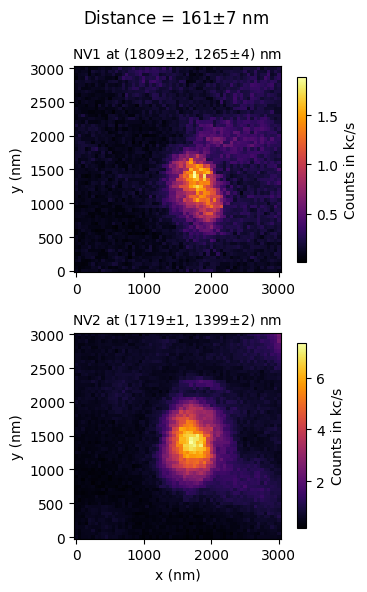

In [222]:
fig,axs = plt.subplots(2,1,figsize=(4,6))
fontsize=10
plot0 = axs[0].pcolormesh(xnm,ynm,sig, cmap='inferno')
cb0 = fig.colorbar(plot0, orientation='vertical', ax=axs[0],shrink=.9)
cb0.set_label("Counts in kc/s",fontsize=fontsize)
axs[0].set_ylabel('y (nm)')
axs[0].set_aspect('equal')
idx = np.unravel_index(np.argmax(sig), sig.shape)
axs[0].set_title('NV1 a' + s_later[1:],fontsize=fontsize)

ifAddSig = 0
plot1 = axs[1].pcolormesh(xnm,ynm,sig2+ifAddSig*sig, cmap='inferno')
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1],shrink=.9)
cb1.set_label("Counts in kc/s",fontsize=fontsize)
axs[1].set_xlabel('x (nm)')
axs[1].set_ylabel('y (nm)')
axs[1].set_aspect('equal')
idx = np.unravel_index(np.argmax(sig2+ifAddSig*sig), sig2.shape)
axs[1].set_title('NV2 at (%.0f$\pm$%.0f, %.0f$\pm$%.0f) nm' % (x0_fit_nm, x0err, y0_fit_nm, y0err),fontsize=fontsize)

fig.suptitle('Distance = %.0f$\pm$%.0f nm' % (dist,err_dist))
plt.tight_layout()

# Confocal SCC RR

In [12]:
# Repeat measuring cfcSCCRR
days = np.linspace(1,31,31); count=0
sigs = None; sigs2 = None; refs=None;refs2=None
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-11-' + str(int(day)).zfill(2) + '/'
    try:
        for dataFolder in os.listdir(mainFolder):
            if 'ConfocalSCCRR' in dataFolder:
                idx = int(dataFolder[1:4])
                if day==6 and idx == 10:
                    finalDataFolder = mainFolder + dataFolder
                    datafile = finalDataFolder +'/ConfocalSCCRRIrberDualNVObject_y_set_ConfocalSCCRRIrberDualNVObject_sig_set.dat'
                    
                    x,y,sig,sig2,ref,ref2,sigmaR,sigmaR2,snr,snr2 = dr.readDataConfocalSCCRR(datafile)
                    
                    if sigs is None: sigs = sig
                    else: sigs = np.concatenate((sigs, sig),axis=1)
                    if sigs2 is None: sigs2 = sig2
                    else: sigs2 = np.concatenate((sigs2, sig2),axis=1)
                    if refs is None: refs = ref
                    else: refs = np.concatenate((refs, ref),axis=1)
                    if refs2 is None: refs2 = ref2
                    else: refs2 = np.concatenate((refs2, ref2),axis=1)


                    if count==0: firstdatafile = datafile
                    count+=1
    except:pass

print(np.shape(sigs))

(11, 11)


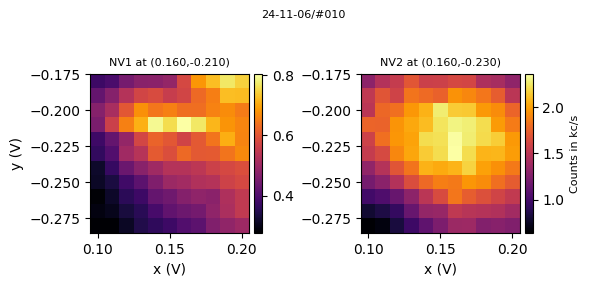

In [13]:
sig=sigs; ref=refs; sig2=sigs2; ref2=refs2
fig,axs = plt.subplots(1,2,figsize=(6,3))
fontsize=8
plot0 = axs[0].pcolormesh(x,y,sig, cmap='inferno')
axs[0].set_xlabel('x (V)')
axs[0].set_ylabel('y (V)')
axs[0].set_aspect('equal')
# axs[0].set_xlim((0.1,0.4))

divider = make_axes_locatable(axs[0])
cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
cb0 = fig.colorbar(plot0, orientation='vertical', ax=axs[0],cax=cbar_ax)

idx = np.unravel_index(np.argmax(sig), sig.shape)
axs[0].set_title('NV1 at (%.3f,%.3f)' % (x[idx], y[idx]),fontsize=fontsize)
# plot0.set_clim((4,20))

########################################################
plot1 = axs[1].pcolormesh(x,y,sig2, cmap='inferno')
axs[1].set_xlabel('x (V)')
axs[1].set_aspect('equal')

divider = make_axes_locatable(axs[1])
cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1],cax=cbar_ax)
cb1.set_label("Counts in kc/s",fontsize=fontsize)

idx = np.unravel_index(np.argmax(sig2), sig2.shape)
axs[1].set_title('NV2 at (%.3f,%.3f)' % (x[idx], y[idx]),fontsize=fontsize)
# plot1.set_clim((4,10))

s = firstdatafile[33:46]
fig.suptitle(s,fontsize=fontsize)

plt.tight_layout()

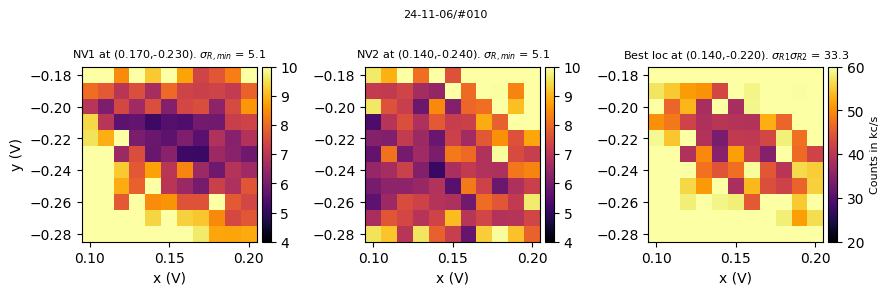

In [14]:
sig = sigmaR; sig2=sigmaR2
fig,axs = plt.subplots(1,3,figsize=(9,3))
fontsize=8
plot0 = axs[0].pcolormesh(x,y,sig, cmap='inferno')
axs[0].set_xlabel('x (V)')
axs[0].set_ylabel('y (V)')
axs[0].set_aspect('equal')
# axs[0].set_xlim((0.1,0.4))

divider = make_axes_locatable(axs[0])
cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
cb0 = fig.colorbar(plot0, orientation='vertical', ax=axs[0],cax=cbar_ax)

idx = np.unravel_index(np.argmin(sig), sig.shape)
axs[0].set_title('NV1 at (%.3f,%.3f). $\sigma_{R,min}$ = %.1f' % (x[idx], y[idx], sig[idx]),fontsize=fontsize)
plot0.set_clim((4,10))

########################################################
ifAddSig = 0
plot1 = axs[1].pcolormesh(x,y,sig2+ifAddSig*sig, cmap='inferno')
axs[1].set_xlabel('x (V)')
axs[1].set_aspect('equal')

divider = make_axes_locatable(axs[1])
cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1],cax=cbar_ax)
# cb1.set_label("Counts in kc/s",fontsize=fontsize)

idx = np.unravel_index(np.argmin(sig2+ifAddSig*sig), sig2.shape)
axs[1].set_title('NV2 at (%.3f,%.3f). $\sigma_{R,min}$ = %.1f' % (x[idx], y[idx], sig2[idx]),fontsize=fontsize)
plot1.set_clim((4,10))

########################################################
prod = sig*sig2
plot2 = axs[2].pcolormesh(x,y,prod, cmap='inferno')
axs[2].set_xlabel('x (V)')
axs[2].set_aspect('equal')

divider = make_axes_locatable(axs[2])
cbar_ax = divider.append_axes("right", size="5%", pad=0.05)
cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[2],cax=cbar_ax)
cb2.set_label("Counts in kc/s",fontsize=fontsize)

idx = np.unravel_index(np.argmin(prod), sig2.shape)
axs[2].set_title('Best loc at (%.3f,%.3f). $\sigma_{R1}\sigma_{R2}$ = %.1f' % (x[idx], y[idx],prod[idx]),fontsize=fontsize)
plot2.set_clim((20,60))

s = firstdatafile[33:46]
fig.suptitle(s,fontsize=fontsize)

plt.tight_layout()

# T1 RR Dual NV

In [4057]:
# T1 RR
days = np.linspace(1,30,30); mos = np.linspace(9,10,2); count=0
dataArr = []; sigArr = []; refArr = []; idxs = []; data2Arr=[]; sig2Arr=[]; ref2Arr=[]
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-09-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'T1RRDualNV' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if (day == 24 and idx == 146):
                datafile = mainFolder + dataFolder +'/T1RRDualNVObject_sig_set.dat'
                x_s, sig, ref, sig2, ref2 = dr.readDataNoPlotDual(datafile)
                xPlot = np.array(x_s); sig = np.array(sig); ref = np.array(ref); sig2 = np.array(sig2); ref2 = np.array(ref2)
                
                # Sort data taken in random order
                sorted_indices = np.argsort(xPlot)
                xPlot = xPlot[sorted_indices]
                sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]
                
                contrast = (sig-ref)/(sig+ref); contrast2 = (sig2-ref2)/(sig2+ref2)
                dataArr.append(contrast); sigArr.append(sig); refArr.append(ref); idxs.append(idx)
                data2Arr.append(contrast2); sig2Arr.append(sig2); ref2Arr.append(ref2)

                if count==0: firstdatafile = datafile
                count+=1

In [4058]:
print(np.shape(dataArr))
dataArr = np.array(dataArr); sigArr = np.array(sigArr); refArr = np.array(refArr); idxs = np.array(idxs)
data2Arr = np.array(data2Arr); sig2Arr = np.array(sig2Arr); ref2Arr = np.array(ref2Arr)

if False:
    # Replace 'nan' values with the value of the item preceding it
    nan_indices = np.isnan(dataArr)
    dataArr[nan_indices] = np.roll(dataArr, 1, axis=1)[nan_indices]
    nan_indices = np.isnan(data2Arr)
    data2Arr[nan_indices] = np.roll(data2Arr, 1, axis=1)[nan_indices]

    fig, axs = plt.subplots(2,3,figsize=(8,8))
    N_datasets = np.size(dataArr,0)
    y = np.linspace(1,N_datasets, N_datasets)
    X, Y = np.meshgrid(xPlot/1e3, y)

    plot = axs[0,0].pcolormesh(X,Y, dataArr, cmap='inferno')
    fig.colorbar(plot, orientation='vertical', ax=axs[0,0])
    axs[0,0].set_ylabel('Iteration')
    axs[0,0].set_title('Contrast',fontsize=10)
    # plot.set_clim(0.1,1.2)

    plot1 = axs[0,1].pcolormesh(X,Y, sigArr, cmap='inferno')
    axs[0,1].set_title('sig',fontsize=10)
    cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[0,1])
    # plot1.set_clim(0,4)

    plot2 = axs[0,2].pcolormesh(X,Y, refArr, cmap='inferno')
    axs[0,2].set_title('ref',fontsize=10)
    cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[0,2])
    cb2.set_label("Counts in kc/s",fontsize=10)
    # plot2.set_clim(0,4)

    plot = axs[1,0].pcolormesh(X,Y, data2Arr, cmap='inferno')
    fig.colorbar(plot, orientation='vertical', ax=axs[1,0])
    axs[1,0].set_xlabel('$\\tau$ ($\mu$s)')
    axs[1,0].set_ylabel('Iteration')
    axs[1,0].set_title('Contrast 2',fontsize=10)
    # plot.set_clim(0.1,1.2)

    plot1 = axs[1,1].pcolormesh(X,Y, sig2Arr, cmap='inferno')
    axs[1,1].set_xlabel('$\\tau$ ($\mu$s)')
    axs[1,1].set_title('sig2',fontsize=10)
    cb1 = fig.colorbar(plot1, orientation='vertical', ax=axs[1,1])
    # plot1.set_clim(0,4)

    plot2 = axs[1,2].pcolormesh(X,Y, ref2Arr, cmap='inferno')
    axs[1,2].set_xlabel('$\\tau$ ($\mu$s)')
    axs[1,2].set_title('ref2',fontsize=10)
    cb2 = fig.colorbar(plot2, orientation='vertical', ax=axs[1,2])
    cb2.set_label("Counts in kc/s",fontsize=10)
    # plot2.set_clim(0,4)

    for i in ((0,1)):
        for j in ((0,1,2)):
            axs[i,j].set_xscale('log')

    plt.tight_layout()


(1, 19)


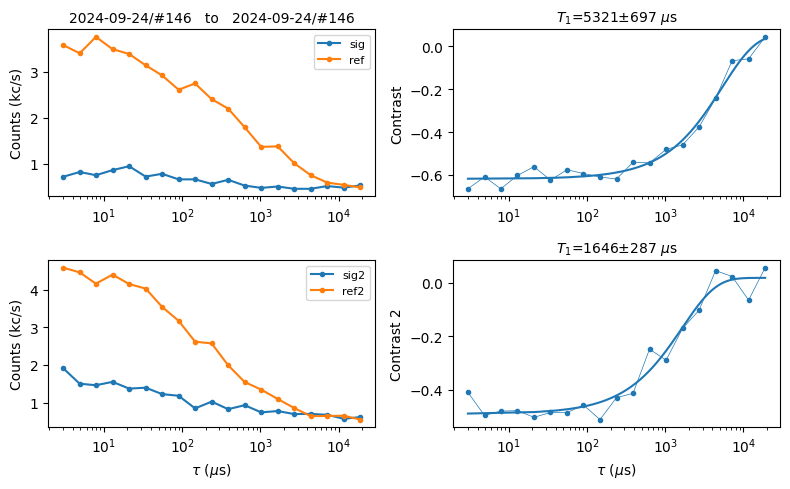

In [4059]:
ifXAxisFreq = 0; correctionToTau = 0; markerAt = 3

x = (xPlot+correctionToTau)/1e3
if ifXAxisFreq: x = 1/(2*(xPlot+correctionToTau)*1e-3)

y = np.average(dataArr, axis=0); ys = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
y2 = np.average(data2Arr, axis=0); ys2 = np.average(sig2Arr, axis=0); yr2 = np.average(ref2Arr, axis=0)

if True:
    fig, axs = plt.subplots(2,2,figsize=(8,5))
    axs[0,1].plot(x,y, 'o-', markersize=3, linewidth=0.5,label="contrast")
    axs[0,1].set_ylabel('Contrast')
    # axs[0,1].vlines(x=markerAt,ymin=min(y),ymax=max(y), linestyle='--',linewidth=1)

    a = np.max(y)
    guess = (a,0,1e6)
    xfit, yfit, popt, perr = dr.fitDecay(x,y,guess=guess)
    s = "$T_{1}$=%.0f$\pm$%.0f $\mu$s" % (popt[2], perr[2])
    axs[0,1].plot(xfit, yfit, label=s, color='C0')
    axs[0,1].set_title(s,fontsize=10)

    axs[0,0].plot(x, ys, 'o-', markersize=3, label="sig")
    axs[0,0].plot(x, yr, 'o-', markersize=3, label="ref")
    axs[0,0].set_ylabel('Counts (kc/s)')
    s = firstdatafile[31:46] + '   to   ' + datafile[31:46]
    axs[0,0].set_title(s,fontsize=10)

    ################################################################################
    axs[1,1].plot(x,y2, 'o-', markersize=3, linewidth=0.5,label="contrast 2")
    axs[1,1].set_ylabel('Contrast 2')
    axs[1,1].set_xlabel(r"$\tau$ ($\mu$s)")
    # axs[1,1].vlines(x=markerAt,ymin=min(y2),ymax=max(y2), linestyle='--',linewidth=1)
    if ifXAxisFreq: axs[1,1].set_xlabel("f (MHz)")

    a2 = np.max(y2)
    guess = (a2,0,1e6)
    xfit, yfit, popt, perr = dr.fitDecay(x,y2,guess=guess)
    s = "$T_{1}$=%.0f$\pm$%.0f $\mu$s" % (popt[2], perr[2])
    axs[1,1].plot(xfit, yfit, label=s, color='C0')
    axs[1,1].set_title(s,fontsize=10)

    axs[1,0].plot(x, ys2, 'o-', markersize=3, label="sig2")
    axs[1,0].plot(x, yr2, 'o-', markersize=3, label="ref2")
    axs[1,0].set_xlabel(r"$\tau$ ($\mu$s)")
    if ifXAxisFreq: axs[1,0].set_xlabel("f (MHz)")
    axs[1,0].set_ylabel('Counts (kc/s)')

    for i in ((0,1)):
        for j in ((0,1)):
            axs[i,j].set_xscale('log')
        axs[i,0].legend(fontsize=8)

    plt.tight_layout()
    plt.show()

# Calib izn rate

### No izn pulse

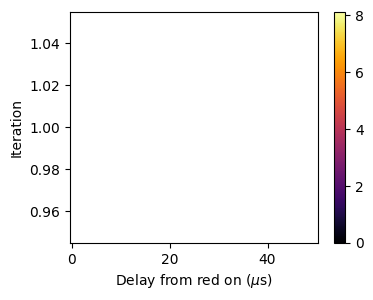

In [1560]:
days = np.linspace(1,30,30); mos = np.linspace(9,10,2); count=0
dataArr = []; gArr = []; err_gArr = []; cArr = []; err_cArr = []; r0Arr = []; err_r0Arr = []
# fig2, ax2 = plt.subplots()
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-09-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'CalibRedRRIonizeRate' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if (day==16 and idx == 116):
                read_duration = 400
                datafile = mainFolder + dataFolder +'/CalibRedRRIonizeRateObject_sig_set.dat'

                x, sig = dr.readDataNoRef(datafile)
                x = np.array(x)/1e3; sig = np.array(sig)
                n = 1
                if len(sig) < n: 
                        print("Bad data: " + datafile)
                else:
                    if math.isnan(sig[-1]): 
                        x = x[0:-1]; sig = sig[0:-1]
                    x = np.linspace(0, x[-1], len(x))
                    xPlot = x
                    y = sig
                    y = y/(read_duration/1e6)
                    y_avg = running_average(y)
                    dataArr.append(y)

                    xfit, yfit, popt, perr = dr.fitDecay(x, y, guess=(0.3,0.03,100))
                    g = 1e3/popt[2]; err_g = 1e3*(perr[2]/popt[2]**2)
                    gArr.append(g); err_gArr.append(err_g)
                    cArr.append(1e3*popt[1]); err_cArr.append(1e3*perr[1])
                    r0Arr.append(yfit[0]*1e3); err_r0Arr.append(1e3*(perr[1]+perr[0]))
                    
                if count==0: firstdatafile = datafile
                count+=1
                        
dataArr = np.array(dataArr); gArr = np.array(gArr); err_gArr = np.array(err_gArr); 
cArr = np.array(cArr); err_cArr = np.array(err_cArr); r0Arr = np.array(r0Arr); err_r0Arr = np.array(err_r0Arr)

fig, ax = plt.subplots(figsize=(4,3))
N_datasets = np.size(dataArr,0)
y = np.linspace(1,N_datasets, N_datasets)
X, Y = np.meshgrid(xPlot, y)
plot = ax.pcolormesh(X,Y, dataArr, cmap='inferno')
fig.colorbar(plot, orientation='vertical')
ax.set_xlabel("Delay from red on ($\mu$s)")
ax.set_ylabel(r"Iteration");

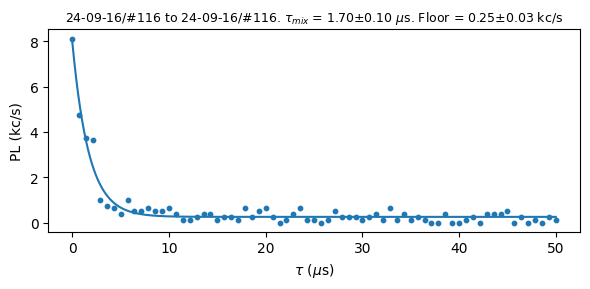

In [1561]:
for idx in np.linspace(0,5,1):
    y = np.average(dataArr, axis=0)
    x = xPlot
    # x = x[1:]
    # y = y[1:]

    fig, ax = plt.subplots(1,1,figsize=(6,3))
    ax.scatter(x,y,s=10 ,label='(sig-ref)/(sig+ref)')
    ax.set_ylabel('PL (kc/s)')
    ax.set_xlabel('$\\tau$ ($\mu$s)')

    guess = (8,0,4)
    xfit, yfit, popt, perr = dr.fitDecay(x,y, guess=guess)
    # ax.set_title('$\\tau$ = %.2f$\pm$%.2f $\mu$s. $C_{final}$ = %.2f$\pm$%.2f' % (popt[2],perr[2],popt[1],perr[1]))
    s = firstdatafile[33:46] + ' to ' + datafile[33:46]
    s1 = '. $\\tau_{mix}$ = %.2f$\pm$%.2f $\mu$s' % (popt[2],perr[2])
    s2 = '. Floor = %.2f$\pm$%.2f kc/s' % (popt[1],perr[1])
    ax.set_title(s+s1+s2, fontsize=9)
    
    ax.plot(xfit,yfit)
    # ax.set_yscale('log')
    

    plt.tight_layout()

### With izn pulse

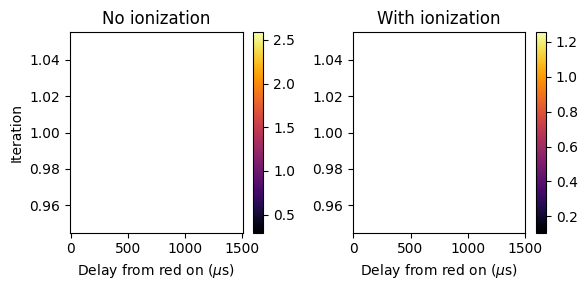

In [218]:
days = np.linspace(1,30,30); mos = np.linspace(9,10,2); count=0
sigArr = []; refArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-09-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if 'CalibRedRRIznRateWithIznPulse' in dataFolder:
            if dataFolder[4] == '_': idx = int(dataFolder[1:4])
            else: idx = int(dataFolder[1:5])
            if (day==26 and idx == 61):
                read_duration = 7500
                datafile = mainFolder + dataFolder +'/CalibRedRRIznRateWithIznPulseObject_sig_set.dat'
                x, sig, ref = dr.readDataNoPlot(datafile)
                x = np.array(x)/1e3; sig = np.array(sig); ref = np.array(ref)
               
                if math.isnan(sig[-1]): 
                    x = x[0:-1]; sig = sig[0:-1]
                x = np.linspace(0, x[-1], len(x))
                xPlot = x
                sig = sig/(read_duration/1e6); ref = ref/(read_duration/1e6)
                sigArr.append(sig); refArr.append(ref)

                if count==0: firstdatafile = datafile
                count+=1
        
sigArr = np.array(sigArr); refArr = np.array(refArr)
if True:
    fig, axs = plt.subplots(1,2,figsize=(6,3))
    N_datasets = np.size(sigArr,0)
    y = np.linspace(1,N_datasets, N_datasets)
    X, Y = np.meshgrid(xPlot, y)

    plot = axs[0].pcolormesh(X,Y, sigArr, cmap='inferno')
    fig.colorbar(plot, orientation='vertical', ax = axs[0]);
    axs[0].set_xlabel("Delay from red on ($\mu$s)")
    axs[0].set_ylabel(r"Iteration");
    axs[0].set_title('No ionization');

    plot = axs[1].pcolormesh(X,Y, refArr, cmap='inferno')
    fig.colorbar(plot, orientation='vertical', ax = axs[1]);
    axs[1].set_xlabel("Delay from red on ($\mu$s)")
    axs[1].set_title('With ionization');

    plt.tight_layout()

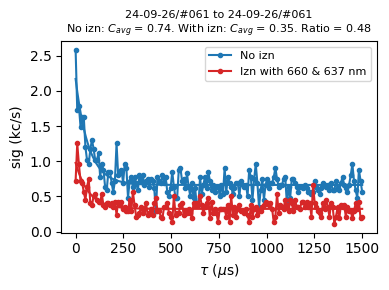

In [219]:
ifPlotTogether = 1
for idx in np.linspace(0,5,1):
    y = np.average(sigArr, axis=0); yr = np.average(refArr, axis=0)
    x = xPlot
    if ifPlotTogether:
        fig, ax = plt.subplots(figsize=(4,3))
        ax.plot(x,y, 'o-', color='C0', markersize=3, label='No izn')
        ax.set_ylabel('sig (kc/s)')
        ax.set_xlabel('$\\tau$ ($\mu$s)')

        guess = (6,6,150)
        xfit, yfit, popt, perr = dr.fitDecay(x,y, guess=guess)
        # s1 = 'No izn: $\\tau$ = %.2f$\pm$%.2f $\mu$s. $C_{final}$ = %.2f$\pm$%.2f' % (popt[2],perr[2],popt[1],perr[1])
        s = firstdatafile[33:46] + ' to ' + datafile[33:46]
        # s1 = 'No izn: $C_{final}$ = %.2f$\pm$%.2f' % (popt[1],perr[1])
        s1 = 'No izn: $C_{avg}$ = %.2f' % np.average(y)
        ax.plot(xfit,yfit,color='C0')
        # ax.set_yscale('log')

        # ax.plot(x,yold, 'o-', color='C1',markersize=3, label='Izn with just 660 nm')
        # ax.set_xlabel('$\\tau$ ($\mu$s)')
        # ax.legend()

        ax.plot(x,yr, 'o-', color='C3',markersize=3, label='Izn with 660 & 637 nm')
        ax.set_xlabel('$\\tau$ ($\mu$s)')
        ax.legend(fontsize=8)

        guess = (1,1,150)
        xfit, yfit, popt, perr = dr.fitDecay(x,yr, guess=guess)
        # s2 = 'No izn: $\\tau$ = %.2f$\pm$%.2f $\mu$s. $C_{final}$ = %.2f$\pm$%.2f' % (popt[2],perr[2],popt[1],perr[1])
        s2 = '. With izn: $C_{avg}$ = %.2f' % np.average(yr)
        s3 = '. Ratio = %.2f' % (np.average(yr)/np.average(y))
        ax.set_title(s + "\n" + s1 + s2 + s3,fontsize=8)
        # ax.set_title('With low power MW during readout.',fontsize=10)
        ax.plot(xfit,yfit,color='C3')
    else:
        fig, axs = plt.subplots(1,2,figsize=(7,3))
        axs[0].plot(x,y, 'o-', markersize=3, label='No izn')
        axs[0].set_ylabel('sig (kc/s)')
        axs[0].set_xlabel('$\\tau$ ($\mu$s)')
        axs[0].legend()

        guess = (8,0,4)
        xfit, yfit, popt, perr = dr.fitDecay(x,y, guess=guess)
        axs[0].set_title('$\\tau$ = %.2f$\pm$%.2f $\mu$s. $C_{final}$ = %.2f$\pm$%.2f' % 
                         (popt[2],perr[2],popt[1],perr[1]),fontsize=6)
        # axs[0].plot(xfit,yfit)
        # axs[0].set_yscale('log')

        axs[1].plot(x,yr, 'o-', markersize=3, label='With izn')
        axs[1].set_xlabel('$\\tau$ ($\mu$s)')
        axs[1].legend()

        guess = (8,0,4)
        xfit, yfit, popt, perr = dr.fitDecay(x,yr, guess=guess)
        axs[1].set_title('$\\tau$ = %.2f$\pm$%.2f $\mu$s. $C_{final}$ = %.2f$\pm$%.2f' % 
                         (popt[2],perr[2],popt[1],perr[1]),fontsize=10)
        # axs[1].plot(xfit,yfit)
        # axs[0].set_yscale('log')

        s = firstdatafile[33:46] + ' to ' + datafile[33:46]
        fig.suptitle(s, fontsize=8)
        

    plt.tight_layout()

# SCC + RR photon stat. Calib tgreen, ti, i2read,read

In [ ]:
# Repeat measuring SCC photon stats
days = np.linspace(1,31,31); mos = np.linspace(9,10,2); count=0
dataArr = []; gArr = []; err_gArr = []; sigs = None; refs = None
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-11-' + str(int(day)).zfill(2) + '/'
    try:
        for dataFolder in os.listdir(mainFolder):
            # print(dataFolder)
            if 'SCCRRPhotonStatIrber' in dataFolder:
                idx = int(dataFolder[1:4])
                fixed_param_ns = 3e6 # if not sweeping tR, this should always be tR
                if (day==7) and (idx == 49):
                    finalDataFolder = mainFolder + dataFolder
                    datafile = finalDataFolder +'/SCCRRPhotonStatIrberObject_sig_set.dat'
                    
                    sig, ref, hist2DArray_sig, hist2DArray_ref, xplot, yplot, bins1DArray = dr.readDataFullData(
                                        datafile, num_of_bins=50, binwidth=1, plot_hist_every=100, ifPlot=False,
                                        ifDataSavedAsCountRate=False, ifLogColor=True, ifSubtractRef=False, ifPlotRef=False,)
                    if sigs is None: sigs = sig
                    else: sigs = np.concatenate((sigs, sig),axis=1)
                    if refs is None: refs = ref
                    else: refs = np.concatenate((refs, ref),axis=1)

                    if count==0: firstdatafile = datafile
                    count+=1
    except:pass
print(np.shape(sigs))
sweepWhat = '$t_{\pi}$'; fixed_param = '$t_{R}$'

(4, 1500)


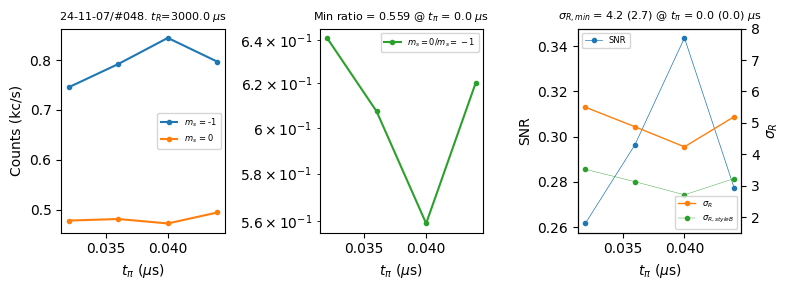

In [406]:
sigs_avg_count = np.average(sigs,axis=1); refs_avg_count = np.average(refs,axis=1)
x = yplot/1e3; fontsize=6
if sweepWhat == '$t_{R}$': tr_ns = yplot
else: tr_ns = fixed_param_ns
sigs_avg = sigs_avg_count/(tr_ns/1e6); refs_avg = refs_avg_count/(tr_ns/1e6) 

fig, axs = plt.subplots(1,3,figsize=(8,3))
axs[0].plot(x,sigs_avg,'o-', label="$m_s$ = -1",markersize=3)
axs[0].plot(x,refs_avg,'o-', label="$m_s$ = 0",markersize=3)
axs[0].legend(fontsize=fontsize)
axs[0].set_xlabel(sweepWhat + ' ($\mu$s)')
axs[0].set_ylabel('Counts (kc/s)')
s = firstdatafile[33:46]
s1 = '. %s=%.1f $\mu$s' % (fixed_param, fixed_param_ns/1e3)
axs[0].set_title(s+s1, fontsize=fontsize+2)


y = refs_avg/sigs_avg
axs[1].plot(x,y,'o-', label="$m_s=0/m_s=-1$",markersize=3,color='C2')
axs[1].legend(fontsize=fontsize)
axs[1].set_xlabel(sweepWhat + ' ($\mu$s)')
axs[1].set_title('Min ratio = %.3f @ %s = %.1f $\mu$s' % (np.min(y), sweepWhat, x[np.argmin(y)]),
                  fontsize=fontsize+2)

###########################################
sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)
snr =        (sigs_avg_count-refs_avg_count)/np.sqrt(sigma_sig**2 + sigma_ref**2)
snr_styleB = (sigs_avg_count-refs_avg_count)/np.sqrt(sigs_avg_count + refs_avg_count) # assuming sigma = mean
sigmaR = np.sqrt(1+2/snr**2); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

axs[2].plot(x, snr, 'o-', linewidth=0.5, markersize=3, label="SNR")
axs[2].legend(loc='upper left',fontsize=fontsize)
axs[2].set_xlabel(sweepWhat + ' ($\mu$s)')
axs[2].set_ylabel('SNR')
axs[2].set_title('$\sigma_{R,min}$ = %.1f (%.1f) @ %s = %.1f (%.1f) $\mu$s' 
                 % (np.min(sigmaR), np.min(sigmaR_styleB), sweepWhat,
                    x[np.argmin(sigmaR)],x[np.argmin(sigmaR_styleB)]), fontsize=fontsize+2)

ax=axs[2].twinx()
ax.plot(x, sigmaR,  'o-', color='C1',linewidth=1, markersize=3, label='$\sigma_R$')
ax.plot(x, sigmaR_styleB,  'o-', color='C2',linewidth=0.3, markersize=3, label='$\sigma_{R, styleB}$')
axs[1].set_yscale('log')
ax.set_ylim((1.5,8))
ax.legend(loc='lower right',fontsize=fontsize)
ax.set_xlabel('$t_i$ ($\mu$s)')
ax.set_ylabel('$\sigma_R$')

# for i in range(2):
#    axs[i].set_xscale('log')
# ax.set_xscale('log')

plt.tight_layout()
plt.show()

In [2581]:
# contrast = (sigs_avg_count - refs_avg_count)/(sigs_avg_count + refs_avg_count)
# fig,ax = plt.subplots(figsize=(3.5,2.5))
# xplot = x*1e3
# ax.plot(xplot, contrast,'o-',markersize=4,linewidth=0.3)
# ax.set_xlabel(sweepWhat + ' (ns)')
# ax.set_ylabel("Contrast")

# guess = (0.3, 37, 1, 0.1)
# xfit, yfit, popt, perr = dr.fitSinusoid(xplot, contrast,guess=guess)
# ax.plot(xfit, yfit, linewidth=2, color='C0')
# s1 = '$T_{\pi}$ = %.2f $\pm$ %.2f ns' % (popt[1], perr[1])
# ax.set_title(s + ". " + s1, fontsize=9);
# print(np.max(sigs_avg[0:]))
# print(np.average(refs_avg[0:]))


# Rabi SCC RR Dual NV

In [738]:
# Repeat measuring Rabi SCC RR
days = np.linspace(1,2,2); mos = np.linspace(9,10,2); a = 'RabiSCCRRIrberDualNV'; b = 'T1RRDualNV'; count=0
sigs = None; refs = None; sigs2 = None; refs2 = None; type = a
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-11-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if type in dataFolder:
            idx = int(dataFolder[1:4])
            # if (day==31 and idx>=1 and idx <= 21): # batch 1
            # if (day==31 and idx>=23 and idx<=24): # batch 2
            if (day==2 and idx==95): # batch 2
                finalDataFolder = mainFolder + dataFolder
                datafile = finalDataFolder +'/' + type + 'Object_sig_set.dat'
                ti1 = 10e3; ti2=10e3; fixed_param_ns = 2.5e6
                if True:

                    taus, sig, sig2, ref, ref2 = dr.readDataFullDataDualNV(datafile)
                
                    # Sort data taken in random order
                    taus = np.average(taus,axis=1)
                    sorted_indices = np.argsort(taus)
                    taus = taus[sorted_indices]
                    sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                    ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]

                    if sigs is None: sigs = sig
                    else: sigs = np.concatenate((sigs, sig),axis=1)
                    if refs is None: refs = ref
                    else: refs = np.concatenate((refs, ref),axis=1)
                    if sigs2 is None: sigs2 = sig2
                    else: sigs2 = np.concatenate((sigs2, sig2),axis=1)
                    if refs2 is None: refs2 = ref2
                    else: refs2 = np.concatenate((refs2, ref2),axis=1)

                    if count==0: firstdatafile = datafile
                    count+=1
print(np.shape(sigs))
sweepWhat = '$t_{\pi}$'; fixed_param = '$t_{R}$'
if True:
    thres = 12

    sigavg = np.average(sigs,axis=1); refavg = np.average(refs,axis=1)
    sigavg2 = np.average(sigs2,axis=1); refavg2 = np.average(refs2,axis=1)

    max_count = 1.327; min_count = 0.637
    max_contrast = (max_count - min_count)/(max_count + min_count)

    max_count2 = 3.82; min_count2 = 2.667
    max_contrast2 = (max_count2 - min_count2)/(max_count2 + min_count2)

    sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)
    sigma_sig2 = np.std(sigs2, axis=1); sigma_ref2 = np.std(refs2, axis=1)

    snr_styleA = (sigavg-refavg)/np.sqrt(sigma_sig**2 + sigma_ref**2); sigmaR_styleA = np.sqrt(1+2/snr_styleA**2)
    snr_styleB = (sigavg-refavg)/np.sqrt(sigavg+refavg); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

    snr_styleA2 = (sigavg2-refavg2)/np.sqrt(sigma_sig2**2 + sigma_ref2**2); sigmaR_styleA2 = np.sqrt(1+2/snr_styleA2**2)
    snr_styleB2 = (sigavg2-refavg2)/np.sqrt(sigavg2+refavg2); sigmaR_styleB2 = np.sqrt(1+2/snr_styleB2**2)

    # contrast = (sigs-refs)/(sigs+refs); contrast = np.nan_to_num(contrast, nan=0)#/2+0.5
    # contrast2 = (sigs2-refs2)/(sigs2+refs2); contrast2 = np.nan_to_num(contrast2, nan=0)#/2+0.5

    contrast =  contrast_new(sigs, refs, sigavg, refavg, ifNorm=2,max_contrast=max_contrast)
    contrast2 = contrast_new(sigs2,refs2,sigavg2,refavg2,ifNorm=2,max_contrast=max_contrast2)
    # contrast_avg = np.average(contrast, axis=1); contrast_avg2 = np.average(contrast2, axis=1)

    covSig, sigma_covSig,_,_ = cov(sigs,sigs2); covRef, sigma_covRef,_,_ = cov(refs, refs2)
    covContrast,_,_,_ = cov(contrast, contrast2)  

    # r = (covSig - covRef)
    r = covContrast; r2 = (covSig + covRef)/2
                

(31, 1500)


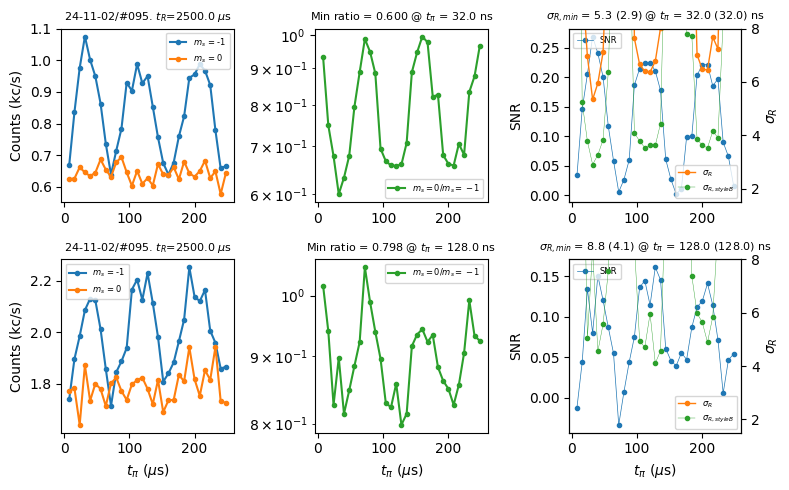

In [739]:
sigs_avg_count = np.average(sigs,axis=1); refs_avg_count = np.average(refs,axis=1)
sigs_avg_count2 = np.average(sigs2,axis=1); refs_avg_count2 = np.average(refs2,axis=1)
x = taus; fontsize=6
if sweepWhat == '$t_{R}$': tr_ns = yplot
else: tr_ns = fixed_param_ns
sigs_avg = sigs_avg_count/(tr_ns/1e6); refs_avg = refs_avg_count/(tr_ns/1e6) 
sigs_avg2 = sigs_avg_count2/(tr_ns/1e6); refs_avg2 = refs_avg_count2/(tr_ns/1e6) 

if True:
    fig, axs = plt.subplots(2,3,figsize=(8,5))
    #######################################################################################################
    axs[0,0].plot(x,sigs_avg,'o-', label="$m_s$ = -1",markersize=3)
    axs[0,0].plot(x,refs_avg,'o-', label="$m_s$ = 0",markersize=3)
    axs[0,0].legend(fontsize=fontsize)
    axs[0,0].set_ylabel('Counts (kc/s)')
    s = firstdatafile[33:46]
    s1 = '. %s=%.1f $\mu$s' % (fixed_param, fixed_param_ns/1e3)
    axs[0,0].set_title(s+s1, fontsize=fontsize+2)


    y = refs_avg/sigs_avg
    axs[0,1].plot(x,y,'o-', label="$m_s=0/m_s=-1$",markersize=3,color='C2')
    axs[0,1].legend(fontsize=fontsize)
    axs[0,1].set_title('Min ratio = %.3f @ %s = %.1f ns' % (np.min(y), sweepWhat, x[np.argmin(y)]),
                    fontsize=fontsize+2)

    ###########################################
    sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)
    snr =        (sigs_avg_count-refs_avg_count)/np.sqrt(sigma_sig**2 + sigma_ref**2)
    snr_styleB = (sigs_avg_count-refs_avg_count)/np.sqrt(sigs_avg_count + refs_avg_count) # assuming sigma = mean
    sigmaR = np.sqrt(1+2/snr**2); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

    axs[0,2].plot(x, snr, 'o-', linewidth=0.5, markersize=3, label="SNR")
    axs[0,2].legend(loc='upper left',fontsize=fontsize)
    axs[0,2].set_ylabel('SNR')
    axs[0,2].set_title('$\sigma_{R,min}$ = %.1f (%.1f) @ %s = %.1f (%.1f) ns' 
                    % (np.min(sigmaR), np.min(sigmaR_styleB), sweepWhat,
                        x[np.argmin(sigmaR)],x[np.argmin(sigmaR_styleB)]), fontsize=fontsize+2)

    ax=axs[0,2].twinx()
    ax.plot(x, sigmaR,  'o-', color='C1',linewidth=1, markersize=3, label='$\sigma_R$')
    ax.plot(x, sigmaR_styleB,  'o-', color='C2',linewidth=0.3, markersize=3, label='$\sigma_{R, styleB}$')
    axs[0,1].set_yscale('log')
    ax.set_ylim((1.5,8))
    ax.legend(loc='lower right',fontsize=fontsize)
    ax.set_xlabel('$t_i$ ($\mu$s)')
    ax.set_ylabel('$\sigma_R$')

    ########################################################################################################
    axs[1,0].plot(x,sigs_avg2,'o-', label="$m_s$ = -1",markersize=3)
    axs[1,0].plot(x,refs_avg2,'o-', label="$m_s$ = 0",markersize=3)
    axs[1,0].legend(fontsize=fontsize)
    axs[1,0].set_xlabel(sweepWhat + ' ($\mu$s)')
    axs[1,0].set_ylabel('Counts (kc/s)')
    s = firstdatafile[33:46]
    s1 = '. %s=%.1f $\mu$s' % (fixed_param, fixed_param_ns/1e3)
    axs[1,0].set_title(s+s1, fontsize=fontsize+2)


    y2 = refs_avg2/sigs_avg2
    axs[1,1].plot(x,y2,'o-', label="$m_s=0/m_s=-1$",markersize=3,color='C2')
    axs[1,1].legend(fontsize=fontsize)
    axs[1,1].set_xlabel(sweepWhat + ' ($\mu$s)')
    axs[1,1].set_title('Min ratio = %.3f @ %s = %.1f ns' % (np.min(y2), sweepWhat, x[np.argmin(y2)]),
                    fontsize=fontsize+2)

    ###########################################
    sigma_sig2 = np.std(sigs2, axis=1); sigma_ref2 = np.std(refs2, axis=1)
    snr2 =        (sigs_avg_count2-refs_avg_count2)/np.sqrt(sigma_sig2**2 + sigma_ref2**2)
    snr_styleB2 = (sigs_avg_count2-refs_avg_count2)/np.sqrt(sigs_avg_count2 + refs_avg_count2) # assuming sigma = mean
    sigmaR2 = np.sqrt(1+2/snr2**2); sigmaR_styleB2 = np.sqrt(1+2/snr_styleB2**2)

    axs[1,2].plot(x, snr2, 'o-', linewidth=0.5, markersize=3, label="SNR")
    axs[1,2].legend(loc='upper left',fontsize=fontsize)
    axs[1,2].set_xlabel(sweepWhat + ' ($\mu$s)')
    axs[1,2].set_ylabel('SNR')
    axs[1,2].set_title('$\sigma_{R,min}$ = %.1f (%.1f) @ %s = %.1f (%.1f) ns' 
                    % (np.min(sigmaR2), np.min(sigmaR_styleB2), sweepWhat,
                        x[np.argmin(sigmaR2)],x[np.argmin(sigmaR_styleB2)]), fontsize=fontsize+2)

    ax=axs[1,2].twinx()
    ax.plot(x, sigmaR2,  'o-', color='C1',linewidth=1, markersize=3, label='$\sigma_R$')
    ax.plot(x, sigmaR_styleB2,  'o-', color='C2',linewidth=0.3, markersize=3, label='$\sigma_{R, styleB}$')
    axs[1,1].set_yscale('log')
    ax.set_ylim((1.5,8))
    ax.legend(loc='lower right',fontsize=fontsize)
    ax.set_xlabel('$t_i$ ($\mu$s)')
    ax.set_ylabel('$\sigma_R$')

    plt.tight_layout()
    plt.show()

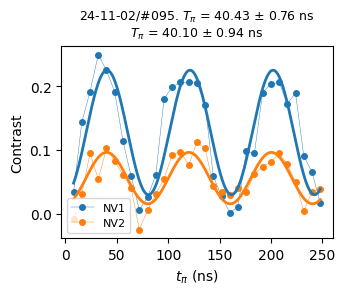

In [740]:
contrast = (sigs_avg_count - refs_avg_count)/(sigs_avg_count + refs_avg_count)
contrast2 = (sigs_avg_count2 - refs_avg_count2)/(sigs_avg_count2 + refs_avg_count2)
fig,ax = plt.subplots(figsize=(3.5,2.5))
xplot = x
ax.plot(xplot, contrast,'o-',markersize=4,linewidth=0.3,label='NV1')
ax.plot(xplot, contrast2,'o-',markersize=4,linewidth=0.3,label='NV2')
ax.set_xlabel(sweepWhat + ' (ns)')
ax.set_ylabel("Contrast")
ax.legend(fontsize=8)

guess = (0.15, 38, 1, 0.1)
xfit, yfit, popt, perr = dr.fitSinusoid(xplot, contrast,guess=guess)
ax.plot(xfit, yfit, linewidth=2, color='C0')
s1 = '$T_{\pi}$ = %.2f $\pm$ %.2f ns' % (popt[1], perr[1])
# ax.set_title(s + ". " + s1, fontsize=9);
# print(np.max(sigs_avg[0:]))
# print(np.average(refs_avg[0:]))

xfit2, yfit2, popt2, perr2 = dr.fitSinusoid(xplot, contrast2,guess=guess)
ax.plot(xfit2, yfit2, linewidth=2, color='C1')
s2 = '$T_{\pi}$ = %.2f $\pm$ %.2f ns' % (popt2[1], perr2[1])
ax.set_title(s + ". " + s1 + "\n" + s2, fontsize=9);
# print(np.max(sigs_avg2[0:]))
# print(np.average(refs_avg2[0:]))


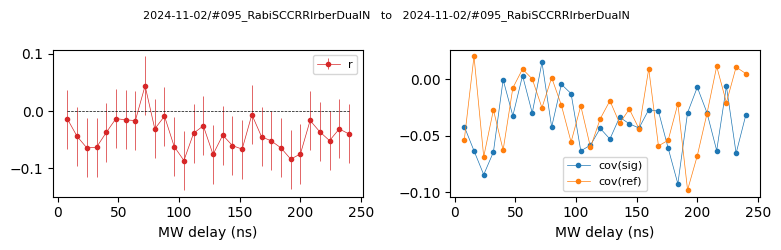

In [736]:
fig, axs = plt.subplots(1,2,figsize=(8,2.5))

axs[0].errorbar(x, r, sigma_covSig+sigma_covRef, marker='o',linewidth=0.5, markersize=3, label="r",color="C3")
axs[0].legend(fontsize=8)
axs[0].hlines(y=0,xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')

axs[1].plot(x, covSig, 'o-', linewidth=0.5, markersize=3, label="cov(sig)")
axs[1].plot(x, covRef, 'o-', linewidth=0.5, markersize=3, label="cov(ref)", color='C1')
axs[1].legend(fontsize=8)
# axs[1].vlines(x=markerAt,ymin=min(covRef),ymax=max(covRef), linestyle='--', linewidth=0.5, color='k')

axs[0].set_xlabel("MW delay (ns)")
axs[1].set_xlabel("MW delay (ns)")
   
s = firstdatafile[31:66] + '   to   ' + datafile[31:66]
fig.suptitle(s, fontsize=8)
plt.tight_layout()
plt.show()

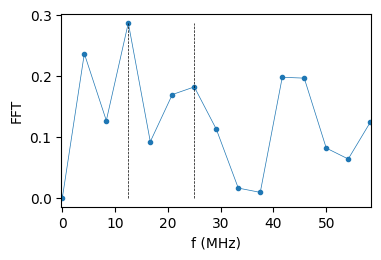

In [737]:
r_zero = np.concatenate((r,np.zeros(len(r)*0))); delta_t=8e-9; markerAt=12.5
f,yfourier = fourier(r_zero,delta_t=delta_t)
fig, ax = plt.subplots(figsize=(4,2.5))
ax.plot(f/1e6,yfourier,'o-', linewidth=0.5, markersize=3, )
ax.vlines(x=markerAt,ymin=min(yfourier),ymax=max(yfourier), linestyle='--', linewidth=0.5, color='k')
ax.vlines(x=2*markerAt,ymin=min(yfourier),ymax=max(yfourier), linestyle='--', linewidth=0.5, color='k')
ax.set_xlim((-0.2,np.max(f/1e6)+0.2))
ax.set_xlabel('f (MHz)')
ax.set_ylabel('FFT');

# Driven corr SCC RR Dual NV

In [158]:
# Repeat measuring Driven Corr SCC RR
days = np.linspace(1,31,31); mos = np.linspace(9,10,2); a = 'DrivenCorrSCCRRIrberDualNV'; b = 'T1RRDualNV'; count=0
sigs = None; refs = None; sigs2 = None; refs2 = None; type = a
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-11-' + str(int(day)).zfill(2) + '/'
    try:
        for dataFolder in os.listdir(mainFolder):
            if type in dataFolder:
                idx = int(dataFolder[1:4])
                # if (day==31 and idx>=27 and idx<=28): # batch 1 corr
                # if (day==31 and idx>=30 and idx<=44): # batch 2 anticorr
                # if (day==3 and idx==31):
                if (day==6 and idx>=43 and np.mod(idx,2)==1):
                    finalDataFolder = mainFolder + dataFolder
                    datafile = finalDataFolder +'/' + type + 'Object_sig_set.dat'
                    ti1=6e3; ti2=6e3; fixed_param_ns=3e6
                    if True:
                        taus, sig, sig2, ref, ref2 = dr.readDataFullDataDualNV(datafile)
                    
                        # Sort data taken in random order
                        taus = np.average(taus,axis=1)
                        sorted_indices = np.argsort(taus)
                        taus = taus[sorted_indices]
                        sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                        ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]

                        if sigs is None: sigs = sig
                        else: sigs = np.concatenate((sigs, sig),axis=1)
                        if refs is None: refs = ref
                        else: refs = np.concatenate((refs, ref),axis=1)
                        if sigs2 is None: sigs2 = sig2
                        else: sigs2 = np.concatenate((sigs2, sig2),axis=1)
                        if refs2 is None: refs2 = ref2
                        else: refs2 = np.concatenate((refs2, ref2),axis=1)

                        if count==0: firstdatafile = datafile
                        count+=1
    except:pass
print(np.shape(sigs))
sweepWhat = '$t_{\pi}$'; fixed_param = '$t_{R}$'
if True:
    thres = 12

    sigavg = np.average(sigs,axis=1); refavg = np.average(refs,axis=1)
    sigavg2 = np.average(sigs2,axis=1); refavg2 = np.average(refs2,axis=1)

    max_count = 1.327; min_count = 0.637
    max_contrast = (max_count - min_count)/(max_count + min_count)

    max_count2 = 3.82; min_count2 = 2.667
    max_contrast2 = (max_count2 - min_count2)/(max_count2 + min_count2)

    sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)
    sigma_sig2 = np.std(sigs2, axis=1); sigma_ref2 = np.std(refs2, axis=1)

    snr_styleA = (sigavg-refavg)/np.sqrt(sigma_sig**2 + sigma_ref**2); sigmaR_styleA = np.sqrt(1+2/snr_styleA**2)
    snr_styleB = (sigavg-refavg)/np.sqrt(sigavg+refavg); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

    snr_styleA2 = (sigavg2-refavg2)/np.sqrt(sigma_sig2**2 + sigma_ref2**2); sigmaR_styleA2 = np.sqrt(1+2/snr_styleA2**2)
    snr_styleB2 = (sigavg2-refavg2)/np.sqrt(sigavg2+refavg2); sigmaR_styleB2 = np.sqrt(1+2/snr_styleB2**2)

    # contrast =  contrast_new(sigs, refs, sigavg, refavg, ifNorm=2,max_contrast=max_contrast)
    # contrast2 = contrast_new(sigs2,refs2,sigavg2,refavg2,ifNorm=2,max_contrast=max_contrast2)

    covSig, sigma_covSig,_,_ = cov(sigs,sigs2); covRef, sigma_covRef,_,_ = cov(refs, refs2)
    # covContrast,_,_,_ = cov(contrast, contrast2)  

    combined_sigs = np.concatenate((sigs,refs),axis=1); combined_sigs2 = np.concatenate((sigs2,refs2),axis=1)
    r, sigma_r, aavg,sigma_a = cov(combined_sigs,combined_sigs2)
    print(np.shape(combined_sigs))
                

(10, 20000)
(10, 40000)


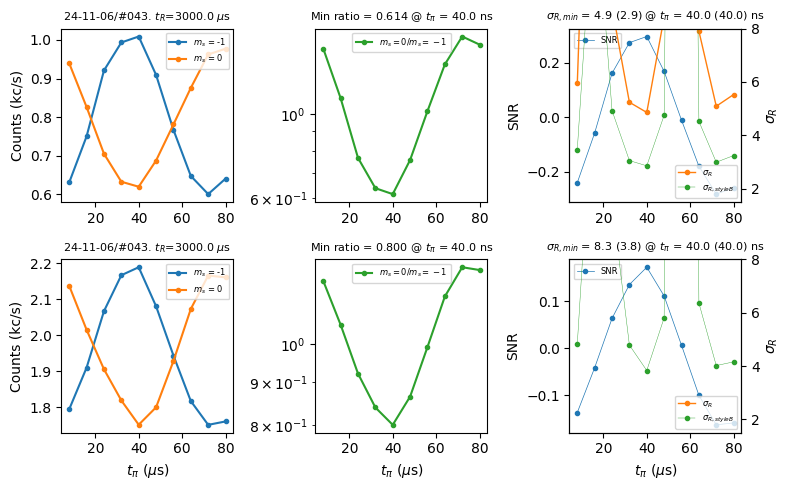

In [159]:
sigs_avg_count = np.average(sigs,axis=1); refs_avg_count = np.average(refs,axis=1)
sigs_avg_count2 = np.average(sigs2,axis=1); refs_avg_count2 = np.average(refs2,axis=1)
x = taus; fontsize=6
if sweepWhat == '$t_{R}$': tr_ns = yplot
else: tr_ns = fixed_param_ns
sigs_avg = sigs_avg_count/(tr_ns/1e6); refs_avg = refs_avg_count/(tr_ns/1e6) 
sigs_avg2 = sigs_avg_count2/(tr_ns/1e6); refs_avg2 = refs_avg_count2/(tr_ns/1e6) 

if True:
    fig, axs = plt.subplots(2,3,figsize=(8,5))
    #######################################################################################################
    axs[0,0].plot(x,sigs_avg,'o-', label="$m_s$ = -1",markersize=3)
    axs[0,0].plot(x,refs_avg,'o-', label="$m_s$ = 0",markersize=3)
    axs[0,0].legend(fontsize=fontsize)
    axs[0,0].set_ylabel('Counts (kc/s)')
    s = firstdatafile[33:46]
    s1 = '. %s=%.1f $\mu$s' % (fixed_param, fixed_param_ns/1e3)
    axs[0,0].set_title(s+s1, fontsize=fontsize+2)


    y = refs_avg/sigs_avg
    axs[0,1].plot(x,y,'o-', label="$m_s=0/m_s=-1$",markersize=3,color='C2')
    axs[0,1].legend(fontsize=fontsize)
    axs[0,1].set_title('Min ratio = %.3f @ %s = %.1f ns' % (np.min(y), sweepWhat, x[np.argmin(y)]),
                    fontsize=fontsize+2)

    ###########################################
    sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)
    snr =        (sigs_avg_count-refs_avg_count)/np.sqrt(sigma_sig**2 + sigma_ref**2)
    snr_styleB = (sigs_avg_count-refs_avg_count)/np.sqrt(sigs_avg_count + refs_avg_count) # assuming sigma = mean
    sigmaR = np.sqrt(1+2/snr**2); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

    axs[0,2].plot(x, snr, 'o-', linewidth=0.5, markersize=3, label="SNR")
    axs[0,2].legend(loc='upper left',fontsize=fontsize)
    axs[0,2].set_ylabel('SNR')
    axs[0,2].set_title('$\sigma_{R,min}$ = %.1f (%.1f) @ %s = %.1f (%.1f) ns' 
                    % (np.min(sigmaR), np.min(sigmaR_styleB), sweepWhat,
                        x[np.argmin(sigmaR)],x[np.argmin(sigmaR_styleB)]), fontsize=fontsize+2)

    ax=axs[0,2].twinx()
    ax.plot(x, sigmaR,  'o-', color='C1',linewidth=1, markersize=3, label='$\sigma_R$')
    ax.plot(x, sigmaR_styleB,  'o-', color='C2',linewidth=0.3, markersize=3, label='$\sigma_{R, styleB}$')
    axs[0,1].set_yscale('log')
    ax.set_ylim((1.5,8))
    ax.legend(loc='lower right',fontsize=fontsize)
    ax.set_xlabel('$t_i$ ($\mu$s)')
    ax.set_ylabel('$\sigma_R$')

    ########################################################################################################
    axs[1,0].plot(x,sigs_avg2,'o-', label="$m_s$ = -1",markersize=3)
    axs[1,0].plot(x,refs_avg2,'o-', label="$m_s$ = 0",markersize=3)
    axs[1,0].legend(fontsize=fontsize)
    axs[1,0].set_xlabel(sweepWhat + ' ($\mu$s)')
    axs[1,0].set_ylabel('Counts (kc/s)')
    s = firstdatafile[33:46]
    s1 = '. %s=%.1f $\mu$s' % (fixed_param, fixed_param_ns/1e3)
    axs[1,0].set_title(s+s1, fontsize=fontsize+2)


    y2 = refs_avg2/sigs_avg2
    axs[1,1].plot(x,y2,'o-', label="$m_s=0/m_s=-1$",markersize=3,color='C2')
    axs[1,1].legend(fontsize=fontsize)
    axs[1,1].set_xlabel(sweepWhat + ' ($\mu$s)')
    axs[1,1].set_title('Min ratio = %.3f @ %s = %.1f ns' % (np.min(y2), sweepWhat, x[np.argmin(y2)]),
                    fontsize=fontsize+2)

    ###########################################
    sigma_sig2 = np.std(sigs2, axis=1); sigma_ref2 = np.std(refs2, axis=1)
    snr2 =        (sigs_avg_count2-refs_avg_count2)/np.sqrt(sigma_sig2**2 + sigma_ref2**2)
    snr_styleB2 = (sigs_avg_count2-refs_avg_count2)/np.sqrt(sigs_avg_count2 + refs_avg_count2) # assuming sigma = mean
    sigmaR2 = np.sqrt(1+2/snr2**2); sigmaR_styleB2 = np.sqrt(1+2/snr_styleB2**2)

    axs[1,2].plot(x, snr2, 'o-', linewidth=0.5, markersize=3, label="SNR")
    axs[1,2].legend(loc='upper left',fontsize=fontsize)
    axs[1,2].set_xlabel(sweepWhat + ' ($\mu$s)')
    axs[1,2].set_ylabel('SNR')
    axs[1,2].set_title('$\sigma_{R,min}$ = %.1f (%.1f) @ %s = %.1f (%.1f) ns' 
                    % (np.min(sigmaR2), np.min(sigmaR_styleB2), sweepWhat,
                        x[np.argmin(sigmaR2)],x[np.argmin(sigmaR_styleB2)]), fontsize=fontsize+2)

    ax=axs[1,2].twinx()
    ax.plot(x, sigmaR2,  'o-', color='C1',linewidth=1, markersize=3, label='$\sigma_R$')
    ax.plot(x, sigmaR_styleB2,  'o-', color='C2',linewidth=0.3, markersize=3, label='$\sigma_{R, styleB}$')
    axs[1,1].set_yscale('log')
    ax.set_ylim((1.5,8))
    ax.legend(loc='lower right',fontsize=fontsize)
    ax.set_xlabel('$t_i$ ($\mu$s)')
    ax.set_ylabel('$\sigma_R$')

    plt.tight_layout()
    plt.show()

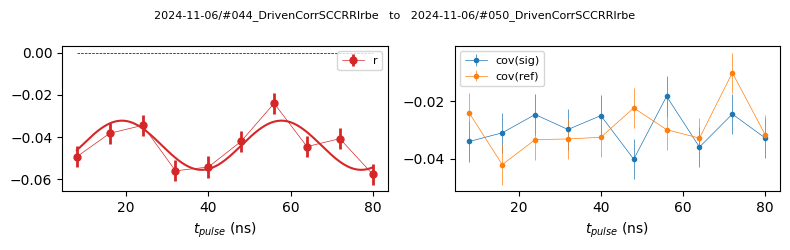

38.821985968701185


In [147]:
fig, axs = plt.subplots(1,2,figsize=(8,2.5))

x=taus
axs[0].errorbar(x, r, sigma_r, marker='o',linewidth=0.5, markersize=5, elinewidth=2, label="r",color="C3")
axs[0].legend(fontsize=8)
axs[0].hlines(y=0,xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')

xfit, yfit, popt, perr = dr.fitSinusoid(x,r,guess=(0.02,40,np.pi,-0.06))
axs[0].plot(xfit, yfit, color='C3')

axs[1].errorbar(x, covSig, sigma_covSig, marker='o', linewidth=0.5, markersize=3, label="cov(sig)")
axs[1].errorbar(x, covRef, sigma_covRef, marker='o', linewidth=0.5, markersize=3, label="cov(ref)", color='C1')
axs[1].legend(fontsize=8)

axs[0].set_xlabel("$t_{pulse}$ (ns)")
axs[1].set_xlabel("$t_{pulse}$ (ns)")
   
s = firstdatafile[31:66] + '   to   ' + datafile[31:66]
fig.suptitle(s, fontsize=8)
plt.tight_layout()
plt.show()
print(popt[1]*2)

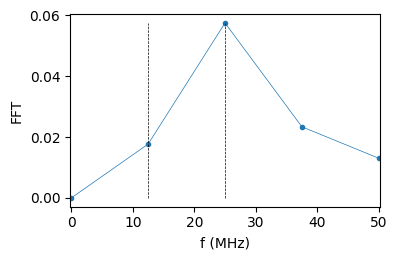

In [148]:
r_zero = np.concatenate((r,np.zeros(len(r)*0))); delta_t=8e-9; markerAt=12.5
f,yfourier = fourier(r_zero,delta_t=delta_t)
fig, ax = plt.subplots(figsize=(4,2.5))
ax.plot(f/1e6,yfourier,'o-', linewidth=0.5, markersize=3, )
ax.vlines(x=markerAt,ymin=min(yfourier),ymax=max(yfourier), linestyle='--', linewidth=0.5, color='k')
ax.vlines(x=2*markerAt,ymin=min(yfourier),ymax=max(yfourier), linestyle='--', linewidth=0.5, color='k')
ax.set_xlim((-0.2,np.max(f/1e6)+0.2))
ax.set_xlabel('f (MHz)')
ax.set_ylabel('FFT');

### For deliv

In [ ]:
# # # Save data
# combined = np.column_stack((x, r, sigma_r))
# folder = 'C:/Users/lukin2dmaterials/data/forDeliv/'; file = 'DrivenCorr_anticorr_003.txt'
# path = folder + file
# np.savetxt(path, combined, delimiter=' ')

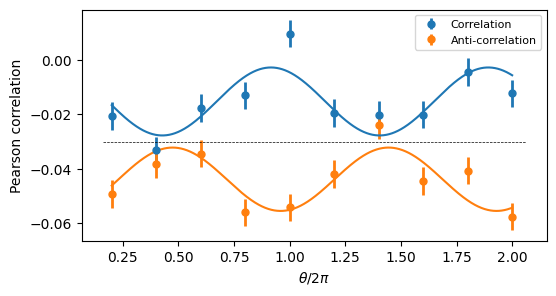

In [150]:
folder = 'C:/Users/lukin2dmaterials/data/forDeliv/'; file = 'DrivenCorr_corr_003.txt'
path = folder + file
loaded = np.loadtxt(path)
x = loaded[:,0]/40; r = loaded[:,1]; sigma_r = loaded[:,2]

folder = 'C:/Users/lukin2dmaterials/data/forDeliv/'; file = 'DrivenCorr_anticorr_003.txt'
path = folder + file
loaded = np.loadtxt(path)
x = loaded[:,0]/40; r2 = loaded[:,1]; sigma_r2 = loaded[:,2]

fig,ax=plt.subplots(figsize=(6,3))
ax.errorbar(x, r, sigma_r, marker='o',linewidth=0, markersize=5, elinewidth=2, label="Correlation")
ax.errorbar(x, r2, sigma_r2, marker='o',linewidth=0, markersize=5, elinewidth=2,label="Anti-correlation")

ax.set_xlabel("$\\theta/2\pi$")
ax.set_ylabel("Pearson correlation")
ax.legend(fontsize=8)

xfit, yfit, popt, perr = dr.fitSinusoid(x,r,guess=(0.02,1,np.pi,0.02))
ax.plot(xfit, yfit, color='C0')

xfit2, yfit2, popt2, perr2 = dr.fitSinusoid(x,r2,guess=(0.02,1,0,0.02))
ax.plot(xfit2, yfit2, color='C1')

ax.hlines(y=(min(yfit)+max(yfit2))/2,xmin=min(x)*0.8,xmax=max(x)*1.03, linestyle='--', linewidth=0.5, color='k')


# XY8 Driven Corr SCC RR Dual NV

In [398]:
# Repeat measuring Driven Corr SCC RR
days = np.linspace(1,31,31); mos = np.linspace(9,10,2); a = 'XY8DrivenCorrSCCRRIrberDualNV'; b = 'T1RRDualNV'; count=0
sigs = None; refs = None; sigs2 = None; refs2 = None; type = a
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-11-' + str(int(day)).zfill(2) + '/'
    try:
        for dataFolder in os.listdir(mainFolder):
            if type in dataFolder:
                idx = int(dataFolder[1:4])
                # if (day==7 and idx>=6 and np.mod(idx,2)==1 and idx<=39): # batch 1 with noise
                if (day==7 and idx>=42 and np.mod(idx,2)==1 and idx<=47):
                    finalDataFolder = mainFolder + dataFolder
                    datafile = finalDataFolder +'/' + type + 'Object_sig_set.dat'
                    ti1=6e3; ti2=6e3; fixed_param_ns=2.5e6
                    if True:
                        taus, sig, sig2, ref, ref2 = dr.readDataFullDataDualNV(datafile)
                    
                        # Sort data taken in random order
                        taus = np.average(taus,axis=1)
                        sorted_indices = np.argsort(taus)
                        taus = taus[sorted_indices]
                        sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                        ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]

                        if sigs is None: sigs = sig
                        else: sigs = np.concatenate((sigs, sig),axis=1)
                        if refs is None: refs = ref
                        else: refs = np.concatenate((refs, ref),axis=1)
                        if sigs2 is None: sigs2 = sig2
                        else: sigs2 = np.concatenate((sigs2, sig2),axis=1)
                        if refs2 is None: refs2 = ref2
                        else: refs2 = np.concatenate((refs2, ref2),axis=1)

                        if count==0: firstdatafile = datafile
                        count+=1
    except:pass
print(np.shape(sigs))
sweepWhat = '$t_{\pi}$'; fixed_param = '$t_{R}$'
if True:
    thres = 12

    sigavg = np.average(sigs,axis=1); refavg = np.average(refs,axis=1)
    sigavg2 = np.average(sigs2,axis=1); refavg2 = np.average(refs2,axis=1)

    max_count = 1.327; min_count = 0.637
    max_contrast = (max_count - min_count)/(max_count + min_count)

    max_count2 = 3.82; min_count2 = 2.667
    max_contrast2 = (max_count2 - min_count2)/(max_count2 + min_count2)

    sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)
    sigma_sig2 = np.std(sigs2, axis=1); sigma_ref2 = np.std(refs2, axis=1)

    snr_styleA = (sigavg-refavg)/np.sqrt(sigma_sig**2 + sigma_ref**2); sigmaR_styleA = np.sqrt(1+2/snr_styleA**2)
    snr_styleB = (sigavg-refavg)/np.sqrt(sigavg+refavg); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

    snr_styleA2 = (sigavg2-refavg2)/np.sqrt(sigma_sig2**2 + sigma_ref2**2); sigmaR_styleA2 = np.sqrt(1+2/snr_styleA2**2)
    snr_styleB2 = (sigavg2-refavg2)/np.sqrt(sigavg2+refavg2); sigmaR_styleB2 = np.sqrt(1+2/snr_styleB2**2)

    # contrast =  contrast_new(sigs, refs, sigavg, refavg, ifNorm=2,max_contrast=max_contrast)
    # contrast2 = contrast_new(sigs2,refs2,sigavg2,refavg2,ifNorm=2,max_contrast=max_contrast2)

    covSig, sigma_covSig,_,_ = cov(sigs,sigs2); covRef, sigma_covRef,_,_ = cov(refs, refs2)
    # covContrast,_,_,_ = cov(contrast, contrast2)  

    combined_sigs = np.concatenate((sigs,refs),axis=1); combined_sigs2 = np.concatenate((sigs2,refs2),axis=1)
    r, sigma_r, aavg,sigma_a = cov(combined_sigs,combined_sigs2)
    print(np.shape(combined_sigs))
                

(10, 15000)
(10, 30000)


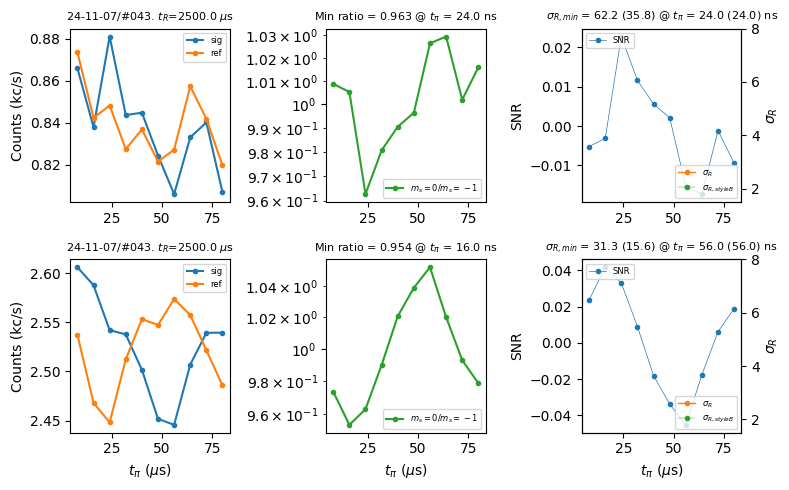

In [399]:
sigs_avg_count = np.average(sigs,axis=1); refs_avg_count = np.average(refs,axis=1)
sigs_avg_count2 = np.average(sigs2,axis=1); refs_avg_count2 = np.average(refs2,axis=1)
x = taus; fontsize=6
if sweepWhat == '$t_{R}$': tr_ns = yplot
else: tr_ns = fixed_param_ns
sigs_avg = sigs_avg_count/(tr_ns/1e6); refs_avg = refs_avg_count/(tr_ns/1e6) 
sigs_avg2 = sigs_avg_count2/(tr_ns/1e6); refs_avg2 = refs_avg_count2/(tr_ns/1e6) 

if True:
    fig, axs = plt.subplots(2,3,figsize=(8,5))
    #######################################################################################################
    axs[0,0].plot(x,sigs_avg,'o-', label="sig",markersize=3)
    axs[0,0].plot(x,refs_avg,'o-', label="ref",markersize=3)
    axs[0,0].legend(fontsize=fontsize)
    axs[0,0].set_ylabel('Counts (kc/s)')
    s = firstdatafile[33:46]
    s1 = '. %s=%.1f $\mu$s' % (fixed_param, fixed_param_ns/1e3)
    axs[0,0].set_title(s+s1, fontsize=fontsize+2)


    y = refs_avg/sigs_avg
    axs[0,1].plot(x,y,'o-', label="$m_s=0/m_s=-1$",markersize=3,color='C2')
    axs[0,1].legend(fontsize=fontsize)
    axs[0,1].set_title('Min ratio = %.3f @ %s = %.1f ns' % (np.min(y), sweepWhat, x[np.argmin(y)]),
                    fontsize=fontsize+2)

    ###########################################
    sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)
    snr =        (sigs_avg_count-refs_avg_count)/np.sqrt(sigma_sig**2 + sigma_ref**2)
    snr_styleB = (sigs_avg_count-refs_avg_count)/np.sqrt(sigs_avg_count + refs_avg_count) # assuming sigma = mean
    sigmaR = np.sqrt(1+2/snr**2); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

    axs[0,2].plot(x, snr, 'o-', linewidth=0.5, markersize=3, label="SNR")
    axs[0,2].legend(loc='upper left',fontsize=fontsize)
    axs[0,2].set_ylabel('SNR')
    axs[0,2].set_title('$\sigma_{R,min}$ = %.1f (%.1f) @ %s = %.1f (%.1f) ns' 
                    % (np.min(sigmaR), np.min(sigmaR_styleB), sweepWhat,
                        x[np.argmin(sigmaR)],x[np.argmin(sigmaR_styleB)]), fontsize=fontsize+2)

    ax=axs[0,2].twinx()
    ax.plot(x, sigmaR,  'o-', color='C1',linewidth=1, markersize=3, label='$\sigma_R$')
    ax.plot(x, sigmaR_styleB,  'o-', color='C2',linewidth=0.3, markersize=3, label='$\sigma_{R, styleB}$')
    axs[0,1].set_yscale('log')
    ax.set_ylim((1.5,8))
    ax.legend(loc='lower right',fontsize=fontsize)
    ax.set_xlabel('$t_i$ ($\mu$s)')
    ax.set_ylabel('$\sigma_R$')

    ########################################################################################################
    axs[1,0].plot(x,sigs_avg2,'o-', label="sig",markersize=3)
    axs[1,0].plot(x,refs_avg2,'o-', label="ref",markersize=3)
    axs[1,0].legend(fontsize=fontsize)
    axs[1,0].set_xlabel(sweepWhat + ' ($\mu$s)')
    axs[1,0].set_ylabel('Counts (kc/s)')
    s = firstdatafile[33:46]
    s1 = '. %s=%.1f $\mu$s' % (fixed_param, fixed_param_ns/1e3)
    axs[1,0].set_title(s+s1, fontsize=fontsize+2)


    y2 = refs_avg2/sigs_avg2
    axs[1,1].plot(x,y2,'o-', label="$m_s=0/m_s=-1$",markersize=3,color='C2')
    axs[1,1].legend(fontsize=fontsize)
    axs[1,1].set_xlabel(sweepWhat + ' ($\mu$s)')
    axs[1,1].set_title('Min ratio = %.3f @ %s = %.1f ns' % (np.min(y2), sweepWhat, x[np.argmin(y2)]),
                    fontsize=fontsize+2)

    ###########################################
    sigma_sig2 = np.std(sigs2, axis=1); sigma_ref2 = np.std(refs2, axis=1)
    snr2 =        (sigs_avg_count2-refs_avg_count2)/np.sqrt(sigma_sig2**2 + sigma_ref2**2)
    snr_styleB2 = (sigs_avg_count2-refs_avg_count2)/np.sqrt(sigs_avg_count2 + refs_avg_count2) # assuming sigma = mean
    sigmaR2 = np.sqrt(1+2/snr2**2); sigmaR_styleB2 = np.sqrt(1+2/snr_styleB2**2)

    axs[1,2].plot(x, snr2, 'o-', linewidth=0.5, markersize=3, label="SNR")
    axs[1,2].legend(loc='upper left',fontsize=fontsize)
    axs[1,2].set_xlabel(sweepWhat + ' ($\mu$s)')
    axs[1,2].set_ylabel('SNR')
    axs[1,2].set_title('$\sigma_{R,min}$ = %.1f (%.1f) @ %s = %.1f (%.1f) ns' 
                    % (np.min(sigmaR2), np.min(sigmaR_styleB2), sweepWhat,
                        x[np.argmin(sigmaR2)],x[np.argmin(sigmaR_styleB2)]), fontsize=fontsize+2)

    ax=axs[1,2].twinx()
    ax.plot(x, sigmaR2,  'o-', color='C1',linewidth=1, markersize=3, label='$\sigma_R$')
    ax.plot(x, sigmaR_styleB2,  'o-', color='C2',linewidth=0.3, markersize=3, label='$\sigma_{R, styleB}$')
    axs[1,1].set_yscale('log')
    ax.set_ylim((1.5,8))
    ax.legend(loc='lower right',fontsize=fontsize)
    ax.set_xlabel('$t_i$ ($\mu$s)')
    ax.set_ylabel('$\sigma_R$')

    plt.tight_layout()
    plt.show()

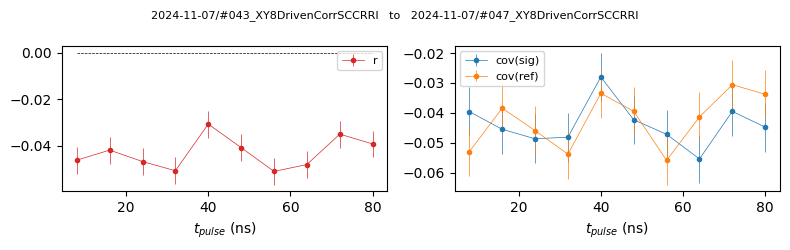

In [400]:
fig, axs = plt.subplots(1,2,figsize=(8,2.5))

x=taus
axs[0].errorbar(x, r, sigma_r, marker='o',linewidth=0.5, markersize=3, label="r",color="C3")
axs[0].legend(fontsize=8)
axs[0].hlines(y=0,xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')

axs[1].errorbar(x, covSig, sigma_covSig, marker='o', linewidth=0.5, markersize=3, label="cov(sig)")
axs[1].errorbar(x, covRef, sigma_covRef, marker='o', linewidth=0.5, markersize=3, label="cov(ref)", color='C1')
axs[1].legend(fontsize=8)

axs[0].set_xlabel("$t_{pulse}$ (ns)")
axs[1].set_xlabel("$t_{pulse}$ (ns)")
   
s = firstdatafile[31:66] + '   to   ' + datafile[31:66]
fig.suptitle(s, fontsize=8)
plt.tight_layout()
plt.show()

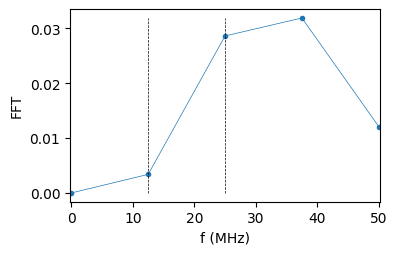

In [401]:
r_zero = np.concatenate((r,np.zeros(len(r)*0))); delta_t=8e-9; markerAt=12.5
f,yfourier = fourier(r_zero,delta_t=delta_t)
fig, ax = plt.subplots(figsize=(4,2.5))
ax.plot(f/1e6,yfourier,'o-', linewidth=0.5, markersize=3, )
ax.vlines(x=markerAt,ymin=min(yfourier),ymax=max(yfourier), linestyle='--', linewidth=0.5, color='k')
ax.vlines(x=2*markerAt,ymin=min(yfourier),ymax=max(yfourier), linestyle='--', linewidth=0.5, color='k')
ax.set_xlim((-0.2,np.max(f/1e6)+0.2))
ax.set_xlabel('f (MHz)')
ax.set_ylabel('FFT');

In [ ]:
# # # Save data
# combined = np.column_stack((x, r, sigma_r))
# folder = 'C:/Users/lukin2dmaterials/data/forDeliv/'; file = 'XY8DrivenCorr_anticorr_003.txt'
# path = folder + file
# np.savetxt(path, combined, delimiter=' ')

[ 0.00476817  0.38434133  1.66292032 -0.03863909]
[ 0.00805146  0.37199733 -2.95252886 -0.04403129]


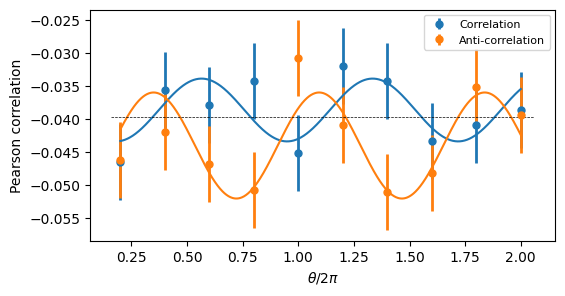

In [404]:
folder = 'C:/Users/lukin2dmaterials/data/forDeliv/'; file = 'XY8DrivenCorr_corr_003.txt'
path = folder + file
loaded = np.loadtxt(path)
x = loaded[:,0]/40; r = loaded[:,1]; sigma_r = loaded[:,2]

folder = 'C:/Users/lukin2dmaterials/data/forDeliv/'; file = 'XY8DrivenCorr_anticorr_003.txt'
path = folder + file
loaded = np.loadtxt(path)
x = loaded[:,0]/40; r2 = loaded[:,1]; sigma_r2 = loaded[:,2]

fig,ax=plt.subplots(figsize=(6,3))
ax.errorbar(x, r, sigma_r, marker='o',linewidth=0, markersize=5, elinewidth=2, label="Correlation")
ax.errorbar(x, r2, sigma_r2, marker='o',linewidth=0, markersize=5, elinewidth=2,label="Anti-correlation")

ax.set_xlabel("$\\theta/2\pi$")
ax.set_ylabel("Pearson correlation")
ax.legend(fontsize=8)

xfit, yfit, popt, perr = dr.fitSinusoid(x,r,guess=(0.02,0.6,np.pi,0.02))
ax.plot(xfit, yfit, color='C0')
print(popt)

guess=(0.005,0.6,0.33,-0.035)
xfit2, yfit2, popt2, perr2 = dr.fitSinusoid(x,r2,guess)
ax.plot(xfit2, yfit2, color='C1')
# ax.plot(xfit2, dr.sinusoid(xfit2,*guess))
print(popt2)
ax.hlines(y=(min(yfit)+max(yfit2))/2,xmin=min(x)*0.8,xmax=max(x)*1.03, linestyle='--', linewidth=0.5, color='k')

 # T1 SCC RR one NV

In [1023]:
# Repeat measuring T1 SCC
days = np.linspace(1,30,30); mos = np.linspace(9,10,2); count=0
dataArr = []; gArr = []; err_gArr = []; sigs = None; refs = None
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-09-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'T1SCCRRIrber' in dataFolder:
            idx = int(dataFolder[1:4])
            if day==26 and idx == 121:# and np.mod(idx,2)==1:
                finalDataFolder = mainFolder + dataFolder
                datafile = finalDataFolder +'/T1SCCRRIrberObject_sig_set.dat'
                power635 = 1600; power532 = 840; power660 = 85
                ti = 13000; tr_ns = 26e5
                if True:
                    taus, sig, ref = dr.readDataFullDataDualNVSingleRead(datafile)
                
                    # Sort data taken in random order
                    taus = np.average(taus,axis=1)
                    sorted_indices = np.argsort(taus)
                    taus = taus[sorted_indices]
                    sig = sig[sorted_indices]
                    ref = ref[sorted_indices]

                    if sigs is None: sigs = sig
                    else: sigs = np.concatenate((sigs, sig),axis=1)
                    if refs is None: refs = ref
                    else: refs = np.concatenate((refs, ref),axis=1)

                    if count==0: firstdatafile = datafile
                    count+=1

print(np.shape(sigs))
sigavg = np.average(sigs,axis=1); refavg = np.average(refs,axis=1)
                

(21, 2000)


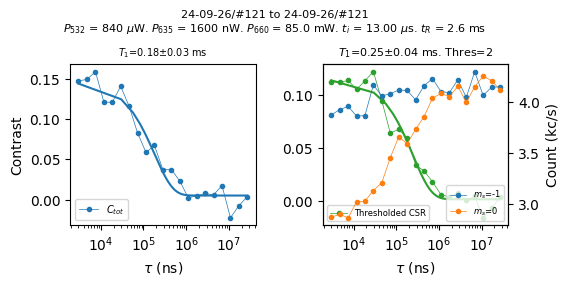

In [1024]:
s = firstdatafile[33:46] + ' to ' + datafile[33:46]
t1s, t1s_err,fig,axs = dr.plotT1Simple(taus, sigs, refs, thresmax=6, 
                                       power660=power660, power532=power532, power635=power635, ti=ti, tr_ns=tr_ns,
                                       ifPlot=1,suptitle=s)

Text(0, 0.5, 'Count (kc/s)')

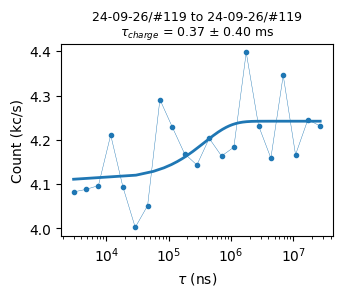

In [984]:
fig,ax= plt.subplots(figsize=(3.5,2.5))

sig_rate = sigavg/tr_ns*1e9/1e3
ax.plot(taus,sig_rate,'o-',markersize=3,linewidth=0.3)

xfit, yfit, popt, perr = dr.fitDecay(taus, sig_rate)
ax.plot(xfit, yfit, linewidth=2, color='C0')
s1 = '$\\tau_{charge}$ = %.2f $\pm$ %.2f ms' % (popt[2]/1e6, perr[2]/1e6)
ax.set_title(s + "\n" + s1, fontsize=9)
ax.set_xscale('log')

ax.set_xlabel('$\\tau$ (ns)')
ax.set_ylabel('Count (kc/s)')

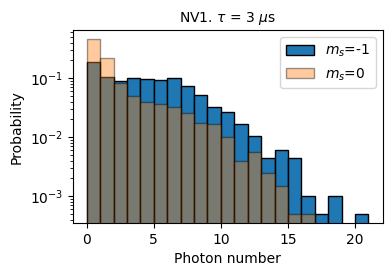

In [818]:
i=0
fig,ax = plt.subplots(figsize=(4,2.5))

hist, bins = np.histogram(sigs[i],bins=np.arange(np.max(sigs[i])+1))
ax.hist(sigs[i], bins=bins, edgecolor='black', density=True, label='$m_s$=-1')
ax.hist(refs[i], bins=bins, edgecolor='black', density=True, color='C1',label='$m_s$=0', alpha=0.4)
ax.set_yscale('log')
ax.legend()
s = r"NV1. $\tau$ = %.0f $\mu$s" % (taus[i]/1e3)
ax.set_title(s, fontsize=10)
ax.set_ylabel('Probability')
ax.set_xlabel('Photon number')

plt.show()

In [3267]:
# ch2 = np.loadtxt('C:/Users/lukin2dmaterials/miniconda3/envs/NV_control/B00_codes/ch2debug.txt', delimiter=',')
# N = len(ch2)
# fig, ax = plt.subplots()
# x = np.linspace(1,N,N)
# ax.plot(x,ch2)
# # ax.set_xlim((50,200))
# print(N)
# # print(1e9/(N+1e4))

### Repeat measuring T1 SCC

In [375]:
days = np.linspace(1,30,30); mos = np.linspace(9,10,2); count=0
dataArr = []; gArr = []; err_gArr = []; t1sArr = []; t1s_errArr = []
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-09-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        # print(dataFolder)
        if 'T1SCCRRIrber' in dataFolder:
            idx = int(dataFolder[1:4])
            if (day==18 and idx >= 11 and idx <= 156) and np.mod(idx,2)==0:
                finalDataFolder = mainFolder + dataFolder
                datafile = finalDataFolder +'/T1SCCRRIrberObject_sig_set.dat'
                power635 = 530; power532 = 640; power660 = 51
                ti=3000; tr_ns = 1.4e6

                sig, ref, hist2DArray_sig, hist2DArray_ref, xplot, yplot, bins1DArray = dr.readDataFullData(
                                    datafile, num_of_bins=50, binwidth=1, plot_hist_every=100, ifPlot=False,
                                    ifDataSavedAsCountRate=False, ifLogColor=True, ifSubtractRef=False, ifPlotRef=False,)

                taus = np.round(np.logspace(3,np.log10(6e6),21),-2)

                t1s, t1s_err,fig,axs = dr.plotT1Simple(taus, sig, ref, thresmax=5, power660=power660, power532=power532, power635=power635,
                                                ti=ti, tr_ns=tr_ns,ifPlot=0)
                t1sArr.append(t1s); t1s_errArr.append(t1s_err)
                if count==0: firstdatafile = datafile
                count+=1

t1sArr = np.array(t1sArr); t1s_errArr = np.array(t1s_errArr)


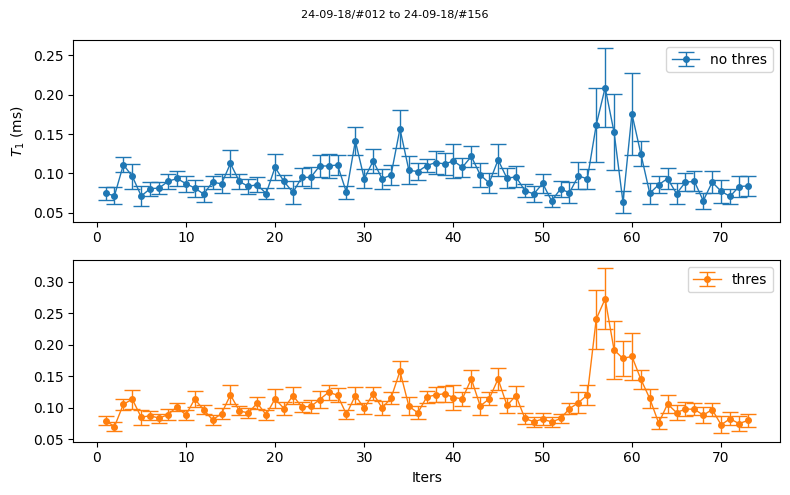

In [376]:
fig, axs = plt.subplots(2,1, figsize=(8,5))
y1 = t1sArr[:,0]; y2=t1sArr[:,1]
x = np.linspace(1,len(y1),len(y1))
axs[0].errorbar(x,y1, t1s_errArr[:,0], markersize=4, linewidth=1, elinewidth=1, fmt='o-', capsize=6, label=('no thres'))
# axs[0].set_xlabel("Iters")
axs[0].set_ylabel("$T_1$ (ms)")
axs[0].legend()
# axs[0].set_ylim((0.1,1.7))

axs[1].errorbar(x,y2, t1s_errArr[:,1], markersize=4, linewidth=1, elinewidth=1, fmt='o-', capsize=6,color='C1',label=('thres'))
axs[1].set_xlabel("Iters")
axs[1].legend()
# axs[1].set_ylim((0.1,1.7))

s = firstdatafile[33:46] + ' to ' + datafile[33:46]
fig.suptitle(s, fontsize=8)

plt.tight_layout()
plt.show()

# T1 SCC RR Dual NV

In [370]:
# Repeat measuring T1 SCC
days = np.linspace(1,4,4); mos = np.linspace(9,10,2); a = 'T1SCCRRIrberDualNV'; b = 'T1RRDualNV'; count=0
sigs = None; refs = None; sigs2 = None; refs2 = None; type = a
for day in days:
    mainFolder = 'C:/Users/lukin2dmaterials/data/2024-10-' + str(int(day)).zfill(2) + '/'
    for dataFolder in os.listdir(mainFolder):
        if type in dataFolder:
            idx = int(dataFolder[1:4])
            if (day==4 and idx >= 22 and idx <= 22):
                finalDataFolder = mainFolder + dataFolder
                datafile = finalDataFolder +'/' + type + 'Object_sig_set.dat'
                ti1 = 4000; ti2=13e3; tr_ns = 2.8e6
                if True:

                    taus, sig, sig2, ref, ref2 = dr.readDataFullDataDualNV(datafile)
                
                    # Sort data taken in random order
                    taus = np.average(taus,axis=1)
                    sorted_indices = np.argsort(taus)
                    taus = taus[sorted_indices]
                    sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                    ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]

                    if sigs is None: sigs = sig
                    else: sigs = np.concatenate((sigs, sig),axis=1)
                    if refs is None: refs = ref
                    else: refs = np.concatenate((refs, ref),axis=1)
                    if sigs2 is None: sigs2 = sig2
                    else: sigs2 = np.concatenate((sigs2, sig2),axis=1)
                    if refs2 is None: refs2 = ref2
                    else: refs2 = np.concatenate((refs2, ref2),axis=1)

                    if count==0: firstdatafile = datafile
                    count+=1
print(np.shape(sigs))
                

(21, 2000)


In [371]:
thres = 12
# sigs = thresholded(sigs,thres); refs = thresholded(refs,thres)
# sigs2 = thresholded(sigs2, thres); refs2 = thresholded(refs2, thres)

sigavg = np.average(sigs,axis=1); refavg = np.average(refs,axis=1)
sigavg2 = np.average(sigs2,axis=1); refavg2 = np.average(refs2,axis=1)

sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)
sigma_sig2 = np.std(sigs2, axis=1); sigma_ref2 = np.std(refs2, axis=1)

snr_styleA = (sigavg-refavg)/np.sqrt(sigma_sig**2 + sigma_ref**2); sigmaR_styleA = np.sqrt(1+2/snr_styleA**2)
snr_styleB = (sigavg-refavg)/np.sqrt(sigavg+refavg); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

snr_styleA2 = (sigavg2-refavg2)/np.sqrt(sigma_sig2**2 + sigma_ref2**2); sigmaR_styleA2 = np.sqrt(1+2/snr_styleA2**2)
snr_styleB2 = (sigavg2-refavg2)/np.sqrt(sigavg2+refavg2); sigmaR_styleB2 = np.sqrt(1+2/snr_styleB2**2)

# contrast = (sigs-refs)/(sigs+refs); contrast = np.nan_to_num(contrast, nan=0)#/2+0.5
# contrast2 = (sigs2-refs2)/(sigs2+refs2); contrast2 = np.nan_to_num(contrast2, nan=0)#/2+0.5

contrast = contrast_new(sigs,refs,sigavg,refavg,ifNorm=1); contrast2 = contrast_new(sigs2, refs2,sigavg2,refavg2,ifNorm=1)
# contrast_avg = np.average(contrast, axis=1); contrast_avg2 = np.average(contrast2, axis=1)

covSig = cov(sigs,sigs2); covRef = cov(refs, refs2)
covContrast = cov(contrast, contrast2)

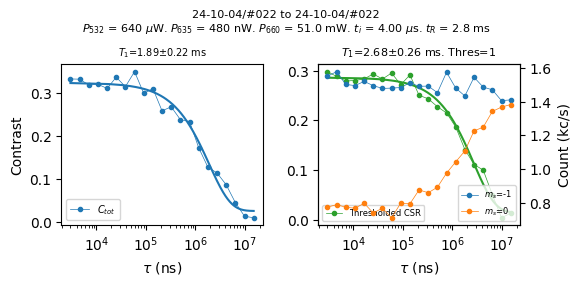

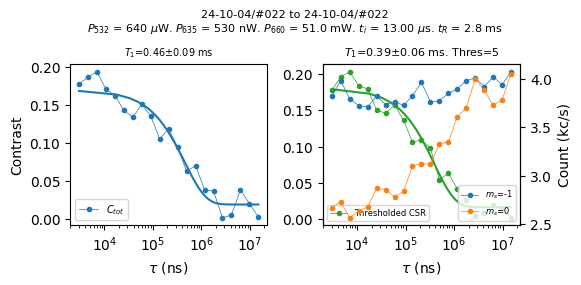

In [372]:
s = firstdatafile[33:46] + ' to ' + datafile[33:46]
t1s, t1s_err,fig,axs = dr.plotT1Simple(taus, sigs, refs, ifThres=1, thres=thres, thresmax=10, ifContrastFirstThenAvg=0,
                               power660=51, power532=640, power635=480, ti=ti1, tr_ns=tr_ns,suptitle=s)
t1s2, t1s_err2,fig,axs = dr.plotT1Simple(taus, sigs2, refs2, ifThres=1, thres=thres, thresmax=10, ifContrastFirstThenAvg=0,
                               power660=51, power532=640, power635=530, ti=ti2, tr_ns=tr_ns,suptitle=s)

In [373]:
# fig,ax=plt.subplots(figsize=(4,3))
# y = (sigavg-refavg)/(sigavg+refavg)
# y = linear_map(y,min(y),max(y),0,1)
# ax.plot(taus,y,'o-', linewidth=0.5, markersize=3)
# ax.set_xscale('log')

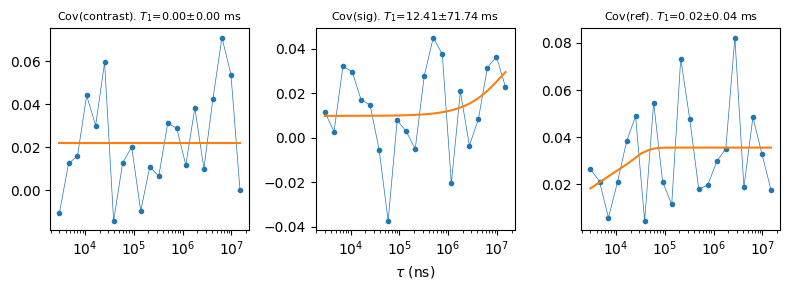

In [374]:
fig, axs = plt.subplots(1,3,figsize=(8,3))

axs[0].plot(taus, covContrast, 'o-', linewidth=0.5, markersize=3, label="covRef")
xfit, yfit, popt, perr = dr.fitDecay(taus,covContrast,guess=(0.03,0,1e6))
axs[0].plot(xfit,yfit)
s = "Cov(contrast). $T_{1}$=%.2f$\pm$%.2f ms" % (popt[2]/1e6, perr[2]/1e6)
axs[0].set_title(s, fontsize=8)
axs[0].set_xscale('log')


axs[1].plot(taus, covSig, 'o-', linewidth=0.5, markersize=3, label="covSig")
xfit, yfit, popt, perr = dr.fitDecay(taus,covSig,guess=(0.03,0,1e6))
axs[1].plot(xfit,yfit)
s = "Cov(sig). $T_{1}$=%.2f$\pm$%.2f ms" % (popt[2]/1e6, perr[2]/1e6)
axs[1].set_title(s, fontsize=8)
axs[1].set_xscale('log')
axs[1].set_xlabel('$\\tau$ (ns)')

axs[2].plot(taus, covRef, 'o-', linewidth=0.5, markersize=3, label="covRef")
xfit, yfit, popt, perr = dr.fitDecay(taus,covRef,guess=(0.03,0,1e6))
axs[2].plot(xfit,yfit)
s = "Cov(ref). $T_{1}$=%.2f$\pm$%.2f ms" % (popt[2]/1e6, perr[2]/1e6)
axs[2].set_title(s, fontsize=8)
axs[2].set_xscale('log')

plt.tight_layout()
plt.show()

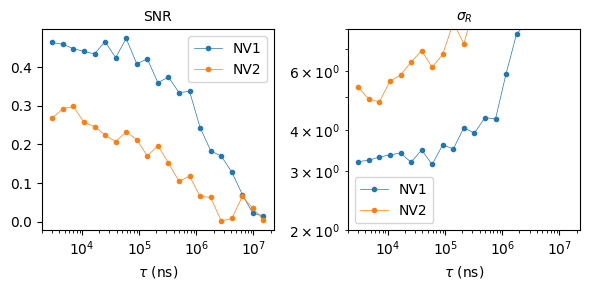

In [375]:
fig, axs = plt.subplots(1,2,figsize=(6,3))

axs[0].plot(taus, snr_styleA, 'o-', linewidth=0.5, markersize=3, label="NV1")
axs[0].plot(taus, snr_styleA2, 'o-', linewidth=0.5, markersize=3, label="NV2")
s = "SNR"
axs[0].set_title(s, fontsize=10)
axs[0].set_xscale('log')
axs[0].legend()
axs[0].set_xlabel('$\\tau$ (ns)')

axs[1].plot(taus, sigmaR_styleA,  'o-', linewidth=0.5, markersize=3, label="NV1")
axs[1].plot(taus, sigmaR_styleA2, 'o-', linewidth=0.5, markersize=3, label="NV2")
s = "$\sigma_R$"
axs[1].set_title(s, fontsize=10)
axs[1].set_xscale('log'); axs[1].set_yscale('log')
axs[1].set_ylim((2,8))
axs[1].legend()
axs[1].set_xlabel('$\\tau$ (ns)')

plt.tight_layout()
plt.show()

### Histogram

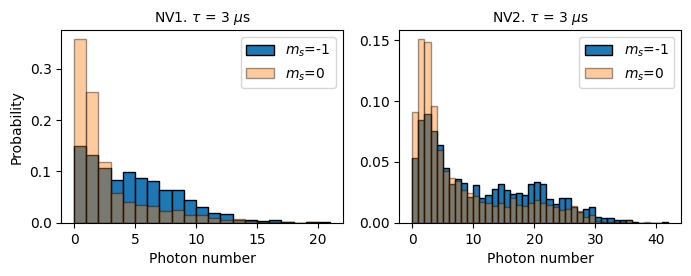

In [363]:
i=0
fig,axs = plt.subplots(1,2,figsize=(8,2.5))

hist, bins = np.histogram(sigs[i],bins=np.arange(np.max(sigs[i])+1))
axs[0].hist(sigs[i], bins=bins, edgecolor='black', density=True, label='$m_s$=-1')
axs[0].hist(refs[i], bins=bins, edgecolor='black', density=True, color='C1',label='$m_s$=0', alpha=0.4)
# axs[0].set_yscale('log')
axs[0].legend()
s = r"NV1. $\tau$ = %.0f $\mu$s" % (taus[i]/1e3)
axs[0].set_title(s, fontsize=10)
axs[0].set_ylabel('Probability')
axs[0].set_xlabel('Photon number')

hist, bins = np.histogram(sigs2[i],bins=np.arange(np.max(sigs2[i])+1))
axs[1].hist(sigs2[i], bins=bins, edgecolor='black', density=True, label='$m_s$=-1')
axs[1].hist(refs2[i], bins=bins, edgecolor='black', density=True, color='C1',label='$m_s$=0', alpha=0.4)
# axs[1].set_yscale('log')
axs[1].legend()
s = r"NV2. $\tau$ = %.0f $\mu$s" % (taus[i]/1e3)
axs[1].set_title(s, fontsize=10)
axs[1].set_xlabel('Photon number')

plt.show()

# XY8 SCC RR Dual NV

### Sweep tau

In [ ]:
# Repeat measuring T2E/XY8
days = np.linspace(1,30,30); mos = np.linspace(9,11,3); count=0
sigs = None; refs = None; sigs2 = None; refs2 = None; type='XY8'
if type == 'T2E':
    name1 = 'T2ESCCRRIrberDualNV'; name2 = '/T2ESCCRRIrberDualNVObject_sig_set.dat'
elif type == 'XY8':
    name1 = 'XY8SCCRRIrberDualNV'; name2 = '/XY8SCCRRIrberDualNVObject_sig_set.dat'
else:
    name1 = 'PLSCCRRDualNV'; name2 = '/PLSCCRRDualNVObject_sig_set.dat'
for mo in mos:
    for day in days:
        mainFolder = 'C:/Users/lukin2dmaterials/data/2024-'  + str(int(mo)).zfill(2) +'-' + str(int(day)).zfill(2) + '/'
        try:
            for dataFolder in os.listdir(mainFolder):
                if name1 in dataFolder:
                    idx = int(dataFolder[1:4])
                    # if (day==28) or (day == 29 and idx <= 36): #no noise, sine detect, flip NV1, WRONG REF 2
                    # if (day == 29 and idx >= 71) or (day == 30 and idx <= 27): # 1.75MHz-50kHz-0.25V, sine, flip NV1, WRONG REF 2
                    # if (mo==9 and day == 300 and idx >=90) or (mo==10 and day==1 and idx>=50 and idx <= 56): #1.75MHz-50kHz-0.25V, sine, flip NV1, WRONG REF 2
                    # if (mo==10 and day == 1 and idx >= 65 and idx <= 67): #1.75MHz-50kHz-0.25V, sine, flip NV1, CORRECT REF 2, phi = 1.03
                    # if (mo==10 and day == 2 and idx <= 30): #1.75MHz-50kHz-0.25V, sine, flip NV1, phi = 1.03, shorter
                    # if (mo==10 and day == 2 and idx >= 31 and idx <= 39):
                    # if (mo==10 and day == 2 and idx >= 72 and idx <= 74): #batch 7
                    #### if (mo==10 and day == 2 and idx >= 90) or (mo==10 and day==3 and idx <= 18):
                    # if (mo==10 and day==2 and idx>=72 and idx<=74) or (mo==10 and day==3 and idx>=23) or (mo==10 and day==4 and idx<=20):# or (mo==10 and day == 5 and idx >= 5 and idx <= 37):
                    # if (mo==10 and day == 5 and idx >= 5 and idx <= 37):  # no tau extra  
                    #### if (mo==10 and day == 5 and (idx <=2 or idx >= 86)) or (mo==10 and day==6) or (mo==10 and day==7 and idx<=20):
                    # if (mo==10 and day==7 and idx>=38 and idx<=43):
                    # if (mo==10 and day==9 and idx <= 52): # batch 13
                    # if (mo==10 and day==9 and idx>= 58 and idx <= 63): # batch 14
                    # if (mo==10 and day==10 and idx>=42) or (mo==100 and day==11 and idx<=5):  # batch 15
                    # if (mo==10 and day==9 and idx <= 52) or (mo==10 and day==9 and idx>= 58 and idx <= 63) or (mo==10 and day==10 and idx>=42) or (mo==10 and day==11 and idx<=5): # batch 13-14-15
                    #### if (mo==10 and day==11 and idx>=123) or (mo==10 and day==12 and idx<=2): # batch 16 anticorr NV2, high PW 
                    #### if (mo==10 and day==13 and idx>=69 and idx<=75): #anticorr NV2 batch 17 increased green
                    #### if (mo==10 and day==14 and idx>=3 and idx<=33): # batch 18
                    # if (mo==10 and day==14 and idx==56) or (mo==10 and day==15 and idx>=9 and idx<=40): #batch19
                    # if (mo==10 and day==15 and idx >=45 and idx <=56): #batch 20
                    # if (mo==10 and day==17 and idx >= 20 and idx <= 28): #batch 21 accidental
                    # if (mo==10 and day==17 and idx >= 30 and idx <= 59) or (mo==10 and day==18 and idx<=18): #batch 22 background 
                    # if (mo==10 and day==18 and idx>=20 and idx<=21) or (mo==10 and day==19 and idx>=19 and idx<=28): #batch 23  
                    # if (mo==10 and day==19 and idx>=31 and idx<=34): #batch 24
                    # if (mo==10 and day==20 and idx>=1 and idx<=25): #batch 25
                    # if (mo==10 and day==20 and idx>=38) or (mo==10 and day==21 and idx<=3): #batch 26  
                    # if (mo==10 and day==21 and idx>=24 and idx<=25): #batch 27
                    # if (mo==10 and day==21 and idx>=24 and idx<=27): #batch 28
                    # if (mo==10 and day==21 and idx>=61 and idx<=72) or (mo==10 and day==22 and idx <= 18): #batch 29
                    # if (mo==10 and day==21 and idx>=61 and idx<=72) or (mo==10 and day==22 and idx <= 18)or(mo==10 and day==22 and idx>=33) or (mo==10 and day==23 and idx<=22): #batch 29 and 30
                    # if (mo==10 and day==23 and idx >= 24 and idx<=39): #batch 31 N=1
                    # if (mo==10 and day==23 and idx>=40 and idx<=57): #batch 32 N=10
                    # if (mo==10 and day==23 and idx>=65 and idx<=66) or (mo==10 and day==24 and idx>=9 and idx<=23): #batch 33
                    # if (mo==10 and day==24 and idx>=26 and idx<=31): #batch34
                    # if (mo==10 and day==21 and idx>=61 and idx<=72) or (mo==10 and day==22 and idx <= 18)or(mo==10 and day==22 and idx>=33) or (mo==10 and day==23 and idx<=22) or (mo==10 and day==9 and idx <= 52) or (mo==10 and day==9 and idx>= 58 and idx <= 63) or (mo==10 and day==10 and idx>=42) or (mo==10 and day==11 and idx<=5): #batch13,14,15,29,30
                    # if (mo==11 and day==3 and idx>=36 and idx<=52): #phi first = 0.5 batch 35
                    # if (mo==11 and day==3 and idx>=60 and idx<=78): #phi first = 0.12 batch 36
                    # if (mo==11 and day==3 and idx>=79) or (mo==11 and day==4 and idx<=4): #phi first = 0.5 again batch 37
                    # if (mo==11 and day==3) or (mo==11 and day==4 and idx<=4): #batch 35-36-37
                    # if (mo==11 and day==4 and idx>=64 and idx<=76): # batch 38 36 ns pp
                    # if (mo==111 and day==5 and idx>=62 and idx<=92) or (mo==11 and day==6 and idx>=38):
                    if (mo==11 and day==6 and idx>=52 and idx<=53): # cosine, so doesn't count as a batch
                        finalDataFolder = mainFolder + dataFolder
                        datafile = finalDataFolder + name2
                        ti = 2700; tr_ns = 3e6

                        if type == 'XY8':
                            taus, sig, sig2, ref, ref2 = dr.readDataFullDataDualNV(datafile)
                        else:
                            taus, ref, ref2, sig, sig2 = dr.readDataFullDataDualNV(datafile)

                        # Sort data taken in random order
                        taus = np.average(taus,axis=1)
                        sorted_indices = np.argsort(taus)
                        taus = taus[sorted_indices]
                        sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                        ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]

                        if sigs is None: sigs = sig
                        else: sigs = np.concatenate((sigs, sig),axis=1)
                        if refs is None: refs = ref
                        else: refs = np.concatenate((refs, ref),axis=1)
                        if sigs2 is None: sigs2 = sig2
                        else: sigs2 = np.concatenate((sigs2, sig2),axis=1)
                        if refs2 is None: refs2 = ref2
                        else: refs2 = np.concatenate((refs2, ref2),axis=1)

                        if count==0: firstdatafile = datafile
                        count+=1
        except: pass

print(np.shape(sigs))   

if True:
    thres = 12
    # sigs = thresholded(sigs,thres); refs = thresholded(refs,thres)
    # sigs2 = thresholded(sigs2, thres); refs2 = thresholded(refs2, thres)

    sigavg = np.average(sigs,axis=1); refavg = np.average(refs,axis=1)
    sigavg2 = np.average(sigs2,axis=1); refavg2 = np.average(refs2,axis=1)

    max_count = 1.67; min_count = 0.85
    max_contrast = (max_count - min_count)/(max_count + min_count)

    max_count2 = 4.25; min_count2 = 3.12
    max_contrast2 = (max_count2 - min_count2)/(max_count2 + min_count2)

    sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)
    sigma_sig2 = np.std(sigs2, axis=1); sigma_ref2 = np.std(refs2, axis=1)

    snr_styleA = (sigavg-refavg)/np.sqrt(sigma_sig**2 + sigma_ref**2); sigmaR_styleA = np.sqrt(1+2/snr_styleA**2)
    snr_styleB = (sigavg-refavg)/np.sqrt(sigavg+refavg); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

    snr_styleA2 = (sigavg2-refavg2)/np.sqrt(sigma_sig2**2 + sigma_ref2**2); sigmaR_styleA2 = np.sqrt(1+2/snr_styleA2**2)
    snr_styleB2 = (sigavg2-refavg2)/np.sqrt(sigavg2+refavg2); sigmaR_styleB2 = np.sqrt(1+2/snr_styleB2**2)

    # contrast = (sigs-refs)/(sigs+refs); contrast = np.nan_to_num(contrast, nan=0)#/2+0.5
    # contrast2 = (sigs2-refs2)/(sigs2+refs2); contrast2 = np.nan_to_num(contrast2, nan=0)#/2+0.5

    contrast =  contrast_new(sigs, refs, sigavg, refavg, ifNorm=2,max_contrast=max_contrast)
    contrast2 = contrast_new(sigs2,refs2,sigavg2,refavg2,ifNorm=2,max_contrast=max_contrast2)
    # contrast_avg = np.average(contrast, axis=1); contrast_avg2 = np.average(contrast2, axis=1)

    covSig, sigma_covSig,_,_ = cov(sigs,sigs2); covRef, sigma_covRef,_,_ = cov(refs, refs2)
    # covContrast = cov(contrast, contrast2)  

    r = (covSig - covRef)
    # r = covContrast

(12, 20000)


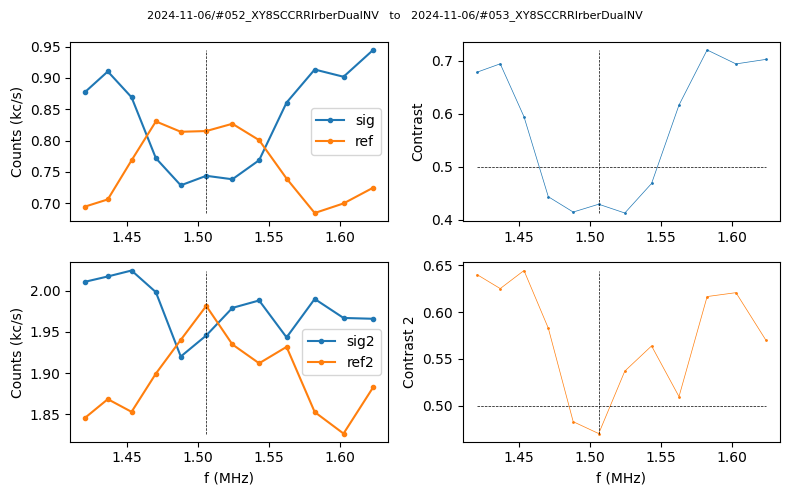

In [185]:
ifXAxisFreq = 1; correctionToTau = 36; NXY8=5; markerAt = 1.506024; ifNormedTo01=1;correctionToTau2=correctionToTau
xPlot = taus

t = (xPlot+correctionToTau)/1e3; t2 = (xPlot+correctionToTau2)/1e3
if ifXAxisFreq: 
    x = 1/(2*t); x2 = 1/(2*t2)
else: 
    x = 8*t*NXY8; x2 = 8*t2*NXY8

y = (sigavg-refavg)/(sigavg+refavg); ys = sigavg/(tr_ns/1e6); yr = refavg/(tr_ns/1e6)
y2 = (sigavg2-refavg2)/(sigavg2+refavg2); ys2 = sigavg2/(tr_ns/1e6); yr2 = refavg2/(tr_ns/1e6)

if ifNormedTo01:
    # # for cosine
    # y=-y;y2=-y2
    # y = linear_map(y,-(y.max()),y.max(),0,1)
    # y2 = linear_map(y2,-(y2.max()),y2.max(),0,1)

    # for sine
    y = linear_map(y,-max_contrast, max_contrast, 0, 1)
    y2 = linear_map(y2,-max_contrast2, max_contrast2, 0, 1)

if True:
    fig, axs = plt.subplots(2,2,figsize=(8,5))
    axs[0,1].plot(x,y, 'o-', linewidth=0.5,markersize=1, label="contrast")
    axs[0,1].set_ylabel('Contrast')
    axs[0,1].vlines(x=markerAt,ymin=min(y),ymax=max(y), linestyle='--', linewidth=0.5, color='k')
    axs[0,1].hlines(y=0.5, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')
    # axs[0,1].set_xlim((-0.1,4))

    axs[0,0].plot(x, ys, 'o-', markersize=3, label="sig")
    axs[0,0].plot(x, yr, 'o-', markersize=3, label="ref")
    axs[0,0].legend()
    axs[0,0].set_ylabel('Counts (kc/s)')
    axs[0,0].vlines(x=markerAt,ymin=min(yr),ymax=max(ys), linestyle='--', linewidth=0.5, color='k')
    # axs[0,0].set_ylim((0.2,1.8))

    ################################################################################
    axs[1,1].plot(x2,y2, 'o-', linewidth=0.5,markersize=1, color='C1',label="contrast 2")
    axs[1,1].set_ylabel('Contrast 2')
    axs[1,1].set_xlabel(r"$\tau$ ($\mu$s)")
    axs[1,1].vlines(x=markerAt,ymin=min(y2),ymax=max(y2), linestyle='--', linewidth=0.5, color='k')
    axs[1,1].hlines(y=0.5, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')
    if ifXAxisFreq: axs[1,1].set_xlabel("f (MHz)")
    # axs[1,1].set_xlim((-0.1,2.6))

    axs[1,0].plot(x2, ys2, 'o-', markersize=3, label="sig2")
    axs[1,0].plot(x2, yr2, 'o-', markersize=3, label="ref2")
    axs[1,0].legend()
    axs[1,0].set_xlabel(r"$\tau$ ($\mu$s)")
    axs[1,0].vlines(x=markerAt,ymin=min(yr2),ymax=max(ys2), linestyle='--', linewidth=0.5, color='k')
    if ifXAxisFreq: axs[1,0].set_xlabel("f (MHz)")
    axs[1,0].set_ylabel('Counts (kc/s)')
    # axs[1,0].set_ylim((0.7,2.6))

    s = firstdatafile[31:66] + '   to   ' + datafile[31:66]
    fig.suptitle(s, fontsize=8)

    plt.tight_layout()

if False: 
    N = NXY8*8
    Sf = -np.log(y)/(N*t)*pi
    Sf2 = -np.log(y2)/(N*t2)*pi

    fig, axs = plt.subplots(2,1,figsize=(8,4))
    axs[0].plot(x,Sf, 'o-', linewidth=0.5,markersize=1, label="contrast")
    axs[0].set_ylabel('S(f) (MHz)')
    axs[0].vlines(x=markerAt,ymin=min(Sf),ymax=max(Sf), linestyle='--', linewidth=0.5, color='k')
    # axs[0].vlines(x=markerAt/3,ymin=min(Sf),ymax=max(Sf), linestyle='--', linewidth=0.5, color='k')
    # axs[0].vlines(x=markerAt/5,ymin=min(Sf),ymax=max(Sf), linestyle='--', linewidth=0.5, color='k')
    s = firstdatafile[31:67] + '   to   ' + datafile[31:67]
    axs[0].set_title(s,fontsize=8)
    # axs[0].set_xlim((-0.1,4))
    # axs[0].set_ylim((0.47,0.61))

    axs[1].plot(x2,Sf2, 'o-', linewidth=0.5,markersize=1, color='C1',label="contrast 2")
    axs[1].set_ylabel('S(f) (MHz)')
    axs[1].set_xlabel(r"$\tau$ ($\mu$s)")
    axs[1].vlines(x=markerAt,ymin=min(Sf2),ymax=max(Sf2), linestyle='--', linewidth=0.5, color='k')
    # axs[1].vlines(x=markerAt/3,ymin=min(Sf2),ymax=max(Sf2), linestyle='--', linewidth=0.5, color='k')
    # axs[1].vlines(x=markerAt/5,ymin=min(Sf2),ymax=max(Sf2), linestyle='--', linewidth=0.5, color='k')
    if ifXAxisFreq: axs[1].set_xlabel("f (MHz)")
    # axs[1].set_xlim((-0.1,5.1))

    plt.tight_layout()

In [186]:
folder = 'C:/Users/lukin2dmaterials/data/forDeliv/'; file = 'XY8-5-Noise_011.txt'
path = folder + file
loaded = np.loadtxt(path)
y = loaded[:,4]; y2 = loaded[:,5]
c1t = y; c2t=y2

# # Save data
# combined = np.column_stack((x, r, sigma_covSig + sigma_covRef))
# folder = 'C:/Users/lukin2dmaterials/data/forDeliv/'; file = 'XY8SCCRR-5-noNoise-022.txt'
# path = folder + file
# np.savetxt(path, combined, delimiter=' ')

folder = 'C:/Users/lukin2dmaterials/data/forDeliv/'; file = 'XY8SCCRR-5-noNoise-022.txt'
path = folder + file
loaded = np.loadtxt(path)
r0 = loaded[:,1]; err0 = loaded[:,2]

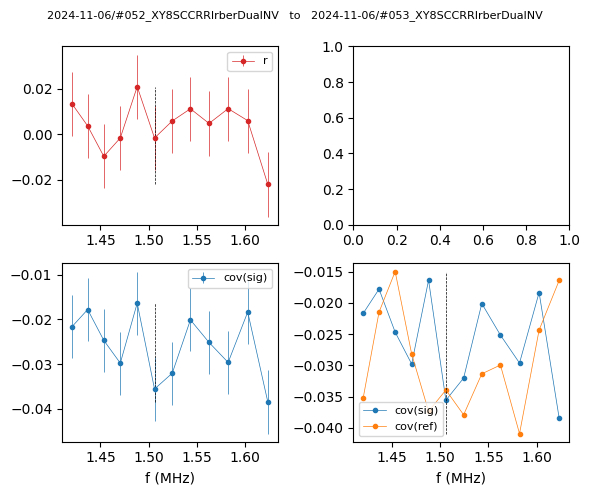

In [187]:
fig, axs = plt.subplots(2,2,figsize=(6,5))

# sf = np.arcsinh(10*r/(c1_OldRR_XY85*c2_OldRR_XY852))/t
# ycov_OldRR_XY85 = -sf

# axs[0,0].plot(x, r, 'o-', linewidth=0.5, markersize=3, label="r",color="C3")
axs[0,0].errorbar(x, r, sigma_covSig+sigma_covRef, marker='o',linewidth=0.5, markersize=3, label="r",color="C3")
# axs[0,0].errorbar(x, r0,err0, marker='o',linewidth=0.5, markersize=3, label="$r_{bkg}$",color="C2")
axs[0,0].legend(fontsize=8)
axs[0,0].vlines(x=markerAt,ymin=min(r),ymax=max(r), linestyle='--', linewidth=0.5, color='k')
# axs[0,0].vlines(x=markerAt+0.1,ymin=min(r),ymax=max(r), linestyle='--', linewidth=0.5, color='k')
# axs[0,0].vlines(x=markerAt-0.1,ymin=min(r),ymax=max(r), linestyle='--', linewidth=0.5, color='k')

# r = r[2:]; t = t[2:]; c1t = c1t[0:-2]; c2t = c2t[0:-2]
# sf = np.arcsinh(24*r/(c1t*c2t))/(NXY8*t)
# axs[0,1].plot(x[2:], sf, 'o-', linewidth=0.5, markersize=3, label="$S_f$",color="C3")
# # axs[0,1].plot(x[2:], sfnonoise, 'o-', linewidth=0.5, markersize=3, label="$S_f,bkg$",color="C2")

# sf = np.arcsinh(24*r/(c1t*c2t))/(NXY8*t)
# axs[0,1].plot(x, sf, 'o-', linewidth=0.5, markersize=3, label="$S_f$",color="C3")
# # axs[0,1].plot(x, sfnonoise, 'o-', linewidth=0.5, markersize=3, label="$S_f,bkg$",color="C2")
# axs[0,1].vlines(x=markerAt,ymin=min(sf),ymax=max(sf), linestyle='--', linewidth=0.5, color='k')
# # axs[0,1].vlines(x=markerAt+0.1,ymin=min(sf),ymax=max(sf), linestyle='--', linewidth=0.5, color='k')
# # axs[0,1].vlines(x=markerAt-0.1,ymin=min(sf),ymax=max(sf), linestyle='--', linewidth=0.5, color='k')
# axs[0,1].legend(fontsize=8)
# # axs[0].set_ylabel('$S_f$')

# axs[1,0].plot(x, covSig, 'o-', linewidth=0.5, markersize=3, label="cov(sig)")
axs[1,0].errorbar(x, covSig, sigma_covSig, marker='o',linewidth=0.5, markersize=3, label="cov(sig)")
s = "Cov(sig)"
axs[1,0].legend(fontsize=8)
axs[1,0].set_xlabel('$\\tau$ ($\mu$s)')
axs[1,0].vlines(x=markerAt,ymin=min(covSig),ymax=max(covSig), linestyle='--', linewidth=0.5, color='k')
# axs[1,0].vlines(x=markerAt+0.1,ymin=min(covSig),ymax=max(covSig), linestyle='--', linewidth=0.5, color='k')
# axs[1,0].vlines(x=markerAt-0.1,ymin=min(covSig),ymax=max(covSig), linestyle='--', linewidth=0.5, color='k')

axs[1,1].plot(x, covSig, 'o-', linewidth=0.5, markersize=3, label="cov(sig)")
axs[1,1].plot(x, covRef, 'o-', linewidth=0.5, markersize=3, label="cov(ref)", color='C1')
s = "Cov(ref)"
axs[1,1].legend(fontsize=8)
axs[1,1].vlines(x=markerAt,ymin=min(covRef),ymax=max(covRef), linestyle='--', linewidth=0.5, color='k')

if ifXAxisFreq: 
    axs[1,0].set_xlabel("f (MHz)")
    axs[1,1].set_xlabel("f (MHz)")
    # for i in range(3):
    #     axs[i].set_xscale('log')

s = firstdatafile[31:66] + '   to   ' + datafile[31:66]
fig.suptitle(s, fontsize=8)
plt.tight_layout()
plt.show()

In [88]:
# sfnonoise = sf
# # sfnoise = sf

### Sweep tau but not combining batches

In [ ]:
# Repeat measuring T2E/XY8
days = np.linspace(1,30,30); mos = np.linspace(9,11,3); count=0
sigs = None; refs = None; sigs2 = None; refs2 = None; type='XY8'; 
covSigs=None; covRefs=None; rs=None; sigma_covSigs=None; sigma_covRefs=None
if type == 'T2E':
    name1 = 'T2ESCCRRIrberDualNV'; name2 = '/T2ESCCRRIrberDualNVObject_sig_set.dat'
elif type == 'XY8':
    name1 = 'XY8SCCRRIrberDualNV'; name2 = '/XY8SCCRRIrberDualNVObject_sig_set.dat'
else:
    name1 = 'PLSCCRRDualNV'; name2 = '/PLSCCRRDualNVObject_sig_set.dat'
for mo in mos:
    for day in days:
        mainFolder = 'C:/Users/lukin2dmaterials/data/2024-'  + str(int(mo)).zfill(2) +'-' + str(int(day)).zfill(2) + '/'
        try:
            for dataFolder in os.listdir(mainFolder):
                if name1 in dataFolder:
                    idx = int(dataFolder[1:4])
                    if (mo==11 and day==5 and idx>=62 and idx<=92) or (mo==11 and day==6 and idx>=1 and idx<=4):
                        finalDataFolder = mainFolder + dataFolder
                        datafile = finalDataFolder + name2
                        ti = 2700; tr_ns = 3e6
                        if type == 'XY8':
                            taus, sig, sig2, ref, ref2 = dr.readDataFullDataDualNV(datafile)
                        else:
                            taus, ref, ref2, sig, sig2 = dr.readDataFullDataDualNV(datafile)

                        # Sort data taken in random order
                        taus = np.average(taus,axis=1)
                        sorted_indices = np.argsort(taus)
                        taus = taus[sorted_indices]
                        sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                        ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]

                        if sigs is None: sigs = sig
                        else: sigs = np.concatenate((sigs, sig),axis=1)
                        if refs is None: refs = ref
                        else: refs = np.concatenate((refs, ref),axis=1)
                        if sigs2 is None: sigs2 = sig2
                        else: sigs2 = np.concatenate((sigs2, sig2),axis=1)
                        if refs2 is None: refs2 = ref2
                        else: refs2 = np.concatenate((refs2, ref2),axis=1)

                        covSig, sigma_covSig,_,_ = cov(sig,sig2)
                        covRef, sigma_covRef,_,_ = cov(ref, ref2)
                        r = (covSig - covRef)
                        
                        if covSigs is None: covSigs = covSig
                        else: covSigs = np.vstack((covSigs, covSig))
                        if covRefs is None: covRefs = covRef
                        else: covRefs = np.vstack((covRefs, covRef))
                        if rs is None: rs = r
                        else: rs = np.vstack((rs, r))
                        if sigma_covSigs is None: sigma_covSigs = sigma_covSig
                        else: sigma_covSigs = np.vstack((sigma_covSigs, sigma_covSig))
                        if sigma_covRefs is None: sigma_covRefs = sigma_covRef
                        else: sigma_covRefs = np.vstack((sigma_covRefs, sigma_covRef))

                        if count==0: firstdatafile = datafile
                        count+=1
        except: pass

print(np.shape(sigs)); print(np.shape(rs))   

(12, 200000)
(20, 12)


In [143]:
ifXAxisFreq = 1; correctionToTau = 36; NXY8=5; markerAt = 1.506024; ifNormedTo01=1;correctionToTau2=correctionToTau
xPlot = taus

t = (xPlot+correctionToTau)/1e3; t2 = (xPlot+correctionToTau2)/1e3
if ifXAxisFreq: 
    x = 1/(2*t); x2 = 1/(2*t2)
else: 
    x = 8*t*NXY8; x2 = 8*t2*NXY8

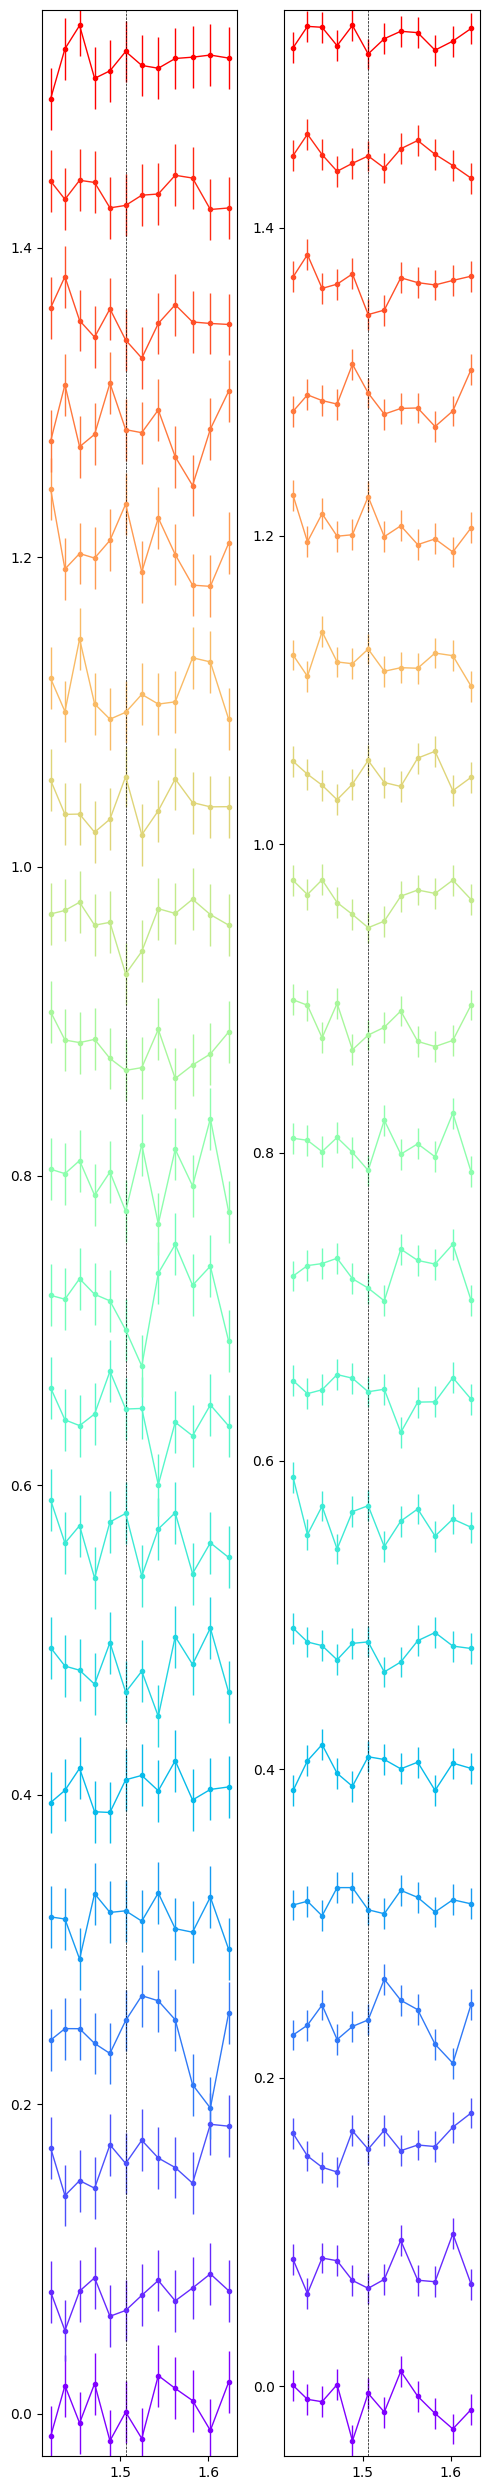

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(5,25))
N,m = np.shape(rs)

# Create a colormap
cmap = plt.cm.rainbow  # You can use other colormaps like 'plasma', 'inferno', etc.
norm = plt.Normalize(vmin=0, vmax=N-1)  # Normalize the color scale based on the number of traces
sc = 0.075
for i in range(N):
    color = cmap(norm(i))  # Get the color for the current trace
    axs[0].errorbar(x, rs[i]+sc*i, sigma_covSigs[i]+sigma_covRefs[i], marker='o',linewidth=1, markersize=3, label="r",color=color)
    axs[1].errorbar(x, covSigs[i]+sc*i, sigma_covSigs[i], marker='o',linewidth=1, markersize=3, label="r",color=color)
ymax = max(rs[N-1]+sc*(N-1))+0.01; ymin = min(rs[0])-0.01
axs[0].vlines(x=markerAt,ymin=ymin,ymax=ymax, linestyle='--', linewidth=0.5, color='k')
axs[0].set_ylim((ymin,ymax))

ymax = max(covSigs[N-1]+sc*(N-1))+0.01; ymin = min(covSigs[0])-0.01
axs[1].vlines(x=markerAt,ymin=ymin,ymax=ymax, linestyle='--', linewidth=0.5, color='k')
axs[1].set_ylim((ymin,ymax))

plt.tight_layout()


### For deliv

In [ ]:
if True:
    thres = 12
    # sigs = thresholded(sigs,thres); refs = thresholded(refs,thres)
    # sigs2 = thresholded(sigs2, thres); refs2 = thresholded(refs2, thres)

    sigavg = np.average(sigs,axis=1); refavg = np.average(refs,axis=1)
    sigavg2 = np.average(sigs2,axis=1); refavg2 = np.average(refs2,axis=1)

    max_count = 1.67; min_count = 0.85
    max_contrast = (max_count - min_count)/(max_count + min_count)

    max_count2 = 4.25; min_count2 = 3.12
    max_contrast2 = (max_count2 - min_count2)/(max_count2 + min_count2)

    sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)
    sigma_sig2 = np.std(sigs2, axis=1); sigma_ref2 = np.std(refs2, axis=1)

    snr_styleA = (sigavg-refavg)/np.sqrt(sigma_sig**2 + sigma_ref**2); sigmaR_styleA = np.sqrt(1+2/snr_styleA**2)
    snr_styleB = (sigavg-refavg)/np.sqrt(sigavg+refavg); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

    snr_styleA2 = (sigavg2-refavg2)/np.sqrt(sigma_sig2**2 + sigma_ref2**2); sigmaR_styleA2 = np.sqrt(1+2/snr_styleA2**2)
    snr_styleB2 = (sigavg2-refavg2)/np.sqrt(sigavg2+refavg2); sigmaR_styleB2 = np.sqrt(1+2/snr_styleB2**2)

    # contrast = (sigs-refs)/(sigs+refs); contrast = np.nan_to_num(contrast, nan=0)#/2+0.5
    # contrast2 = (sigs2-refs2)/(sigs2+refs2); contrast2 = np.nan_to_num(contrast2, nan=0)#/2+0.5

    contrast =  contrast_new(sigs, refs, sigavg, refavg, ifNorm=2,max_contrast=max_contrast)
    contrast2 = contrast_new(sigs2,refs2,sigavg2,refavg2,ifNorm=2,max_contrast=max_contrast2)
    # contrast_avg = np.average(contrast, axis=1); contrast_avg2 = np.average(contrast2, axis=1)

    covSig, sigma_covSig,_,_ = cov(sigs,sigs2); covRef, sigma_covRef,_,_ = cov(refs, refs2)
    covRef = covRef-0.008

    r = (covSig - covRef)/2
    sigma_r = np.sqrt(sigma_covSig**2+sigma_covRef**2)
    # r = covContrast

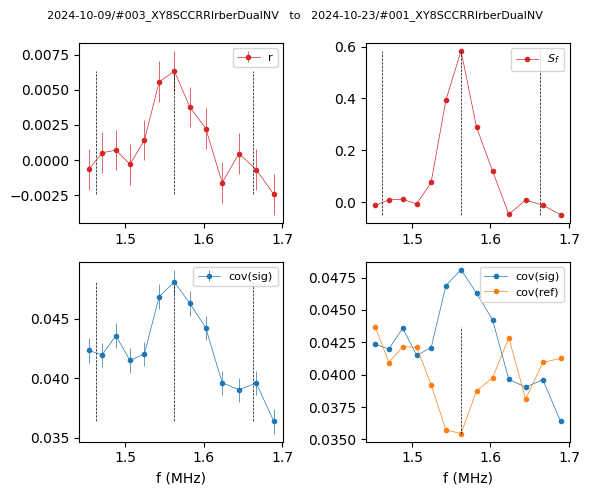

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(6,5))

# sf = np.arcsinh(10*r/(c1_OldRR_XY85*c2_OldRR_XY852))/t
# ycov_OldRR_XY85 = -sf

# axs[0,0].plot(x, r, 'o-', linewidth=0.5, markersize=3, label="r",color="C3")
axs[0,0].errorbar(x, r, sigma_r, marker='o',linewidth=0.5, markersize=3, label="r",color="C3")
# axs[0,0].errorbar(x, r0,err0, marker='o',linewidth=0.5, markersize=3, label="$r_{bkg}$",color="C2")
axs[0,0].legend(fontsize=8)
axs[0,0].vlines(x=markerAt,ymin=min(r),ymax=max(r), linestyle='--', linewidth=0.5, color='k')
axs[0,0].vlines(x=markerAt+0.1,ymin=min(r),ymax=max(r), linestyle='--', linewidth=0.5, color='k')
axs[0,0].vlines(x=markerAt-0.1,ymin=min(r),ymax=max(r), linestyle='--', linewidth=0.5, color='k')

# r = r[2:]; t = t[2:]; c1t = c1t[0:-2]; c2t = c2t[0:-2]
# sf = np.arcsinh(24*r/(c1t*c2t))/(NXY8*t)
# axs[0,1].plot(x[2:], sf, 'o-', linewidth=0.5, markersize=3, label="$S_f$",color="C3")
# # axs[0,1].plot(x[2:], sfnonoise, 'o-', linewidth=0.5, markersize=3, label="$S_f,bkg$",color="C2")

sf = np.arcsinh(24*r/(c1t*c2t))/(NXY8*t)
axs[0,1].plot(x, sf, 'o-', linewidth=0.5, markersize=3, label="$S_f$",color="C3")
# axs[0,1].plot(x, sfnonoise, 'o-', linewidth=0.5, markersize=3, label="$S_f,bkg$",color="C2")
axs[0,1].vlines(x=markerAt,ymin=min(sf),ymax=max(sf), linestyle='--', linewidth=0.5, color='k')
axs[0,1].vlines(x=markerAt+0.1,ymin=min(sf),ymax=max(sf), linestyle='--', linewidth=0.5, color='k')
axs[0,1].vlines(x=markerAt-0.1,ymin=min(sf),ymax=max(sf), linestyle='--', linewidth=0.5, color='k')
axs[0,1].legend(fontsize=8)
# axs[0].set_ylabel('$S_f$')

# axs[1,0].plot(x, covSig, 'o-', linewidth=0.5, markersize=3, label="cov(sig)")
axs[1,0].errorbar(x, covSig, sigma_covSig, marker='o',linewidth=0.5, markersize=3, label="cov(sig)")
s = "Cov(sig)"
axs[1,0].legend(fontsize=8)
axs[1,0].set_xlabel('$\\tau$ ($\mu$s)')
axs[1,0].vlines(x=markerAt,ymin=min(covSig),ymax=max(covSig), linestyle='--', linewidth=0.5, color='k')
axs[1,0].vlines(x=markerAt+0.1,ymin=min(covSig),ymax=max(covSig), linestyle='--', linewidth=0.5, color='k')
axs[1,0].vlines(x=markerAt-0.1,ymin=min(covSig),ymax=max(covSig), linestyle='--', linewidth=0.5, color='k')

axs[1,1].plot(x, covSig, 'o-', linewidth=0.5, markersize=3, label="cov(sig)")
axs[1,1].plot(x, covRef, 'o-', linewidth=0.5, markersize=3, label="cov(ref)", color='C1')
s = "Cov(ref)"
axs[1,1].legend(fontsize=8)
axs[1,1].vlines(x=markerAt,ymin=min(covRef),ymax=max(covRef), linestyle='--', linewidth=0.5, color='k')

if ifXAxisFreq: 
    axs[1,0].set_xlabel("f (MHz)")
    axs[1,1].set_xlabel("f (MHz)")
    # for i in range(3):
    #     axs[i].set_xscale('log')

s = firstdatafile[31:66] + '   to   ' + datafile[31:66]
fig.suptitle(s, fontsize=8)
plt.tight_layout()
plt.show()

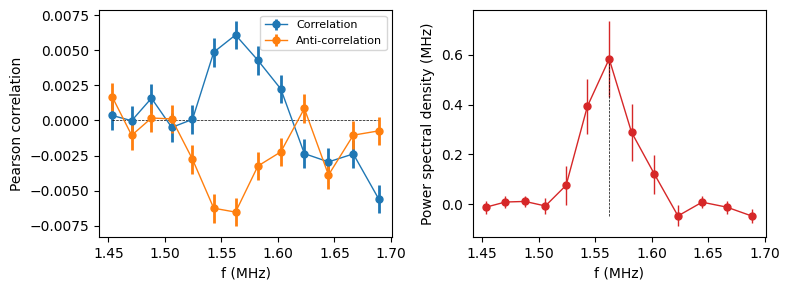

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(8,3))
axs[0].errorbar(x, covSig-0.042, sigma_covSig, marker='o',linewidth=1, markersize=5, elinewidth=2, label="Correlation")
axs[0].hlines(y=0,xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')
axs[0].errorbar(x, covRef-0.042, sigma_covRef, marker='o',linewidth=1, markersize=5, elinewidth=2, label="Anti-correlation")
axs[0].set_xlabel("f (MHz)")
axs[0].set_ylabel("Pearson correlation")
axs[0].legend(fontsize=8)

err_sf = 24/(c1t*c2t)*(sigma_r)/np.sqrt(r**2+1)/(NXY8*t)
axs[1].errorbar(x, sf, err_sf,marker='o', linewidth=1, markersize=5, label="$S_f$",color="C3")
axs[1].vlines(x=markerAt,ymin=min(sf),ymax=max(sf), linestyle='--', linewidth=0.5, color='k')
axs[1].set_xlabel("f (MHz)")
axs[1].set_ylabel("Power spectral density (MHz)")

plt.tight_layout()

### Sweep shift_btwn_2NV_MW

In [154]:
# Repeat measuring T2E/XY8
days = np.linspace(1,31,31); mos = np.linspace(9,11,3); count=0
sigs = None; refs = None; sigs2 = None; refs2 = None; type='XY8'
if type == 'T2E':
    name1 = 'T2ESCCRRIrberDualNV'; name2 = '/T2ESCCRRIrberDualNVObject_sig_set.dat'
elif type == 'XY8':
    name1 = '_XY8SCCRRIrberDualNV'; name2 = '/XY8SCCRRIrberDualNVObject_sig_set.dat'
else:
    name1 = 'PLSCCRRDualNV'; name2 = '/PLSCCRRDualNVObject_sig_set.dat'
for mo in mos:
    for day in days:
        mainFolder = 'C:/Users/lukin2dmaterials/data/2024-'  + str(int(mo)).zfill(2) +'-' + str(int(day)).zfill(2) + '/'
        try:
            for dataFolder in os.listdir(mainFolder):
                if name1 in dataFolder:
                    idx = int(dataFolder[1:4])
                    # if (mo==10 and day==7 and idx >= 54) or (mo==10 and day==8 and idx<=24):  
                    # if (mo==10 and day==8 and ((idx >= 40 and idx <=45))):  
                    # if (mo==10 and day==8 and (idx >= 40 and idx <= 61)):   
                    # if (mo==10 and day==9 and idx >=74 and idx <= 75) or (mo==10 and day==10 and idx<=34): #batch4,5
                    # if (mo==10 and day==10 and idx >= 30 and idx <= 33): # batch 5
                    #### if (mo==10 and day==11 and idx>=26 and idx <= 36): # batch 6
                    #### if (mo==10 and day==11 and idx>=43 and idx<=56):
                    #### if (mo==10 and day==12 and idx>=5 and idx<=20):
                    #### if (mo==10 and day==13 and idx>=23 and idx<=35): #batch 9
                    # if (mo==10 and day==14 and idx>=34 and idx<=39): #batch 10
                    # if (mo==10 and day==14 and idx>=42 and idx<=44): #batch 11
                    # if (mo==10 and day==14 and idx>=64 and idx<=64) or (mo==10 and day==15 and idx<=3): #batch 12
                    ### if (mo==10 and day==14 and idx>=42 and idx<=44) or (mo==10 and day==14 and idx>=64 and idx<=64) or (mo==10 and day==15 and idx<=3): #batch 11+12
                    # if (mo==10 and day==15 and idx>=64) or (mo==100 and day==16 and idx<=3):
                    # if (mo==10 and day==16 and idx>=7 and idx<=31): #batch 14 low power
                    # if (mo==10 and day==16 and idx>=34) or (mo==10 and day==17 and idx<=11): #batch 15
                    # if (mo==10 and day==18 and idx>=87) or (mo==10 and day==19 and idx<=11): #batch 16
                    # if (mo==10 and day==21 and idx>=6 and idx<=14): #batch 17 Princeton
                    # if (mo==10 and day==18 and idx>=87) or (mo==10 and day==19 and idx<=11) or (mo==10 and day==21 and idx>=6 and idx<=14): #batch 16+17
                    # if (mo==10 and day==23 and idx>=68) or (mo==10 and day==24 and idx<=8): # batch 18
                    # if (mo==10 and day==14 and idx>=34 and idx<=39) or (mo==10 and day==14 and idx>=42 and idx<=44) or (mo==10 and day==14 and idx>=64 and idx<=64) or (mo==10 and day==15 and idx<=3) or (mo==10 and day==23 and idx>=68) or (mo==10 and day==24 and idx<=8): #batch10,11,12,18
                    # if (mo==10 and day==14 and idx>=34 and idx<=39) or (mo==10 and day==14 and idx>=42 and idx<=44) or (mo==10 and day==14 and idx>=64 and idx<=64) or (mo==10 and day==15 and idx<=3) or (mo==10 and day==23 and idx>=68) or (mo==10 and day==24 and idx<=8) or (mo==10 and day==18 and idx>=87) or (mo==10 and day==19 and idx<=11) or (mo==10 and day==21 and idx>=6 and idx<=14): #batch10,11,12,18,16,17
                    # if (mo==10 and day==28 and idx>=39 and idx<550) or (mo==10 and day==29 and idx>=0 and idx<=43): # batch 19
                    # if (mo==10 and day==29 and idx>=49) or (mo==10 and day==30 and idx>=0 and idx<=41): # batch 20 justref_corracorr=0
                    # if (mo==10 and day==30 and idx>=74 and idx<=83) or (mo==10 and day==31 and idx>=-45 and idx<=49) or (mo==11 and day==1 and idx>=1 and idx<=2): # BATCH 21 peak trough only no test sig also DS 72 73 wrong IQ ports   
                    # if (mo==11 and day==1 and idx>=31 and idx<=36): #batch 22 with test sig
                    # if (mo==11 and day==4 and idx>=10 and idx<=13): #batch 23 peak trough new test frequency
                    if (mo==11 and day==4 and idx>=37 and idx<=64) or (mo==11 and day==5 and idx>=1 and idx<61):
                    # if (mo==11 and day==5 and idx>=18 and idx<=61):
                        finalDataFolder = mainFolder + dataFolder
                        datafile = finalDataFolder + name2
                        ti = 2700; tr_ns = 3e6

                        if type == 'XY8':
                            taus, sig, sig2, ref, ref2 = dr.readDataFullDataDualNV(datafile)
                        else:
                            taus, ref, ref2, sig, sig2 = dr.readDataFullDataDualNV(datafile)

                        # Sort data taken in random order
                        taus = np.average(taus,axis=1)
                        sorted_indices = np.argsort(taus)
                        taus = taus[sorted_indices]
                        sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                        ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]

                        if sigs is None: sigs = sig
                        else: sigs = np.concatenate((sigs, sig),axis=1)
                        if refs is None: refs = ref
                        else: refs = np.concatenate((refs, ref),axis=1)
                        if sigs2 is None: sigs2 = sig2
                        else: sigs2 = np.concatenate((sigs2, sig2),axis=1)
                        if refs2 is None: refs2 = ref2
                        else: refs2 = np.concatenate((refs2, ref2),axis=1)

                        if count==0: firstdatafile = datafile
                        count+=1
        except: pass

print(np.shape(sigs))         

if True:
    thres = 12

    sigavg = np.average(sigs,axis=1); refavg = np.average(refs,axis=1)
    sigavg2 = np.average(sigs2,axis=1); refavg2 = np.average(refs2,axis=1)

    max_count = 1.327; min_count = 0.637
    max_contrast = (max_count - min_count)/(max_count + min_count)

    max_count2 = 3.82; min_count2 = 2.667
    max_contrast2 = (max_count2 - min_count2)/(max_count2 + min_count2)

    sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)
    sigma_sig2 = np.std(sigs2, axis=1); sigma_ref2 = np.std(refs2, axis=1)

    snr_styleA = (sigavg-refavg)/np.sqrt(sigma_sig**2 + sigma_ref**2); sigmaR_styleA = np.sqrt(1+2/snr_styleA**2)
    snr_styleB = (sigavg-refavg)/np.sqrt(sigavg+refavg); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

    snr_styleA2 = (sigavg2-refavg2)/np.sqrt(sigma_sig2**2 + sigma_ref2**2); sigmaR_styleA2 = np.sqrt(1+2/snr_styleA2**2)
    snr_styleB2 = (sigavg2-refavg2)/np.sqrt(sigavg2+refavg2); sigmaR_styleB2 = np.sqrt(1+2/snr_styleB2**2)

    # contrast = (sigs-refs)/(sigs+refs); contrast = np.nan_to_num(contrast, nan=0)#/2+0.5
    # contrast2 = (sigs2-refs2)/(sigs2+refs2); contrast2 = np.nan_to_num(contrast2, nan=0)#/2+0.5

    contrast =  contrast_new(sigs, refs, sigavg, refavg, ifNorm=2,max_contrast=max_contrast)
    contrast2 = contrast_new(sigs2,refs2,sigavg2,refavg2,ifNorm=2,max_contrast=max_contrast2)
    # contrast_avg = np.average(contrast, axis=1); contrast_avg2 = np.average(contrast2, axis=1)

    covSig, sigma_covSig,_,_ = cov(sigs,sigs2); covRef, sigma_covRef,_,_ = cov(refs, refs2)
    covContrast,sigma_r1,_,_ = cov(contrast, contrast2)  

    # r = (covSig - covRef)
    r1 = covContrast

    combined_sigs = np.concatenate((sigs,refs),axis=1); combined_sigs2 = np.concatenate((sigs2,refs2),axis=1)
    r,sigma_r,_,_ = cov(combined_sigs,combined_sigs2); r2 = covSig#(covSig + covRef)/2
    print(np.shape(combined_sigs))

(17, 190000)
(17, 380000)


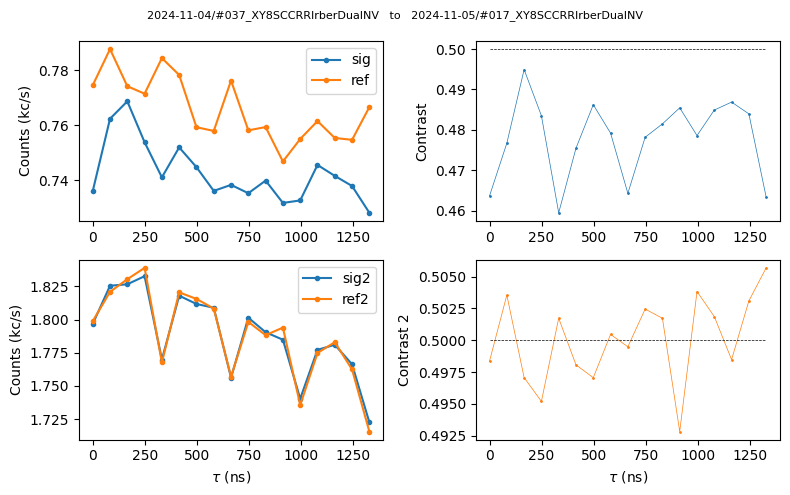

In [155]:
ifXAxisFreq = 0; correctionToTau = 0; NXY8=5; markerAt = 1.506024; ifNormedTo01=1;correctionToTau2=correctionToTau
xPlot = taus
for idxs in np.linspace(1,1,1):
    idx = int(idxs)
    t = (xPlot+correctionToTau); t2 = (xPlot+correctionToTau2)
    if ifXAxisFreq: 
        x = 1/(2*t); x2 = 1/(2*t2)
    else: 
        x = t; x2 = t2
    
    y = (sigavg-refavg)/(sigavg+refavg); ys = sigavg/(tr_ns/1e6); yr = refavg/(tr_ns/1e6)
    y2 = (sigavg2-refavg2)/(sigavg2+refavg2); ys2 = sigavg2/(tr_ns/1e6); yr2 = refavg2/(tr_ns/1e6)

    if ifNormedTo01:
        # # for cosine
        # y=-y;y2=-y2
        # y = linear_map(y,-(y.max()),y.max(),0,1)
        # y2 = linear_map(y2,-(y2.max()),y2.max(),0,1)

        # for sine
        y = linear_map(y,-max_contrast, max_contrast, 0, 1)
        y2 = linear_map(y2,-max_contrast2, max_contrast2, 0, 1)

    if True:
        fig, axs = plt.subplots(2,2,figsize=(8,5))
        axs[0,1].plot(x,y, 'o-', linewidth=0.5,markersize=1, label="contrast")
        axs[0,1].set_ylabel('Contrast')
        # axs[0,1].vlines(x=markerAt,ymin=min(y),ymax=max(y), linestyle='--', linewidth=0.5, color='k')
        axs[0,1].hlines(y=0.5, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')
        # axs[0,1].set_xlim((-0.1,4))

        axs[0,0].plot(x, ys, 'o-', markersize=3, label="sig")
        axs[0,0].plot(x, yr, 'o-', markersize=3, label="ref")
        axs[0,0].legend()
        axs[0,0].set_ylabel('Counts (kc/s)')
        # axs[0,0].set_ylim((0.2,1.8))

        ################################################################################
        axs[1,1].plot(x2,y2, 'o-', linewidth=0.5,markersize=1, color='C1',label="contrast 2")
        axs[1,1].set_ylabel('Contrast 2')
        axs[1,1].set_xlabel(r"$\tau$ (ns)")
        # axs[1,1].vlines(x=markerAt,ymin=min(y2),ymax=max(y2), linestyle='--', linewidth=0.5, color='k')
        axs[1,1].hlines(y=0.5, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')
        if ifXAxisFreq: axs[1,1].set_xlabel("f (MHz)")
        # axs[1,1].set_xlim((-0.1,2.6))

        axs[1,0].plot(x2, ys2, 'o-', markersize=3, label="sig2")
        axs[1,0].plot(x2, yr2, 'o-', markersize=3, label="ref2")
        axs[1,0].legend()
        axs[1,0].set_xlabel(r"$\tau$ (ns)")
        if ifXAxisFreq: axs[1,0].set_xlabel("f (MHz)")
        axs[1,0].set_ylabel('Counts (kc/s)')
        # axs[1,0].set_ylim((0.7,2.6))

        s = firstdatafile[31:66] + '   to   ' + datafile[31:66]
        fig.suptitle(s, fontsize=8)

        plt.tight_layout()
    

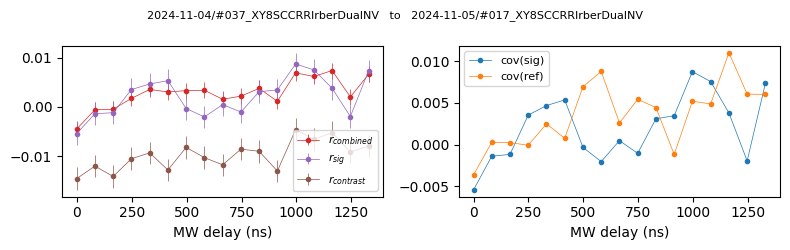

In [156]:
fig, axs = plt.subplots(1,2,figsize=(8,2.5))

# axs[0].plot(x, r, 'o-', linewidth=0.5, markersize=3, label="r",color="C3")
axs[0].errorbar(x, r, sigma_r, marker='o',linewidth=0.5, markersize=3, label="$r_{combined}$",color="C3")
axs[0].errorbar(x, r2, sigma_covSig, marker='o',linewidth=0.5, markersize=3, label="$r_{sig}$",color="C4")
axs[0].errorbar(x, r1, sigma_r1, marker='o',linewidth=0.5, markersize=3, label="$r_{contrast}$",color="C5")
axs[0].legend(fontsize=8)
# axs[0].hlines(y=0,xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')

axs[1].plot(x, covSig, 'o-', linewidth=0.5, markersize=3, label="cov(sig)")
axs[1].plot(x, covRef, 'o-', linewidth=0.5, markersize=3, label="cov(ref)", color='C1')
axs[1].legend(fontsize=8)
# axs[1].vlines(x=markerAt,ymin=min(covRef),ymax=max(covRef), linestyle='--', linewidth=0.5, color='k')

axs[0].set_xlabel("MW delay (ns)")
axs[1].set_xlabel("MW delay (ns)")
   
s = firstdatafile[31:66] + '   to   ' + datafile[31:66]
fig.suptitle(s, fontsize=8)
plt.tight_layout()
plt.show()

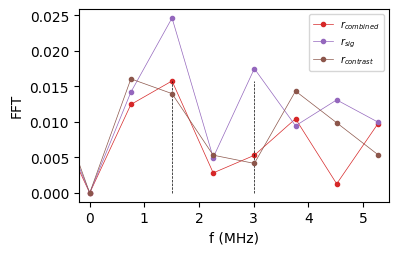

In [157]:
r_zero = np.concatenate((r, np.zeros(len(r)*0))); delta_t=(83e-9)
f,yfourier = fourier(r_zero[1:],delta_t=delta_t)
fig, ax = plt.subplots(figsize=(4,2.5))
ax.plot(f/1e6,yfourier,'o-', linewidth=0.5, markersize=3, label="$r_{combined}$",color='C3')
ax.vlines(x=markerAt,ymin=min(yfourier),ymax=max(yfourier), linestyle='--', linewidth=0.5, color='k')
ax.vlines(x=2*markerAt,ymin=min(yfourier),ymax=max(yfourier), linestyle='--', linewidth=0.5, color='k')
ax.set_xlim((-0.2,np.max(f/1e6)+0.2))
ax.set_xlabel('f (MHz)')
ax.set_ylabel('FFT');

r_zero = np.concatenate((r2, np.zeros(len(r)*0)))
f,yfourier = fourier(r_zero[1:],delta_t=delta_t)
ax.plot(f/1e6,yfourier,'o-', linewidth=0.5, markersize=3, label="$r_{sig}$",color='C4')

r_zero = np.concatenate((r1, np.zeros(len(r)*0)))
f,yfourier = fourier(r_zero[1:],delta_t=delta_t)
ax.plot(f/1e6,yfourier,'o-', linewidth=0.5, markersize=3, label="$r_{contrast}$",color='C5')
ax.legend(fontsize=7)

### Plot r vs t_delay vs shift

In [313]:
# Repeat measuring T2E/XY8
days = np.linspace(1,30,30); mos = np.linspace(9,10,2); count=0
sigs = None; refs = None; sigs2 = None; refs2 = None; type='XY8'
if type == 'T2E':
    name1 = 'T2ESCCRRIrberDualNV'; name2 = '/T2ESCCRRIrberDualNVObject_sig_set.dat'
elif type == 'XY8':
    name1 = 'XY8SCCRRIrberDualNV'; name2 = '/XY8SCCRRIrberDualNVObject_sig_set.dat'
else:
    name1 = 'PLSCCRRDualNV'; name2 = '/PLSCCRRDualNVObject_sig_set.dat'
for mo in mos:
    for day in days:
        mainFolder = 'C:/Users/lukin2dmaterials/data/2024-'  + str(int(mo)).zfill(2) +'-' + str(int(day)).zfill(2) + '/'
        try:
            for dataFolder in os.listdir(mainFolder):
                if name1 in dataFolder:
                    idx = int(dataFolder[1:4])
                    # if (mo==10 and day==7 and idx >= 54) or (mo==10 and day==8 and idx<=24):  
                    # if (mo==10 and day==8 and ((idx >= 40 and idx <=45))):  
                    # if (mo==10 and day==8 and (idx >= 40 and idx <= 61)):   
                    # if (mo==10 and day==9 and idx >=74 and idx <= 75) or (mo==10 and day==10 and idx<=34): 
                    # if (mo==10 and day==10 and idx >= 30 and idx <= 33): # batch 5
                    #### if (mo==10 and day==11 and idx>=26 and idx <= 36): # batch 6
                    #### if (mo==10 and day==11 and idx>=43 and idx<=56):
                    #### if (mo==10 and day==12 and idx>=5 and idx<=20):
                    #### if (mo==10 and day==13 and idx>=23 and idx<=35): #batch 9
                    ### if (mo==10 and day==14 and idx>=34 and idx<=39): #batch 10
                    # if (mo==10 and day==14 and idx>=42 and idx<=44): #batch 11
                    # if (mo==10 and day==14 and idx>=64 and idx<=64) or (mo==10 and day==15 and idx<=3): #batch 12
                    ### if (mo==10 and day==14 and idx>=42 and idx<=44) or (mo==10 and day==14 and idx>=64 and idx<=64) or (mo==10 and day==15 and idx<=3): #batch 11 and 12
                    # if (mo==10 and day==15 and idx>=64) or (mo==100 and day==16 and idx<=3):
                    # if (mo==10 and day==16 and idx>=7 and idx<=31): #batch 14 low power
                    # if (mo==10 and day==16 and idx>=34) or (mo==10 and day==17 and idx<=11): #batch 15
                    if (mo==10 and day==18 and idx>=87) or (mo==10 and day==19 and idx<=11): #batch 16
                    # if (mo==10 and day==21 and idx>=6 and idx<=14): #batch 17 Princeton
                    # if (mo==10 and day==23 and idx>=68) or (mo==10 and day==24 and idx<=8): # batch 18
                        finalDataFolder = mainFolder + dataFolder
                        datafile = finalDataFolder + name2
                        ti = 2700; tr_ns = 2.5e6

                        if type == 'XY8':
                            taus, sig, sig2, ref, ref2 = dr.readDataFullDataDualNV(datafile)
                        else:
                            taus, ref, ref2, sig, sig2 = dr.readDataFullDataDualNV(datafile)

                        # Sort data taken in random order
                        taus = np.average(taus,axis=1)
                        sorted_indices = np.argsort(taus)
                        taus = taus[sorted_indices]
                        sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                        ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]

                        if sigs is None: sigs = sig
                        else: sigs = np.concatenate((sigs, sig),axis=1)
                        if refs is None: refs = ref
                        else: refs = np.concatenate((refs, ref),axis=1)
                        if sigs2 is None: sigs2 = sig2
                        else: sigs2 = np.concatenate((sigs2, sig2),axis=1)
                        if refs2 is None: refs2 = ref2
                        else: refs2 = np.concatenate((refs2, ref2),axis=1)

                        if count==0: firstdatafile = datafile
                        count+=1
        except: pass

print(np.shape(sigs))         
sigs2_org = sigs2; refs2_org = refs2;N=100
shifts = np.linspace(0,N,N+1); rs = []
for shift in shifts:
    thres = 12

    sigavg = np.average(sigs,axis=1); refavg = np.average(refs,axis=1)
    sigavg2 = np.average(sigs2,axis=1); refavg2 = np.average(refs2,axis=1)

    max_count = 1.327; min_count = 0.637
    max_contrast = (max_count - min_count)/(max_count + min_count)

    max_count2 = 3.82; min_count2 = 2.667
    max_contrast2 = (max_count2 - min_count2)/(max_count2 + min_count2)

    sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)
    sigma_sig2 = np.std(sigs2, axis=1); sigma_ref2 = np.std(refs2, axis=1)

    snr_styleA = (sigavg-refavg)/np.sqrt(sigma_sig**2 + sigma_ref**2); sigmaR_styleA = np.sqrt(1+2/snr_styleA**2)
    snr_styleB = (sigavg-refavg)/np.sqrt(sigavg+refavg); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

    snr_styleA2 = (sigavg2-refavg2)/np.sqrt(sigma_sig2**2 + sigma_ref2**2); sigmaR_styleA2 = np.sqrt(1+2/snr_styleA2**2)
    snr_styleB2 = (sigavg2-refavg2)/np.sqrt(sigavg2+refavg2); sigmaR_styleB2 = np.sqrt(1+2/snr_styleB2**2)

    # contrast = (sigs-refs)/(sigs+refs); contrast = np.nan_to_num(contrast, nan=0)#/2+0.5
    # contrast2 = (sigs2-refs2)/(sigs2+refs2); contrast2 = np.nan_to_num(contrast2, nan=0)#/2+0.5

    contrast =  contrast_new(sigs, refs, sigavg, refavg, ifNorm=2,max_contrast=max_contrast)
    contrast2 = contrast_new(sigs2,refs2,sigavg2,refavg2,ifNorm=2,max_contrast=max_contrast2)
    # contrast_avg = np.average(contrast, axis=1); contrast_avg2 = np.average(contrast2, axis=1)
    shift = int(shift)
    sigs2 = np.roll(sigs2_org, shift=shift, axis=1);refs2 = np.roll(refs2_org, shift=shift, axis=1)

    covSig, sigma_covSig,aavg,sigma_a = cov(sigs,sigs2); covRef, sigma_covRef,_,_ = cov(refs, refs2)
    covContrast = cov(contrast, contrast2)  

    r = (covSig - covRef)
    r_zero = np.concatenate((r,np.zeros(len(r)*0))); delta_t=80e-9
    f,yfourier = fourier(r_zero,delta_t=delta_t)
    rs.append(r)

(21, 250000)


(101, 21)


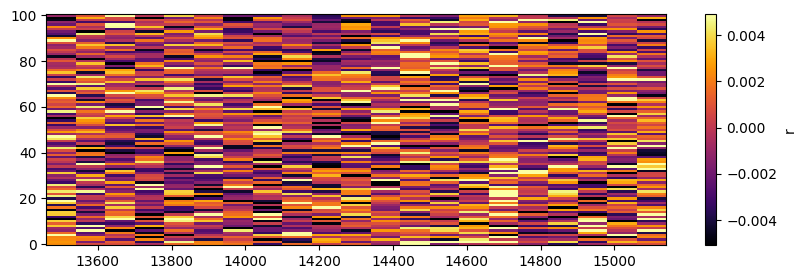

In [314]:
rs = np.array(rs); print(np.shape(rs))
fig,ax = plt.subplots(figsize=(10,3))
X,Y = np.meshgrid(taus,shifts)
plot = ax.pcolormesh(X,Y,rs,cmap='inferno')

cb = fig.colorbar(plot, orientation='vertical', ax=ax)
cb.set_label("r",fontsize=10)
avg = np.average(rs); delta = 0.005
plot.set_clim(avg-delta,avg+delta)

# Auto-correlation XY8 SCC RR Dual NV

### Standard plot

In [ ]:
# Repeat measuring T2E/XY8
days = np.linspace(1,30,30); mos = np.linspace(9,10,2); count=0
sigs = None; refs = None; sigs2 = None; refs2 = None; type='XY8'
name1 = 'AutoCorrXY8SCCRRIrberDualNV'; name2 = '/AutoCorrXY8SCCRRIrberDualNVObject_sig_set.dat'
for mo in mos:
    for day in days:
        mainFolder = 'C:/Users/lukin2dmaterials/data/2024-'  + str(int(mo)).zfill(2) +'-' + str(int(day)).zfill(2) + '/'
        try:
            for dataFolder in os.listdir(mainFolder):
                if name1 in dataFolder:
                    idx = int(dataFolder[1:4])
                    # if (mo==100 and day==25 and idx>=48) or (mo==100 and day==26) or (mo==10 and day==27 and idx>=31 and idx<=37) or (mo==100 and day==28):
                    if (mo==10 and day==29 and idx>=2 and idx<=22): #batch 2 after clock syncing
                        finalDataFolder = mainFolder + dataFolder
                        datafile = finalDataFolder + name2
                        ti = 2700; tr_ns = 2.5e6

                        if type == 'XY8':
                            taus, sig, sig2, ref, ref2 = dr.readDataFullDataDualNV(datafile)
                        else:
                            taus, ref, ref2, sig, sig2 = dr.readDataFullDataDualNV(datafile)

                        # Sort data taken in random order
                        taus = np.average(taus,axis=1)
                        sorted_indices = np.argsort(taus)
                        taus = taus[sorted_indices]
                        sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                        ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]

                        if sigs is None: sigs = sig
                        else: sigs = np.concatenate((sigs, sig),axis=1)
                        if refs is None: refs = ref
                        else: refs = np.concatenate((refs, ref),axis=1)
                        if sigs2 is None: sigs2 = sig2
                        else: sigs2 = np.concatenate((sigs2, sig2),axis=1)
                        if refs2 is None: refs2 = ref2
                        else: refs2 = np.concatenate((refs2, ref2),axis=1)

                        if count==0: firstdatafile = datafile
                        count+=1
        except: pass

print(np.shape(sigs))         

if True:
    thres = 12

    sigavg = np.average(sigs,axis=1); refavg = np.average(refs,axis=1)
    sigavg2 = np.average(sigs2,axis=1); refavg2 = np.average(refs2,axis=1)

    max_count = 1.327; min_count = 0.637
    max_contrast = (max_count - min_count)/(max_count + min_count)

    max_count2 = 3.82; min_count2 = 2.667
    max_contrast2 = (max_count2 - min_count2)/(max_count2 + min_count2)

    sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)
    sigma_sig2 = np.std(sigs2, axis=1); sigma_ref2 = np.std(refs2, axis=1)

    snr_styleA = (sigavg-refavg)/np.sqrt(sigma_sig**2 + sigma_ref**2); sigmaR_styleA = np.sqrt(1+2/snr_styleA**2)
    snr_styleB = (sigavg-refavg)/np.sqrt(sigavg+refavg); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

    snr_styleA2 = (sigavg2-refavg2)/np.sqrt(sigma_sig2**2 + sigma_ref2**2); sigmaR_styleA2 = np.sqrt(1+2/snr_styleA2**2)
    snr_styleB2 = (sigavg2-refavg2)/np.sqrt(sigavg2+refavg2); sigmaR_styleB2 = np.sqrt(1+2/snr_styleB2**2)

    # contrast = (sigs-refs)/(sigs+refs); contrast = np.nan_to_num(contrast, nan=0)#/2+0.5
    # contrast2 = (sigs2-refs2)/(sigs2+refs2); contrast2 = np.nan_to_num(contrast2, nan=0)#/2+0.5

    contrast =  contrast_new(sigs, refs, sigavg, refavg, ifNorm=2,max_contrast=max_contrast)
    contrast2 = contrast_new(sigs2,refs2,sigavg2,refavg2,ifNorm=2,max_contrast=max_contrast2)
    # contrast_avg = np.average(contrast, axis=1); contrast_avg2 = np.average(contrast2, axis=1)
    shift = 0
    sigs2 = np.roll(sigs2, shift=shift, axis=1);refs2 = np.roll(refs2, shift=shift, axis=1)

    covSig, sigma_covSig,aavg,sigma_a = cov(sigs,sigs2); covRef, sigma_covRef,_,_ = cov(refs, refs2)
    covContrast = cov(contrast, contrast2)  

    r = (covSig - covRef)
    # r = covContrast

(25, 130000)


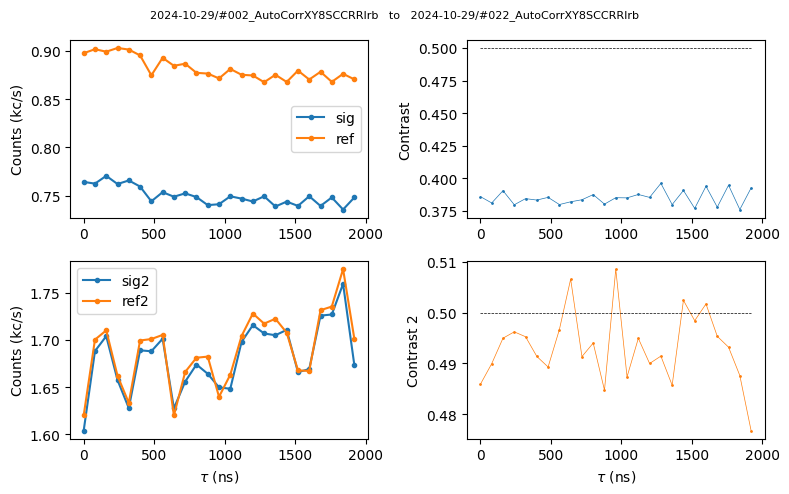

In [ ]:
ifXAxisFreq = 0; NXY8=5; markerAt = 1.5625; ifNormedTo01=1
t = t2 = xPlot = taus
if ifXAxisFreq: 
    x = 1/(2*t); x2 = 1/(2*t2)
else: 
    x = t; x2 = t2

y = (sigavg-refavg)/(sigavg+refavg); ys = sigavg/(tr_ns/1e6); yr = refavg/(tr_ns/1e6)
y2 = (sigavg2-refavg2)/(sigavg2+refavg2); ys2 = sigavg2/(tr_ns/1e6); yr2 = refavg2/(tr_ns/1e6)
y2autocorr = (sigavg2+refavg2)/2
if ifNormedTo01:
    # # for cosine
    # y=-y;y2=-y2
    # y = linear_map(y,-(y.max()),y.max(),0,1)
    # y2 = linear_map(y2,-(y2.max()),y2.max(),0,1)

    # for sine
    y = linear_map(y,-max_contrast, max_contrast, 0, 1)
    y2 = linear_map(y2,-max_contrast2, max_contrast2, 0, 1)

if True:
    fig, axs = plt.subplots(2,2,figsize=(8,5))
    axs[0,1].plot(x,y, 'o-', linewidth=0.5,markersize=1, label="contrast")
    axs[0,1].set_ylabel('Contrast')
    # axs[0,1].vlines(x=markerAt,ymin=min(y),ymax=max(y), linestyle='--', linewidth=0.5, color='k')
    axs[0,1].hlines(y=0.5, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')
    # axs[0,1].set_xlim((-0.1,4))

    axs[0,0].plot(x, ys, 'o-', markersize=3, label="sig")
    axs[0,0].plot(x, yr, 'o-', markersize=3, label="ref")
    axs[0,0].legend()
    axs[0,0].set_ylabel('Counts (kc/s)')
    # axs[0,0].set_ylim((0.2,1.8))

    ################################################################################
    axs[1,1].plot(x2,y2, 'o-', linewidth=0.5,markersize=1, color='C1',label="contrast 2")
    axs[1,1].set_ylabel('Contrast 2')
    axs[1,1].set_xlabel(r"$\tau$ (ns)")
    # axs[1,1].vlines(x=markerAt,ymin=min(y2),ymax=max(y2), linestyle='--', linewidth=0.5, color='k')
    axs[1,1].hlines(y=0.5, xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')
    if ifXAxisFreq: axs[1,1].set_xlabel("f (MHz)")
    # axs[1,1].set_xlim((-0.1,2.6))

    axs[1,0].plot(x2, ys2, 'o-', markersize=3, label="sig2")
    axs[1,0].plot(x2, yr2, 'o-', markersize=3, label="ref2")
    axs[1,0].legend()
    axs[1,0].set_xlabel(r"$\tau$ (ns)")
    if ifXAxisFreq: axs[1,0].set_xlabel("f (MHz)")
    axs[1,0].set_ylabel('Counts (kc/s)')
    # axs[1,0].set_ylim((0.7,2.6))

    s = firstdatafile[31:66] + '   to   ' + datafile[31:66]
    fig.suptitle(s, fontsize=8)

    plt.tight_layout()


In [ ]:
# Nzero = 0; y_zero = np.concatenate((y,np.zeros(len(y)*Nzero))); delta_t=80e-9
# f,yfourier = fourier(y_zero,delta_t=delta_t)
# y_zero2 = np.concatenate((y2autocorr,np.zeros(len(y2)*Nzero)))
# f,yfourier2 = fourier(y_zero2,delta_t=delta_t)

# fig, axs = plt.subplots(1,2,figsize=(8,2.5))
# axs[0].plot(f/1e6,yfourier,'o-', linewidth=0.5, markersize=3,label='NV1' )
# axs[0].vlines(x=markerAt,ymin=min(yfourier),ymax=max(yfourier), linestyle='--', linewidth=0.5, color='k')
# axs[0].vlines(x=2*markerAt,ymin=min(yfourier),ymax=max(yfourier), linestyle='--', linewidth=0.5, color='k')
# axs[0].set_xlim((-0.2,np.max(f/1e6)+0.2))
# axs[0].set_xlabel('f (MHz)')
# axs[0].set_ylabel('FFT')
# axs[0].legend()

# axs[1].plot(f/1e6,yfourier2,'o-', linewidth=0.5, markersize=3,label='NV2',color='C1')
# axs[1].vlines(x=markerAt,ymin=min(yfourier2),ymax=max(yfourier2), linestyle='--', linewidth=0.5, color='k')
# axs[1].vlines(x=2*markerAt,ymin=min(yfourier2),ymax=max(yfourier2), linestyle='--', linewidth=0.5, color='k')
# axs[1].set_xlim((-0.2,np.max(f/1e6)+0.2))
# axs[1].set_xlabel('f (MHz)')
# axs[1].set_ylabel('FFT')
# axs[1].legend()

# s = firstdatafile[31:67] + '   to   ' + datafile[31:67]
# fig.suptitle(s,fontsize=8)

# plt.tight_layout()

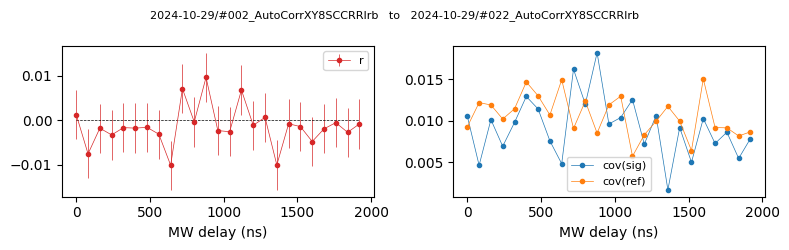

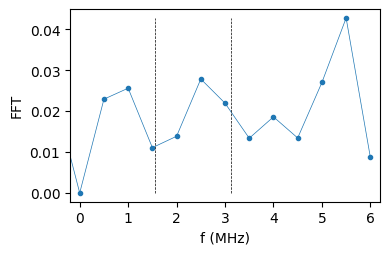

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(8,2.5))

axs[0].errorbar(x, r, sigma_covSig+sigma_covRef, marker='o',linewidth=0.5, markersize=3, label="r",color="C3")
axs[0].legend(fontsize=8)
axs[0].hlines(y=0,xmin=min(x),xmax=max(x), linestyle='--', linewidth=0.5, color='k')

axs[1].plot(x, covSig, 'o-', linewidth=0.5, markersize=3, label="cov(sig)")
axs[1].plot(x, covRef, 'o-', linewidth=0.5, markersize=3, label="cov(ref)", color='C1')
axs[1].legend(fontsize=8)
# axs[1].vlines(x=markerAt,ymin=min(covRef),ymax=max(covRef), linestyle='--', linewidth=0.5, color='k')

axs[0].set_xlabel("MW delay (ns)")
axs[1].set_xlabel("MW delay (ns)")
   
s = firstdatafile[31:66] + '   to   ' + datafile[31:66]
fig.suptitle(s, fontsize=8)
plt.tight_layout()
plt.show()

if True:
    r_zero = np.concatenate((r,np.zeros(len(r)*0))); delta_t=80e-9
    f,yfourier = fourier(r_zero,delta_t=delta_t)
    fig, ax = plt.subplots(figsize=(4,2.5))
    ax.plot(f/1e6,yfourier,'o-', linewidth=0.5, markersize=3, )
    ax.vlines(x=markerAt,ymin=min(yfourier),ymax=max(yfourier), linestyle='--', linewidth=0.5, color='k')
    ax.vlines(x=2*markerAt,ymin=min(yfourier),ymax=max(yfourier), linestyle='--', linewidth=0.5, color='k')
    ax.set_xlim((-0.2,np.max(f/1e6)+0.2))
    ax.set_xlabel('f (MHz)')
    ax.set_ylabel('FFT')

0.020336763581491182


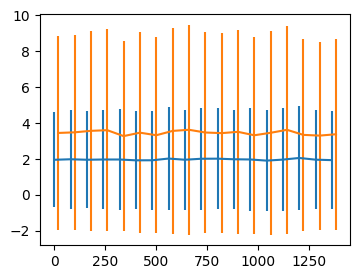

In [ ]:
fig,ax=plt.subplots(figsize=(4,3))
ax.errorbar(x,sigavg,sigma_sig)
ax.errorbar(x+20,sigavg2,sigma_sig2)
# sigavg2=sigavg2[::-1]
dummy = (np.average(sigavg*sigavg2) - np.average(sigavg)*np.average(sigavg2))/(np.std(sigavg)*np.std(sigavg2))
print(dummy)

### Plot FFT(r) at test frequency vs shift

In [ ]:
days = np.linspace(1,30,30); mos = np.linspace(9,10,2); count=0
sigs = None; refs = None; sigs2 = None; refs2 = None; type='XY8'
name1 = 'AutoCorrXY8SCCRRIrberDualNV'; name2 = '/AutoCorrXY8SCCRRIrberDualNVObject_sig_set.dat'
for mo in mos:
    for day in days:
        mainFolder = 'C:/Users/lukin2dmaterials/data/2024-'  + str(int(mo)).zfill(2) +'-' + str(int(day)).zfill(2) + '/'
        try:
            for dataFolder in os.listdir(mainFolder):
                if name1 in dataFolder:
                    idx = int(dataFolder[1:4])
                    if (mo==100 and day==25 and idx>=48) or (mo==100 and day==26) or (mo==10 and day==27 and idx>=20 and idx<=38):
                        finalDataFolder = mainFolder + dataFolder
                        datafile = finalDataFolder + name2
                        ti = 2700; tr_ns = 2.5e6

                        if type == 'XY8':
                            taus, sig, sig2, ref, ref2 = dr.readDataFullDataDualNV(datafile)
                        else:
                            taus, ref, ref2, sig, sig2 = dr.readDataFullDataDualNV(datafile)

                        # Sort data taken in random order
                        taus = np.average(taus,axis=1)
                        sorted_indices = np.argsort(taus)
                        taus = taus[sorted_indices]
                        sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                        ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]

                        if sigs is None: sigs = sig
                        else: sigs = np.concatenate((sigs, sig),axis=1)
                        if refs is None: refs = ref
                        else: refs = np.concatenate((refs, ref),axis=1)
                        if sigs2 is None: sigs2 = sig2
                        else: sigs2 = np.concatenate((sigs2, sig2),axis=1)
                        if refs2 is None: refs2 = ref2
                        else: refs2 = np.concatenate((refs2, ref2),axis=1)

                        if count==0: firstdatafile = datafile
                        count+=1
        except: pass

sigs2_org = sigs2; refs2_org = refs2
rs = []; shifts = np.linspace(0,50,51)
for shift in shifts:
    thres = 12

    sigavg = np.average(sigs,axis=1); refavg = np.average(refs,axis=1)
    sigavg2 = np.average(sigs2,axis=1); refavg2 = np.average(refs2,axis=1)

    max_count = 1.327; min_count = 0.637
    max_contrast = (max_count - min_count)/(max_count + min_count)

    max_count2 = 3.82; min_count2 = 2.667
    max_contrast2 = (max_count2 - min_count2)/(max_count2 + min_count2)

    sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)
    sigma_sig2 = np.std(sigs2, axis=1); sigma_ref2 = np.std(refs2, axis=1)

    snr_styleA = (sigavg-refavg)/np.sqrt(sigma_sig**2 + sigma_ref**2); sigmaR_styleA = np.sqrt(1+2/snr_styleA**2)
    snr_styleB = (sigavg-refavg)/np.sqrt(sigavg+refavg); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

    snr_styleA2 = (sigavg2-refavg2)/np.sqrt(sigma_sig2**2 + sigma_ref2**2); sigmaR_styleA2 = np.sqrt(1+2/snr_styleA2**2)
    snr_styleB2 = (sigavg2-refavg2)/np.sqrt(sigavg2+refavg2); sigmaR_styleB2 = np.sqrt(1+2/snr_styleB2**2)

    # contrast = (sigs-refs)/(sigs+refs); contrast = np.nan_to_num(contrast, nan=0)#/2+0.5
    # contrast2 = (sigs2-refs2)/(sigs2+refs2); contrast2 = np.nan_to_num(contrast2, nan=0)#/2+0.5

    contrast =  contrast_new(sigs, refs, sigavg, refavg, ifNorm=2,max_contrast=max_contrast)
    contrast2 = contrast_new(sigs2,refs2,sigavg2,refavg2,ifNorm=2,max_contrast=max_contrast2)
    # contrast_avg = np.average(contrast, axis=1); contrast_avg2 = np.average(contrast2, axis=1)
    shift = int(shift)
    sigs2 = np.roll(sigs2_org, shift=shift, axis=1);refs2 = np.roll(refs2_org, shift=shift, axis=1)

    covSig, sigma_covSig,aavg,sigma_a = cov(sigs,sigs2); covRef, sigma_covRef,_,_ = cov(refs, refs2)
    covContrast = cov(contrast, contrast2)  

    r = (covSig - covRef)
    r_zero = np.concatenate((r,np.zeros(len(r)*0))); delta_t=80e-9
    f,yfourier = fourier(r_zero,delta_t=delta_t)
    rs.append(yfourier[-10])

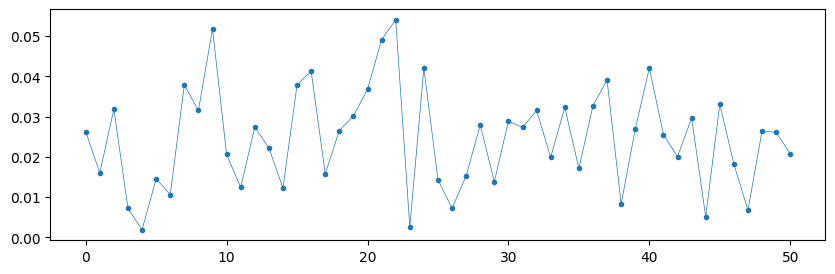

In [273]:
rs = np.array(rs)
fig,ax = plt.subplots(figsize=(10,3))
ax.plot(shifts,rs,'o-', linewidth=0.5, markersize=3, )

### Plot r vs tau vs shift

In [454]:
# Repeat measuring T2E/XY8
days = np.linspace(1,30,30); mos = np.linspace(9,10,2); count=0
sigs = None; refs = None; sigs2 = None; refs2 = None; type='XY8'
name1 = 'AutoCorrXY8SCCRRIrberDualNV'; name2 = '/AutoCorrXY8SCCRRIrberDualNVObject_sig_set.dat'
for mo in mos:
    for day in days:
        mainFolder = 'C:/Users/lukin2dmaterials/data/2024-'  + str(int(mo)).zfill(2) +'-' + str(int(day)).zfill(2) + '/'
        try:
            for dataFolder in os.listdir(mainFolder):
                if name1 in dataFolder:
                    idx = int(dataFolder[1:4])
                    if (mo==100 and day==25 and idx>=48) or (mo==100 and day==26) or (mo==100 and day==27 and idx>=20 and idx<=38) or (mo==10 and day==28 and idx==19):
                        finalDataFolder = mainFolder + dataFolder
                        datafile = finalDataFolder + name2
                        ti = 2700; tr_ns = 2.5e6

                        if type == 'XY8':
                            taus, sig, sig2, ref, ref2 = dr.readDataFullDataDualNV(datafile)
                        else:
                            taus, ref, ref2, sig, sig2 = dr.readDataFullDataDualNV(datafile)

                        # Sort data taken in random order
                        taus = np.average(taus,axis=1)
                        sorted_indices = np.argsort(taus)
                        taus = taus[sorted_indices]
                        sig = sig[sorted_indices]; sig2 = sig2[sorted_indices]
                        ref = ref[sorted_indices]; ref2 = ref2[sorted_indices]

                        if sigs is None: sigs = sig
                        else: sigs = np.concatenate((sigs, sig),axis=1)
                        if refs is None: refs = ref
                        else: refs = np.concatenate((refs, ref),axis=1)
                        if sigs2 is None: sigs2 = sig2
                        else: sigs2 = np.concatenate((sigs2, sig2),axis=1)
                        if refs2 is None: refs2 = ref2
                        else: refs2 = np.concatenate((refs2, ref2),axis=1)

                        if count==0: firstdatafile = datafile
                        count+=1
        except: pass
print(np.shape(sigs))
sigs2_org = sigs2; refs2_org = refs2; N=50
shifts = np.linspace(0,N,N+1); rs = []
for shift in shifts:
    thres = 12

    sigavg = np.average(sigs,axis=1); refavg = np.average(refs,axis=1)
    sigavg2 = np.average(sigs2,axis=1); refavg2 = np.average(refs2,axis=1)

    max_count = 1.327; min_count = 0.637
    max_contrast = (max_count - min_count)/(max_count + min_count)

    max_count2 = 3.82; min_count2 = 2.667
    max_contrast2 = (max_count2 - min_count2)/(max_count2 + min_count2)

    sigma_sig = np.std(sigs, axis=1); sigma_ref = np.std(refs, axis=1)
    sigma_sig2 = np.std(sigs2, axis=1); sigma_ref2 = np.std(refs2, axis=1)

    snr_styleA = (sigavg-refavg)/np.sqrt(sigma_sig**2 + sigma_ref**2); sigmaR_styleA = np.sqrt(1+2/snr_styleA**2)
    snr_styleB = (sigavg-refavg)/np.sqrt(sigavg+refavg); sigmaR_styleB = np.sqrt(1+2/snr_styleB**2)

    snr_styleA2 = (sigavg2-refavg2)/np.sqrt(sigma_sig2**2 + sigma_ref2**2); sigmaR_styleA2 = np.sqrt(1+2/snr_styleA2**2)
    snr_styleB2 = (sigavg2-refavg2)/np.sqrt(sigavg2+refavg2); sigmaR_styleB2 = np.sqrt(1+2/snr_styleB2**2)

    # contrast = (sigs-refs)/(sigs+refs); contrast = np.nan_to_num(contrast, nan=0)#/2+0.5
    # contrast2 = (sigs2-refs2)/(sigs2+refs2); contrast2 = np.nan_to_num(contrast2, nan=0)#/2+0.5

    contrast =  contrast_new(sigs, refs, sigavg, refavg, ifNorm=2,max_contrast=max_contrast)
    contrast2 = contrast_new(sigs2,refs2,sigavg2,refavg2,ifNorm=2,max_contrast=max_contrast2)
    # contrast_avg = np.average(contrast, axis=1); contrast_avg2 = np.average(contrast2, axis=1)
    shift = int(shift)
    sigs2 = np.roll(sigs2_org, shift=shift, axis=1);refs2 = np.roll(refs2_org, shift=shift, axis=1)

    covSig, sigma_covSig,aavg,sigma_a = cov(sigs,sigs2); covRef, sigma_covRef,_,_ = cov(refs, refs2)
    covContrast = cov(contrast, contrast2)  

    r = (covSig - covRef)
    r_zero = np.concatenate((r,np.zeros(len(r)*0))); delta_t=80e-9
    f,yfourier = fourier(r_zero,delta_t=delta_t)
    rs.append(r)

(18, 10000)


(51, 18)


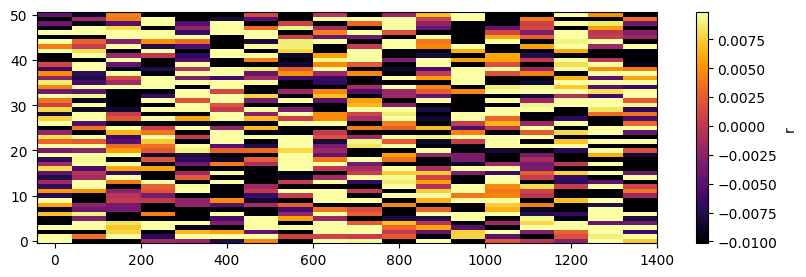

In [455]:
rs = np.array(rs); print(np.shape(rs))
fig,ax = plt.subplots(figsize=(10,3))
X,Y = np.meshgrid(taus,shifts)
plot = ax.pcolormesh(X,Y,rs,cmap='inferno')

cb = fig.colorbar(plot, orientation='vertical', ax=ax)
cb.set_label("r",fontsize=10)
avg = np.average(rs); delta = 0.01
plot.set_clim(avg-delta,avg+delta)

# Scratchwork

In [ ]:
f = np.linspace(1.3e6,1.82e6,201)
t = 1/(2*f)*1e9 - 40; t = (4*np.rint(t/4)); tausArray = np.unique(t)
# f = np.linspace(1.389e6,1.623e6,201)
# t = 1/(2*f)*1e9 - 40; t = (4*np.rint(t/4)); tausArray = np.unique(t)
print(tausArray)
print(len(tausArray))

[236. 240. 244. 248. 252. 256. 260. 264. 268. 272. 276. 280. 284. 288.
 292. 296. 300. 304. 308. 312. 316. 320. 324. 328. 332. 336. 340. 344.]
28


In [ ]:
1/(2*1.5625e6)*1e9-40

280.0

In [540]:
1/(2*(272+40))*1e9

1602564.1025641025

In [982]:
1/(2*1.5625e6)*1e9

320.0

# Animation

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import matplotlib
matplotlib.use('Qt5Agg')

# Function to compute Bloch sphere coordinates
def bloch_coordinates(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return x, y, z

# Initialize parameters for the spins
theta1 = np.pi / 6
phi1 = 0
theta2 = np.pi / 6 + 0.1
phi2 = 0
speed = np.pi 

# Set up the figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1, 1, 1])
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# Hide the tick labels along the axes
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# Plot the Bloch sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='b', alpha=0.05)

# Initialize the Bloch vectors (arrows)
bloch_vector1 = ax.quiver(0, 0, 0, 0, 0, 0, color='r', linewidth=2, label='NV1')
bloch_vector2 = ax.quiver(0, 0, 0, 0, 0, 0, color='b', linewidth=2, label='NV2')

# Plot z-axis
ax.plot([0, 0], [0, 0], [-1.5, 1.5], color='k', linestyle='--', linewidth=0.5)
ax.plot([-1.5, 1.5], [0, 0], [0, 0], color='k', linestyle='--', linewidth=0.5)
ax.plot([0, 0], [-1.5, 1.5], [0, 0], color='k', linestyle='--', linewidth=0.5)

# Add a fixed annotation for the angle theta
x0, y0, z0 = bloch_coordinates(theta1, phi1)
theta_annotation = ax.text(x0*1.25,y0*1.25,z0*1.1, r'$\theta$', color='k', fontsize=20, ha='center')


# Animation update function
def update(frame):
    global theta1, theta2, bloch_vector1, bloch_vector2
    theta1 += speed
    theta2 += speed

    x1, y1, z1 = bloch_coordinates(theta1, phi1)
    x2, y2, z2 = bloch_coordinates(theta2, phi2)

    # Update the Bloch vectors
    bloch_vector1.remove()
    bloch_vector1 = ax.quiver(0, 0, 0, x1, y1, z1, color='C3', linewidth=2, label='NV1')

    bloch_vector2.remove()
    bloch_vector2 = ax.quiver(0, 0, 0, x2, y2, z2, color='C0', linewidth=2, label='NV2')

    

    return bloch_vector1, bloch_vector2

# Create the animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 50), interval=500, blit=False)

# Show the legend
ax.legend()

ani.save('C:/Users/lukin2dmaterials/data/forDeliv/DrivenCorr_corr.gif', writer='imagemagick')
plt.show()



MovieWriter imagemagick unavailable; using Pillow instead.


KeyboardInterrupt: 

In [10]:
# Initialize parameters for the spins
theta1 = np.pi / 6
phi1 = 0
theta2 = 7*np.pi / 6
phi2 = 0
speed = np.pi 

# Set up the figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1, 1, 1])
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# Hide the tick labels along the axes
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# Plot the Bloch sphere
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, color='b', alpha=0.05)

# Initialize the Bloch vectors (arrows)
bloch_vector1 = ax.quiver(0, 0, 0, 0, 0, 0, color='r', linewidth=2, label='NV1')
bloch_vector2 = ax.quiver(0, 0, 0, 0, 0, 0, color='b', linewidth=2, label='NV2')

# Plot z-axis
ax.plot([0, 0], [0, 0], [-1.5, 1.5], color='k', linestyle='--', linewidth=0.5)
ax.plot([-1.5, 1.5], [0, 0], [0, 0], color='k', linestyle='--', linewidth=0.5)
ax.plot([0, 0], [-1.5, 1.5], [0, 0], color='k', linestyle='--', linewidth=0.5)

# Add a fixed annotation for the angle theta
x0, y0, z0 = bloch_coordinates(theta1, phi1)
theta_annotation = ax.text(x0*1.25,y0*1.25,z0*1.1, r'$\theta$', color='k', fontsize=20, ha='center')


# Animation update function
def update(frame):
    global theta1, theta2, bloch_vector1, bloch_vector2
    theta1 += speed
    theta2 += speed

    x1, y1, z1 = bloch_coordinates(theta1, phi1)
    x2, y2, z2 = bloch_coordinates(theta2, phi2)

    # Update the Bloch vectors
    bloch_vector1.remove()
    bloch_vector1 = ax.quiver(0.0, 0, 0, x1, y1, z1, color='C3', linewidth=2, label='NV1')

    bloch_vector2.remove()
    bloch_vector2 = ax.quiver(-0.0, 0, 0, x2, y2, z2, color='C0', linewidth=2, label='NV2')

    

    return bloch_vector1, bloch_vector2

# Create the animation
ani = FuncAnimation(fig, update, frames=np.arange(0, 50), interval=500, blit=False)

# Show the legend
ax.legend()

ani.save('C:/Users/lukin2dmaterials/data/forDeliv/DrivenCorr_anticorr.gif', writer='imagemagick')
plt.show()


MovieWriter imagemagick unavailable; using Pillow instead.


KeyboardInterrupt: 